# Figures for Comprehensive Exam Paper
#### David W. Barker

## Purpose: 
The purpose of this notebook is to put all of the code to create the figures for my comps in one place. My other notebooks have been getting extremely messy. This will focus on the second half of my paper after the exotic models. I may add the exotic models into this notebook later, but as I am a bit pressed for time right now, I'll stick to the figures I have yet to make.

In [1]:
# Boilerplate

import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy
from pylinex import Fitter, BasisSum, PolynomialBasis
import perses
from perses.models import PowerLawTimesPolynomialModel
from pylinex import Basis
import perses
import healpy as hp
from PIL import Image
import matplotlib.animation as animation
from astropy.io import fits
import os
import copy
from pylinex import Fitter, BasisSum, PolynomialBasis, MetaFitter, AttributeQuantity
from pylinex import Basis
from pylinex import TrainedBasis
import pylinex
import py21cmsig
import importlib
import corner
import lochness
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from importlib import reload
from pylinex import RepeatExpander, ShapedExpander, NullExpander,\
    PadExpander, CompiledQuantity, Extractor,  CalculatedQuantity
import spiceypy as spice
from datetime import datetime
import enlighten

# color map for all the plots:
cmap = "viridis"

manager = enlighten.get_manager()
pbar = manager.counter(total=100, desc='Progress')

# Imporant constants
NSIDE = 32 # resolution of the map
NPIX = hp.nside2npix(NSIDE)
NPIX   # total number of pixels (size of the array being used)
location = (-23.815,182.25)  # The lat lon location of the moon landing site
spice_kernels = "/home/dbarker7752/lochness/input/spice_kernels/" #location of the spice kernels
frequencies = np.arange(6,50,0.1)

# Cosmological Parameters
H0 = 67.36     # Hubble constant 
h = H0/100     # H0
omM0 = 0.3152   # Omega matter today
omB0 = 0.0493   # Omega baryons today 
omK0 = 0        # Omega curvature today
omC0 = 0.2645   # Omega cold dark matter today 
#omR0 = 8.98e-5  # Omega radiation today
omR0=8.600000001024455e-05  # Omega radiation from 21cm FAST
omL0 = 0.6847   # Omega Dark Energy today

### Boilerplate arrays for healpy (changes with a change in resolution)
thetas = hp.pix2ang(NSIDE,np.arange(NPIX))[0]*(180/np.pi)
phis = hp.pix2ang(NSIDE,np.arange(NPIX))[1]*(180/np.pi)
coordinate_array = np.ones((NPIX,2))
for i in np.arange(NPIX):
    coordinate_array[i] = np.array([phis[i],thetas[i]])

# HASLAM map
gal = perses.foregrounds.HaslamGalaxy()
haslam_data=gal.get_map(39.93) # gets the actual array of the data for that haslam map

# ULSA map 64 bit
ULSA_direction_raw_64 = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/100.fits")

# This cell fixes the hole in the ULSA data via an interpolation

# This identifies the pixels of the dead zone
vec = hp.ang2vec(np.pi/2*1.1, -np.pi/2*1.05)
indices=hp.query_disc(nside=64,vec=vec,radius=0.1954)
hole_map = copy.deepcopy(ULSA_direction_raw_64[0].data[7])
hole_map[indices] = 10000000
# hp.mollview(ULSA_direction_raw_64[0].data[7])
# These indices will be our region 10 which is the region we ignore
indices_deadzone = indices


x = np.arange(hp.nside2npix(64))
x = np.delete(x,indices_deadzone) # Gets rid of the dead zone
ULSA_min_deadzone = copy.deepcopy(ULSA_direction_raw_64[0].data)
for i,data in enumerate(ULSA_direction_raw_64[0].data):
    y = data
    y = np.delete(y,indices_deadzone)
    interpolator = scipy.interpolate.CubicSpline(x,y)
    for j in indices_deadzone:
        ULSA_min_deadzone[i][j] = interpolator(j)
# hp.mollview(ULSA_min_deadzone[7])

ULSA_direction_64 = ULSA_min_deadzone

# creates a list of all the beam file names.
path = "/home/dbarker7752/21_cm_group/Varied_Regolith/Beams"
files = []
for file in os.listdir(path):
    files.append(path+"/"+file)

# some other useful global variables
galaxy_map_64 = ULSA_direction_64    # default galaxy map


# ULSA map 32 bit
ULSA_direction_raw = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/000.fits")
ULSA_frequency = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/210.fits")
ULSA_constant = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/220.fits")

# This cell fixes the hole in the ULSA data via an interpolation

# This identifies the pixels of the dead zone
vec = hp.ang2vec(np.pi/2*1.1, -np.pi/2*1.05)
indices=hp.query_disc(nside=NSIDE,vec=vec,radius=0.1954)
hole_map = copy.deepcopy(ULSA_direction_raw[0].data[7])
hole_map[indices] = 10000000
# hp.mollview(ULSA_direction_raw[0].data[7])
# These indices will be our region 10 which is the region we ignore
indices_deadzone = indices


x = np.arange(NPIX)
x = np.delete(x,indices_deadzone) # Gets rid of the dead zone
ULSA_min_deadzone = copy.deepcopy(ULSA_direction_raw[0].data)
for i,data in enumerate(ULSA_direction_raw[0].data):
    y = data
    y = np.delete(y,indices_deadzone)
    interpolator = scipy.interpolate.CubicSpline(x,y)
    for j in indices_deadzone:
        ULSA_min_deadzone[i][j] = interpolator(j)
# hp.mollview(ULSA_min_deadzone[7])

ULSA_direction = ULSA_min_deadzone

# creates a list of all the beam file names.
path = "/home/dbarker7752/21_cm_group/Varied_Regolith/Beams"
files = []
for file in os.listdir(path):
    files.append(path+"/"+file)

# some other useful global variables
galaxy_map = ULSA_direction    # default galaxy map
test_times1 = [[2026,12,22,1,0,0]]   # list of times LOCHNESS will rotate the sky for 
frequency_array = np.array(range(1,51))   # list of frequencies we're evaluating at   

# modifies the galaxy map to not have the CMB (to make it consistent with the delta CMB convention of the signal)
galaxy_map_minCMB = copy.deepcopy(galaxy_map)
redshift_array = 1420.4/frequency_array-1
# This loop creates a CMB subtracted galaxy map to input into LOCHNESS
for i,j in enumerate(redshift_array):
    galaxy_map_minCMB[i] = galaxy_map[i] - py21cmsig.T_gamma(j)
galaxy_map_minCMB[np.where(galaxy_map_minCMB<0.0)] = 0   # Gets rid of the negatives that plague this ULSA map (not sure why they are they)
f = h5py.File("/home/dbarker7752/21_cm_group/foreground_array_minCMB","r")
foreground_array_minCMB = f["foreground_array"]


# radiometer noise
sigT = lambda T_b, dnu, dt: T_b/(np.sqrt(dnu*dt))
# Noise parameters
dnu = 1e6
dt = 1000*3600 # first number is the number of hours of integration time

# Synchrotron Equation
synch = lambda f,A,B,c : A*(f/408)**(B+c*np.log(f/408))  # taken from page 6 of Hibbard et al. 2023 Apj. Arbitrarily chose 25 as my v0

# This identifies the pixels of the absorption region
vec = hp.ang2vec(np.pi/2, 0)
indices=hp.query_disc(nside=NSIDE,vec=vec,radius=0.85)
absorp_map = copy.deepcopy(ULSA_direction[7])
# absorp_map[indices] = 10000000
absorp_indices = indices[np.where(absorp_map[indices] < 1450000)][750:906]
absorp_map[absorp_indices] = 10000000

manager = enlighten.get_manager()
pbar = manager.counter(total=100, desc='Progress')

n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]

# frequencies = np.arange(6,50,0.1)
frequencies = np.arange(6,50,0.25)
## RMS ##
#simulation_test = py21cmsig.simulation_run_raw(frequencies,files[0],foreground_array_minCMB,test_times1,dnu,dt,omR0,omM0,omK0,omL0,omB0) # needs to be run to get RMS, that's its only purpose

rms_mean = 0.05
rms_std = 0.009


# Shows the regions
best_foreground_model = py21cmsig.make_foreground_model(np.arange(5,51),5,ULSA_direction,7,rms_mean,rms_std,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices = best_foreground_model[10]

# Shows the rotated regions
best_foreground_model_rotated = py21cmsig.make_foreground_model(np.arange(5,51),5,foreground_array_minCMB[0],7,rms_mean,rms_std,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices_rotated = best_foreground_model_rotated[10]

# creates the fiducial Lambda CDM signal
# parameter_array = np.array([[omR0,0],[omM0,0.013],[omK0,0],[omL0,0.0062],[omB0,0.00014/h**2]])
parameter_array = np.array([[omR0,0],[omM0,0],[omK0,0],[omL0,0],[omB0,0/h**2]])
fiducial_signal = py21cmsig.lambdaCDM_training_set(frequencies,parameter_array,1)[0][0]

# This loads in your raw training set
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set","r")
varied_regolith_training_set_raw= f["Foreground_Training_Set"]
varied_regolith_training_set_raw_params = f["Parameters_of_Beams"]

# Loads up the raw sky maps
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/varied_beams_ULSA_sky_maps","r")
raw_sky_maps = hdf5["sky_maps"]
raw_sky_maps.shape

# This creates the sky maps that are properly rotated and normalized
beams = np.zeros((len(files),50,NPIX))
beam_euler_angle = [0,90,90]
derp = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Raw_Beam_Maps_64","r")
beam_maps= derp["raw_beam_maps"]

# for n in tqdm(range(len(files))):
#     for nu in range(50):
#         f=beam_maps[n][nu]
#         rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(f)
#         rotated_beam[np.where(rotated_beam<0.0)] = 0
#         normalized_beam = rotated_beam/np.sum(rotated_beam)
#         beams[n][nu] = normalized_beam

f = h5py.File("/home/dbarker7752/21_cm_group/normalized_beams","r")
beams = f["normalized_beams"]

beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

B_value_functions = py21cmsig.B_value_interp(beam_sky_training_set,beam_sky_training_set_params,\
                         frequencies,sky_map,reference_frequency,n_regions)

save_path = "/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/" 

# creates a perfect beam that does not distort the foreground at all, just cuts it off at the horizon
data1=(foreground_array_minCMB[0]*beams[1])
test44=np.ones(NPIX)
test44[np.where(data1[49] == 0)] = 0
perfect_beam = test44
perfect_beam_normalized = perfect_beam/perfect_beam.sum()
perfect_beam_normalized.sum()
perfect_beam_array = np.zeros((50,NPIX))
for n in range(50):
    perfect_beam_array[n] = perfect_beam_normalized

# creates a perfect signal that is only adjusted by the horizon
perfect_signal_raw = np.zeros((50))
for n in range(50):
    perfect_signal_raw[n] = np.sum(foreground_array_minCMB[0][n]*perfect_beam_normalized)

pb_interp = scipy.interpolate.CubicSpline(range(1,51),perfect_signal_raw)
perfect_signal = pb_interp(frequencies)

# This creates the sky maps that are properly rotated and normalized 64 bit version. This is loaded in a cell below
# NSIDE = 64 # resolution of the map
# NPIX = hp.nside2npix(NSIDE)
# beams_64 = np.zeros((len(files),50,NPIX))
# beam_euler_angle = [0,90,90]
# derp = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Raw_Beam_Maps_64","r")
# beam_maps= derp["raw_beam_maps"]

# for n in tqdm(range(len(files))):
#     for nu in range(50):
#         f=beam_maps[n][nu]
#         rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(f)
#         rotated_beam[np.where(rotated_beam<0.0)] = 0
#         normalized_beam = rotated_beam/np.sum(rotated_beam)
#         beams_64[n][nu] = normalized_beam

## Loaded in signal training sets

#lambda CDM
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/lambdaCDM","r")
lambdaCDM_training_set = f["signal_training_set"]
lambdaCDM_training_set_params = f["signal_training_set_parameters"]

# Self-Annihilating Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMAN","r")
DMAN_training_set = f["signal_training_set"]
DMAN_training_set_params = f["signal_training_set_parameters"]

# Decaying Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMD","r")
DMD_training_set = f["signal_training_set"]
DMD_training_set_params = f["signal_training_set_parameters"]

# Early Dark Energy
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/EDE","r")
EDE_training_set = f["signal_training_set"]
EDE_training_set_params = f["signal_training_set_parameters"]

# Extra Radio Background
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/ERB","r")
ERB_training_set = f["signal_training_set"]
ERB_training_set_params = f["signal_training_set_parameters"]

# Baryon-Dark Matter Interaction (MCDM)
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/MCDM","r")
MCDM_training_set = f["signal_training_set"]
MCDM_training_set_params = f["signal_training_set_parameters"]


/home/dbarker7752/perses/perses/foregrounds/HaslamGalaxy.py:83: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  self._haslam_map_408 = hp.read_map(file_name, verbose=False)


Prepared Haslam map in 0.253 s.


Prepared Haslam map in 0.142 s.


100%|██████████| 221/221 [00:05<00:00, 37.39it/s]


In [2]:
#lambda CDM
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/lambdaCDM","r")
lambdaCDM_training_set = f["signal_training_set"]
lambdaCDM_training_set_params = f["signal_training_set_parameters"]

# Self-Annihilating Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMAN","r")
DMAN_training_set = f["signal_training_set"]
DMAN_training_set_params = f["signal_training_set_parameters"]

# Decaying Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMD","r")
DMD_training_set = f["signal_training_set"]
DMD_training_set_params = f["signal_training_set_parameters"]

# Early Dark Energy
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/EDE","r")
EDE_training_set = f["signal_training_set"]
EDE_training_set_params = f["signal_training_set_parameters"]

# Extra Radio Background
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/ERB","r")
ERB_training_set = f["signal_training_set"]
ERB_training_set_params = f["signal_training_set_parameters"]

# Baryon-Dark Matter Interaction (MCDM)
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/MCDM","r")
MCDM_training_set = f["signal_training_set"]
MCDM_training_set_params = f["signal_training_set_parameters"]

### ULSA Galaxy Example and ULSA Galaxy Rotated Example

Text(0.5, 1.0, 'ULSA Galaxy Map at 7 MHz Rotated')

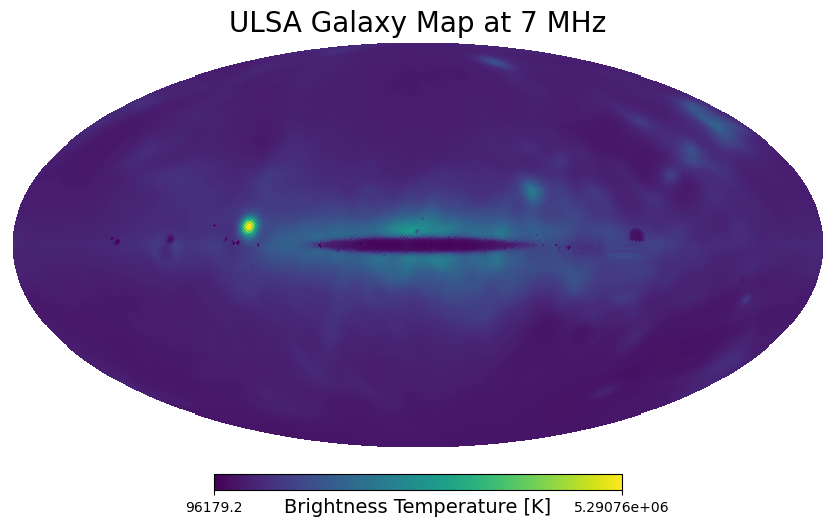

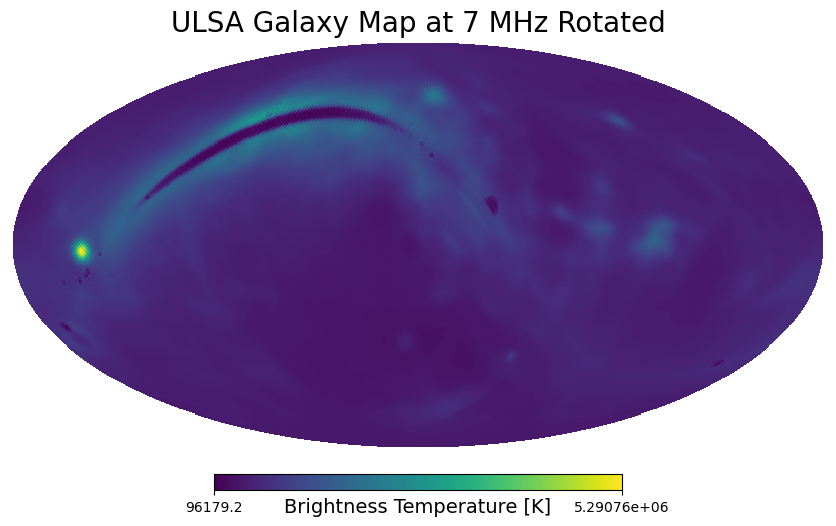

In [3]:
# ULSA Galaxy Example and ULSA Galaxy Rotated Example

# Standard unrotated galaxy
hp.mollview(galaxy_map_64[7],unit="Brightness Temperature [K]",cmap= cmap)
plt.title("ULSA Galaxy Map at 7 MHz" ,fontsize=20)
# plt.savefig(save_path+"ULSA_64bit_Standard")


# ## next few lines create and save the rotated galaxy to save time when loading this up again.
# # galaxy creation part
# # Now we rotate it into a frame consistent with a LuSEE-Night observation window.
# rotated_64_ULSA = lochness.LOCHNESS(spice_kernels,test_times1,location,galaxy_map=galaxy_map_64).lunar_frame_galaxy_maps[0]
# rotated_64_ULSA[np.where(rotated_64_ULSA<0.0)] = 0
# # HDF5 part
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rotated_64_ULSA","w")
# hdf5.create_dataset("rotated_sky_maps",data=rotated_64_ULSA)
# hdf5.close()
# ## End of galaxy map creation and hdf5 saving code

## next two lines load the hdf5 file for the galaxy rotation
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rotated_64_ULSA","r")
rotated_64_ULSA = hdf5["rotated_sky_maps"]
## End of hdf5 loading code

hp.mollview(rotated_64_ULSA[7],min=96179.2,max=5290760,cmap=cmap,unit="Brightness Temperature [K]")
plt.title("ULSA Galaxy Map at 7 MHz Rotated" ,fontsize=20)
# plt.savefig(save_path+"ULSA_64bit_Rotated")

## Five Region Model with Rotated Galaxy
- We'll use the rotated galaxy for examples from here on out since that's the actual foreground we used as our base model.

100%|██████████| 10/10 [00:00<00:00, 5490.65it/s]


Text(0.5, 1.0, 'Five Region Model Rotated')

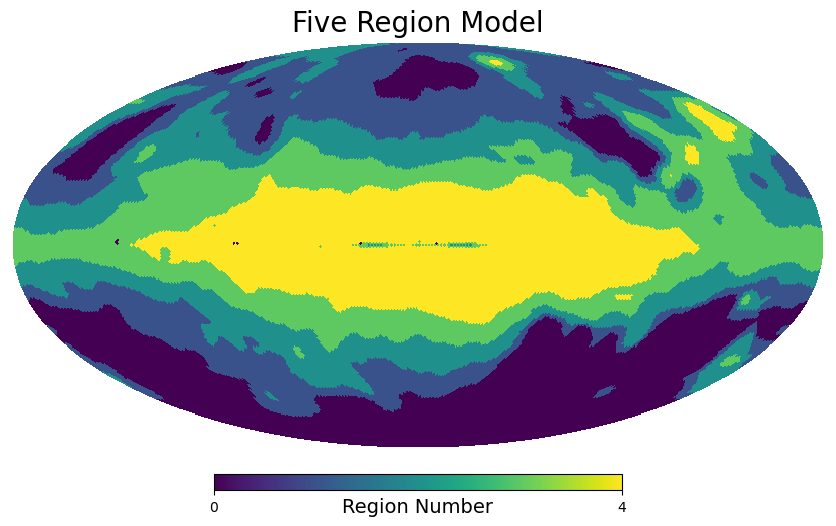

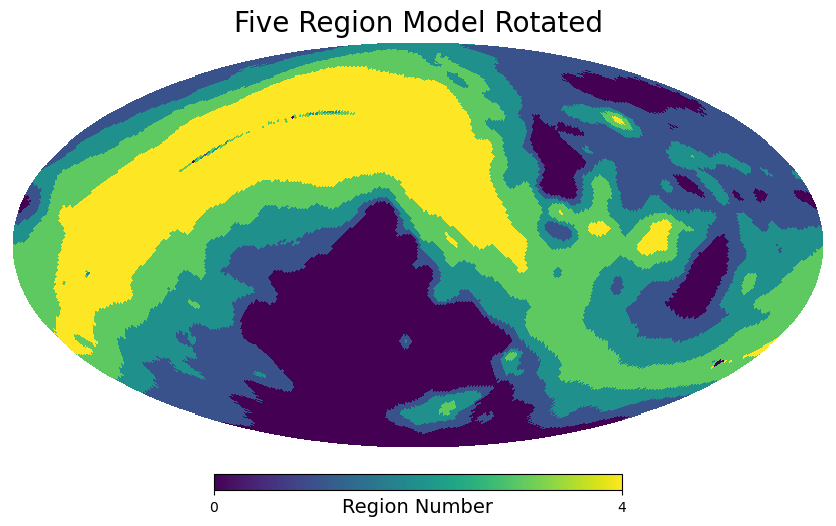

In [ ]:
# Shows the regions
best_foreground_model = py21cmsig.make_foreground_model(np.arange(5,51),5,ULSA_direction_64,25,1,1,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices = best_foreground_model[10]
hp.mollview(best_foreground_model[11],unit = "Region Number",cmap=cmap)
plt.title("Five Region Model", fontsize=20)
# plt.savefig(save_path+"five_region_model")

## next two lines load the hdf5 file for the galaxy rotation
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rotated_64_ULSA","r")
rotated_64_ULSA = hdf5["rotated_sky_maps"]
## End of hdf5 loading code

# Shows the rotated regions
best_foreground_model_rotated = py21cmsig.make_foreground_model(np.arange(5,51),5,rotated_64_ULSA,25,1,1,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices_rotated = best_foreground_model_rotated[10]
hp.mollview(best_foreground_model_rotated[11],unit = "Region Number")
plt.title("Five Region Model Rotated", fontsize=20)
# plt.savefig(save_path+"five_region_model_rotated")

## Varied Foreground Example

In [5]:
# Simulation and Training Set for a single LST
parameter_array = np.array([[omR0,0],[omM0,0],[omK0,0],[omL0,0],[omB0,0/h**2]])
fiducial_signal = py21cmsig.lambdaCDM_training_set(frequencies,parameter_array,1)[0][0]

# Loads up the raw sky maps
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/varied_beams_ULSA_sky_maps","r")
raw_sky_maps = hdf5["sky_maps"]
raw_sky_maps.shape

B_value_functions = py21cmsig.B_value_interp(beam_sky_training_set,beam_sky_training_set_params,\
                         frequencies,sky_map,reference_frequency,n_regions)

# This loads in your raw training set
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set","r")
varied_regolith_training_set_raw= f["Foreground_Training_Set"]
varied_regolith_training_set_raw_params = f["Parameters_of_Beams"]

## Creates a foreground for the simulation:
dt = 10000*3600
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
parameter_variation = [0,0,0]

signal_model = fiducial_signal

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")


# data = simulation_test_beam[0]
# one_sigma_rms = rms_std
# training_set = varied_regolith_training_set_raw
# training_set_parameters = varied_regolith_training_set_raw_params
# signal_extraction_return = signal_extraction(data,rms_mean,rms_std,training_set,training_set_parameters,N=10000,sigma_tolerance=3,iteration_limit=10)


## Creates a training set with varied foreground and beams:

# custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 500 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 500
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)

## next two lines load the hdf5 file for the galaxy rotation
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rotated_64_ULSA","r")
rotated_64_ULSA = np.array(hdf5["rotated_sky_maps"])
## End of hdf5 loading code

copy_rotated_ULSA = copy.deepcopy(rotated_64_ULSA)
copy_rotated_ULSA[7][region_indices_rotated[0]] += foreground_run_set[5][0][0][4]
copy_rotated_ULSA[7][region_indices_rotated[1]] += foreground_run_set[5][0][1][4]
copy_rotated_ULSA[7][region_indices_rotated[2]] += foreground_run_set[5][0][2][4]
copy_rotated_ULSA[7][region_indices_rotated[3]] += foreground_run_set[5][0][3][4]
copy_rotated_ULSA[7][region_indices_rotated[4]] += foreground_run_set[5][0][4][4]

copy_rotated_ULSA[40][region_indices_rotated[0]] += foreground_run_set[5][100][0][136]
copy_rotated_ULSA[40][region_indices_rotated[1]] += foreground_run_set[5][100][1][136]
copy_rotated_ULSA[40][region_indices_rotated[2]] += foreground_run_set[5][100][2][136]
copy_rotated_ULSA[40][region_indices_rotated[3]] += foreground_run_set[5][100][3][136]
copy_rotated_ULSA[40][region_indices_rotated[4]] += foreground_run_set[5][100][4][136]

hp.mollview(copy_rotated_ULSA[7],unit="Brightness Temperature [K]",min=96179, max= 5290760,cmap=cmap )
plt.title("Example Varied Foreground at 7 MHz", fontsize=15)
# plt.savefig(save_path+"example_foreground_trainingset_7MHz")
hp.mollview((copy_rotated_ULSA[7]-rotated_64_ULSA[7])/rotated_64_ULSA[7]*100,min=-40,max=30,unit="Percent Difference",cmap=cmap)
plt.title("Difference of Varied Foreground from Base ULSA Model" ,fontsize = 15)
# plt.savefig(save_path+"example_fgts_diff")

100%|██████████| 2/2 [00:00<00:00, 4696.87it/s]

[0, 0, 0]


TypeError: simulation_run() missing 1 required positional argument: 'dt'

## Varied Foreground Training Set Distribution

In [4]:

## Creates a training set with varied foreground and beams:

# custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])  # For making a random foreground
parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 10000
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)

## This portion creates the foreground training set
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)

best_foreground_model_rotated_32 = py21cmsig.make_foreground_model(np.arange(5,51),5,foreground_array_minCMB[0],25,1,1,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices_rotated_32 = best_foreground_model_rotated_32[10]
# Let's weight each region correctly:
masked_indices = np.where(beams[0][-1] <= 0)[0]
masked_region_indices = {}
for r in region_indices_rotated_32:  # Creates list of indices per region that exist within the beam
    ones_array = np.ones(NPIX)
    ones_array[masked_indices] = 0
    zeros_array = np.zeros(NPIX)
    zeros_array[region_indices_rotated_32[r]] = 1
    masked_region_indices[r] = np.where(ones_array*zeros_array == 1)

region_1_weight = masked_region_indices[0][0].shape[0]/(NPIX/2)
region_2_weight = masked_region_indices[1][0].shape[0]/(NPIX/2)
region_3_weight = masked_region_indices[2][0].shape[0]/(NPIX/2)
region_4_weight = masked_region_indices[3][0].shape[0]/(NPIX/2)
region_5_weight = masked_region_indices[4][0].shape[0]/(NPIX/2)
region_weights = np.array((region_1_weight,region_2_weight,region_3_weight,region_4_weight,region_5_weight))
region_weights

foreground_training_set = np.zeros((N,len(frequencies)))
for n in range(N):
    new_T = 0
    for r in range(5):
        new_T += foreground_run_set[5][n][r]*region_weights[r]
    foreground_training_set[n] = perfect_signal + new_T

# Displays a training set of ONLY the foregrounds. No beam weights.

plt.figure(figsize=(10, 5))

for n in range(10000):
    plt.plot(frequencies, (foreground_training_set[n]-perfect_signal)/perfect_signal*100)
plt.title("Foreground Training Set",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Percent Difference from ULSA Base",fontsize="15")
# plt.savefig(save_path+"Foreground_Training_Set")

100%|██████████| 176/176 [00:01<00:00, 155.38it/s]


[[1.  1. ]
 [3.4 3.4]
 [4.6 4.6]]


100%|██████████| 2/2 [00:00<00:00,  9.34it/s]


[0.05, 0.025, 0.05]


NameError: name 'simulation_test_beam' is not defined

## Beam Example

Text(0.5, 1.0, 'Beam-weighted Foreground at 40 MHz')

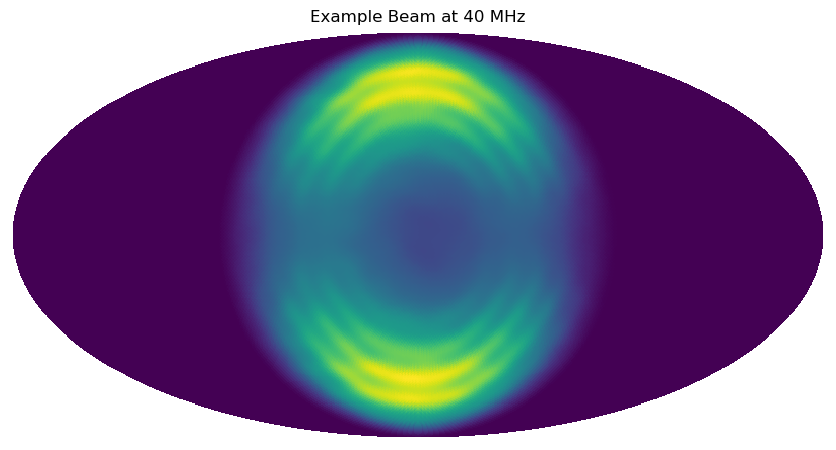

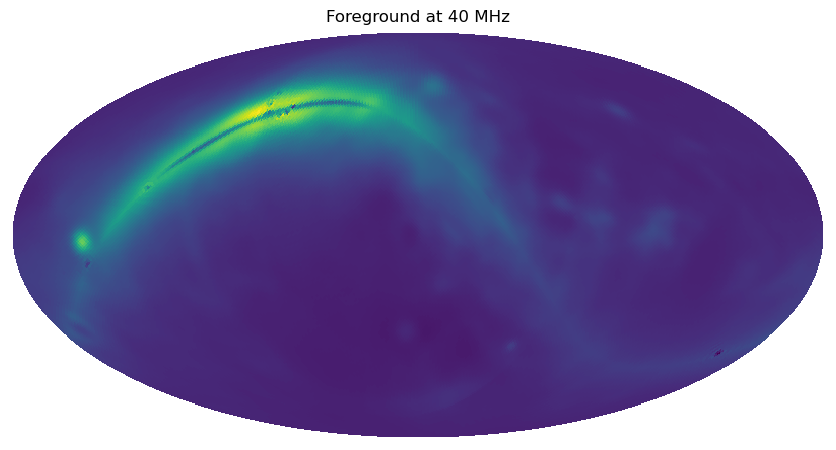

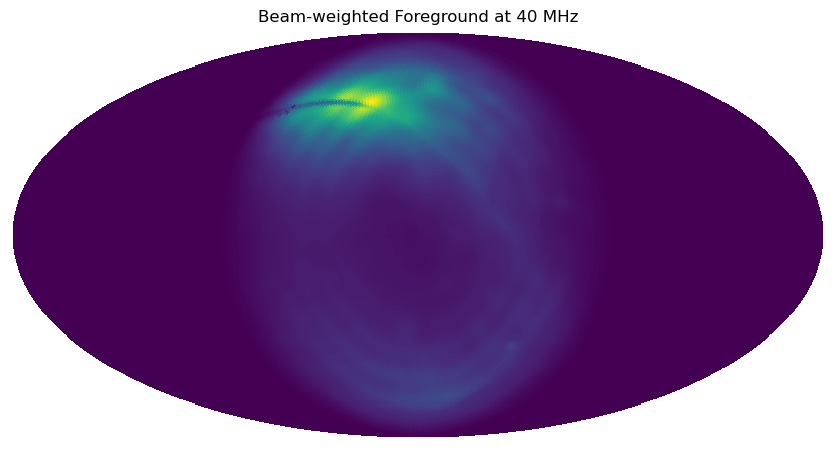

In [16]:
# This creates the sky maps that are properly rotated and normalized 64 bit version
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
beams_64 = np.zeros((len(files),50,NPIX))
beam_euler_angle = [0,90,90]
derp = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Raw_Beam_Maps_64","r")
beam_maps= derp["raw_beam_maps"]

### Creates an h5py file for 64 bit normalized beams
# for n in tqdm(range(len(files))):
#     for nu in range(50):
#         f=beam_maps[n][nu]
#         rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(f)
#         rotated_beam[np.where(rotated_beam<0.0)] = 0
#         normalized_beam = rotated_beam/np.sum(rotated_beam)
#         beams_64[n][nu] = normalized_beam
# f = h5py.File("/home/dbarker7752/21_cm_group/normalized_beams_64","w")
# f.create_dataset("normalized_beams",data=beams_64)
# f.close()
### End hdf5 creation code

### Loads hdf5 for normalized beams
f = h5py.File("/home/dbarker7752/21_cm_group/normalized_beams_64","r")
beams_64 = f["normalized_beams"]
### End loading code 

hp.mollview(beams_64[0][40], cbar=False,cmap=cmap)
plt.title("Example Beam at 40 MHz")
# plt.savefig(save_path+"Example_Beam_40MHz")

# And now to weight it with the foreground
# First a foreground without a colorbar:
hp.mollview(rotated_64_ULSA[40],cbar=False,cmap=cmap)
plt.title("Foreground at 40 MHz")
# plt.savefig(save_path+"ULSA_rot_40MHz_nocbar")

# now beam_weighted:
hp.mollview(rotated_64_ULSA[40]*beams_64[0][40], cbar=False,cmap=cmap)
plt.title("Beam-weighted Foreground at 40 MHz")
# plt.savefig(save_path+"ULSA_40MHz_beam-weighted")

## Beam Training Set

100%|██████████| 176/176 [00:03<00:00, 52.25it/s]


[[1.  2. ]
 [3.3 3.5]
 [4.2 4.7]]


100%|██████████| 10000/10000 [00:00<00:00, 97466.93it/s]


[0, 0, 0]


100%|██████████| 2/2 [00:00<00:00, 5472.02it/s]


[[ 1.59202418e+01  1.59202418e+01 -2.65279830e+00 -2.65279830e+00
  -1.37293590e-02 -1.37293590e-02]
 [ 1.66130589e+01  1.66130589e+01 -2.69062579e+00 -2.69062579e+00
  -1.47582387e-02 -1.47582387e-02]
 [ 1.89769800e+01  1.89769800e+01 -2.68235795e+00 -2.68235795e+00
  -1.34495335e-02 -1.34495335e-02]
 [ 2.42115565e+01  2.42115565e+01 -2.66682587e+00 -2.66682587e+00
  -1.20169084e-02 -1.20169084e-02]
 [ 5.22431891e+01  5.22431891e+01 -2.65055339e+00 -2.65055339e+00
  -2.42275191e-02 -2.42275191e-02]]


Text(0, 0.5, 'Percent Difference from ULSA Base')

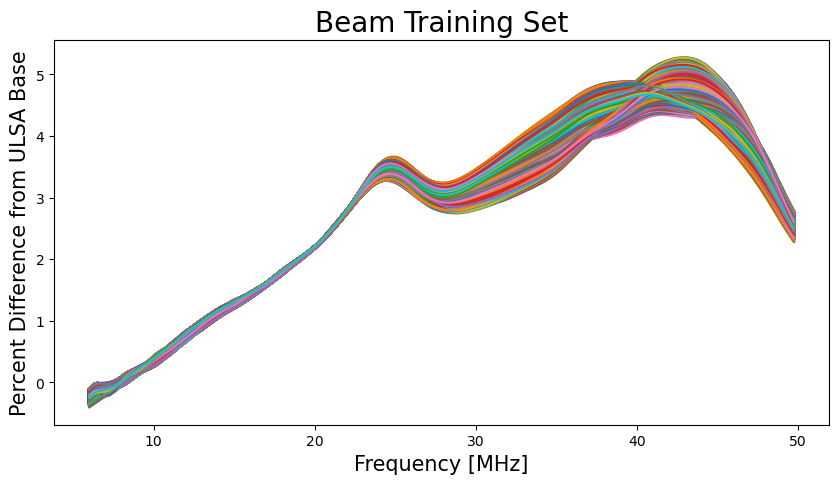

In [17]:

## Creates a training set with varied beams:

custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])  # For making a random foreground
parameter_variation = [0,0,0]                           # For making a random foreground
rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 10000 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)

# Beam Training Set

plt.figure(figsize=(10, 5))

beam_training_set=foreground_run_set[3]

# Displays a training set of the beams weighting the ULSA base model.
for n in range(10000):
    plt.plot(frequencies, (beam_training_set[n]-perfect_signal)/perfect_signal*100)
plt.title("Beam Training Set",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Percent Difference from ULSA Base",fontsize="15")
# plt.savefig(save_path+"Beam_Training_Set")

100%|██████████| 176/176 [00:01<00:00, 165.93it/s]


[[1.  2. ]
 [3.3 3.5]
 [4.2 4.7]]


100%|██████████| 500/500 [00:02<00:00, 185.31it/s]


[0.05, 0.025, 0.05]


100%|██████████| 2/2 [00:00<00:00, 8603.70it/s]


[[ 1.51242297e+01  1.67162539e+01 -2.58647835e+00 -2.71911826e+00
  -1.30428910e-02 -1.44158269e-02]
 [ 1.57824060e+01  1.74437118e+01 -2.62336014e+00 -2.75789143e+00
  -1.40203268e-02 -1.54961507e-02]
 [ 1.80281310e+01  1.99258289e+01 -2.61529900e+00 -2.74941689e+00
  -1.27770568e-02 -1.41220102e-02]
 [ 2.30009787e+01  2.54221344e+01 -2.60015522e+00 -2.73349652e+00
  -1.14160630e-02 -1.26177538e-02]
 [ 4.96310296e+01  5.48553485e+01 -2.58428955e+00 -2.71681722e+00
  -2.30161431e-02 -2.54388950e-02]]


Text(0, 0.5, 'Percent Difference from ULSA Base')

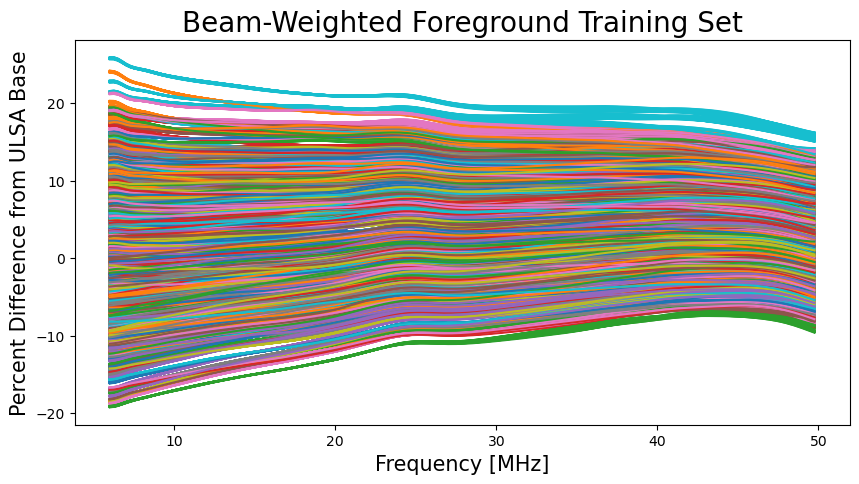

In [18]:
## Creates a training set with varied beams:

custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])  # For making a random foreground
parameter_variation = [0.05,0.025,0.05]                              # For making a random foreground
rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 500 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 500
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)

plt.figure(figsize=(10, 5))
# Beam-Weighted Foreground Training Set
beam_foreground_training_set=foreground_run_set[3]

# Displays a training set of the beams weighting the ULSA base model.
for n in range(20000):
    plt.plot(frequencies, (beam_foreground_training_set[n]-perfect_signal)/perfect_signal*100)
plt.title("Beam-Weighted Foreground Training Set",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Percent Difference from ULSA Base",fontsize="15")
# plt.savefig(save_path+"Beam_Foreground_Training_Set")

## PYLINEX flow-chart figures (at least the ones we haven't already made)

In [ ]:
# Lambda CDM Training Set
# plt.figure(figsize=(10, 5))
# for n in range(10000):
#     plt.plot(frequencies,labmdaCDM_training_set[n])
# plt.title("Lambda CDM Signal Training Set",fontsize=20)
# plt.ylabel(r"$\delta T_b$",fontsize=15)
# plt.xlabel("Frequency [MHz]",fontsize=15)
# plt.savefig(save_path+"Lambda_CDM_Training_Set")

Text(0.5, 0, 'Frequency [MHz]')

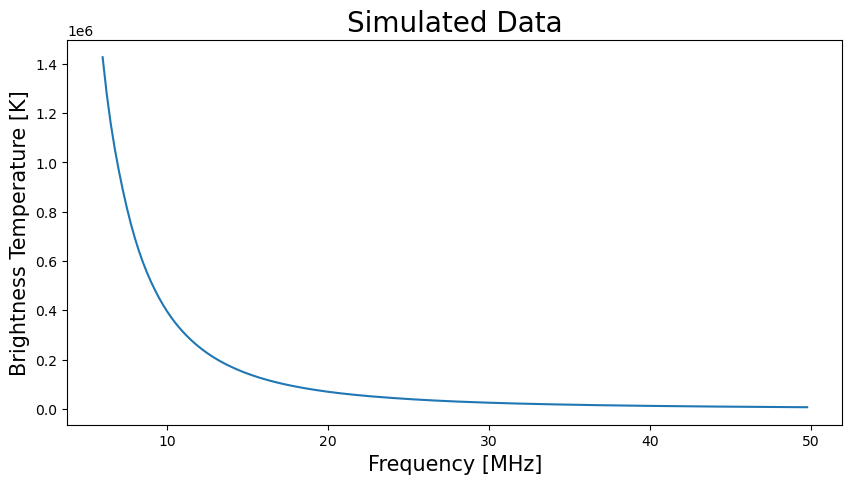

In [19]:
# Simulation Data

plt.figure(figsize=(10, 5))
plt.plot(frequencies, simulation_test_beam[0])
plt.title("Simulated Data",fontsize=20)
plt.ylabel("Brightness Temperature [K]",fontsize=15)
plt.xlabel("Frequency [MHz]",fontsize=15)
# plt.savefig(save_path+"Simulated_Signal")


In [4]:



## Creates a foreground for the simulation:
dt = 10000*3600
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
parameter_variation = [0,0,0]

signal_model = fiducial_signal

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

## Creates a training set with varied foreground and beams:

# custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
parameter_variation = [0.0000005,0.00000025,0.0000005]                           # For making a random foreground

rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 500 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 500
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)


print(fg_range_array)

#### Pylinex Fit #####
fg_training_set = foreground_run_set[3]
sig_training_set = labmdaCDM_training_set
IC = "DIC"
sim_data = simulation_test_beam[0]
noise_level = sigT(sim_data,dnu,dt)
foreground_training_set_array = copy.deepcopy(fg_training_set)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=30,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
signal_basis.generate_gaussian_prior()
foreground_basis.generate_gaussian_prior()
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,30)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension,)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter2.sizes['Foreground']
num_signal_terms = fitter2.sizes['Signal']
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter2.subbasis_channel_mean("Signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter2.subbasis_channel_error("Signal")[np.where(fitter2.subbasis_channel_mean("Signal")==fitter2.subbasis_channel_mean("Signal").min())][0]} Channel error at lowest point of the trough ")
# print(f"{fitter2.log_evidence} log evidence")
print(f"{fitter2.chi_squared} Chi Squared")
print(f"{fitter2.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter2.subbasis_channel_mean("Signal")/simulation_test_beam[2],(fitter2.subbasis_channel_mean("Foreground")-simulation_test_beam[2])/simulation_test_beam[2])
print(f"True {pearsonr}")




  0%|          | 0/176 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 3682.44it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59202418e+01 -2.65279830e+00 -1.37293590e-02  1.66130589e+01
 -2.69062579e+00 -1.47582387e-02  1.89769800e+01 -2.68235795e+00
 -1.34495335e-02  2.42115565e+01 -2.66682587e+00 -1.20169084e-02
  5.22431891e+01 -2.65055339e+00 -2.42275191e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]


100%|██████████| 176/176 [00:00<00:00, 181.20it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60001 ]]


100%|██████████| 500/500 [00:01<00:00, 256.92it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 2/2 [00:00<00:00, 8962.19it/s]


[[ 1.59202338e+01  1.59202498e+01 -2.65279764e+00 -2.65279897e+00
  -1.37293521e-02 -1.37293658e-02]
 [ 1.66130506e+01  1.66130672e+01 -2.69062512e+00 -2.69062646e+00
  -1.47582313e-02 -1.47582461e-02]
 [ 1.89769705e+01  1.89769894e+01 -2.68235727e+00 -2.68235862e+00
  -1.34495268e-02 -1.34495402e-02]
 [ 2.42115444e+01  2.42115686e+01 -2.66682520e+00 -2.66682654e+00
  -1.20169024e-02 -1.20169144e-02]
 [ 5.22431630e+01  5.22432152e+01 -2.65055273e+00 -2.65055405e+00
  -2.42275070e-02 -2.42275312e-02]]
[[ 1.59202338e+01  1.59202498e+01 -2.65279764e+00 -2.65279897e+00
  -1.37293521e-02 -1.37293658e-02]
 [ 1.66130506e+01  1.66130672e+01 -2.69062512e+00 -2.69062646e+00
  -1.47582313e-02 -1.47582461e-02]
 [ 1.89769705e+01  1.89769894e+01 -2.68235727e+00 -2.68235862e+00
  -1.34495268e-02 -1.34495402e-02]
 [ 2.42115444e+01  2.42115686e+01 -2.66682520e+00 -2.66682654e+00
  -1.20169024e-02 -1.20169144e-02]
 [ 5.22431630e+01  5.22432152e+01 -2.65055273e+00 -2.65055405e+00
  -2.42275070e-02 -2.422

NameError: name 'labmdaCDM_training_set' is not defined

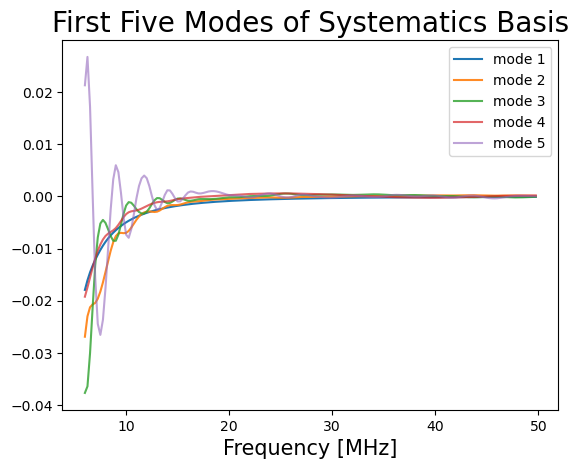

In [21]:

# Plots the foreground basis
for n in range(5):
    plt.plot(frequencies, foreground_basis.basis[n],label=f"mode {n+1}",alpha = 1-0.1*n)
plt.title("First Five Modes of Systematics Basis",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.legend()
# plt.savefig(save_path+"Foreground_Basis")

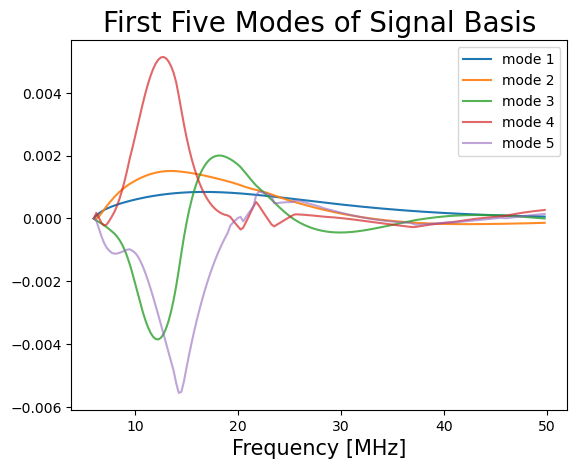

In [22]:
# Plots the foreground basis
for n in range(5):
    plt.plot(frequencies, signal_basis.basis[n],label=f"mode {n+1}",alpha = 1-0.1*n)
plt.title("First Five Modes of Signal Basis",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.legend()
# plt.savefig(save_path+"Signal_Basis")

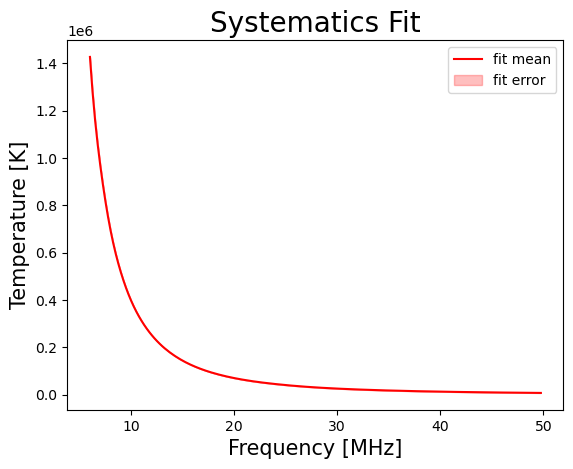

In [23]:
plt.plot(frequencies, fitter2.subbasis_channel_mean("Foreground"),label = "fit mean", c="red")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Foreground")+fitter2.subbasis_channel_error("Foreground"),fitter2.subbasis_channel_mean("Foreground")-fitter2.subbasis_channel_error("Foreground"),label="fit error",alpha=0.25,color="red")
plt.title("Systematics Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.legend()
# plt.savefig(save_path+"example_foreground_fit")

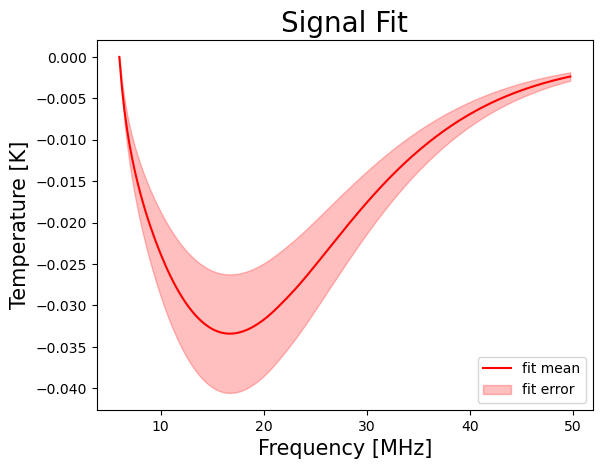

In [24]:
plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
plt.title("Signal Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.legend()
# plt.savefig(save_path+"example_signal_fit")

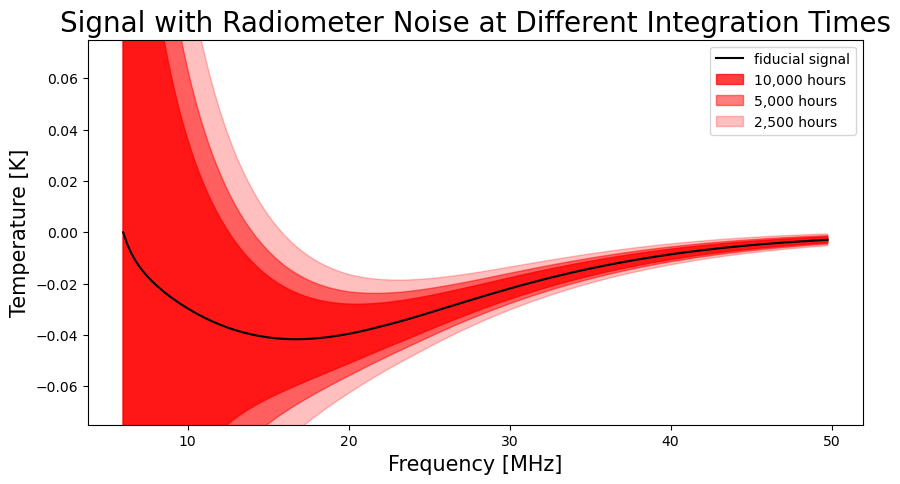

In [ ]:
# This is a noise figure for Jack, but might include this in my paper near the noise section...maybe

plt.figure(figsize=(10, 5))
plt.plot(frequencies, simulation_test_beam[1],label = "fiducial signal", c="black")
plt.fill_between(frequencies, simulation_test_beam[1]+sigT(simulation_test_beam[0],dnu,10000*3600),simulation_test_beam[1]-sigT(simulation_test_beam[0],dnu,10000*3600),label="10,000 hours",alpha=0.75,color="red")
plt.fill_between(frequencies, simulation_test_beam[1]+sigT(simulation_test_beam[0],dnu,5000*3600),simulation_test_beam[1]-sigT(simulation_test_beam[0],dnu,5000*3600),label="5,000 hours",alpha=0.5,color="red")
plt.fill_between(frequencies, simulation_test_beam[1]+sigT(simulation_test_beam[0],dnu,2500*3600),simulation_test_beam[1]-sigT(simulation_test_beam[0],dnu,2500*3600),label="2,500 hours",alpha=0.25,color="red")
plt.title("Signal with Radiometer Noise at Different Integration Times",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.ylim(-0.075,0.075)
plt.legend()

plt.savefig("Multi_error_signal_for_Jack")


In [25]:
# Noise levels from various integration times at 17 MHz
sig_10=sigT(simulation_test_beam[0],dnu,10000*3600)[43]
sig_5=sigT(simulation_test_beam[0],dnu,5000*3600)[43]
sig_2dot5=sigT(simulation_test_beam[0],dnu,2500*3600)[43]
print(sig_10)
print(sig_5)
print(sig_2dot5)

0.01807425279839379
0.025560853437248364
0.03614850559678758


## Training Set Curve Number Optimization Test
- Takes a long time to run, so I'll save it for last
- I would also like to add STD in a fill between for the graph

In [5]:


iterations = 1 # number of basis to average per value
N_vectors = 20
bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
average_diff = np.zeros((iterations-1))


values = [3000000]
# values = [51,100000]
average_diff_num_foreground = np.zeros((3,len(values)))
for i,N in enumerate (values):
    # numbers for the training sets
    Nb = int(np.sqrt(N))
    Nfg = int(np.sqrt(N))
    # Nb = 100
    # Nfg = 10000
    Ns = N
    for b in tqdm(range(iterations)):
        pbar = manager.counter(total=iterations, desc='Iterations')
    #### Pylinex Fit #####

        custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
        parameter_variation = [0.0000005,0.00000025,0.0000005]                              # For making a random foreground
        rms_mean = 0.05
        rms_std = 0.009
        ## Interpolate the varied beams to match the rest of the data
        varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
        for n in range(len(varied_regolith_training_set_raw)):
            beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
            varied_regolith_training_set[n] = beam_regolith_interp(frequencies)

        exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                                    custom_parameter_range,show_parameter_ranges=True)
        n_regions = 5
        reference_frequency = 25
        sky_map = foreground_array_minCMB[0]
        BTS_curves = exp_test[0]
        BTS_params = exp_test[1]
        beam_sky_training_set = beams[:,5:,:]
        beam_sky_training_set_params = varied_regolith_training_set_raw_params
        raw_beam_weighted_sky_maps = raw_sky_maps

        # parameter_variation = [0.05,0.025,0.05]
        determine_parameter_range = True
        new_FG_parameter_mean = None
        foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                            beam_sky_training_set,beam_sky_training_set_params,Nfg,parameter_variation,B_value_functions,\
                                                define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)



# ### This takes quite some time to run, so let's save these numbers

# # ### HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/basis_test_data2_3mil","w")
hdf5.create_dataset("training_set",data=foreground_run_set[3])
hdf5.create_dataset("parameters",data=foreground_run_set[4])
hdf5.close()
# # ### End of HDF5 data saving


## Now the loop for each exotic signal training set
# values=[20000]
# # lambda CDM
# bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
# average_diff = np.zeros((iterations-1))
# parameter_array = np.array([[omR0,0],[omM0,0.013],[omK0,0],[omL0,0.0062],[omB0,0.00014/h**2]])
# average_diff_num_lambdaCDM = np.zeros((3,len(values)))
# for i,N in enumerate (values):
#     # numbers for the training sets
#     Nb = int(np.sqrt(N))
#     Nfg = int(np.sqrt(N))
#     # Nb = 100
#     # Nfg = 10000
#     Ns = N
#     for b in tqdm(range(iterations)):
#         pbar = manager.counter(total=iterations, desc='Iterations')
#         signal_training_set_lambdaCDM=py21cmsig.lambdaCDM_training_set(frequencies,parameter_array,N)
        #signal_training_set = signal_training_set_lambdaCDM[0]
        #noise_level = sigT(sim_data,dnu,dt)
        #signal_training_set_array = copy.deepcopy(signal_training_set)
        #signal_basis_CDM2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)


# ### This takes quite some time to run, so let's save these numbers

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/lambdaCDM_training_set1_20k","w")
# hdf5.create_dataset("training_set",data=signal_training_set_lambdaCDM[0])
# hdf5.create_dataset("parameters",data=signal_training_set_lambdaCDM[1])
# hdf5.close()
### End of HDF5 data saving
# N = 10000
# # DMAN
# parameters_DMAN = [[2*10e-22,1*10e-22,5*10e-23,2*10e-23,5*10e-24,2*10e-24]]
# bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
# average_diff = np.zeros((iterations-1))
# average_diff_num_DMAN = np.zeros((3,len(values)))

# pbar = manager.counter(total=iterations, desc='Iterations')
# DMAN_training_set=py21cmsig.DMAN_training_set(frequencies,parameters_DMAN,N)


# ### This takes quite some time to run, so let's save these numbers

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMAN_training_set","w")
# hdf5.create_dataset("training_set",data=DMAN_training_set[0])
# hdf5.create_dataset("parameters",data=DMAN_training_set[1])
# hdf5.close()
# ### End of HDF5 data saving

# # DMD
# bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
# average_diff = np.zeros((iterations-1))
# parameters_DMD = [[0.5*10e26, 1*10e26, 3*10e26, 10*10e26, 30*10e26, 100*10e26, 500*10e26]]
# average_diff_num_DMD = np.zeros((3,len(values)))

# DMD_training_set=py21cmsig.DMD_training_set(frequencies,parameters_DMD,N)


# ### This takes quite some time to run, so let's save these numbers

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMD_training_set","w")
# hdf5.create_dataset("training_set",data=DMD_training_set[0])
# hdf5.create_dataset("parameters",data=DMD_training_set[1])
# hdf5.close()
# ### End of HDF5 data saving

# # MCDM
# bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
# average_diff = np.zeros((iterations-1))
# parameters_MCDM = [[0.1,0.5,2,5,10]]
# average_diff_num_MCDM = np.zeros((3,len(values)))

# MCDM_training_set = py21cmsig.MCDM_training_set(frequencies,parameters_MCDM,N)


# ### This takes quite some time to run, so let's save these numbers

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/MCDM_training_set","w")
# hdf5.create_dataset("training_set",data=MCDM_training_set[0])
# hdf5.create_dataset("parameters",data=MCDM_training_set[1])
# hdf5.close()
# ### End of HDF5 data saving

# # EDE
# bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
# average_diff = np.zeros((iterations-1))
# parameters_EDE = np.array([[2e-5,4e-5],[50,100]])
# average_diff_num_EDE = np.zeros((3,len(values)))

# EDE_training_set = py21cmsig.EDE_training_set(frequencies,parameters_EDE,N)


# ### This takes quite some time to run, so let's save these numbers

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/EDE_training_set","w")
# hdf5.create_dataset("training_set",data=EDE_training_set[0])
# hdf5.create_dataset("parameters",data=EDE_training_set[1])
# hdf5.close()
# ### End of HDF5 data saving

# # ERB
# bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
# average_diff = np.zeros((iterations-1))
# parameters_ERB = np.array([[0.1,10,375],[25,100,200]])
# average_diff_num_ERB = np.zeros((3,len(values)))

# ERB_training_set = py21cmsig.ERB_training_set(frequencies,parameters_ERB,N)


# ### This takes quite some time to run, so let's save these numbers

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/ERB_training_set","w")
# hdf5.create_dataset("training_set",data=ERB_training_set[0])
# hdf5.create_dataset("parameters",data=ERB_training_set[1])
# hdf5.close()
# ### End of HDF5 data saving


# ### HDF5 data loading
# # hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/basis_test_data","r")
# # average_diff_num_foreground=hdf5["average_difference_foreground"]
# ### End of HDF5 data loading

# ## Subtracts the first basis from the other 4 and averages the result:

100%|██████████| 176/176 [00:01<00:00, 120.69it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60001 ]]


100%|██████████| 1/1 [02:41<00:00, 161.03s/it]


[5e-07, 2.5e-07, 5e-07]


In [6]:
# This loads the base signal training sets AND the secondary ones
## Primary Training Sets

#lambda CDM
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/lambdaCDM","r")
lambdaCDM_training_set = f["signal_training_set"]
lambdaCDM_training_set_params = f["signal_training_set_parameters"]


# Self-Annihilating Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMAN","r")
DMAN_training_set = f["signal_training_set"]
DMAN_training_set_params = f["signal_training_set_parameters"]

# Decaying Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMD","r")
DMD_training_set = f["signal_training_set"]
DMD_training_set_params = f["signal_training_set_parameters"]

# Early Dark Energy
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/EDE","r")
EDE_training_set = f["signal_training_set"]
EDE_training_set_params = f["signal_training_set_parameters"]

# Extra Radio Background
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/ERB","r")
ERB_training_set = f["signal_training_set"]
ERB_training_set_params = f["signal_training_set_parameters"]

# Baryon-Dark Matter Interaction (MCDM)
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/MCDM","r")
MCDM_training_set = f["signal_training_set"]
MCDM_training_set_params = f["signal_training_set_parameters"]

## Secondary Training Sets
#lambda CDM
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/lambdaCDM_training_set2","r")
lambdaCDM_training_set2 = f["training_set"]
lambdaCDM_training_set_params2 = f["parameters"]

# Self-Annihilating Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMAN_training_set","r")
DMAN_training_set2 = f["training_set"]
DMAN_training_set_params2 = f["parameters"]

# Decaying Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMD_training_set","r")
DMD_training_set2 = f["training_set"]
DMD_training_set_params2 = f["parameters"]

# Early Dark Energy
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/EDE_training_set","r")
EDE_training_set2 = f["training_set"]
EDE_training_set_params2 = f["parameters"]

# Extra Radio Background
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/ERB_training_set","r")
ERB_training_set2 = f["training_set"]
ERB_training_set_params2 = f["parameters"]

# Baryon-Dark Matter Interaction (MCDM)
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/MCDM_training_set","r")
MCDM_training_set2 = f["training_set"]
MCDM_training_set_params2 = f["parameters"]

#foreground training sets

f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/basis_test_data1_3mil","r")
foreground_training_set = f["training_set"]
foreground_training_set_params = f["parameters"]

f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/basis_test_data2_3mil","r")
foreground_training_set2 = f["training_set"]
foreground_training_set_params2 = f["parameters"]

# Modified 20k Lambda CDM training set with 20k for a better RMS graph
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/lambdaCDM_training_set1_20k","r")
lambdaCDM_training_set_20k = f["training_set"]
lambdaCDM_training_set_20k_params = f["parameters"]

f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/lambdaCDM_training_set2_20k","r")
lambdaCDM_training_set_20k2 = f["training_set"]
lambdaCDM_training_set_20k2_params2 = f["parameters"]

In [9]:
# Now let's vary the selection for each and see when they stop changin
N_vectors = 20 # number of vectors used to make the basis. Usually 20 is plenty
noise_level = sigT(simulation_test_beam[4],dnu,dt)
sel_array_foreground = np.arange(50000,3050000,50000) #the upper index of your selection. Change this to make your training sets bigger to determine when they have lower error.
sel_array = np.arange(100,20000,100)
RMS = lambda curve1, curve2: (((curve1-curve2)**2).sum())**(1/2) # quick little rms function for ease
rms_array_foreground = np.zeros(len(sel_array_foreground))
rms_array = np.zeros((6,len(sel_array)))
RMS_vecnum = 15

# for i,sel in tqdm(enumerate(sel_array_foreground)):

#     # foreground
#     foreground_training_set_array = foreground_training_set[0:sel]
#     foreground_basis1 = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
#     foreground_training_set_array = foreground_training_set2[0:sel]
#     foreground_basis2 = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
#     rms = 0
#     for n in range(RMS_vecnum):
#         rms += RMS(np.abs(foreground_basis1.basis[n]),np.abs(foreground_basis2.basis[n]))
#     rms_array_foreground[i] = rms

for i,sel in tqdm(enumerate(sel_array)):
    # lambda CDM
    signal_training_set_array = lambdaCDM_training_set_20k[0:sel]
    signal_basis_CDM1 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
    signal_training_set_array = lambdaCDM_training_set_20k2[0:sel]
    signal_basis_CDM2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
    rms = 0
    for n in range(RMS_vecnum):
        rms += RMS(np.abs(signal_basis_CDM1.basis[n]),np.abs(signal_basis_CDM2.basis[n]))
    rms_array[0][i] = rms

    # DMAN
    signal_training_set_array = DMAN_training_set[0:sel]
    signal_basis_DMAN1 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
    signal_training_set_array = DMAN_training_set2[0:sel]
    signal_basis_DMAN2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
    rms = 0
    for n in range(RMS_vecnum):
        rms += RMS(np.abs(signal_basis_DMAN1.basis[n]),np.abs(signal_basis_DMAN2.basis[n]))
    rms_array[1][i] = rms

    # DMD
    signal_training_set_array = DMD_training_set[0:sel]
    signal_basis_DMD1 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
    signal_training_set_array = DMD_training_set2[0:sel]
    signal_basis_DMD2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
    rms = 0
    for n in range(RMS_vecnum):
        rms += RMS(np.abs(signal_basis_DMD1.basis[n]),np.abs(signal_basis_DMD2.basis[n]))
    rms_array[2][i] = rms

    # MCDM
    signal_training_set_array = MCDM_training_set[0:sel]
    signal_basis_MCDM1 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
    signal_training_set_array = MCDM_training_set2[0:sel]
    signal_basis_MCDM2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
    rms = 0
    for n in range(RMS_vecnum):
        rms += RMS(np.abs(signal_basis_MCDM1.basis[n]),np.abs(signal_basis_MCDM2.basis[n]))
    rms_array[3][i] = rms

    # EDE
    signal_training_set_array = EDE_training_set[0:sel]
    signal_basis_EDE1 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
    signal_training_set_array = EDE_training_set2[0:sel]
    signal_basis_EDE2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)

    rms = 0
    for n in range(RMS_vecnum):
        rms += RMS(np.abs(signal_basis_EDE1.basis[n]),np.abs(signal_basis_EDE2.basis[n]))
    rms_array[4][i] = rms
    # ERB
    signal_training_set_array = ERB_training_set[0:sel]
    signal_basis_ERB1 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
    signal_training_set_array = ERB_training_set2[0:sel]
    signal_basis_ERB2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)

    rms = 0
    for n in range(RMS_vecnum):
        rms += RMS(np.abs(signal_basis_ERB1.basis[n]),np.abs(signal_basis_ERB2.basis[n]))
    rms_array[5][i] = rms
# Now for the plots we use to determine the changes:

# sel2 = 50 #the upper index of your selection. Change this to make your training sets bigger to determine when they have lower error.

# # foreground
# foreground_training_set_array = foreground_training_set[0:sel2]
# foreground_basis1_100 = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
# foreground_training_set_array = foreground_training_set2[0:sel2]
# foreground_basis2_100 = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=N_vectors,error=noise_level)

# # lambda CDM
# signal_training_set_array = lambdaCDM_training_set[0:sel2]
# signal_basis_CDM1_100 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
# signal_training_set_array = lambdaCDM_training_set2[0:sel2]
# signal_basis_CDM2_100 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)

# # DMAN
# signal_training_set_array = DMAN_training_set[0:sel2]
# signal_basis_DMAN1_100 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
# signal_training_set_array = DMAN_training_set2[0:sel2]
# signal_basis_DMAN2_100 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)

# ### HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rms_arrays","w")
hdf5.create_dataset("foreground_rms",data=rms_array_foreground)
hdf5.create_dataset("signal_rms",data=rms_array)
hdf5.close()
# ### End of HDF5 data saving

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rms_arrays_new","w")
# hdf5.create_dataset("foreground_rms",data=rms_array_foreground)
# hdf5.create_dataset("signal_rms",data=rms_array)
# hdf5.close()
# ### End of HDF5 data saving


199it [01:52,  1.76it/s]


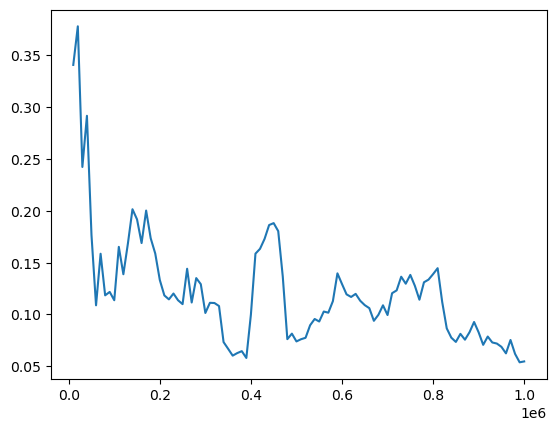

In [454]:
plt.plot(sel_array_foreground,rms_array_foreground)

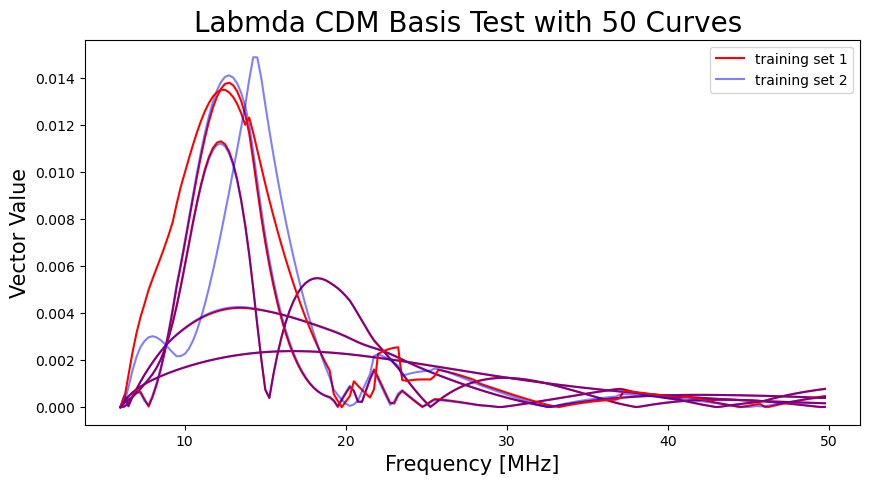

In [394]:
plt.figure(figsize=(10, 5))
for n in range(5):
    if n == 0:
        plt.plot(frequencies, np.abs(signal_basis_CDM1.basis[n]),c="red",label="training set 1")
        plt.plot(frequencies, np.abs(signal_basis_CDM2.basis[n]),c="blue",alpha=0.5,label="training set 2")
    else:
        plt.plot(frequencies, np.abs(signal_basis_CDM1.basis[n]),c="red")
        plt.plot(frequencies, np.abs(signal_basis_CDM2.basis[n]),c="blue",alpha=0.5)
plt.title(f"Labmda CDM Basis Test with {sel} Curves ",fontsize=20)
plt.ylabel("Vector Value",fontsize=15)
plt.xlabel("Frequency [MHz]",fontsize=15)
plt.legend()

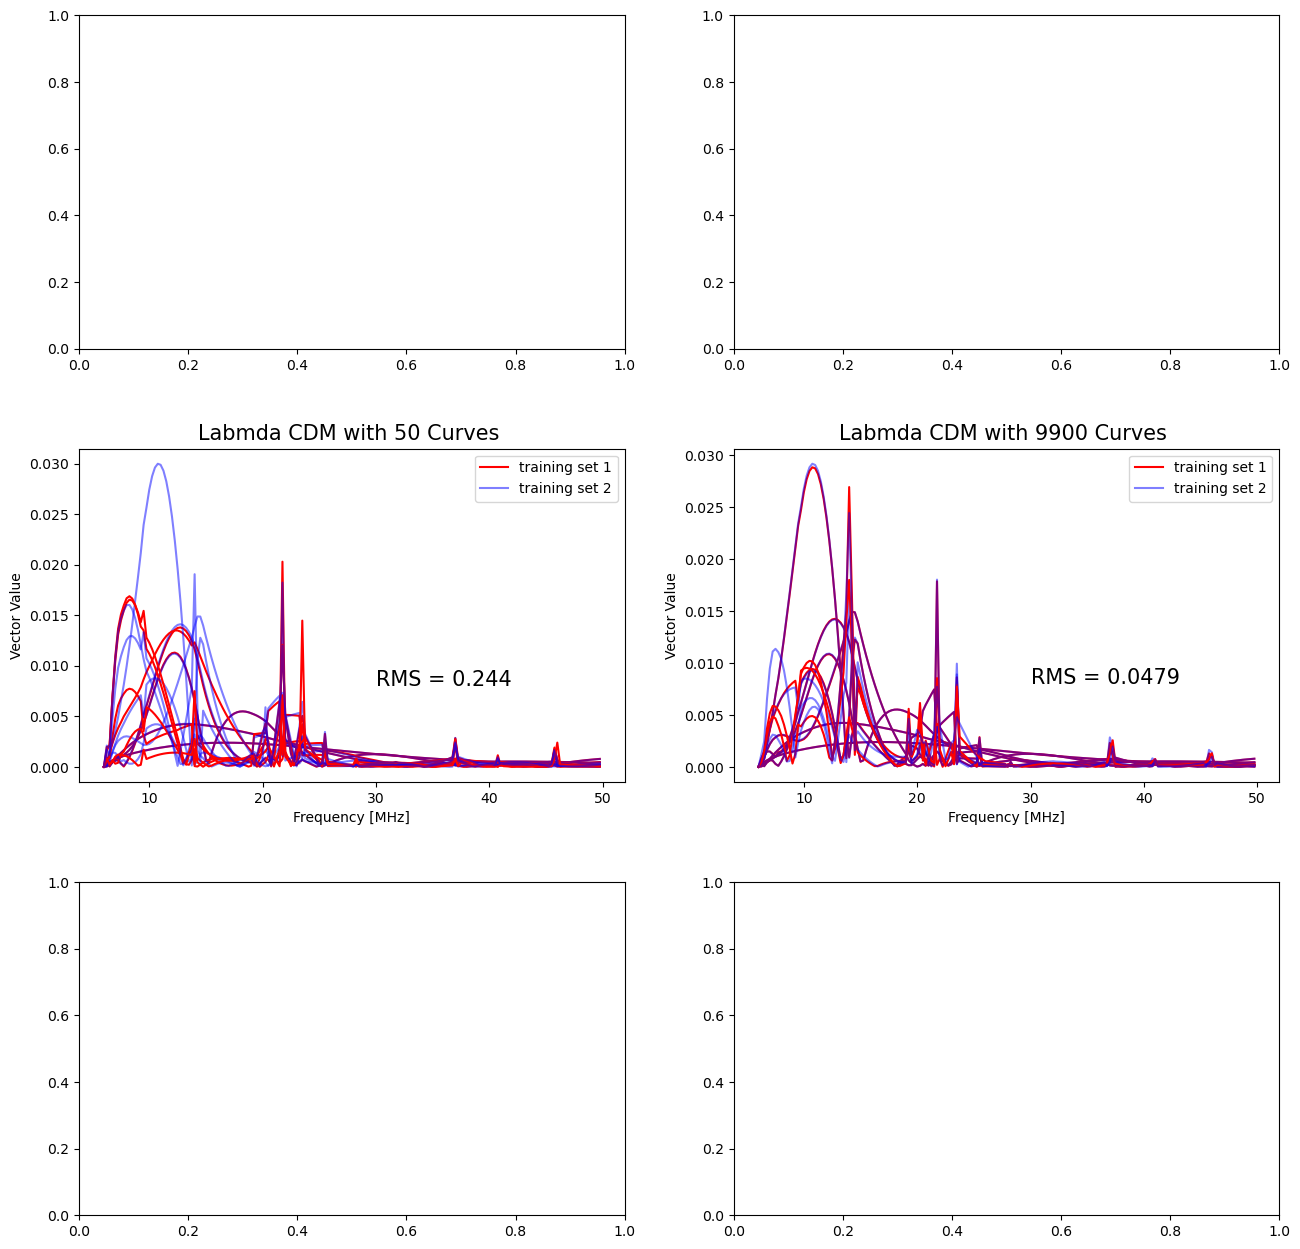

In [432]:


fig, ax = plt.subplots(3,2,figsize=(15, 15))

plt.subplot(3,2,1)



plt.subplot(3,2,2)


plt.subplot(3,2,3)
rms = 0
for n in range(10):
    if n == 0:
        plt.plot(frequencies, np.abs(signal_basis_CDM1_100.basis[n]),c="red",label="training set 1")
        plt.plot(frequencies, np.abs(signal_basis_CDM2_100.basis[n]),c="blue",alpha=0.5,label="training set 2")
    else:
        plt.plot(frequencies, np.abs(signal_basis_CDM1_100.basis[n]),c="red")
        plt.plot(frequencies, np.abs(signal_basis_CDM2_100.basis[n]),c="blue",alpha=0.5)
    rms += RMS(np.abs(signal_basis_CDM1_100.basis[n]),np.abs(signal_basis_CDM2_100.basis[n]))
plt.title(f"Labmda CDM with {sel2} Curves ",fontsize=15)
plt.ylabel("Vector Value",fontsize=10)
plt.xlabel("Frequency [MHz]",fontsize=10)

plt.text(30,0.008,f"RMS = {rms:.3f}",fontsize=15)
plt.legend()


plt.subplot(3,2,4)
rms = 0
for n in range(10):
    if n == 0:
        plt.plot(frequencies, np.abs(signal_basis_CDM1.basis[n]),c="red",label="training set 1")
        plt.plot(frequencies, np.abs(signal_basis_CDM2.basis[n]),c="blue",alpha=0.5,label="training set 2")
    else:
        plt.plot(frequencies, np.abs(signal_basis_CDM1.basis[n]),c="red")
        plt.plot(frequencies, np.abs(signal_basis_CDM2.basis[n]),c="blue",alpha=0.5)
    rms += RMS(np.abs(signal_basis_CDM1.basis[n]),np.abs(signal_basis_CDM2.basis[n]))
plt.title(f"Labmda CDM with {sel} Curves ",fontsize=15)
plt.ylabel("Vector Value",fontsize=10)
plt.xlabel("Frequency [MHz]",fontsize=10)

plt.text(30,0.008,f"RMS = {rms:.4f}",fontsize=15)
plt.legend()


plt.subplot(3,2,4)

plt.subplot(3,2,5)


plt.subplot(3,2,6)



plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.3)

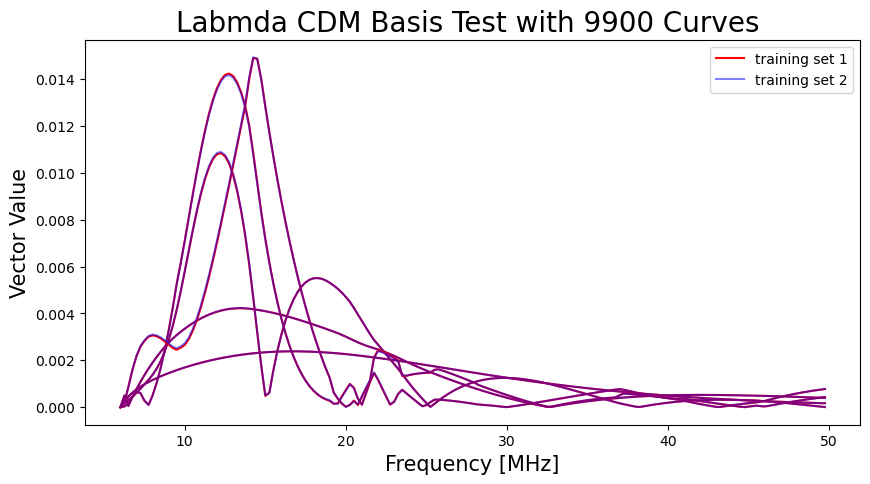

In [431]:
# Lambda CDM basis test with 1000 curves

plt.figure(figsize=(10, 5))
for n in range(5):
    if n == 0:
        plt.plot(frequencies, np.abs(signal_basis_CDM1.basis[n]),c="red",label="training set 1")
        plt.plot(frequencies, np.abs(signal_basis_CDM2.basis[n]),c="blue",alpha=0.5,label="training set 2")
    else:
        plt.plot(frequencies, np.abs(signal_basis_CDM1.basis[n]),c="red")
        plt.plot(frequencies, np.abs(signal_basis_CDM2.basis[n]),c="blue",alpha=0.5)
plt.title(f"Labmda CDM Basis Test with {sel} Curves ",fontsize=20)
plt.ylabel("Vector Value",fontsize=15)
plt.xlabel("Frequency [MHz]",fontsize=15)
plt.legend()
# plt.savefig(save_path+"CDM_basis_test_1000")

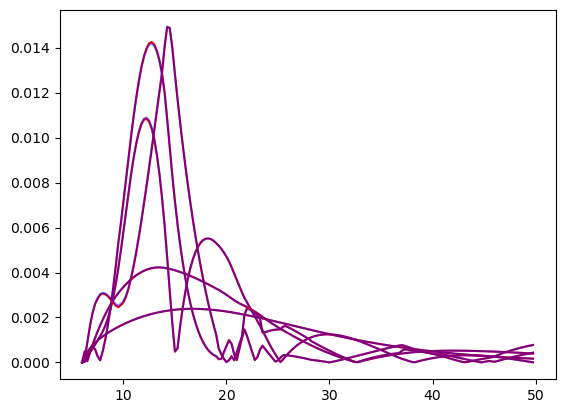

In [361]:
for n in range(5):
    plt.plot(frequencies, np.abs(signal_basis_CDM1.basis[n]),c="red")
    plt.plot(frequencies, np.abs(signal_basis_CDM2.basis[n]),c="blue",alpha=0.5)

0.0007979816464461128

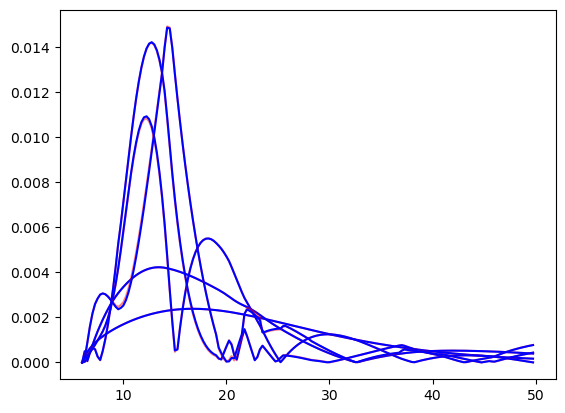

In [318]:
for n in range(5):    
    plt.plot(frequencies, np.abs(signal_basis_CDM1.basis[n]),c="red",alpha=0.5)
    plt.plot(frequencies, np.abs(signal_basis_CDM2.basis[n]),c="blue")

Text(0.5, 1.0, 'Foreground Basis Test')

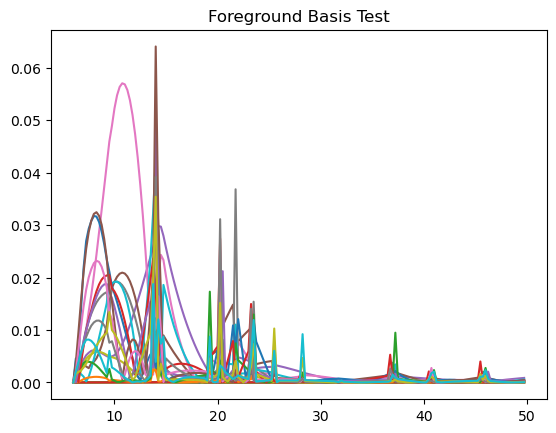

In [355]:
# foreground basis
for n in range(N_vectors):
    plt.plot(frequencies, np.abs(signal_basis_CDM1.basis[n]-signal_basis_CDM2.basis[n]))
plt.title("Foreground Basis Test")

In [ ]:
Nsel = 50 # The index to go to for your selection of the training sets
ERB_training_set_selection = py21cmsig.ERB_training_set(frequencies,parameters_ERB,N)[0]
signal_training_set = ERB_training_set
noise_level = sigT(sim_data,dnu,dt) 
signal_training_set_array = copy.deepcopy(signal_training_set)
signal_basis = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)

array([[2.94735840e-02, 2.78578267e-02, 2.46141038e-02, 2.99325096e-02,
        2.93865189e-02, 2.86669955e-02, 2.18360984e-02, 2.44129015e-02,
        3.23558504e-02, 2.70576262e-02],
       [6.82608829e-03, 6.40788396e-03, 6.04804019e-03, 7.25369552e-03,
        6.43426933e-03, 5.51083518e-03, 6.15018630e-03, 5.23979048e-03,
        4.58206538e-03, 6.17620355e-03],
       [5.00000000e+01, 1.00000000e+02, 2.50000000e+02, 5.00000000e+02,
        7.50000000e+02, 1.00000000e+03, 2.50000000e+03, 5.00000000e+03,
        7.50000000e+03, 1.00000000e+04]])

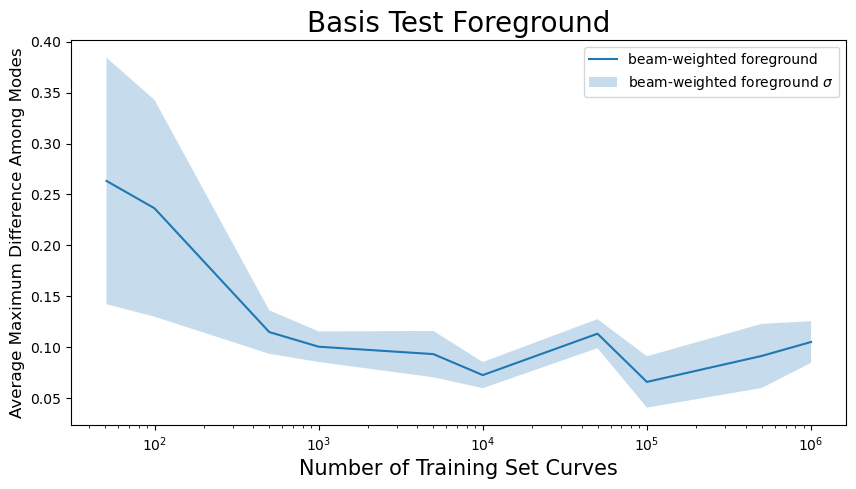

In [947]:
plt.figure(figsize=(10, 5))
plt.plot(average_diff_num_foreground[2], average_diff_num_foreground[0]  ,label = "beam-weighted foreground")
plt.fill_between(average_diff_num_foreground[2], average_diff_num_foreground[0]+average_diff_num_foreground[1]  ,\
    average_diff_num_foreground[0]-average_diff_num_foreground[1]  ,label = r"beam-weighted foreground $\sigma$",alpha=0.25)
plt.title("Basis Test Foreground",fontsize=20)
plt.xlabel("Number of Training Set Curves",fontsize="15")
plt.ylabel("Average Maximum Difference Among Modes",fontsize="12")
plt.xscale("log")
plt.legend()
plt.savefig(save_path+"basis_test_fg_not_using")

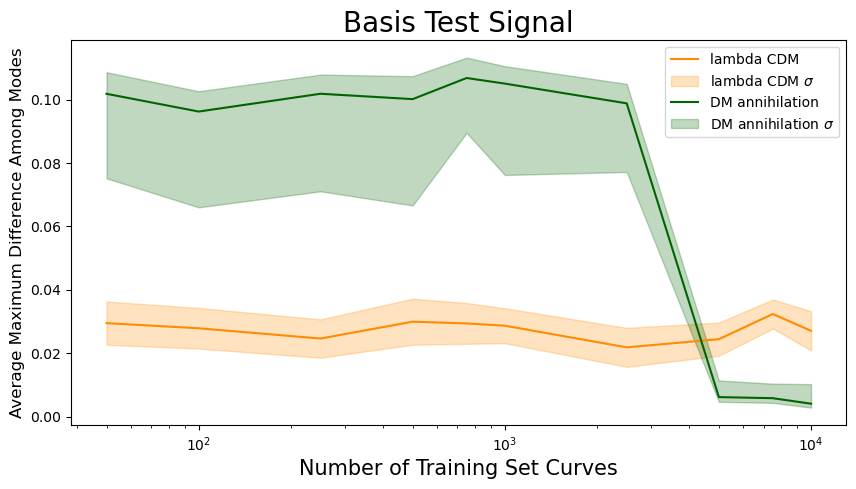

In [946]:
plt.figure(figsize=(10, 5))
plt.plot(average_diff_num_lambdaCDM[2], average_diff_num_lambdaCDM[0]  ,label = "lambda CDM",color="darkorange")
plt.fill_between(average_diff_num_lambdaCDM[2], average_diff_num_lambdaCDM[0]+average_diff_num_lambdaCDM[1],\
    average_diff_num_lambdaCDM[0]-average_diff_num_lambdaCDM[1]  ,label = r"lambda CDM $\sigma$",alpha=0.25,color="darkorange")
plt.plot(average_diff_num_DMAN[2], average_diff_num_DMAN[0]  ,label = "DM annihilation",color="darkgreen")
plt.fill_between(average_diff_num_DMAN[2], average_diff_num_DMAN[0]+average_diff_num_lambdaCDM[1],\
    average_diff_num_DMAN[0]-average_diff_num_DMAN[1]  ,label = r"DM annihilation $\sigma$",alpha=0.25,color="darkgreen")
plt.title("Basis Test Signal",fontsize=20)
plt.xlabel("Number of Training Set Curves",fontsize="15")
plt.ylabel("Average Maximum Difference Among Modes",fontsize="12")
plt.xscale("log")
plt.legend()
plt.savefig(save_path+"basis_test_signals_not_using")

## Example Signal Extraction

  0%|          | 0/176 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 10369.11it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59202418e+01 -2.65279830e+00 -1.37293590e-02  1.66130589e+01
 -2.69062579e+00 -1.47582387e-02  1.89769800e+01 -2.68235795e+00
 -1.34495335e-02  2.42115565e+01 -2.66682587e+00 -1.20169084e-02
  5.22431891e+01 -2.65055339e+00 -2.42275191e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]


100%|██████████| 176/176 [00:01<00:00, 154.15it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60001 ]]


100%|██████████| 500/500 [00:02<00:00, 220.88it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 2/2 [00:00<00:00, 10965.50it/s]


[[ 1.59202338e+01  1.59202498e+01 -2.65279764e+00 -2.65279897e+00
  -1.37293521e-02 -1.37293658e-02]
 [ 1.66130506e+01  1.66130672e+01 -2.69062512e+00 -2.69062646e+00
  -1.47582313e-02 -1.47582461e-02]
 [ 1.89769705e+01  1.89769894e+01 -2.68235727e+00 -2.68235862e+00
  -1.34495268e-02 -1.34495402e-02]
 [ 2.42115444e+01  2.42115686e+01 -2.66682520e+00 -2.66682654e+00
  -1.20169024e-02 -1.20169144e-02]
 [ 5.22431630e+01  5.22432152e+01 -2.65055273e+00 -2.65055405e+00
  -2.42275070e-02 -2.42275312e-02]]
[[ 1.59202338e+01  1.59202498e+01 -2.65279764e+00 -2.65279897e+00
  -1.37293521e-02 -1.37293658e-02]
 [ 1.66130506e+01  1.66130672e+01 -2.69062512e+00 -2.69062646e+00
  -1.47582313e-02 -1.47582461e-02]
 [ 1.89769705e+01  1.89769894e+01 -2.68235727e+00 -2.68235862e+00
  -1.34495268e-02 -1.34495402e-02]
 [ 2.42115444e+01  2.42115686e+01 -2.66682520e+00 -2.66682654e+00
  -1.20169024e-02 -1.20169144e-02]
 [ 5.22431630e+01  5.22432152e+01 -2.65055273e+00 -2.65055405e+00
  -2.42275070e-02 -2.422

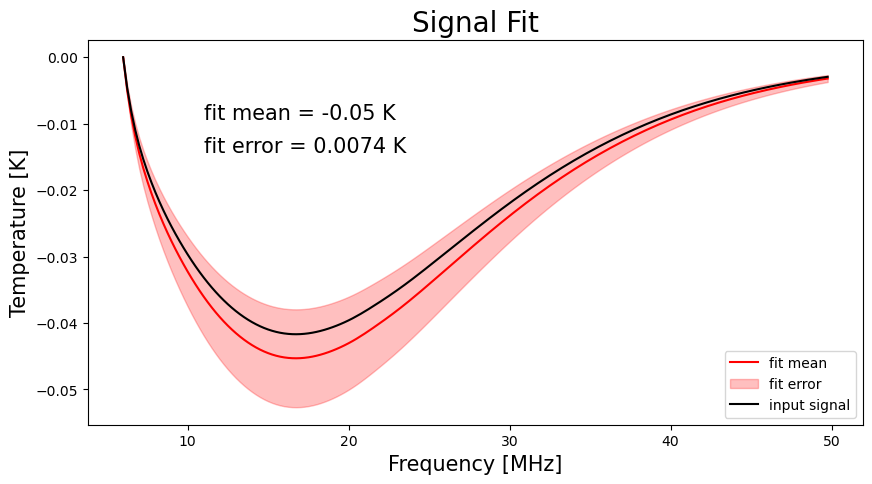

In [ ]:



## Creates a foreground for the simulation:
dt = 10000*3600
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
parameter_variation = [0,0,0]

signal_model = fiducial_signal

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

## Creates a training set with varied foreground and beams:

# custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
parameter_variation = [0.0000005,0.00000025,0.0000005]                           # For making a random foreground

rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 500 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 500
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)


print(fg_range_array)

#### Pylinex Fit #####
fg_training_set = foreground_run_set[3]
sig_training_set = labmdaCDM_training_set
IC = "DIC"
sim_data = simulation_test_beam[0]
noise_level = sigT(sim_data,dnu,dt)
foreground_training_set_array = copy.deepcopy(fg_training_set)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=30,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
signal_basis.generate_gaussian_prior()
foreground_basis.generate_gaussian_prior()
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,30)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension,)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter2.sizes['Foreground']
num_signal_terms = fitter2.sizes['Signal']
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter2.subbasis_channel_mean("Signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter2.subbasis_channel_error("Signal")[np.where(fitter2.subbasis_channel_mean("Signal")==fitter2.subbasis_channel_mean("Signal").min())][0]} Channel error at lowest point of the trough ")
# print(f"{fitter2.log_evidence} log evidence")
print(f"{fitter2.chi_squared} Chi Squared")
print(f"{fitter2.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter2.subbasis_channel_mean("Signal")/simulation_test_beam[2],(fitter2.subbasis_channel_mean("Foreground")-simulation_test_beam[2])/simulation_test_beam[2])
print(f"True {pearsonr}")

plt.figure(figsize=(10, 5))
plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
plt.title("Signal Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
plt.plot(frequencies,simulation_test_beam[1],label="input signal",c="black")
plt.legend()
plt.savefig(save_path+"Example_extraction")

In [49]:
curves_100

<HDF5 dataset "beam_weighted_curves": shape (100, 176), type "<f8">

## Bias (Going to Need to Cook)


In [5]:
# # This creates your 100 random beam-weighted foregrounds
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground

# # signal_model = signal_model_set[signal][Nsim*i+nsim]

# ## Interpolate the varied beams to match the rest of the data
# varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
# for n in range(len(varied_regolith_training_set_raw)):
#     beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
#     varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
# Nb = 10 # number of beams in the beam training set
# exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
#                             custom_parameter_range,show_parameter_ranges=False)

# BTS_curves = exp_test[0]
# BTS_params = exp_test[1]
# beam_sky_training_set = beams[:,5:,:]
# beam_sky_training_set_params = varied_regolith_training_set_raw_params
# raw_beam_weighted_sky_maps = raw_sky_maps
# Nfg = 10
# determine_parameter_range = True
# new_FG_parameter_mean = None
# foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
#                                     beam_sky_training_set,beam_sky_training_set_params,Nfg,parameter_variation, B_value_functions,\
#                                         define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)

# # plots the 100 random bwfg
# for n in range(100):
#     plt.plot((foreground_run[3][n]-simulation_test_beam[0])/simulation_test_beam[0])

# new_parameter_mean = np.zeros((n_regions,3))
# fg_range_array_random_10 = np.zeros((n_regions,6))
# foreground_parameter_variation = np.array(parameter_variation)
# for r in range(n_regions):
#     new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
#     # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
#     fg_range_array_random_10[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
#     fg_range_array_random_10[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
#     fg_range_array_random_10[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
#     fg_range_array_random_10[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
#     fg_range_array_random_10[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
#     fg_range_array_random_10[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


###This creates a training set for each of the randomly created beam-weighted foregrounds

# HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","w")
# hdf5.create_dataset("beam_weighted_curves",data=foreground_run[3])
# hdf5.create_dataset("beam_weighted_parameters",data=foreground_run[4])
# hdf5.close()
# End of HDF5 data saving
Nb = 10
Nfg=10
# # # ## HDF5 loading of 100 bw foreground
# # hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
# # curves_100 = hdf5["beam_weighted_curves"]
# # curves_100_params = hdf5["beam_weighted_parameters"]
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
curves_100 = hdf5["beam_weighted_curves"]
curves_100_params = hdf5["beam_weighted_parameters"]
# # when we made curves 100, we were willing to do 100 foregrounds, but now I realize that takes too much data
# # curves_10 = curves_100[[0,11,22,33,44,55,66,77,88,99]]  
# # curves_10_params = curves_100_params[[0,11,22,33,44,55,66,77,88,99]]  
# ## HDF5 loading end

custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
custom_parameter_range_variation = [0.000025, 0.00001,0.00001]
parameter_variation = [0.0000005,0.00000025,0.0000005]  

custom_parameter_range_array = np.zeros((Nb,3,2))
foreground_means = np.zeros((Nfg,n_regions,3))
for n in range(Nfg):
    for r in range(n_regions):
        foreground_means[n][r] = curves_100_params[n][r*3:r*3+3]

for n in range(Nb):
    custom_parameter_range_array[n]=[[curves_100_params[n*10][15]-curves_100_params[n*10][15]*custom_parameter_range_variation[0],curves_100_params[n*10][15]+curves_100_params[n*10][15]*custom_parameter_range_variation[0]],\
                                [curves_100_params[n*10][16]-curves_100_params[n*10][16]*custom_parameter_range_variation[1],curves_100_params[n*10][16]+curves_100_params[n*10][16]*custom_parameter_range_variation[1]],\
                                [curves_100_params[n*10][17]-curves_100_params[n*10][17]*custom_parameter_range_variation[2],curves_100_params[n*10][17]+curves_100_params[n*10][16]*custom_parameter_range_variation[2]]]

dt = 10000*3600  # integration time
N = 100000  # number of curves in the training set
Nb = int(np.sqrt(N))
Nfg = int(np.sqrt(N))
curves_100_training_sets = np.zeros((len(curves_100),Nfg*Nb,len(frequencies)))
curves_100_training_set_parameters = np.zeros((len(curves_100),Nfg*Nb,len(foreground_run[4][0])))

for nb,beam_params in enumerate(custom_parameter_range_array):
    for nfg,mean in enumerate(foreground_means):
## Creates a foreground for the simulation:

    # For making a random foreground

    ## Interpolate the varied beams to match the rest of the data
        custom_parameter_range = beam_params
        parameter_variation = [0.0000005,0.00000025,0.0000005] 
        varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
        for n in range(len(varied_regolith_training_set_raw)):
            beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
            varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
        Nb = int(np.sqrt(N)) # number of beams in the beam training set
        exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                                    custom_parameter_range,show_parameter_ranges=False)

        BTS_curves = exp_test[0]
        BTS_params = exp_test[1]
        beam_sky_training_set = beams[:,5:,:]
        beam_sky_training_set_params = varied_regolith_training_set_raw_params
        raw_beam_weighted_sky_maps = raw_sky_maps
        Nfg = int(np.sqrt(N))
        determine_parameter_range = False
        new_FG_parameter_mean = mean
        foreground_run_ts = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                            beam_sky_training_set,beam_sky_training_set_params,Nfg,parameter_variation, B_value_functions,\
                                                define_parameter_mean=True,parameter_mean=new_FG_parameter_mean)

        new_parameter_mean = np.zeros((n_regions,3))
        fg_range_array = np.zeros((n_regions,6))
        foreground_parameter_variation = np.array(parameter_variation)
        for r in range(n_regions):
            new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
            # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
            fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
            fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
            fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
            fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
            fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
            fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]

        curves_100_training_sets[nfg+len(foreground_means)*nb] = foreground_run_ts[3]
        curves_100_training_set_parameters[nfg+len(foreground_means)*nb] = foreground_run_ts[4]

# HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims_ts_100000","w")
hdf5.create_dataset("curves_training_set",data=curves_100_training_sets)
hdf5.create_dataset("curves_training_set_parameters",data=curves_100_training_set_parameters)
hdf5.close()
# End of HDF5 data saving

# HDF5 loading of 10 bw foreground training sets (10,000 curves each)
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_10_sims_ts","r")
# curves_10_training_sets = hdf5["curves_training_set"]
# curves_10_training_sets_parameters = hdf5["curves_training_set_parameters"]
# HDF5 loading end

# HDF5 loading of 100 bw foreground training sets (1,000 curves each)
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims_ts_100000","r")
curves_100_training_sets = hdf5["curves_training_set"]
curves_100_training_sets_parameters = hdf5["curves_training_set_parameters"]
# HDF5 loading end

# Curves array is shaped as follows:
# one entry per signal model (1 fiducial + 5 exotic)
# one entry per varied simulation (Nsim)
# 5 entries for different data: 0: full simulation, 1: only the signal, 2: only the foreground, 3: only the noise, 4: simulation without noise
# then the frequency array

Nsim = 1000
signal_models = ["lambdaCDM","DMAN","DMD","EDE","ERB","MCDM"]
signal_model_set = {"lambdaCDM": lambdaCDM_training_set, "DMAN": DMAN_training_set, "DMD": DMD_training_set, "EDE": EDE_training_set, "ERB": ERB_training_set, "MCDM": MCDM_training_set}
signal_parameter_set = {"lambdaCDM": lambdaCDM_training_set_params, "DMAN": DMAN_training_set_params, "DMD": DMD_training_set_params, "EDE": EDE_training_set_params, "ERB": ERB_training_set_params, "MCDM": MCDM_training_set_params}
simulation_curves_array = np.zeros((Nsim*len(signal_models),5,len(frequencies))) 
simulation_parameters_array = {}

# these expanded curves make working with the signal models a bit easier
curves_100_expanded = curves_100
for n in range(9):   # NOT GENERAL only works because we have 100 times as many singal models as foreround models
        curves_100_expanded = np.concatenate((curves_100_expanded,curves_100),axis=0)

curves_100_params_expanded = curves_100_params
for n in range(9):   # NOT GENERAL only works because we have 100 times as many singal models as foreround models
        curves_100_params_expanded = np.concatenate((curves_100_params_expanded,curves_100_params),axis=0)

for i,signal in enumerate(signal_models): 
    for nsim,bwfg,par in zip(range(Nsim),curves_100_expanded,curves_100_params_expanded):
        signal_model = signal_model_set[signal][Nsim*i+nsim]
        foreground_for_sim = bwfg
        parameters_for_sim = par

# Our simulation function
        simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

        simulation_curves_array[Nsim*i+nsim][0] = simulation_test_beam[0]
        simulation_curves_array[Nsim*i+nsim][1] = simulation_test_beam[1]
        simulation_curves_array[Nsim*i+nsim][2] = simulation_test_beam[2]
        simulation_curves_array[Nsim*i+nsim][3] = simulation_test_beam[3]
        simulation_curves_array[Nsim*i+nsim][4] = simulation_test_beam[4]

        simulation_parameters_array[Nsim*i+nsim] = {"bwfg": parameters_for_sim, "signal": signal_parameter_set[signal][Nsim*i+nsim]}


Nsim_tot = len(simulation_curves_array)
bias_scores = np.zeros((len(signal_models),Nsim))

for si,s in enumerate(signal_models):
        for n in tqdm(range (Nsim)):

#### Pylinex Fit #####
                foreground_training_set_array = curves_100_training_sets[n % 100]  # this index convention only works if there are 10 foregrounds and some multiple of 100 signals (such as 1000)
                signal_model_number = s  # Only works when you have 1000 signals of the same model
                model = s
                print(model)
                sig_training_set = signal_model_set[model]
                IC = "DIC"
                sim = simulation_curves_array[n+Nsim*si]
                sim_data = sim[0]
                true_curve = sim[1]
                noise_level = sigT(sim_data,dnu,dt)
                foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
                signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
                temperatures = sim_data
                basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
                quantity = AttributeQuantity(IC)
                dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
                # priors = {"Signal_prior" : signal_basis.gaussian_prior}
                meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
                fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
                num_foreground_terms = fitter2.sizes['Foreground']
                num_signal_terms = fitter2.sizes['Signal']
                print(f"foreground_terms = {num_foreground_terms}")
                print(f"signal_terms = {num_signal_terms}")
                bias_scores[si][n] = fitter2.subbasis_bias_statistic("Signal",true_curve,norm_by_dof=True)
                print(fitter2.subbasis_bias_statistic("Signal",true_curve,norm_by_dof=True))

        
# # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/bias_scores_100000","w")
# hdf5.create_dataset("bias_scores",data=bias_scores)
# hdf5.close()
# End of HDF5 data saving
        

        # print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
        # print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
        # print(f"{fitter2.subbasis_channel_mean("Signal").min()} Temperature of lowest point of the trough ")
        # print(f"{fitter2.subbasis_channel_error("Signal")[np.where(fitter2.subbasis_channel_mean("Signal")==fitter2.subbasis_channel_mean("Signal").min())][0]} Channel error at lowest point of the trough ")
        # # print(f"{fitter2.log_evidence} log evidence")
        # print(f"{fitter2.chi_squared} Chi Squared")
        # print(f"{fitter2.psi_squared} Psi Squared")
        # pearsonr=scipy.stats.pearsonr(fitter2.subbasis_channel_mean("Signal")/simulation_test_beam[2],(fitter2.subbasis_channel_mean("Foreground")-simulation_test_beam[2])/simulation_test_beam[2])
        # print(f"True {pearsonr}")

                # plt.figure(figsize=(10, 5))
                # plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
                # plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
                # plt.title("Signal Fit",fontsize=20)
                # plt.xlabel("Frequency [MHz]",fontsize="15")
                # plt.ylabel("Temperature [K]",fontsize="15")
                # plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
                # plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
                # plt.plot(frequencies,sim[1],label="input signal",c="black")
                # plt.legend()
                # plt.show()
        # plt.savefig(save_path+"Example_extraction")


  0%|          | 0/176 [00:00<?, ?it/s]

100%|██████████| 316/316 [00:00<00:00, 411.68it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 228.72it/s]


KeyboardInterrupt: 

In [6]:
#this is alternative code for creating a single very large training set

custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
custom_parameter_range_variation = [0.000025, 0.00001,0.00001]
parameter_variation = [0.0000005,0.00000025,0.0000005]  
Nfg=10
Nb=10
custom_parameter_range_array = np.zeros((Nb,3,2))
foreground_means = np.zeros((Nfg,n_regions,3))
for n in range(Nfg):
    for r in range(n_regions):
        foreground_means[n][r] = curves_100_params[n][r*3:r*3+3]

for n in range(Nb):
    custom_parameter_range_array[n]=[[curves_100_params[n*10][15]-curves_100_params[n*10][15]*custom_parameter_range_variation[0],curves_100_params[n*10][15]+curves_100_params[n*10][15]*custom_parameter_range_variation[0]],\
                                [curves_100_params[n*10][16]-curves_100_params[n*10][16]*custom_parameter_range_variation[1],curves_100_params[n*10][16]+curves_100_params[n*10][16]*custom_parameter_range_variation[1]],\
                                [curves_100_params[n*10][17]-curves_100_params[n*10][17]*custom_parameter_range_variation[2],curves_100_params[n*10][17]+curves_100_params[n*10][16]*custom_parameter_range_variation[2]]]

dt = 10000*3600  # integration time
N = 5000000  # number of curves in the training set
Nb = int(np.sqrt(N))
Nfg = int(np.sqrt(N))
curves_100_training_sets = np.zeros((Nfg*Nb,len(frequencies)))
curves_100_training_set_parameters = np.zeros((Nfg*Nb,len(foreground_run[4][0])))

nb=0
beam_params = custom_parameter_range_array[0]
nfg=0
mean = foreground_means[0]
## Creates a foreground for the simulation:

# For making a random foreground

## Interpolate the varied beams to match the rest of the data
custom_parameter_range = beam_params
parameter_variation = [0.0000005,0.00000025,0.0000005] 
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = int(np.sqrt(N)) # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                            custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
Nfg = int(np.sqrt(N))
determine_parameter_range = False
new_FG_parameter_mean = mean
foreground_run_ts = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,Nfg,parameter_variation, B_value_functions,\
                                        define_parameter_mean=True,parameter_mean=new_FG_parameter_mean)

new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]

curves_100_training_sets_5mil = foreground_run_ts[3]
curves_100_training_set_parameters_5mil = foreground_run_ts[4]

# HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_single_sims_ts_5mil_2","w")
hdf5.create_dataset("curves_training_set",data=curves_100_training_sets_5mil)
hdf5.create_dataset("curves_training_set_parameters",data=curves_100_training_set_parameters_5mil)
hdf5.close()
# End of HDF5 data saving

100%|██████████| 2236/2236 [00:38<00:00, 58.47it/s]


[5e-07, 2.5e-07, 5e-07]


In [13]:
## Code for running my own bias function

bias_function = lambda frequencies,model_curve, fit_curve, noise: np.sqrt(1/len(frequencies)*(((model_curve-fit_curve)**2)/noise**2).sum())

In [26]:
bias_function (frequencies[10:150],sim[1][10:150],fitter2.subbasis_channel_mean("Signal")[10:150],fitter2.subbasis_channel_error("Signal")[10:150])

0.9151397687279235

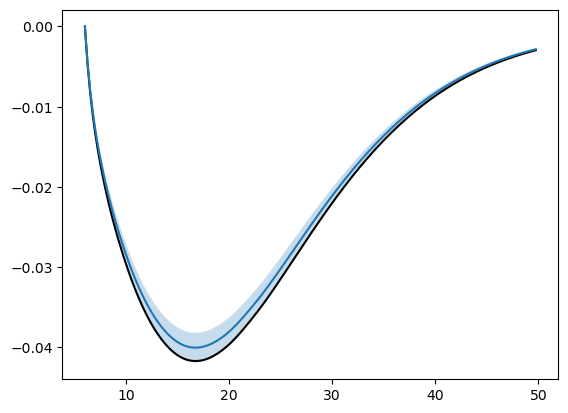

In [25]:
plt.plot(frequencies,sim[1],c="black")
plt.plot(frequencies,fitter2.subbasis_channel_mean("Signal"))
plt.fill_between(frequencies,fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),alpha=0.25)

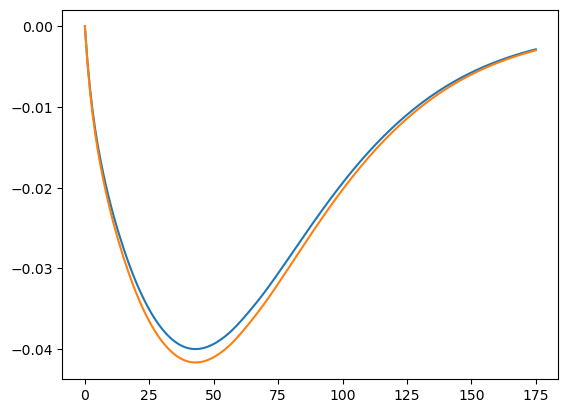

In [24]:
plt.plot(fitter2.subbasis_channel_mean("Signal"))
plt.plot(sim[1])

In [ ]:
### this is a separate cell for running the 5mil single fg training set.

# # This creates your 100 random beam-weighted foregrounds
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground

# # signal_model = signal_model_set[signal][Nsim*i+nsim]

# ## Interpolate the varied beams to match the rest of the data
# varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
# for n in range(len(varied_regolith_training_set_raw)):
#     beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
#     varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
# Nb = 10 # number of beams in the beam training set
# exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
#                             custom_parameter_range,show_parameter_ranges=False)

# BTS_curves = exp_test[0]
# BTS_params = exp_test[1]
# beam_sky_training_set = beams[:,5:,:]
# beam_sky_training_set_params = varied_regolith_training_set_raw_params
# raw_beam_weighted_sky_maps = raw_sky_maps
# Nfg = 10
# determine_parameter_range = True
# new_FG_parameter_mean = None
# foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
#                                     beam_sky_training_set,beam_sky_training_set_params,Nfg,parameter_variation, B_value_functions,\
#                                         define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)

# # plots the 100 random bwfg
# for n in range(100):
#     plt.plot((foreground_run[3][n]-simulation_test_beam[0])/simulation_test_beam[0])

# new_parameter_mean = np.zeros((n_regions,3))
# fg_range_array_random_10 = np.zeros((n_regions,6))
# foreground_parameter_variation = np.array(parameter_variation)
# for r in range(n_regions):
#     new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
#     # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
#     fg_range_array_random_10[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
#     fg_range_array_random_10[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
#     fg_range_array_random_10[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
#     fg_range_array_random_10[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
#     fg_range_array_random_10[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
#     fg_range_array_random_10[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


###This creates a training set for each of the randomly created beam-weighted foregrounds

# HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","w")
# hdf5.create_dataset("beam_weighted_curves",data=foreground_run[3])
# hdf5.create_dataset("beam_weighted_parameters",data=foreground_run[4])
# hdf5.close()
# # End of HDF5 data saving
# Nb = 10
# Nfg=10
# # # # ## HDF5 loading of 100 bw foreground
# # # hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
# # # curves_100 = hdf5["beam_weighted_curves"]
# # # curves_100_params = hdf5["beam_weighted_parameters"]
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
# curves_100 = hdf5["beam_weighted_curves"]
# curves_100_params = hdf5["beam_weighted_parameters"]
# # when we made curves 100, we were willing to do 100 foregrounds, but now I realize that takes too much data
# # curves_10 = curves_100[[0,11,22,33,44,55,66,77,88,99]]  
# # curves_10_params = curves_100_params[[0,11,22,33,44,55,66,77,88,99]]  
# ## HDF5 loading end

# custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
# custom_parameter_range_variation = [0.000025, 0.00001,0.00001]
# parameter_variation = [0.0000005,0.00000025,0.0000005]  

# custom_parameter_range_array = np.zeros((Nb,3,2))
# foreground_means = np.zeros((Nfg,n_regions,3))
# for n in range(Nfg):
#     for r in range(n_regions):
#         foreground_means[n][r] = curves_100_params[n][r*3:r*3+3]

# for n in range(Nb):
#     custom_parameter_range_array[n]=[[curves_100_params[n*10][15]-curves_100_params[n*10][15]*custom_parameter_range_variation[0],curves_100_params[n*10][15]+curves_100_params[n*10][15]*custom_parameter_range_variation[0]],\
#                                 [curves_100_params[n*10][16]-curves_100_params[n*10][16]*custom_parameter_range_variation[1],curves_100_params[n*10][16]+curves_100_params[n*10][16]*custom_parameter_range_variation[1]],\
#                                 [curves_100_params[n*10][17]-curves_100_params[n*10][17]*custom_parameter_range_variation[2],curves_100_params[n*10][17]+curves_100_params[n*10][16]*custom_parameter_range_variation[2]]]

# dt = 10000*3600  # integration time
# N = 100000  # number of curves in the training set
# Nb = int(np.sqrt(N))
# Nfg = int(np.sqrt(N))
# curves_100_training_sets = np.zeros((len(curves_100),Nfg*Nb,len(frequencies)))
# curves_100_training_set_parameters = np.zeros((len(curves_100),Nfg*Nb,len(foreground_run[4][0])))

# for nb,beam_params in enumerate(custom_parameter_range_array):
#     for nfg,mean in enumerate(foreground_means):
# ## Creates a foreground for the simulation:

#     # For making a random foreground

#     ## Interpolate the varied beams to match the rest of the data
#         custom_parameter_range = beam_params
#         parameter_variation = [0.0000005,0.00000025,0.0000005] 
#         varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
#         for n in range(len(varied_regolith_training_set_raw)):
#             beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
#             varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
#         Nb = int(np.sqrt(N)) # number of beams in the beam training set
#         exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
#                                     custom_parameter_range,show_parameter_ranges=False)

#         BTS_curves = exp_test[0]
#         BTS_params = exp_test[1]
#         beam_sky_training_set = beams[:,5:,:]
#         beam_sky_training_set_params = varied_regolith_training_set_raw_params
#         raw_beam_weighted_sky_maps = raw_sky_maps
#         Nfg = int(np.sqrt(N))
#         determine_parameter_range = False
#         new_FG_parameter_mean = mean
#         foreground_run_ts = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
#                                             beam_sky_training_set,beam_sky_training_set_params,Nfg,parameter_variation, B_value_functions,\
#                                                 define_parameter_mean=True,parameter_mean=new_FG_parameter_mean)

#         new_parameter_mean = np.zeros((n_regions,3))
#         fg_range_array = np.zeros((n_regions,6))
#         foreground_parameter_variation = np.array(parameter_variation)
#         for r in range(n_regions):
#             new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
#             # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
#             fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
#             fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
#             fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
#             fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
#             fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
#             fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]

#         curves_100_training_sets[nfg+len(foreground_means)*nb] = foreground_run_ts[3]
#         curves_100_training_set_parameters[nfg+len(foreground_means)*nb] = foreground_run_ts[4]

# # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims_ts_100000","w")
# hdf5.create_dataset("curves_training_set",data=curves_100_training_sets)
# hdf5.create_dataset("curves_training_set_parameters",data=curves_100_training_set_parameters)
# hdf5.close()
# # End of HDF5 data saving

# HDF5 loading of 10 bw foreground training sets (10,000 curves each)
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_10_sims_ts","r")
# curves_10_training_sets = hdf5["curves_training_set"]
# curves_10_training_sets_parameters = hdf5["curves_training_set_parameters"]
# HDF5 loading end
bias_function = lambda frequencies,model_curve, fit_curve, noise: np.sqrt(1/len(frequencies)*(((model_curve-fit_curve)**2)/noise**2).sum())
# HDF5 loading of 1 bw foreground training sets (5mil curves each)
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_single_sims_ts_5mil","r")
curves_100_training_sets = hdf5["curves_training_set"]
curves_100_training_sets_parameters = hdf5["curves_training_set_parameters"]
# HDF5 loading end

# foreground_basis = TrainedBasis(training_set=curves_100_training_sets, num_basis_vectors=100,error=noise_level)

# # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/trained_basis_5mil","w")
# hdf5.create_dataset("foreground_basis",data=foreground_basis)
# hdf5.close()
# # End of HDF5 data saving

# Curves array is shaped as follows:
# one entry per signal model (1 fiducial + 5 exotic)
# one entry per varied simulation (Nsim)
# 5 entries for different data: 0: full simulation, 1: only the signal, 2: only the foreground, 3: only the noise, 4: simulation without noise
# then the frequency array

Nsim = 1000
signal_models = ["lambdaCDM","DMAN","DMD","EDE","ERB","MCDM"]
signal_model_set = {"lambdaCDM": lambdaCDM_training_set, "DMAN": DMAN_training_set, "DMD": DMD_training_set, "EDE": EDE_training_set, "ERB": ERB_training_set, "MCDM": MCDM_training_set}
signal_parameter_set = {"lambdaCDM": lambdaCDM_training_set_params, "DMAN": DMAN_training_set_params, "DMD": DMD_training_set_params, "EDE": EDE_training_set_params, "ERB": ERB_training_set_params, "MCDM": MCDM_training_set_params}
simulation_curves_array = np.zeros((Nsim*len(signal_models),5,len(frequencies))) 
simulation_parameters_array = {}

Nb = 10
Nfg=10
# # # ## HDF5 loading of 100 bw foreground
# # hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
# # curves_100 = hdf5["beam_weighted_curves"]
# # curves_100_params = hdf5["beam_weighted_parameters"]
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
curves_100 = hdf5["beam_weighted_curves"]
curves_100_params = hdf5["beam_weighted_parameters"]

noise_level = sigT(curves_100[0],dnu,dt)

hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_single_sims_ts_5mil","r")
curves_100_training_sets = hdf5["curves_training_set"]
curves_100_training_sets_parameters = hdf5["curves_training_set_parameters"]
# HDF5 loading end

# foreground_basis = TrainedBasis(training_set=curves_100_training_sets, num_basis_vectors=100,error=noise_level)

# # these expanded curves make working with the signal models a bit easier
# curves_100_expanded = curves_100
# for n in range(9):   # NOT GENERAL only works because we have 100 times as many singal models as foreround models
#         curves_100_expanded = np.concatenate((curves_100_expanded,curves_100),axis=0)

# curves_100_params_expanded = curves_100_params
# for n in range(9):   # NOT GENERAL only works because we have 100 times as many singal models as foreround models
#         curves_100_params_expanded = np.concatenate((curves_100_params_expanded,curves_100_params),axis=0)

foreground_for_sim = curves_100[0]
parameters_for_sim = curves_100_params[0]
for i,signal in enumerate(signal_models): 
    bwfg = curves_100[0]
    par = curves_100_params[0]
    for nsim in range(Nsim):
        signal_model = signal_model_set[signal][Nsim*i+nsim]

# Our simulation function
        simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

        simulation_curves_array[Nsim*i+nsim][0] = simulation_test_beam[0]
        simulation_curves_array[Nsim*i+nsim][1] = simulation_test_beam[1]
        simulation_curves_array[Nsim*i+nsim][2] = simulation_test_beam[2]
        simulation_curves_array[Nsim*i+nsim][3] = simulation_test_beam[3]
        simulation_curves_array[Nsim*i+nsim][4] = simulation_test_beam[4]

        simulation_parameters_array[Nsim*i+nsim] = {"bwfg": parameters_for_sim, "signal": signal_parameter_set[signal][Nsim*i+nsim]}


Nsim_tot = len(simulation_curves_array)
bias_scores = np.zeros((len(signal_models),Nsim))

for si,s in enumerate(signal_models):
        for n in tqdm(range (Nsim)):

#### Pylinex Fit #####
                signal_model_number = s  # Only works when you have 1000 signals of the same model
                model = s
                print(model)
                sig_training_set = signal_model_set[model]
                IC = "DIC"
                sim = simulation_curves_array[n+Nsim*si]
                sim_data = sim[0]
                true_curve = sim[1]
                noise_level = sigT(sim_data,dnu,dt)
                signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
                temperatures = sim_data
                basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
                quantity = AttributeQuantity(IC)
                dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
                # priors = {"Signal_prior" : signal_basis.gaussian_prior}
                meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
                fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
                num_foreground_terms = fitter2.sizes['Foreground']
                num_signal_terms = fitter2.sizes['Signal']
                print(f"foreground_terms = {num_foreground_terms}")
                print(f"signal_terms = {num_signal_terms}")
                # only works for our specific frequency range right now, but I'm in a rush so sue me.
                bias_statistic = bias_function (frequencies[10:150],sim[1][10:150],fitter2.subbasis_channel_mean("Signal")[10:150],\
                                                    fitter2.subbasis_channel_error("Signal")[10:150])
                bias_scores[si][n] = bias_statistic
                print(bias_statistic)

        
# # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/bias_scores_5mil_1fg","w")
# hdf5.create_dataset("bias_scores",data=bias_scores)
# hdf5.close()
# End of HDF5 data saving

# HDF5 loading of 10 bw foreground training sets (10,000 curves each)
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/bias_scores_5mil_1fg","r")
bias_scores = hdf5["bias_scores"]
# HDF5 loading end
        

        # print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
        # print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
        # print(f"{fitter2.subbasis_channel_mean("Signal").min()} Temperature of lowest point of the trough ")
        # print(f"{fitter2.subbasis_channel_error("Signal")[np.where(fitter2.subbasis_channel_mean("Signal")==fitter2.subbasis_channel_mean("Signal").min())][0]} Channel error at lowest point of the trough ")
        # # print(f"{fitter2.log_evidence} log evidence")
        # print(f"{fitter2.chi_squared} Chi Squared")
        # print(f"{fitter2.psi_squared} Psi Squared")
        # pearsonr=scipy.stats.pearsonr(fitter2.subbasis_channel_mean("Signal")/simulation_test_beam[2],(fitter2.subbasis_channel_mean("Foreground")-simulation_test_beam[2])/simulation_test_beam[2])
        # print(f"True {pearsonr}")

                # plt.figure(figsize=(10, 5))
                # plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
                # plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
                # plt.title("Signal Fit",fontsize=20)
                # plt.xlabel("Frequency [MHz]",fontsize="15")
                # plt.ylabel("Temperature [K]",fontsize="15")
                # plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
                # plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
                # plt.plot(frequencies,sim[1],label="input signal",c="black")
                # plt.legend()
                # plt.show()
        # plt.savefig(save_path+"Example_extraction")


  0%|          | 2/1000 [00:00<01:13, 13.56it/s]

lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.847036019192407
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5120974270742886
lambdaCDM


  0%|          | 4/1000 [00:00<01:08, 14.52it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7139956002693615
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3183147473204544
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8752006904892826
lambdaCDM


  1%|          | 8/1000 [00:00<01:10, 14.07it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1148658086481604
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6643371182651217
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8574544837249392
lambdaCDM


  1%|          | 10/1000 [00:00<01:11, 13.87it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.2015198002992378
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.1588337883509916
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
3.3372054579025194
lambdaCDM


  1%|▏         | 14/1000 [00:01<01:12, 13.51it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.1324072010605255
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4419695915044652
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.008638288698551
lambdaCDM


  2%|▏         | 16/1000 [00:01<01:08, 14.31it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.9273530874050437
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.8079848299792498
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.3651218007622608
lambdaCDM


  2%|▏         | 20/1000 [00:01<01:10, 13.91it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.9089440490847378
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.32589732512369474
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.38096012290703996
lambdaCDM


  2%|▏         | 22/1000 [00:01<01:11, 13.64it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.207229235399874
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.23104740006792854
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
1.2554573488613423
lambdaCDM


  3%|▎         | 26/1000 [00:01<01:10, 13.77it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.23583322299193638
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3929674083695014
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1505519867400917
lambdaCDM


  3%|▎         | 28/1000 [00:02<01:11, 13.65it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2030165311341194
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.5518832392843662
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.069581487650806
lambdaCDM


  3%|▎         | 32/1000 [00:02<01:08, 14.21it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0139482633420362
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.47669912229908373
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7669197854749157
lambdaCDM


  4%|▎         | 36/1000 [00:02<01:06, 14.51it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
2.288659171096147
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.8272137292528539
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7119714638870979
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.26828345870740616
lambdaCDM


  4%|▍         | 40/1000 [00:02<01:06, 14.49it/s]

Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 4
3.9273928021018896
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8201558969999636
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.814570884944944
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 4
0.7165975428165995
lambdaCDM


  4%|▍         | 42/1000 [00:02<01:05, 14.60it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.4552747505392756
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.7317947344898121
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.3378704062440647
lambdaCDM


  5%|▍         | 46/1000 [00:03<01:07, 14.09it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1369614106555053
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6309309243005861
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.09854756638618827
lambdaCDM


  5%|▍         | 48/1000 [00:03<01:10, 13.56it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.097971062098538
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.750465921640576
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.445125997248949
lambdaCDM


  5%|▌         | 52/1000 [00:03<01:10, 13.46it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.13991182440710687
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4025190193604584
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2040186369775991
lambdaCDM


  6%|▌         | 56/1000 [00:04<01:06, 14.12it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.26709444252715797
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0181185726666566
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.325488420367377
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.1600052489873296
lambdaCDM


  6%|▌         | 58/1000 [00:04<01:06, 14.23it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1726133570135915
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1595423641551605
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.24922093793818328
lambdaCDM


  6%|▌         | 62/1000 [00:04<01:08, 13.76it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8020168352815471
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0240014711113465
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5809133668513645
lambdaCDM


  6%|▋         | 64/1000 [00:04<01:05, 14.24it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.1424521084447434
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.2548217330685416
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.0905699546497303
lambdaCDM


  7%|▋         | 68/1000 [00:04<01:06, 14.03it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.47792071645868517
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5708112450026005
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0387380847935883
lambdaCDM


  7%|▋         | 72/1000 [00:05<01:03, 14.64it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.566917858677067
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.09931766562924067
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.223059966378307
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 3
1.8093687149834854
lambdaCDM


  8%|▊         | 76/1000 [00:05<01:01, 14.95it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
2.490032264712934
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7106085678773187
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 1
0.8412330716161437
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4129111487186043
lambdaCDM


  8%|▊         | 80/1000 [00:05<00:59, 15.36it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5174362935317589
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6430867665009138
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.345058515260258
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 7
1.3374092180845405
lambdaCDM


  8%|▊         | 82/1000 [00:05<01:00, 15.18it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1842673317391779
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4742059805496475
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.38341609644157815
lambdaCDM


  9%|▊         | 86/1000 [00:06<01:02, 14.57it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.8598914022258022
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.9052779819693944
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0880343233873409
lambdaCDM


  9%|▉         | 90/1000 [00:06<01:01, 14.71it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.0525209573191425
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.46132170231376374
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 6
1.5257988470022767
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.7175840939724507
lambdaCDM


  9%|▉         | 94/1000 [00:06<01:01, 14.78it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.5550014174314681
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.19814489305631358
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1081959056078199
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.905981428893297
lambdaCDM


 10%|▉         | 96/1000 [00:06<01:00, 14.96it/s]

Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
3.0361559600138364
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.38137514848739107
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
3.467262222937112
lambdaCDM


 10%|█         | 100/1000 [00:07<01:05, 13.80it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.31903821318736936
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.092548410251686
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7716757116847239
lambdaCDM


 10%|█         | 102/1000 [00:07<01:05, 13.80it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.1621257785258352
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1080907872234154
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.03317618030822291
lambdaCDM


 11%|█         | 106/1000 [00:07<01:04, 13.89it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.7959052972030407
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.1174822348430204
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.07857693493320975
lambdaCDM


 11%|█         | 108/1000 [00:07<01:05, 13.52it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
2.3511917130899493
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.07369498113607065
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1118444686952016
lambdaCDM


 11%|█         | 112/1000 [00:07<01:02, 14.10it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
3.3033057987435033
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.5529075371713776
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6801158173492138
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7905991576750423
lambdaCDM


 12%|█▏        | 116/1000 [00:08<01:04, 13.81it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.9222871549486253
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9239852268107303
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 4
3.0237510977320246
lambdaCDM


 12%|█▏        | 118/1000 [00:08<01:04, 13.69it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8178210838037864
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.3786519705871316
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.7209539181352644
lambdaCDM


 12%|█▏        | 122/1000 [00:08<01:03, 13.80it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.2903226370830385
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1904334502815563
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6995836078163424
lambdaCDM


 12%|█▏        | 124/1000 [00:08<01:04, 13.53it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9410938408456323
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.15165898836760364
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.901582644544035
lambdaCDM


 13%|█▎        | 128/1000 [00:09<01:01, 14.13it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.08196100145720209
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.739081960722397
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.10556745955000647
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.36525701868095
lambdaCDM


 13%|█▎        | 132/1000 [00:09<00:59, 14.49it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
1.8009530173572934
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.1346464684855504
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4046559389132788
lambdaCDM


 13%|█▎        | 134/1000 [00:09<01:00, 14.23it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 3
2.4603591073711435
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.45292422295204443
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.194542826848757
lambdaCDM


 14%|█▍        | 138/1000 [00:09<01:00, 14.31it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.4929017190297658
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
1.0752636115920853
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.406728927276309
lambdaCDM


 14%|█▍        | 140/1000 [00:09<01:01, 14.02it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.7385432169924582
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6690275409688518
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.694771731135431
lambdaCDM


 14%|█▍        | 144/1000 [00:10<01:03, 13.54it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.8552832993758512
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.1868793128286197
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.641521610873773
lambdaCDM


 15%|█▍        | 146/1000 [00:10<00:59, 14.26it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.27180265991918096
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 6
0.370787544988321
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3819846496099715
lambdaCDM


 15%|█▌        | 150/1000 [00:10<01:03, 13.48it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.24146801129021989
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.023937455269826286
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.63499141113532
lambdaCDM


 15%|█▌        | 152/1000 [00:10<01:04, 13.05it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3966755279797745
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.24183059691565537
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7587816541951353
lambdaCDM


 16%|█▌        | 156/1000 [00:11<01:03, 13.36it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0935838023462507
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
1.603796905749838
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.061366734530844
lambdaCDM


 16%|█▌        | 158/1000 [00:11<01:03, 13.21it/s]

Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 8
1.8034576393899995
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0509773066367223
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8171601772030241
lambdaCDM


 16%|█▌        | 162/1000 [00:11<01:03, 13.14it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.6513219831491657
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.3773556425852413
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.710490172109319
lambdaCDM


 16%|█▋        | 164/1000 [00:11<01:01, 13.65it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4310361927613939
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.333413079768784
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7678045259274481
lambdaCDM


 17%|█▋        | 168/1000 [00:12<01:03, 13.12it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.11623936388750034
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.3405128344039754
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.2192820676349687
lambdaCDM


 17%|█▋        | 170/1000 [00:12<01:00, 13.65it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.7748817581824698
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.5424909549211971
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3628380033483829
lambdaCDM


 17%|█▋        | 174/1000 [00:12<01:01, 13.37it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.25447386399647914
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.04674292248169628
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
0.6186481746813816
lambdaCDM


 18%|█▊        | 176/1000 [00:12<01:00, 13.66it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.5462783258906514
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.227583431435613
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6831329513093415
lambdaCDM


 18%|█▊        | 180/1000 [00:12<01:00, 13.55it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.015036770096907166
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.097079919031024
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.058967954876683416
lambdaCDM


 18%|█▊        | 182/1000 [00:13<00:59, 13.66it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.347403246262808
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.6863416646279814
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7904090136895358
lambdaCDM


 19%|█▊        | 186/1000 [00:13<00:57, 14.11it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.1313656511452574
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.14450792735687085
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.49682489714169126
lambdaCDM


 19%|█▉        | 188/1000 [00:13<00:59, 13.61it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.5859879118435423
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 6
1.8985144141089159
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.18642093805681445
lambdaCDM


 19%|█▉        | 192/1000 [00:13<00:58, 13.72it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.29420038599564
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.0602516461887397
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.2068814175997535
lambdaCDM


 19%|█▉        | 194/1000 [00:13<00:59, 13.63it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.127540525996641
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0214553475160253
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6147011923142652
lambdaCDM


 20%|█▉        | 198/1000 [00:14<00:58, 13.81it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5409890502789522
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.213870702999745
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0327437922610507
lambdaCDM


 20%|██        | 200/1000 [00:14<00:57, 13.80it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.9602358832965545
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.5429685596660458
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.391615135361644
lambdaCDM


 20%|██        | 204/1000 [00:14<00:56, 14.17it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.872697909917612
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.880537210573832
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.180673594164835
lambdaCDM


 21%|██        | 206/1000 [00:14<00:56, 13.98it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5520641841760932
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.5730113944364629
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.674560473551839
lambdaCDM


 21%|██        | 210/1000 [00:15<00:54, 14.39it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.7682904316878827
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7907255659962211
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.4659720860744554
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.792908393330171
lambdaCDM


 21%|██▏       | 214/1000 [00:15<00:55, 14.27it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.2562422058283774
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.7189785776627378
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3979480780096122
lambdaCDM


 22%|██▏       | 216/1000 [00:15<00:54, 14.51it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.1899920511946242
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.2989417809770427
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9866727157796772
lambdaCDM


 22%|██▏       | 220/1000 [00:15<00:53, 14.54it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7388863617557206
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3845361482608681
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.310967461335032
lambdaCDM


 22%|██▏       | 224/1000 [00:16<00:52, 14.89it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.16146950452513512
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4623703023611932
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6867958475252267
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.46433121370530295
lambdaCDM


 23%|██▎       | 226/1000 [00:16<00:52, 14.73it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2863784086765513
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.180746787733026
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6970153062287728
lambdaCDM


 23%|██▎       | 230/1000 [00:16<00:58, 13.05it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
0.869072277634356
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 2
3.4748957175653175
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9901984590922732
lambdaCDM


 23%|██▎       | 232/1000 [00:16<01:00, 12.79it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
2.0010396206709387
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.18615687401327002
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.6200501750655928
lambdaCDM


 24%|██▎       | 236/1000 [00:16<00:57, 13.23it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
1.270080028335199
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.139362891211724
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
2.2863944203374267
lambdaCDM


 24%|██▍       | 240/1000 [00:17<00:54, 13.95it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.2588001896554329
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.230757504484881
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
2.2946311347778936
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8953535686938473
lambdaCDM


 24%|██▍       | 244/1000 [00:17<00:49, 15.32it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.5205443735380184
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9807029621395001
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.26257384123207045
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
2.415242752547114
lambdaCDM


 25%|██▍       | 246/1000 [00:17<00:50, 14.86it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.241287302974995
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8357884777348292
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9905706757266498
lambdaCDM


 25%|██▌       | 250/1000 [00:17<00:50, 14.81it/s]

Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
3.0106700396358717
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.09372935224190998
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5244763627027234
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0923345383588554
lambdaCDM


 25%|██▌       | 254/1000 [00:18<00:53, 13.99it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.3337438418060374
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3028857181747104
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.08752929027610054
lambdaCDM


 26%|██▌       | 258/1000 [00:18<00:51, 14.33it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.211122689922791
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.6129097708876086
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9163765847976708
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6665138251995297
lambdaCDM


 26%|██▌       | 260/1000 [00:18<00:53, 13.72it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.9163951922654214
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 7
0.9130837406659671
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
0.1544936380268541
lambdaCDM


 26%|██▋       | 264/1000 [00:18<00:54, 13.47it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3666176908042198
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1691537626827222
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
2.971346828382288
lambdaCDM


 27%|██▋       | 266/1000 [00:19<00:53, 13.70it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4673642395508728
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1175903902867166
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
2.162840935513592
lambdaCDM


 27%|██▋       | 270/1000 [00:19<00:51, 14.22it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7735617037178796
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.9423326075668929
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2905424336499025
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.13475931399296964
lambdaCDM


 27%|██▋       | 274/1000 [00:19<00:50, 14.51it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0921909743175118
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.1026483346627396
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.377525551776319
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4129652261027086
lambdaCDM


 28%|██▊       | 278/1000 [00:19<00:47, 15.35it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7757869153923111
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.03952395720179534
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6465423916444186
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.540184397636575
lambdaCDM


 28%|██▊       | 282/1000 [00:20<00:46, 15.28it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.5526772770178277
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.4424387207857357
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.6426526340083831
lambdaCDM


 28%|██▊       | 284/1000 [00:20<00:49, 14.38it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.9329073683958105
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.645504706840539
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.623639884542677
lambdaCDM


 29%|██▉       | 288/1000 [00:20<00:49, 14.52it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.7777376258189371
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4140364341358833
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7187724164016739
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.42213162342163923
lambdaCDM


 29%|██▉       | 292/1000 [00:20<00:46, 15.23it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1950277779415148
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1151674058414338
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.7148608145244457
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
2.206223096292336
lambdaCDM


 30%|██▉       | 296/1000 [00:21<00:46, 15.03it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.3781388701266883
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0990342762918845
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.726733911149204
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.162097809215137
lambdaCDM


 30%|███       | 300/1000 [00:21<00:47, 14.70it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
2.2896505875622215
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5476233166901275
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8475643198858429
lambdaCDM


 30%|███       | 302/1000 [00:21<00:48, 14.44it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7956315451315065
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3114459151485174
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7639921731420211
lambdaCDM


 31%|███       | 306/1000 [00:21<00:47, 14.63it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.460961175710772
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5420305407041035
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.8151337959745701
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3123180805610249
lambdaCDM


 31%|███       | 310/1000 [00:22<00:49, 14.04it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.117280522224368
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1652418981732393
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.9218027441933643
lambdaCDM


 31%|███       | 312/1000 [00:22<00:47, 14.42it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3988329248278128
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
2.4617461920382295
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3339328213462165
lambdaCDM


 32%|███▏      | 316/1000 [00:22<00:52, 13.08it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1339897051102918
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.2706716996554169
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.233290409166948
lambdaCDM


 32%|███▏      | 318/1000 [00:22<00:50, 13.39it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
1.18821022903758
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.056444694179694
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.0326859833800623
lambdaCDM


 32%|███▏      | 322/1000 [00:22<00:50, 13.32it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5401026502039288
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5856036290658296
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.9430285270021166
lambdaCDM


 32%|███▏      | 324/1000 [00:23<00:49, 13.76it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.49478009604748935
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.17963034125950242
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
2.153795223653151
lambdaCDM


 33%|███▎      | 328/1000 [00:23<00:48, 13.75it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.4807621913446767
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.436397132908988
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.7488629861348906
lambdaCDM


 33%|███▎      | 330/1000 [00:23<00:49, 13.52it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.5347462766316533
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9657160451145437
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 2
2.8404839340928634
lambdaCDM


 33%|███▎      | 334/1000 [00:23<00:47, 13.96it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1095694324532441
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.5650719281278398
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6944556508449832
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.975359661873276
lambdaCDM


 34%|███▍      | 338/1000 [00:24<00:46, 14.20it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 9
0.47704091040373253
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.533986318988901
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.0420048556175579
lambdaCDM


 34%|███▍      | 340/1000 [00:24<00:48, 13.50it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0675297001336568
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.755529584562282
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.339734684128497
lambdaCDM


 34%|███▍      | 344/1000 [00:24<00:47, 13.79it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.2856542324190359
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4269243273857888
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.9622461549129813
lambdaCDM


 35%|███▍      | 346/1000 [00:24<00:48, 13.53it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8869062080783483
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.10818789758877298
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6630468342496517
lambdaCDM


 35%|███▌      | 350/1000 [00:24<00:44, 14.55it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
1.8173740232230273
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.6269284027128648
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7811403539929402
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7203992091094374
lambdaCDM


 35%|███▌      | 354/1000 [00:25<00:44, 14.39it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4793459675431355
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7171001766662009
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.352233033865062
lambdaCDM


 36%|███▌      | 358/1000 [00:25<00:44, 14.33it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.7080060146280849
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.2150412787378261
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3839389440774226
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3046211101125589


 36%|███▌      | 360/1000 [00:25<00:45, 14.16it/s]

lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.9731300105336451
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.9647766921717298
lambdaCDM


 36%|███▌      | 362/1000 [00:25<00:43, 14.56it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9640889380588489
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0144392803432263
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3019539953774326
lambdaCDM


 37%|███▋      | 366/1000 [00:26<00:43, 14.49it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8135887053466777
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0855110553999239
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7226266352861493
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9032792552544687
lambdaCDM


 37%|███▋      | 370/1000 [00:26<00:44, 14.29it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0846672895864484
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.1922926703474634
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.230067958252353
lambdaCDM


 37%|███▋      | 374/1000 [00:26<00:42, 14.75it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4426071881438996
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1581947725244421
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.06644494109731792
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.772340412732315
lambdaCDM


 38%|███▊      | 376/1000 [00:26<00:42, 14.72it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.538089247859325
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 9
0.5508073518101559
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5863649310271497
lambdaCDM


 38%|███▊      | 380/1000 [00:27<00:41, 15.03it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 7
0.9543192798372372
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.264715476972653
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.8410189776222436
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.10087517020668528
lambdaCDM


 38%|███▊      | 384/1000 [00:27<00:42, 14.57it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.48056814210893994
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.97366722469963
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6303108484348904
lambdaCDM


 39%|███▊      | 386/1000 [00:27<00:43, 13.99it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6079592520034321
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3311237457928792
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.09036076131715864
lambdaCDM


 39%|███▉      | 390/1000 [00:27<00:42, 14.34it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.12803516417232638
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2738462551386052
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0791792364733253
lambdaCDM


 39%|███▉      | 392/1000 [00:27<00:42, 14.33it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6211220485307065
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.1647979794523681
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.2828429787929592
lambdaCDM


 40%|███▉      | 396/1000 [00:28<00:46, 12.91it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0108932741721308
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4070282782569092
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4516179220209606
lambdaCDM


 40%|███▉      | 398/1000 [00:28<00:44, 13.45it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.97189220150476
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.16800139247118942
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8153395770987841
lambdaCDM


 40%|████      | 402/1000 [00:28<00:44, 13.38it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.3114434759225523
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.8072981357636109
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.639847139903049
lambdaCDM


 40%|████      | 404/1000 [00:28<00:45, 13.04it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.8374860668717858
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1545483296516874
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4305839340540272
lambdaCDM


 41%|████      | 408/1000 [00:29<00:43, 13.46it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.32479341616461604
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.013749498791658632
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.8535943286543468
lambdaCDM


 41%|████      | 410/1000 [00:29<00:45, 13.09it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.1145537050528995
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.38870873038992
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.25203351197637
lambdaCDM


 41%|████▏     | 414/1000 [00:29<00:44, 13.06it/s]

Minimizing DIC over grid.
foreground_terms = 13
signal_terms = 1
2.648705213426101
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0994114787558809
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7720594513388485
lambdaCDM


 42%|████▏     | 418/1000 [00:29<00:41, 14.06it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
2.6925214216744733
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1849322139852456
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.5931270888720954
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.05339362642355341
lambdaCDM


 42%|████▏     | 420/1000 [00:29<00:40, 14.37it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.294188570728615
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.08299625090195684
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0967731154767837
lambdaCDM


 42%|████▏     | 424/1000 [00:30<00:39, 14.52it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3300549274124941
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0916100799751918
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 2
2.3618916838804247
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.37035968188601504
lambdaCDM


 43%|████▎     | 428/1000 [00:30<00:39, 14.64it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.544977987294017
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.0906691836452667
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.31658449503416625
lambdaCDM


 43%|████▎     | 430/1000 [00:30<00:41, 13.84it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.7108359124922958
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.15076569141544763
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
3.203329373228191
lambdaCDM


 43%|████▎     | 434/1000 [00:30<00:41, 13.80it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.44937874684309564
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.764380723803196
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3950712766762213
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.43135488795037785
lambdaCDM


 44%|████▍     | 438/1000 [00:31<00:38, 14.41it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 6
1.9308659383326752
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.35390954767017024
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 4
1.6249416991774053
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.268371133346019
lambdaCDM


 44%|████▍     | 442/1000 [00:31<00:39, 13.97it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.31116709432827605
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0194452188634229
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.2939091487228798
lambdaCDM


 44%|████▍     | 444/1000 [00:31<00:40, 13.89it/s]

Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 2
1.186112366682819
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 1
2.6771507615767396
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8392896805450081
lambdaCDM


 45%|████▍     | 448/1000 [00:31<00:39, 13.98it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2359004057945882
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9158312570308188
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.024380580043734
lambdaCDM


 45%|████▌     | 450/1000 [00:32<00:39, 13.81it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9309901217543499
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.085140965252752
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.0520980314806283
lambdaCDM


 45%|████▌     | 454/1000 [00:32<00:38, 14.01it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
1.5293829036645012
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.508145636899989
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
1.3931835069543677
lambdaCDM


 46%|████▌     | 456/1000 [00:32<00:38, 14.17it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3392392841026384
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.9610339897453655
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0834269436364194
lambdaCDM


 46%|████▌     | 460/1000 [00:32<00:38, 13.88it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8298572582332477
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3768107179312015
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.736764891173589
lambdaCDM


 46%|████▋     | 464/1000 [00:33<00:36, 14.77it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.10938962996972719
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3908121972939219
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4803608548429519
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.08565337148109402
lambdaCDM


 47%|████▋     | 466/1000 [00:33<00:35, 15.04it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.1768639298270842
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.2683233648862373
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4751459232974558
lambdaCDM


 47%|████▋     | 470/1000 [00:33<00:37, 14.07it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.2804770036980686
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.4376552713433447
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.1643377304471367
lambdaCDM


 47%|████▋     | 472/1000 [00:33<00:38, 13.65it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.24299429288764252
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.9312313280372628
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.04088557000941006
lambdaCDM


 48%|████▊     | 476/1000 [00:33<00:39, 13.44it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
2.6963626444836866
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4275717221221065
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9855944099355527
lambdaCDM


 48%|████▊     | 478/1000 [00:34<00:38, 13.51it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.14886917753038764
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.39439019783889223
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.15576501374029014
lambdaCDM


 48%|████▊     | 482/1000 [00:34<00:38, 13.57it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
0.19413736181028232
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0415734135169876
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.4116540703080465
lambdaCDM


 48%|████▊     | 484/1000 [00:34<00:38, 13.53it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.49079861962890475
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.496145342342561
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
0.9582589875329844
lambdaCDM


 49%|████▉     | 488/1000 [00:34<00:38, 13.32it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7494894975306288
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.815724966423867
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
1.3941623381192676
lambdaCDM


 49%|████▉     | 490/1000 [00:34<00:37, 13.55it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.6071311597538995
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.9837685118046481
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.17494974187583995
lambdaCDM


 49%|████▉     | 494/1000 [00:35<00:38, 13.13it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.6620684101969456
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
1.6507538520187541
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.1050438703227423
lambdaCDM


 50%|████▉     | 496/1000 [00:35<00:36, 13.68it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1248338359150294
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0705864703417278
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
1.4143624738275296
lambdaCDM


 50%|█████     | 500/1000 [00:35<00:38, 12.98it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.6534268783707946
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.2353636623706767
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.5265251336200321
lambdaCDM


 50%|█████     | 502/1000 [00:35<00:38, 12.96it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.257431433022752
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.2658914422725268
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.065732692072839
lambdaCDM


 51%|█████     | 506/1000 [00:36<00:37, 13.32it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.5847668256139353
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.627575908065762
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8694226358823811
lambdaCDM


 51%|█████     | 510/1000 [00:36<00:34, 14.02it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0893555846098502
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.0597276422220219
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.9346932324969979
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4261673529992656
lambdaCDM


 51%|█████     | 512/1000 [00:36<00:33, 14.50it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.8488679706498294
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3007381528968299
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3791693177543576
lambdaCDM


 52%|█████▏    | 516/1000 [00:36<00:35, 13.73it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2725378345148883
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.5140186691811657
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8121889414702257
lambdaCDM


 52%|█████▏    | 518/1000 [00:37<00:35, 13.50it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.7824277988389583
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.5184573965578436
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3473250026649917
lambdaCDM


 52%|█████▏    | 522/1000 [00:37<00:33, 14.17it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.463192131966901
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.7676170459419286
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.08392643820533033
lambdaCDM


 52%|█████▏    | 524/1000 [00:37<00:33, 14.10it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5500984894285322
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0119066606682783
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.386535064302541
lambdaCDM


 53%|█████▎    | 528/1000 [00:37<00:35, 13.39it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3109496473135494
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7756874777873486
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.11908929955829028
lambdaCDM


 53%|█████▎    | 530/1000 [00:37<00:34, 13.45it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.7372038570192875
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8833791473439873
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3000644069709191
lambdaCDM


 53%|█████▎    | 534/1000 [00:38<00:32, 14.19it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.23144251250288098
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.285443058076045
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9813743869905207
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
2.0374287780040694
lambdaCDM


 54%|█████▍    | 538/1000 [00:38<00:33, 13.63it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2992983107188558
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6898258401207544
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.169413054103415
lambdaCDM


 54%|█████▍    | 540/1000 [00:38<00:33, 13.58it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.4204530769557484
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1567440816702774
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
2.0810123573189183
lambdaCDM


 54%|█████▍    | 544/1000 [00:38<00:34, 13.39it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.337406706719042
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9302666302065034
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3804204498041257
lambdaCDM


 55%|█████▍    | 546/1000 [00:39<00:33, 13.61it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.1293067877674977
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.8543407765712727
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.2406886576727837
lambdaCDM


 55%|█████▌    | 550/1000 [00:39<00:32, 13.75it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3807029500347603
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 8
2.103968552149206
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.13802329500950916
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6864908952521578
lambdaCDM


 55%|█████▌    | 554/1000 [00:39<00:31, 14.07it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.05865334651787801
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.20592957756930566
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.0270294782361686
lambdaCDM


 56%|█████▌    | 556/1000 [00:39<00:31, 14.19it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6114221304072068
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.37495276622483037
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7439362229740143
lambdaCDM


 56%|█████▌    | 560/1000 [00:40<00:32, 13.51it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6507885284004777
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5184297775167097
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 6
2.3769323619147045
lambdaCDM


 56%|█████▌    | 562/1000 [00:40<00:32, 13.29it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0618501049471778
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6261587307129198
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.5946110981004739
lambdaCDM


 57%|█████▋    | 566/1000 [00:40<00:32, 13.33it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.667926803033086
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.17209858898236413
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.186138015512874
lambdaCDM


 57%|█████▋    | 568/1000 [00:40<00:31, 13.92it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7435480311652078
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.731312066676854
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.0903670478457719
lambdaCDM


 57%|█████▋    | 572/1000 [00:40<00:31, 13.42it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6712802831722524
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1940967182947908
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.7450072390717664
lambdaCDM


 57%|█████▋    | 574/1000 [00:41<00:30, 13.86it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.684698856769159
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.7575067917875304
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6116141636385186
lambdaCDM


 58%|█████▊    | 578/1000 [00:41<00:31, 13.44it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9824915504993851
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.7525512286491025
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8510209489451329
lambdaCDM


 58%|█████▊    | 580/1000 [00:41<00:31, 13.29it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5536660564974103
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5641879826112003
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.5347364215701745
lambdaCDM


 58%|█████▊    | 584/1000 [00:41<00:30, 13.60it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.22766657957758546
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.5815050894945742
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4982947928288546
lambdaCDM


 59%|█████▊    | 586/1000 [00:42<00:29, 13.86it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4864014599179949
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.3927851730619962
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.9932463498037416
lambdaCDM


 59%|█████▉    | 590/1000 [00:42<00:29, 13.82it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.9556238411506709
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.39766796016832867
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.07647835786059094
lambdaCDM


 59%|█████▉    | 592/1000 [00:42<00:29, 13.65it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.1790894418641171
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.1279728654533598
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.10787055489441506
lambdaCDM


 60%|█████▉    | 596/1000 [00:42<00:30, 13.39it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 9
1.1620216669516215
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.387347396746733
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
0.7875512510547532
lambdaCDM


 60%|█████▉    | 598/1000 [00:42<00:31, 12.92it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3999729020974779
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.29626359193123436
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.684904434236332
lambdaCDM


 60%|██████    | 602/1000 [00:43<00:28, 13.78it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8593822312841194
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.020869809622702577
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0914850877460174
lambdaCDM


 60%|██████    | 604/1000 [00:43<00:28, 13.73it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.28623470091162284
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1112917916222058
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.20039535723084884
lambdaCDM


 61%|██████    | 608/1000 [00:43<00:29, 13.30it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2894422129336975
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
2.3703099916203034
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3853029041977347
lambdaCDM


 61%|██████    | 610/1000 [00:43<00:28, 13.65it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.38718108012224856
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5367568749461734
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.8791275635378388
lambdaCDM


 61%|██████▏   | 614/1000 [00:44<00:27, 14.20it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5404283379193214
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.286324402823299
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.193194444881427
lambdaCDM


 62%|██████▏   | 616/1000 [00:44<00:29, 12.94it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.478889818723746
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.32648132989530765
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8257018989126996
lambdaCDM


 62%|██████▏   | 620/1000 [00:44<00:30, 12.55it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.28277006374126284
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0033470222483971
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8936887060193992
lambdaCDM


 62%|██████▏   | 622/1000 [00:44<00:30, 12.40it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.1725785629366117
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.29336818537609893
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2822573940838473
lambdaCDM


 63%|██████▎   | 626/1000 [00:45<00:29, 12.52it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.071636619658727
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.674270524018916
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8323250419572026
lambdaCDM


 63%|██████▎   | 628/1000 [00:45<00:29, 12.47it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 8
1.6473814791165722
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3118260947909894
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2880956678112803
lambdaCDM


 63%|██████▎   | 632/1000 [00:45<00:28, 13.07it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.543736603133009
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.5593293211473265
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8660651977509611
lambdaCDM


 63%|██████▎   | 634/1000 [00:45<00:27, 13.12it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3037632538198833
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.12013464749438323
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0206504680403423
lambdaCDM


 64%|██████▍   | 638/1000 [00:45<00:26, 13.59it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.5246316611751087
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.569986985274578
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
0.051758154071234505
lambdaCDM


 64%|██████▍   | 642/1000 [00:46<00:24, 14.53it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.775487227018797
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
3.2593613947536952
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.5149066646398794
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.1419521818013039
lambdaCDM


 64%|██████▍   | 644/1000 [00:46<00:25, 14.18it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9693580649482083
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.165862842563467
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.9781551877488942
lambdaCDM


 65%|██████▍   | 648/1000 [00:46<00:24, 14.22it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1595987994769796
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3754945575775295
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.313233981076111
lambdaCDM


 65%|██████▌   | 650/1000 [00:46<00:25, 13.53it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9672636304961094
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6541765695190604
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.7424135001689187
lambdaCDM


 65%|██████▌   | 654/1000 [00:47<00:28, 12.34it/s]

Minimizing DIC over grid.
foreground_terms = 17
signal_terms = 1
3.6857109607686303
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7664264965745173
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.1107525505647806
lambdaCDM


 66%|██████▌   | 656/1000 [00:47<00:26, 12.82it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.9816332238015231
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6257548844339065
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4934410925897135
lambdaCDM


 66%|██████▌   | 660/1000 [00:47<00:26, 12.90it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
2.3690129562912094
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
3.8341885702489265
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.1695261990175125
lambdaCDM


 66%|██████▌   | 662/1000 [00:47<00:24, 13.54it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 8
0.6382789312272451
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2426449054971476
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5794180675200724
lambdaCDM


 67%|██████▋   | 666/1000 [00:48<00:24, 13.64it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.058523884546531
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0359458626627036
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.7674341922154335
lambdaCDM


 67%|██████▋   | 668/1000 [00:48<00:24, 13.56it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.92557848490946
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 2
1.8339469587190254
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9599774626794793
lambdaCDM


 67%|██████▋   | 672/1000 [00:48<00:23, 14.18it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6235584647033163
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.079048574307456
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 3
2.8013787670832535
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
2.5593953808535077
lambdaCDM


 68%|██████▊   | 676/1000 [00:48<00:22, 14.19it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.5000467747126915
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.27554994150027873
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.08702237199137285
lambdaCDM


 68%|██████▊   | 678/1000 [00:48<00:23, 13.61it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8968170964391208
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.1584278254874742
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.20210934535197633
lambdaCDM


 68%|██████▊   | 682/1000 [00:49<00:23, 13.60it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.4969986924303003
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
3.2611338114940325
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.6266994033220605
lambdaCDM


 68%|██████▊   | 684/1000 [00:49<00:21, 14.43it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8463024776655756
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4338969711146062
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4854399653450545
lambdaCDM


 69%|██████▉   | 688/1000 [00:49<00:22, 13.91it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.993407757438412
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9950334680571198
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.7324575386612149
lambdaCDM


 69%|██████▉   | 690/1000 [00:49<00:22, 13.75it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6082097038475088
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.22278660320809102
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 5
1.7060744261037097
lambdaCDM


 69%|██████▉   | 694/1000 [00:50<00:24, 12.58it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6574824702871535
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.2603672800582264
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.25047177465956
lambdaCDM


 70%|██████▉   | 696/1000 [00:50<00:23, 12.77it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.5566684978201366
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.65453901846133
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.1948664366275428
lambdaCDM


 70%|███████   | 700/1000 [00:50<00:22, 13.45it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.47022214222327746
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.49691276195107986
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5450981768564713
lambdaCDM


 70%|███████   | 702/1000 [00:50<00:22, 13.48it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.60874155609319
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.33819069829715903
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.10890348795766268
lambdaCDM


 71%|███████   | 706/1000 [00:50<00:21, 13.98it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
3.2558521859423846
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1252680428056847
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 1
0.5779044545668751
lambdaCDM


 71%|███████   | 708/1000 [00:51<00:21, 13.79it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.419396050326804
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 3
2.15102465468171
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7858420317270004
lambdaCDM


 71%|███████   | 712/1000 [00:51<00:21, 13.35it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.47690628342503394
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4982575678293791
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.5856706624092076
lambdaCDM


 71%|███████▏  | 714/1000 [00:51<00:20, 13.66it/s]

Minimizing DIC over grid.
foreground_terms = 11
signal_terms = 3
4.232077919494881
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.21429436920571868
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.9992384662633338
lambdaCDM


 72%|███████▏  | 718/1000 [00:51<00:20, 13.77it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.8472131923379576
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.5911622919152326
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.054307572107499
lambdaCDM


 72%|███████▏  | 720/1000 [00:51<00:20, 13.88it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8002122858932119
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.095398167789324
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
3.9767361824865413
lambdaCDM


 72%|███████▏  | 724/1000 [00:52<00:20, 13.51it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.18921577729570765
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7990692472582014
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
1.4682530066568622
lambdaCDM


 73%|███████▎  | 726/1000 [00:52<00:20, 13.50it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9374994592892044
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.19272356553009956
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.8152550075233456
lambdaCDM


 73%|███████▎  | 730/1000 [00:52<00:21, 12.77it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.258365641858762
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.5113891853983497
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.268423708516947
lambdaCDM


 73%|███████▎  | 734/1000 [00:52<00:18, 14.02it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.8548610476894467
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.4295506616786895
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.2696182202682304
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3973168646500638
lambdaCDM


 74%|███████▍  | 738/1000 [00:53<00:17, 14.68it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2636102979394093
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.20967736407698037
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.951229966027682
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0190611471654065
lambdaCDM


 74%|███████▍  | 742/1000 [00:53<00:17, 14.81it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.177711000228475
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.452727873205704
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.9858022196124772
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.1113848662244891
lambdaCDM


 74%|███████▍  | 744/1000 [00:53<00:16, 15.13it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.764657837706455
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 14
signal_terms = 1
0.15793157242844214
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9952480330951119
lambdaCDM


 75%|███████▍  | 748/1000 [00:53<00:18, 13.77it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.013501108214703638
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1321161063389862
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7683785815522094
lambdaCDM


 75%|███████▌  | 750/1000 [00:54<00:18, 13.68it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.2523131141393167
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8360704849891699
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4707884077927526
lambdaCDM


 75%|███████▌  | 754/1000 [00:54<00:18, 13.64it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.1374109328741633
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
2.181349333930185
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.279968184964599
lambdaCDM


 76%|███████▌  | 756/1000 [00:54<00:17, 14.24it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.818414738233189
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.21112492347221984
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.0844569259863004
lambdaCDM


 76%|███████▌  | 760/1000 [00:54<00:16, 14.16it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3195560335069207
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.266265251785152
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3025343673877409
lambdaCDM


 76%|███████▌  | 762/1000 [00:54<00:17, 13.77it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.245290630459194
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.361138235861536
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7162013924458939
lambdaCDM


 77%|███████▋  | 766/1000 [00:55<00:18, 12.81it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.597601354516181
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9488863759150206
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.6250509335199044
lambdaCDM


 77%|███████▋  | 768/1000 [00:55<00:17, 13.49it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1280323671565458
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.6378994116964676
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7841182982667
lambdaCDM


 77%|███████▋  | 772/1000 [00:55<00:16, 13.81it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6496086350323439
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.0595010518113686
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.25930583732482626
lambdaCDM


 77%|███████▋  | 774/1000 [00:55<00:16, 13.35it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.941683282308337
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.0856987427979619
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3351905743926453
lambdaCDM


 78%|███████▊  | 778/1000 [00:56<00:16, 13.78it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
1.322401461348076
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9336682239795623
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.39762832170382456
lambdaCDM


 78%|███████▊  | 782/1000 [00:56<00:14, 14.70it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
1.896300004389605
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3668620281127368
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6386474980074051
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 2
1.8943679108466436
lambdaCDM


 78%|███████▊  | 784/1000 [00:56<00:15, 14.29it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.2032302677640934
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.2826739335017687
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.9152772592252219
lambdaCDM


 79%|███████▉  | 788/1000 [00:56<00:14, 14.29it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6036167014041984
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.32140161740325196
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.9811326940177323
lambdaCDM


 79%|███████▉  | 790/1000 [00:56<00:14, 14.63it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4799717837406695
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.35624242402882567
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2073962929419009
lambdaCDM


 79%|███████▉  | 794/1000 [00:57<00:14, 14.36it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6039499965829247
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
3.273479847658422
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.35944024405946184
lambdaCDM


 80%|███████▉  | 798/1000 [00:57<00:13, 14.80it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.797827653062708
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4708984160759706
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
1.6533397201538926
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.3058633132319761
lambdaCDM


 80%|████████  | 802/1000 [00:57<00:13, 14.90it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9126217218923763
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3976113894633293
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.128888329723239
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.59388780782659


 80%|████████  | 804/1000 [00:57<00:14, 13.91it/s]

lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.6927712063705938
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.41250047296555375
lambdaCDM


 81%|████████  | 808/1000 [00:58<00:12, 14.83it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
2.3980447925323545
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3137298450467692
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4042895163560931
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.7164701304977412
lambdaCDM


 81%|████████  | 810/1000 [00:58<00:13, 14.10it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.7853706169676042
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.45027368296097536
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4085505868956339
lambdaCDM


 81%|████████▏ | 814/1000 [00:58<00:13, 13.67it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.6746799593256039
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5026370848565214
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.13199151505909135
lambdaCDM


 82%|████████▏ | 816/1000 [00:58<00:12, 14.30it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
0.9465479052276701
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.13211826343796274
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.1508788434172517
lambdaCDM


 82%|████████▏ | 820/1000 [00:59<00:12, 14.77it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.730606129317645
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.3769516867449378
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.239579420615813
lambdaCDM


 82%|████████▏ | 822/1000 [00:59<00:12, 14.17it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7925880028289729
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6156277818037331
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.885778716616819
lambdaCDM


 83%|████████▎ | 826/1000 [00:59<00:12, 13.73it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4978761085809065
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.6724525929256628
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1062621301002722
lambdaCDM


 83%|████████▎ | 828/1000 [00:59<00:12, 13.55it/s]

Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 2
1.1347954781386473
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.39064236638937916
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.82196179849366
lambdaCDM


 83%|████████▎ | 832/1000 [00:59<00:12, 13.99it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.442923193011832
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0426356484254866
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4902466798144618
lambdaCDM


 83%|████████▎ | 834/1000 [01:00<00:12, 13.56it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.9335477446232607
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 18
signal_terms = 1
3.97998591652049
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6281709643030632
lambdaCDM


 84%|████████▍ | 838/1000 [01:00<00:12, 12.71it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.21533987972566868
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.218170561991738
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.04208758204023341
lambdaCDM


 84%|████████▍ | 840/1000 [01:00<00:12, 12.96it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.4695504654903344
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.76543999177292
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.0270721297131724
lambdaCDM


 84%|████████▍ | 844/1000 [01:00<00:11, 13.20it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.885078610840482
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1212538110068957
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.14574945555102917
lambdaCDM


 85%|████████▍ | 848/1000 [01:01<00:10, 14.17it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2976714563540055
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3489920702533282
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.541090211371961
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5522525396392227
lambdaCDM


 85%|████████▌ | 850/1000 [01:01<00:10, 14.56it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 8
1.2606780699048323
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.687266820574533
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.21765961760293423
lambdaCDM


 85%|████████▌ | 854/1000 [01:01<00:10, 13.70it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4090425016796399
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
2.682050119896096
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2104743843907335
lambdaCDM


 86%|████████▌ | 856/1000 [01:01<00:10, 13.89it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.5284018080482284
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5682514679859696
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.212989983920278
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3903613198229676


 86%|████████▌ | 860/1000 [01:01<00:09, 14.32it/s]

lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
2.0089492752097486
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.049500938286576354
lambdaCDM


 86%|████████▋ | 864/1000 [01:02<00:09, 14.43it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.3197128467047679
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6512746060282258
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4616267879871031
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.073516940921874
lambdaCDM


 87%|████████▋ | 866/1000 [01:02<00:09, 14.03it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.4000442922706595
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3462084783193755
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.3958865556978033
lambdaCDM


 87%|████████▋ | 870/1000 [01:02<00:09, 14.13it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.717813267535889
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.166356852963139
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 6
2.8618597050974217
lambdaCDM


 87%|████████▋ | 872/1000 [01:02<00:09, 14.18it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5568969629976818
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.204269246264853
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.8951589587423456
lambdaCDM


 88%|████████▊ | 876/1000 [01:03<00:08, 13.98it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0736970275759679
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7859074498588455
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.2237257464885507
lambdaCDM


 88%|████████▊ | 878/1000 [01:03<00:08, 14.16it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.8046583761015396
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3424834621216706
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.39721753947731325
lambdaCDM


 88%|████████▊ | 882/1000 [01:03<00:08, 13.20it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.8727600319404432
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0029097056717775
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.5079397726018047
lambdaCDM


 88%|████████▊ | 884/1000 [01:03<00:08, 13.57it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 6
3.4018200663476796
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.6095797777876901
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.062622779089617
lambdaCDM


 89%|████████▉ | 888/1000 [01:04<00:08, 13.88it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0805898195420942
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5420600665716772
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.14716471231804362
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6638885976717497
lambdaCDM


 89%|████████▉ | 892/1000 [01:04<00:07, 13.93it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.1611171768463118
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2830733235199323
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.43818806325421183
lambdaCDM


 89%|████████▉ | 894/1000 [01:04<00:07, 13.82it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.7925429778789029
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.0842445700102377
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.81812581273577
lambdaCDM


 90%|████████▉ | 898/1000 [01:04<00:07, 14.56it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.5624615710991185
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9139358421376524
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
2.310254472636796
lambdaCDM


 90%|█████████ | 900/1000 [01:04<00:07, 14.00it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5927652568674269
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.45532281757441195
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0301522496052218
lambdaCDM


 90%|█████████ | 904/1000 [01:05<00:07, 13.09it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2771964686899244
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7833646505670613
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.6677590719195243
lambdaCDM


 91%|█████████ | 906/1000 [01:05<00:07, 12.72it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4015189042233528
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.709764614062087
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0467876221019559
lambdaCDM


 91%|█████████ | 910/1000 [01:05<00:06, 12.97it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.358147465986693
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9939406870628009
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
3.0677820131928724
lambdaCDM


 91%|█████████ | 912/1000 [01:05<00:06, 13.24it/s]

Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
2.1524026195390795
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.271041619275243
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
0.8242256012018108
lambdaCDM


 92%|█████████▏| 916/1000 [01:06<00:06, 13.78it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7230388084836578
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3521795522261217
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3481871080115841
lambdaCDM


 92%|█████████▏| 918/1000 [01:06<00:05, 13.77it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2115320921817005
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.8771331976207495
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
2.62615272748964
lambdaCDM


 92%|█████████▏| 922/1000 [01:06<00:05, 13.58it/s]

Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 5
2.8271809131967505
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7105022296256257
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2799463355909169
lambdaCDM


 93%|█████████▎| 926/1000 [01:06<00:05, 14.37it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.0980413974542311
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
0.9700071800475432
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4305377974466191
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.9472851694496647
lambdaCDM


 93%|█████████▎| 930/1000 [01:07<00:04, 15.09it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.04658710592111645
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8152414451268237
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.28485324023915787
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.3293173640002856
lambdaCDM


 93%|█████████▎| 932/1000 [01:07<00:04, 14.75it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.25347493877841
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6659506811024185
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.4798231427102888
lambdaCDM


 94%|█████████▎| 936/1000 [01:07<00:05, 12.60it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.22270675139656107
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.44055684114864757
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.9343784801373345
lambdaCDM


 94%|█████████▍| 938/1000 [01:07<00:04, 13.07it/s]

Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 2
0.4385176282845328
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4414696192402113
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.6897127826765924
lambdaCDM


 94%|█████████▍| 942/1000 [01:08<00:04, 13.32it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.09793689613046817
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.07618428792725053
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.18765003821017337
lambdaCDM


 94%|█████████▍| 944/1000 [01:08<00:04, 13.28it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.40491888709294743
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
2.2529088634345626
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.16639693857502014
lambdaCDM


 95%|█████████▍| 948/1000 [01:08<00:03, 13.59it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1024680529820632
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.8270145751358546
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.185415830565143
lambdaCDM


 95%|█████████▌| 950/1000 [01:08<00:03, 13.62it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7112793473620157
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6026833525580223
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.843231779863943
lambdaCDM


 95%|█████████▌| 954/1000 [01:08<00:03, 14.03it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.12382872999084459
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3214527790982677
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
2.3852789570050237
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.8080792471190694
lambdaCDM


 96%|█████████▌| 958/1000 [01:09<00:02, 14.67it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
1.9537401059570094
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 5
1.9462322100886027
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3183396506337723
lambdaCDM


 96%|█████████▌| 960/1000 [01:09<00:02, 14.51it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.3905426734553297
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2176835009582023
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.8225973259402783
lambdaCDM


 96%|█████████▋| 964/1000 [01:09<00:02, 14.08it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.1937968926697047
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
1.2347438904405437
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3965567027932537
lambdaCDM


 97%|█████████▋| 966/1000 [01:09<00:02, 13.18it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
1.321170596378605
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.2069420285723664
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0669775101101024
lambdaCDM


 97%|█████████▋| 970/1000 [01:10<00:02, 12.88it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
1.114505739723461
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
1.250746712403634
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.36372105013191974
lambdaCDM


 97%|█████████▋| 972/1000 [01:10<00:02, 12.35it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.38758101410271706
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.1837618720145526
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.4364465580688754
lambdaCDM


 98%|█████████▊| 976/1000 [01:10<00:01, 13.16it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4572498157897317
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.054663884756962
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
3.8648514765592656
lambdaCDM


 98%|█████████▊| 978/1000 [01:10<00:01, 13.57it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.3063550249126532
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8542668621357278
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.36283225712270994
lambdaCDM


 98%|█████████▊| 982/1000 [01:10<00:01, 13.31it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1975807092109882
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.12422916883456034
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4404203492157779
lambdaCDM


 98%|█████████▊| 984/1000 [01:11<00:01, 12.93it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4674103941382224
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.6035633524460684
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.5070195160614509
lambdaCDM


 99%|█████████▉| 988/1000 [01:11<00:00, 13.66it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 6
2.5575986989399864
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4347907425886077
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3796943524049303
lambdaCDM


 99%|█████████▉| 990/1000 [01:11<00:00, 13.68it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.8066973139242852
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.310625136735069
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9320362136432521
lambdaCDM


 99%|█████████▉| 994/1000 [01:11<00:00, 13.40it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.11107031269553201
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.0726184761528104
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.928975812734411
lambdaCDM


100%|█████████▉| 998/1000 [01:12<00:00, 14.15it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.211163196590347
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4547658936424492
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.5111702382841363
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 11
signal_terms = 2
4.314022118412958


100%|██████████| 1000/1000 [01:12<00:00, 13.83it/s]


lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8731314218823472
lambdaCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6912265413056419


  0%|          | 0/1000 [00:00<?, ?it/s]

DMAN


  0%|          | 2/1000 [00:00<01:10, 14.24it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4677369014584276
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.6880518877858824
DMAN


  0%|          | 4/1000 [00:00<01:06, 14.94it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1839766533863019
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.7848304783567384
DMAN
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
1.1625152761528836
DMAN


  1%|          | 8/1000 [00:00<01:06, 14.92it/s]

Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 2
2.5762209922663573
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9727344457691307
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.5844802474723367
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.0171417894646035
DMAN


  1%|          | 10/1000 [00:00<01:09, 14.26it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.9713575921271451
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.7621694125781144
DMAN


  1%|          | 12/1000 [00:00<01:11, 13.76it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.054361593299645
DMAN


  1%|▏         | 14/1000 [00:00<01:12, 13.67it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6084859979095564
DMAN
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
2.316636151353406
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4049763598230566
DMAN


  2%|▏         | 16/1000 [00:01<01:12, 13.63it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8980148936122813
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4528933965783666
DMAN


  2%|▏         | 18/1000 [00:01<01:09, 14.04it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.2220312112447664
DMAN


  2%|▏         | 20/1000 [00:01<01:12, 13.56it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4875987910041892
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.4691016602004892
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8485606874688407
DMAN


  2%|▏         | 22/1000 [00:01<01:17, 12.62it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7793539728008712
DMAN
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
2.395935686340934
DMAN


  2%|▏         | 24/1000 [00:01<01:16, 12.71it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6910893618532925
DMAN


  3%|▎         | 26/1000 [00:01<01:14, 13.04it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4822960358520658
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8822585647841497
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7258258908547868
DMAN


  3%|▎         | 28/1000 [00:02<01:13, 13.26it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.687196298459738
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.1848661686567072
DMAN


  3%|▎         | 30/1000 [00:02<01:11, 13.53it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2460561690056122
DMAN


  3%|▎         | 32/1000 [00:02<01:11, 13.54it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.111609126248596
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.5990830919389152
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2920685312426594
DMAN


  3%|▎         | 34/1000 [00:02<01:10, 13.76it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.657111556773898
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 7
0.4951608938805956
DMAN


  4%|▎         | 36/1000 [00:02<01:11, 13.54it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.852643793424942
DMAN


  4%|▍         | 38/1000 [00:02<01:11, 13.39it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.9855918378936603
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5344547727566961
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6334277882135824
DMAN


  4%|▍         | 40/1000 [00:02<01:17, 12.32it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.316797697808827
DMAN
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
2.6669941227549927
DMAN


  4%|▍         | 42/1000 [00:03<01:17, 12.40it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.385503778474426
DMAN


  4%|▍         | 44/1000 [00:03<01:15, 12.59it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
1.49795646604447
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1723337858265725
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.655147669624744
DMAN


  5%|▍         | 46/1000 [00:03<01:14, 12.87it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6335385853591576
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6613609050201207
DMAN


  5%|▍         | 48/1000 [00:03<01:12, 13.13it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.7860280519827492
DMAN


  5%|▌         | 50/1000 [00:03<01:11, 13.25it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.028381120154906
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.7665741175678007
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.552437592657336
DMAN


  5%|▌         | 52/1000 [00:03<01:10, 13.50it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.080011479210539
DMAN
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 3
3.7743183731826
DMAN


  5%|▌         | 54/1000 [00:04<01:10, 13.34it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4257505441639573
DMAN


  6%|▌         | 56/1000 [00:04<01:10, 13.31it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.7481796066794033
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.892867497108132
DMAN


  6%|▌         | 58/1000 [00:04<01:24, 11.19it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.969720476102397
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5753926571076542
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.3245512562448707
DMAN


  6%|▌         | 60/1000 [00:04<01:24, 11.17it/s]

Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 1
2.2819650963117883
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.251129191244617
DMAN


  6%|▋         | 64/1000 [00:05<01:30, 10.40it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.2790571384403795
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3821883751242512
DMAN
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
2.2719537478542615
DMAN


  7%|▋         | 66/1000 [00:05<01:30, 10.34it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3832383558899096
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6674503031427804
DMAN


  7%|▋         | 68/1000 [00:05<01:27, 10.68it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.5025600432205195
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.8642668904052504
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1546615075252689
DMAN


  7%|▋         | 72/1000 [00:05<01:21, 11.44it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.918425820281133
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.4144093147280818
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8253732901384285
DMAN


  7%|▋         | 74/1000 [00:05<01:22, 11.25it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.6721498975451343
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.927499984082681
DMAN


  8%|▊         | 76/1000 [00:06<01:50,  8.39it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.005259374002391
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.2916242781886028
DMAN


  8%|▊         | 78/1000 [00:06<02:01,  7.60it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.329429272454894
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2648791236514291
DMAN


  8%|▊         | 80/1000 [00:06<01:46,  8.62it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.7805763566957097
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.0075848706449455
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.554524747122739
DMAN


  8%|▊         | 84/1000 [00:07<01:26, 10.58it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
0.7646116265577215
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.427384013867609
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.104619179416713
DMAN


  9%|▊         | 86/1000 [00:07<01:19, 11.57it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 5
2.9399413391528424
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.0661581992559204
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.9478570490288443
DMAN


  9%|▉         | 90/1000 [00:07<01:12, 12.57it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.38714438019375
DMAN
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
1.646896334164687
DMAN
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 1
1.2636893962597762
DMAN


  9%|▉         | 92/1000 [00:07<01:13, 12.38it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9643167386540514
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.2089129222544424
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.9932210351627364
DMAN


 10%|▉         | 96/1000 [00:08<01:17, 11.71it/s]

Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
2.3396867020704146
DMAN
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
1.0022903982831686
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7973394599150517
DMAN


 10%|▉         | 98/1000 [00:08<01:21, 11.03it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 6
2.7412138648460584
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5337412649485888
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7794502644241283
DMAN


 10%|█         | 100/1000 [00:08<01:18, 11.42it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.1662362885958382
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5647968138938477
DMAN


 10%|█         | 104/1000 [00:08<01:24, 10.61it/s]

Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
2.0998728626417966
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.45394112468758074
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9491215792340107
DMAN


 11%|█         | 106/1000 [00:08<01:18, 11.34it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.5559551601383534
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 6
1.666104844809229
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.2492862992791682
DMAN


 11%|█         | 108/1000 [00:09<01:16, 11.66it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.003196577413804
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.142209529887959
DMAN


 11%|█         | 112/1000 [00:09<01:19, 11.19it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4845111639157875
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
0.9152836190400309
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.9087050235055628
DMAN


 11%|█▏        | 114/1000 [00:09<01:13, 12.00it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.1643544228720586
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3061987457888216
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.046105463396214
DMAN


 12%|█▏        | 118/1000 [00:09<01:11, 12.36it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.316168530100686
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.1511168011272357
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3310093750682026
DMAN


 12%|█▏        | 120/1000 [00:10<01:10, 12.51it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7980278147345782
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7845206337096389
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.3128060409724507
DMAN


 12%|█▏        | 122/1000 [00:10<01:09, 12.60it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6331103342589286
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.3121054331169137
DMAN


 13%|█▎        | 126/1000 [00:10<01:13, 11.84it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7930569218211097
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.4805911110303721
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8479918957861641
DMAN


 13%|█▎        | 128/1000 [00:10<01:12, 11.97it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.1503042169846514
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.629233333252836
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.527009483581427
DMAN


 13%|█▎        | 132/1000 [00:11<01:10, 12.34it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.23979434783005815
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.4982139544960935
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.30930255210065094
DMAN


 13%|█▎        | 134/1000 [00:11<01:10, 12.34it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
3.2233485204595476
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.8052088242481915
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0166724782433632
DMAN


 14%|█▍        | 138/1000 [00:11<01:11, 11.97it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 8
1.996459568125516
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.6230685405262522
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3806447385037815
DMAN


 14%|█▍        | 140/1000 [00:11<01:09, 12.37it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.8588895015571784
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9223283860414576
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6488247882996605
DMAN


 14%|█▍        | 144/1000 [00:12<01:09, 12.39it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
2.3728340822252396
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0986547022689184
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.599040946861453
DMAN


 15%|█▍        | 146/1000 [00:12<01:06, 12.78it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.099204912361185
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
3.741772138776931
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.072284498043866
DMAN


 15%|█▌        | 150/1000 [00:12<01:07, 12.59it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.097502690324803
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3809173183720418
DMAN
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 4
0.3785247092921341
DMAN


 15%|█▌        | 152/1000 [00:12<01:06, 12.82it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.177267955452588
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0748194805531495
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7849316724377362
DMAN


 16%|█▌        | 156/1000 [00:13<01:03, 13.36it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6137376200807033
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.11528687831203357
DMAN
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
1.440690540928947
DMAN


 16%|█▌        | 158/1000 [00:13<01:03, 13.22it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
3.379811926717386
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.708592559657686
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.46126911636147877
DMAN


 16%|█▌        | 162/1000 [00:13<01:00, 13.79it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6867839409221015
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.289580810339173
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5721967017166033
DMAN


 16%|█▋        | 164/1000 [00:13<01:03, 13.16it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
1.8202957893071738
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.7186099142365707
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.062050016917388
DMAN


 17%|█▋        | 168/1000 [00:13<01:02, 13.41it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.8873276840389384
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9827538829582896
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.5601477377565813
DMAN


 17%|█▋        | 170/1000 [00:14<01:01, 13.60it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
2.699046773636136
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.6357479369242482
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5464221131959158
DMAN


 17%|█▋        | 174/1000 [00:14<01:00, 13.67it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5206308274998178
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7692890954286922
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4283403842645543
DMAN


 18%|█▊        | 176/1000 [00:14<01:00, 13.62it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.8963450988359023
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1376568651546337
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.539997505869807
DMAN


 18%|█▊        | 180/1000 [00:14<00:58, 14.13it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
0.9646534688177892
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.7561656906213027
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.5785795605438973
DMAN


 18%|█▊        | 182/1000 [00:14<00:59, 13.86it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5808810691302848
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.740283671003292
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.302761264637446
DMAN


 19%|█▊        | 186/1000 [00:15<00:59, 13.68it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
1.6868057542596862
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3452923680355726
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
1.145890259176231
DMAN


 19%|█▉        | 190/1000 [00:15<00:55, 14.47it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.10617025893962341
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.386458367954405
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.490661509337287
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2437009198622771
DMAN


 19%|█▉        | 192/1000 [00:15<00:54, 14.95it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1985823323980835
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.542690814703811
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.48013046374136026
DMAN


 20%|█▉        | 196/1000 [00:15<00:59, 13.61it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5827027872164767
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.0524776990191658
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1132434485315712
DMAN


 20%|█▉        | 198/1000 [00:16<00:58, 13.67it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.12227362954166182
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 8
2.8338998668552207
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5989709500250633
DMAN


 20%|██        | 202/1000 [00:16<00:59, 13.45it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4787442374130775
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 5
2.755433011634237
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.509639767408377
DMAN


 20%|██        | 204/1000 [00:16<00:59, 13.37it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6389907697424593
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.8403197143208876
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5240364361049882
DMAN


 21%|██        | 208/1000 [00:16<00:57, 13.78it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.8348213211822535
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2457071154992429
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.152382255187827
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7397759581914889
DMAN


 21%|██        | 212/1000 [00:17<00:57, 13.68it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
2.4145587511733257
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.049263038211158
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
0.9956273079219232
DMAN


 21%|██▏       | 214/1000 [00:17<00:58, 13.49it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0989200366182759
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.6130411111090935
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6838358254123136
DMAN


 22%|██▏       | 218/1000 [00:17<00:56, 13.76it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6741946277971578
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.651724267139393
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.40451294362565726
DMAN


 22%|██▏       | 220/1000 [00:17<00:57, 13.45it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.3929895615922834
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.2716929821121297
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
2.7868063831199326
DMAN


 22%|██▏       | 224/1000 [00:18<00:59, 13.09it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.857365286078919
DMAN
Minimizing DIC over grid.
foreground_terms = 15
signal_terms = 7
1.9317202840373995
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.885620307892127
DMAN


 23%|██▎       | 226/1000 [00:18<00:58, 13.28it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7276604364266946
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 6
2.2065854137246457
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
3.032060490371655
DMAN


 23%|██▎       | 230/1000 [00:18<00:54, 14.05it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.1487158217341222
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
3.046086991035954
DMAN
Minimizing DIC over grid.
foreground_terms = 13
signal_terms = 2
2.7032502435239905
DMAN


 23%|██▎       | 232/1000 [00:18<00:54, 14.01it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.013822744898739
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.0661242797390806
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.8486848532890163
DMAN


 24%|██▎       | 236/1000 [00:18<00:54, 14.14it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3920206297875457
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.1800552276159584
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4034051428233703
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.3233164391876278
DMAN


 24%|██▍       | 240/1000 [00:19<00:54, 13.85it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
4.647296777463121
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.076690266290587
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4092080731773233
DMAN


 24%|██▍       | 242/1000 [00:19<01:00, 12.50it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.6964196003606236
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
3.0186329307139808
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6624715976321622
DMAN


 25%|██▍       | 246/1000 [00:19<01:04, 11.64it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.32703485846219915
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5547771041475479
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2489452683831026
DMAN


 25%|██▍       | 248/1000 [00:19<01:00, 12.37it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9029940967233555
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.8013508234658855
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.553228768086169
DMAN


 25%|██▌       | 252/1000 [00:20<00:56, 13.36it/s]

Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
1.0665985937114855
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
2.1839074645485197
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7475136872489377
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.5924249364969083
DMAN


 26%|██▌       | 256/1000 [00:20<00:57, 12.95it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.1995356809987423
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.5184435564508851
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
2.477455662718163
DMAN


 26%|██▌       | 258/1000 [00:20<00:56, 13.11it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.46518502395146
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.7774213067383482
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.8668477161141508
DMAN


 26%|██▌       | 262/1000 [00:20<00:54, 13.43it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1129563744589932
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7935680669070596
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.664093490083177
DMAN


 26%|██▋       | 264/1000 [00:21<00:53, 13.88it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.592195772174765
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.9234805025160147
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0670373573522538
DMAN


 27%|██▋       | 268/1000 [00:21<00:58, 12.47it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4550176513087822
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.14439279426702087
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.733784593813563
DMAN


 27%|██▋       | 270/1000 [00:21<00:56, 12.81it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7121896692163776
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.39268406723104526
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7932658647885984
DMAN


 27%|██▋       | 274/1000 [00:21<00:57, 12.69it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.7071505089470644
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.2759878484705545
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.7672809674582437
DMAN


 28%|██▊       | 276/1000 [00:22<00:55, 13.12it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.605710531479478
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.8532830737607798
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.663127406833547
DMAN


 28%|██▊       | 280/1000 [00:22<00:52, 13.74it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2573145056394694
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.1068623700226308
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.169732408421794
DMAN


 28%|██▊       | 282/1000 [00:22<00:52, 13.57it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.3589593563099138
DMAN
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
2.5034057125721976
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3043808931678071
DMAN


 29%|██▊       | 286/1000 [00:22<00:53, 13.43it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3212392539125994
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.304090606069548
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.156817817619199
DMAN


 29%|██▉       | 290/1000 [00:22<00:49, 14.32it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.3716926989932733
DMAN
Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 3
4.14640232566142
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.517243473683438
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6197725899900468
DMAN


 29%|██▉       | 292/1000 [00:23<00:52, 13.55it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9406562525883594
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.7560200683883735
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.3948566393854476
DMAN


 30%|██▉       | 296/1000 [00:23<00:52, 13.42it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.0864338451949984
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.186618351553101
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7181122196077875
DMAN


 30%|██▉       | 298/1000 [00:23<00:54, 12.90it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6614789485367325
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.4334905656961987
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.227160291094519
DMAN


 30%|███       | 302/1000 [00:23<00:51, 13.44it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.7163729490396245
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.146071456172599
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3155233313558765
DMAN


 30%|███       | 304/1000 [00:24<00:52, 13.36it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1251181997986404
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8149817631626042
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
1.908721438922476
DMAN


 31%|███       | 308/1000 [00:24<00:55, 12.49it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6813839359213554
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0712071560975756
DMAN
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
1.9993856883236043
DMAN


 31%|███       | 310/1000 [00:24<00:53, 12.82it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.628117915240085
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7655158185511314
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4165340829335918
DMAN


 31%|███▏      | 314/1000 [00:24<00:57, 11.96it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3834954607164015
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.4490871118165463
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3737627562735657
DMAN


 32%|███▏      | 316/1000 [00:25<00:56, 12.10it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.8873646525073153
DMAN
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 9
2.8788193135339846
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3823492345912549
DMAN


 32%|███▏      | 320/1000 [00:25<00:54, 12.59it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.032900094228479
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
0.9343332529052731
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2632880015433968
DMAN


 32%|███▏      | 322/1000 [00:25<00:52, 12.86it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.0168727015765753
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.47347692393092977
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.411848254683551
DMAN


 33%|███▎      | 326/1000 [00:25<00:52, 12.75it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.756862685527851
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 7
3.2490353425346448
DMAN
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
1.4315272675362254
DMAN


 33%|███▎      | 328/1000 [00:25<00:52, 12.72it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4486045989799585
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9214560783684552
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.5533548641064466
DMAN


 33%|███▎      | 332/1000 [00:26<00:50, 13.27it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
0.5988249498366637
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.0820975805431865
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.7055523404316606
DMAN


 33%|███▎      | 334/1000 [00:26<00:50, 13.17it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.31580382310837957
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2347736686670494
DMAN


 34%|███▎      | 336/1000 [00:26<00:54, 12.21it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.2497780740055928
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6918272439817397
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.025892135182646
DMAN


 34%|███▍      | 340/1000 [00:26<00:52, 12.58it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.9707643707691576
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.5775956959580664
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6376694309412257
DMAN


 34%|███▍      | 344/1000 [00:27<00:48, 13.61it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.2951630866136656
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.321358265346412
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7858846257173981
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.590490509664597
DMAN


 35%|███▍      | 346/1000 [00:27<00:46, 14.10it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6320000127401753
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5966122099844372
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.7481385738749955
DMAN


 35%|███▌      | 350/1000 [00:27<00:48, 13.29it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.5170927306182921
DMAN
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 3
2.4297173922585613
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3020608236332742
DMAN


 35%|███▌      | 352/1000 [00:27<00:48, 13.32it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9045463007176318
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.1868706646706677
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.3285843439055012
DMAN


 36%|███▌      | 356/1000 [00:28<00:51, 12.58it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.687152477698547
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3606258787226295
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.9902480752374838
DMAN


 36%|███▌      | 360/1000 [00:28<00:47, 13.45it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.8776176984285096
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.90505260419862
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9537893823278668
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.1934762350449257
DMAN


 36%|███▋      | 364/1000 [00:28<00:44, 14.29it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0807062986267573
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.3658811910434747
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.1751027690570433
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.407742470598517
DMAN


 37%|███▋      | 366/1000 [00:28<00:45, 14.01it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.5999118620835184
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.2989496150357978
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.3682557139841482
DMAN


 37%|███▋      | 370/1000 [00:29<00:45, 13.95it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8356978229070895
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.727155509749162
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.8565130299510891
DMAN


 37%|███▋      | 372/1000 [00:29<00:46, 13.62it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.16506172243091924
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.0304790125473584
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7865294771556747
DMAN


 38%|███▊      | 376/1000 [00:29<00:44, 13.93it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.830052800852197
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.319968661599447
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.2924931554617736
DMAN


 38%|███▊      | 378/1000 [00:29<00:48, 12.88it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.862730479225243
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.9306167447914517
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2053648031116606
DMAN


 38%|███▊      | 382/1000 [00:30<00:47, 12.99it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.5217816537795238
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4173279786876096
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.3216459771403715
DMAN


 39%|███▊      | 386/1000 [00:30<00:44, 13.94it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9035678863820906
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9330426607493217
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.247839938577747
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.19870808772889545


 39%|███▉      | 388/1000 [00:30<00:43, 14.07it/s]

DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.46263227660164696
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5459394056814453
DMAN


 39%|███▉      | 390/1000 [00:30<00:43, 14.05it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.166726412228573
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.9627602440387872
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6252231881260115
DMAN


 39%|███▉      | 394/1000 [00:30<00:44, 13.55it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 3
3.303526802092427
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.004036228852892
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
3.297673362716245
DMAN


 40%|███▉      | 396/1000 [00:31<00:44, 13.43it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4566678301427123
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.189374635047208
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6829448081524745
DMAN


 40%|████      | 400/1000 [00:31<00:45, 13.14it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.1534093189929555
DMAN
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
0.7848736787482248
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1719972002176526
DMAN


 40%|████      | 402/1000 [00:31<00:45, 13.06it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2819712949668312
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.803339953780375
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.218835896576631
DMAN


 41%|████      | 406/1000 [00:31<00:44, 13.24it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
2.602648622675988
DMAN
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
1.1603106394423086
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.7896141758733446
DMAN


 41%|████      | 408/1000 [00:31<00:46, 12.72it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4130126065445358
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.43529413940019307
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1429870928097066
DMAN


 41%|████      | 412/1000 [00:32<00:44, 13.28it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1914576173970528
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.156823849321356
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.6495418314937735
DMAN


 41%|████▏     | 414/1000 [00:32<00:44, 13.19it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.17752350994553523
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.81216574617403
DMAN
Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 1
1.321794674636109
DMAN


 42%|████▏     | 418/1000 [00:32<00:44, 12.95it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7222097839433191
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.30942817213692375
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0051167320213559
DMAN


 42%|████▏     | 420/1000 [00:32<00:42, 13.60it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 3
1.846375317273482
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1774895212542589
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.213552330793
DMAN


 42%|████▏     | 424/1000 [00:33<00:43, 13.31it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.8214879763420273
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8710853196995204
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.223093004061623
DMAN


 43%|████▎     | 426/1000 [00:33<00:41, 13.71it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0349179536093158
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.5343884668600085
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9985659662486307
DMAN


 43%|████▎     | 430/1000 [00:33<00:42, 13.43it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.7376575129623784
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5168558571826762
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.5509601519290606
DMAN


 43%|████▎     | 432/1000 [00:33<00:42, 13.23it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4266733310734028
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5419873299682076
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.919433240438154
DMAN


 44%|████▎     | 436/1000 [00:34<00:43, 12.98it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 6
2.358743143867236
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.703837686992366
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.876440270151924
DMAN


 44%|████▍     | 438/1000 [00:34<00:42, 13.17it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1619474983333788
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.14978587785376
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9489443761524671
DMAN


 44%|████▍     | 442/1000 [00:34<00:42, 13.02it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3212625070757784
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2740534650375961
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.9931053255655526
DMAN


 44%|████▍     | 444/1000 [00:34<00:42, 13.01it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.5051796611372636
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5944893900069552
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.253002769782842
DMAN


 45%|████▍     | 448/1000 [00:35<00:42, 13.13it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 6
2.313134225937713
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.08382465669827
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8598727141230899
DMAN


 45%|████▌     | 450/1000 [00:35<00:42, 12.86it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.7484814261016508
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5298276419109945
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7211763576437951
DMAN


 45%|████▌     | 454/1000 [00:35<00:43, 12.45it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.8146692215883808
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2556164103715561
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8518894383770591
DMAN


 46%|████▌     | 456/1000 [00:35<00:48, 11.15it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.395976097579356
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.244195226372766
DMAN


 46%|████▌     | 458/1000 [00:35<00:48, 11.08it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3000688500751709
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.45235866955368603
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.8004493280209983
DMAN


 46%|████▌     | 462/1000 [00:36<00:44, 12.14it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.46538148642442917
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2936223131751769
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.4025879148808666
DMAN


 46%|████▋     | 464/1000 [00:36<00:42, 12.58it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.959533806189331
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.1069151021290173
DMAN
Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 5
1.761893514086815
DMAN


 47%|████▋     | 468/1000 [00:36<00:41, 12.83it/s]

Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 3
2.766668485989245
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8934926758737055
DMAN
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
0.519672126444648
DMAN


 47%|████▋     | 470/1000 [00:36<00:41, 12.68it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.9447835050436193
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.061031149360732
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
3.1158382158984352
DMAN


 47%|████▋     | 474/1000 [00:37<00:42, 12.39it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.6335323467566858
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
3.1564644137772673
DMAN
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
2.5126748691713257
DMAN


 48%|████▊     | 476/1000 [00:37<00:40, 12.84it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8294506678777939
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.445176057871072
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
2.715209003219665
DMAN


 48%|████▊     | 480/1000 [00:37<00:39, 13.15it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
0.4911419564591334
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6873315703967572
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.0624264637319314
DMAN


 48%|████▊     | 482/1000 [00:37<00:38, 13.53it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.45644769872005453
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1258013315755662
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4642237056578249
DMAN


 49%|████▊     | 486/1000 [00:38<00:37, 13.61it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.5179351074638712
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.2416403269675405
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.229386231886786
DMAN


 49%|████▉     | 488/1000 [00:38<00:38, 13.25it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.9673013000977946
DMAN
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 4
3.3673267693783395
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1711107717808449
DMAN


 49%|████▉     | 492/1000 [00:38<00:39, 12.97it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.500056298710382
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8869372866248113
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6173258720484593
DMAN


 50%|████▉     | 496/1000 [00:38<00:36, 13.94it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5165671605642715
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.6061572869328775
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3933540075991327
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5019635574601706
DMAN


 50%|████▉     | 498/1000 [00:38<00:34, 14.36it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.8091407006001167
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7315048496762723
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9608980360294016
DMAN


 50%|█████     | 502/1000 [00:39<00:36, 13.67it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4749040945520538
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3139136503634563
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.158021191159242
DMAN


 50%|█████     | 504/1000 [00:39<00:37, 13.08it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0459807174046594
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7645972281252481
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.1150640415924524
DMAN


 51%|█████     | 508/1000 [00:39<00:36, 13.32it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2185081785910803
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.1610818025672534
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.5389534918971977
DMAN


 51%|█████     | 510/1000 [00:39<00:37, 13.20it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.0240079425417465
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.385581247904368
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3435871995812652
DMAN


 51%|█████▏    | 514/1000 [00:40<00:37, 12.86it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9062308825130527
DMAN
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 4
2.075921118685291
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6781916284229742
DMAN


 52%|█████▏    | 516/1000 [00:40<00:37, 12.74it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
2.52770991931147
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4401086415797641
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.9739639279866483
DMAN


 52%|█████▏    | 520/1000 [00:40<00:37, 12.79it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1021055358975131
DMAN
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 3
2.3988980909854165
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6378326886573129
DMAN


 52%|█████▏    | 522/1000 [00:40<00:37, 12.78it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.777630397245742
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.1608866234982942
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8566590534451262
DMAN


 53%|█████▎    | 526/1000 [00:41<00:35, 13.47it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2922006516605589
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.6923696547853364
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.617195662805643
DMAN


 53%|█████▎    | 528/1000 [00:41<00:34, 13.49it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
1.14750978369508
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.309524845523032
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.591403705291472
DMAN


 53%|█████▎    | 532/1000 [00:41<00:34, 13.75it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
0.6486203709546601
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8328939926353732
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
3.4433960204869702
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5527636725310129
DMAN


 54%|█████▎    | 536/1000 [00:41<00:34, 13.61it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3202373989647525
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5530853180785379
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9834672221769122
DMAN


 54%|█████▍    | 538/1000 [00:41<00:34, 13.31it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.2278958533168773
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
0.7697844259875116
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.031074990411592
DMAN


 54%|█████▍    | 542/1000 [00:42<00:34, 13.16it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.9723305728991414
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
2.026147813567476
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.7484721392173663
DMAN


 54%|█████▍    | 544/1000 [00:42<00:34, 13.08it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.0673143900380848
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0327679464884347
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.393610440925338
DMAN


 55%|█████▍    | 548/1000 [00:42<00:36, 12.28it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1530753598227055
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7248255204523257
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2359278581083037
DMAN


 55%|█████▌    | 550/1000 [00:42<00:35, 12.68it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.7043912272564674
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.7668657514565691
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1748637594800893
DMAN


 55%|█████▌    | 554/1000 [00:43<00:34, 12.95it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6624989339170854
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5659010840992627
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.41401308430069655
DMAN


 56%|█████▌    | 556/1000 [00:43<00:33, 13.26it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2192819889037292
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3916118190845705
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.616989206189885
DMAN


 56%|█████▌    | 560/1000 [00:43<00:33, 13.24it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1276090600761546
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6798140614041344
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.0084896093565707
DMAN


 56%|█████▌    | 562/1000 [00:43<00:32, 13.30it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7857373009095344
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.8303482181133002
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.37855150162372203
DMAN


 57%|█████▋    | 566/1000 [00:44<00:33, 12.99it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6625741525074522
DMAN
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 5
2.701038427320606
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.4125563837531625
DMAN


 57%|█████▋    | 568/1000 [00:44<00:33, 12.99it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.544780906728799
DMAN
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
0.9964224538827089
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5314019676623083
DMAN


 57%|█████▋    | 572/1000 [00:44<00:30, 13.86it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.079675940492256
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4697423216693888
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.325352585078224
DMAN


 57%|█████▋    | 574/1000 [00:44<00:30, 13.87it/s]

Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 2
1.5418211226855334
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1427757288329974
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8372469713848889
DMAN


 58%|█████▊    | 578/1000 [00:44<00:31, 13.47it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4441635972294823
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.357007666886745
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.278936451897932
DMAN


 58%|█████▊    | 582/1000 [00:45<00:29, 14.04it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.32054382716163454
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.7782521428715383
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.217589492647684
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.013585633613873
DMAN


 58%|█████▊    | 584/1000 [00:45<00:29, 13.98it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.1125568306915223
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7323948944948009
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6185490662575737
DMAN


 59%|█████▉    | 588/1000 [00:45<00:32, 12.73it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
0.7937190966934544
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.8503512892918612
DMAN
Minimizing DIC over grid.
foreground_terms = 13
signal_terms = 2
0.5611626557868633
DMAN


 59%|█████▉    | 592/1000 [00:46<00:29, 13.80it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.5328424512425204
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7488677326418225
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.1672515203521745
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3670702657026785
DMAN


 59%|█████▉    | 594/1000 [00:46<00:29, 13.99it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5305053661276292
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.637237464542964
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.2457547801778763
DMAN


 60%|█████▉    | 598/1000 [00:46<00:28, 14.20it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.28630235108251706
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
3.3975852258128274
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.959918475878329
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.853319701450545
DMAN


 60%|██████    | 602/1000 [00:46<00:27, 14.54it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.448757050930397
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6818550246308188
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.5961677430353
DMAN


 60%|██████    | 604/1000 [00:46<00:26, 14.80it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0860721445199613
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8116549350021078
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.9755498567649936
DMAN


 61%|██████    | 608/1000 [00:47<00:28, 13.96it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.518234418085038
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0467826543096348
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5876095009903022
DMAN


 61%|██████    | 610/1000 [00:47<00:30, 12.80it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.40348458232245604
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5770720579066922
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.367867611046528
DMAN


 61%|██████▏   | 614/1000 [00:47<00:28, 13.53it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4390709287697732
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2901527060068678
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.5257885913433094
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.3396231483452752
DMAN


 62%|██████▏   | 618/1000 [00:47<00:28, 13.64it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.503879760651164
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7292172115045933
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.3676245065052695
DMAN


 62%|██████▏   | 620/1000 [00:48<00:29, 12.92it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
2.6017255772148418
DMAN
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 3
2.6102298257228416
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.2399175145517334
DMAN


 62%|██████▏   | 624/1000 [00:48<00:30, 12.46it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6250658361087822
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.6887087699102235
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.5319374273835913
DMAN


 63%|██████▎   | 626/1000 [00:48<00:29, 12.48it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8975110217867561
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6749080532093866
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.9967157218322957
DMAN


 63%|██████▎   | 630/1000 [00:48<00:29, 12.57it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.257018985464582
DMAN
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 2
1.078961226066514
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2503126510166398
DMAN


 63%|██████▎   | 632/1000 [00:49<00:28, 12.99it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
2.709844651825012
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.884587878274933
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.2048649893665142
DMAN


 64%|██████▎   | 636/1000 [00:49<00:27, 13.27it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4047608582000828
DMAN
Minimizing DIC over grid.
foreground_terms = 18
signal_terms = 5
3.5500101988563375
DMAN
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
0.47868377698442627
DMAN


 64%|██████▍   | 638/1000 [00:49<00:27, 13.41it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3089980054674657
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.7396753596814778
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.5895180756217997
DMAN


 64%|██████▍   | 642/1000 [00:49<00:25, 13.95it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2914496557942268
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3300915558361175
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
3.014062815975773
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5326555719093488
DMAN


 65%|██████▍   | 646/1000 [00:50<00:26, 13.45it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8983066242663839
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1197193883137984
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.5735133792763392
DMAN


 65%|██████▍   | 648/1000 [00:50<00:25, 13.66it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1266005811219095
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5475602146086351
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4639247504242423
DMAN


 65%|██████▌   | 652/1000 [00:50<00:24, 14.29it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1232004854483975
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.5402538232041172
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.071523938644913
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1139315869739665
DMAN


 66%|██████▌   | 656/1000 [00:50<00:25, 13.59it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.129291453416148
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.167082682956108
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
4.073912768474299
DMAN


 66%|██████▌   | 658/1000 [00:50<00:25, 13.25it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.4113873834355215
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 5
3.372170744166921
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7293876828733334
DMAN


 66%|██████▌   | 662/1000 [00:51<00:25, 13.43it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7002452673863654
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.648980438259964
DMAN
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
2.64950684908895
DMAN


 66%|██████▋   | 664/1000 [00:51<00:26, 12.76it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
1.1528464666949825
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.273065563701827
DMAN


 67%|██████▋   | 666/1000 [00:51<00:31, 10.71it/s]

Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 4
1.0013363434681581
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.37861544022893
DMAN


 67%|██████▋   | 668/1000 [00:52<00:43,  7.65it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9988148663638535
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.3496174509780996
DMAN


 67%|██████▋   | 669/1000 [00:52<00:41,  7.95it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.60344514612273
DMAN


 67%|██████▋   | 671/1000 [00:52<00:50,  6.51it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
2.3205312980918418
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9354784491857863
DMAN


 67%|██████▋   | 673/1000 [00:52<00:48,  6.69it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9302321514580341
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.9726484714505044
DMAN


 67%|██████▋   | 674/1000 [00:52<00:44,  7.31it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.756270297683824
DMAN


 68%|██████▊   | 677/1000 [00:53<00:40,  7.88it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.412183731169289
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.4312625732567064
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.41229908150848593
DMAN


 68%|██████▊   | 679/1000 [00:53<00:35,  9.13it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.3093146342741506
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7129303910127103
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3136096158730699
DMAN


 68%|██████▊   | 683/1000 [00:53<00:28, 10.96it/s]

Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 6
3.200447652878755
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
2.0330111729022127
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.32761721325217
DMAN


 68%|██████▊   | 685/1000 [00:54<00:27, 11.64it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.2915559808570483
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
3.0590654445356895
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.7979832569419365
DMAN


 69%|██████▉   | 689/1000 [00:54<00:26, 11.63it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6047079479905713
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.9403249985588817
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.0198064970924268
DMAN


 69%|██████▉   | 691/1000 [00:54<00:28, 10.88it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.7711410161520043
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1922471535893482
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
1.5042076974142105
DMAN


 70%|██████▉   | 695/1000 [00:54<00:26, 11.64it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2667727905017767
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.7142170090421409
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7630336227514374
DMAN


 70%|██████▉   | 697/1000 [00:55<00:25, 11.82it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
2.2250662621311132
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8962743414648177
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.348634903524061
DMAN


 70%|███████   | 701/1000 [00:55<00:24, 12.46it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5481275394139351
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.3220345260414514
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1509697987328287
DMAN


 70%|███████   | 703/1000 [00:55<00:24, 11.92it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7513717074359934
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1293841659280548
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0330694317739249
DMAN


 71%|███████   | 707/1000 [00:55<00:25, 11.32it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.578197726251445
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4894799384817539
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.8599642241848782


 71%|███████   | 709/1000 [00:56<00:25, 11.48it/s]

DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.7848895189741611
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.8447009447611435
DMAN


 71%|███████   | 711/1000 [00:56<00:24, 11.86it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.3698239726723327
DMAN
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
1.557235284265605
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.5848445262439002
DMAN


 72%|███████▏  | 715/1000 [00:56<00:22, 12.51it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.38227529268179694
DMAN
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 9
0.6942014592027447
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7703589427721891
DMAN


 72%|███████▏  | 717/1000 [00:56<00:21, 12.91it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3090742223642575
DMAN
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 1
2.900539871587365
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8387566261384545
DMAN


 72%|███████▏  | 721/1000 [00:56<00:21, 12.98it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.419719529455786
DMAN
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
3.4696625281771247
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.252232759377879
DMAN


 72%|███████▏  | 723/1000 [00:57<00:20, 13.23it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.1152282981906443
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.33870467378334856
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.0493580488711727
DMAN


 73%|███████▎  | 727/1000 [00:57<00:21, 12.58it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.1608570411836636
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.936226004767695
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.7677326575873908
DMAN


 73%|███████▎  | 729/1000 [00:57<00:21, 12.36it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.157318388305273
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.990210767236494
DMAN
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 5
1.7435503216416006
DMAN


 73%|███████▎  | 733/1000 [00:57<00:22, 12.07it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.4409660694667468
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1647792094691571
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
0.6354265526388764
DMAN


 74%|███████▎  | 735/1000 [00:58<00:21, 12.20it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.9914416927317862
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
2.8679909978776945
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5854960074625691
DMAN


 74%|███████▎  | 737/1000 [00:58<00:21, 12.24it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.854320870380183
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.8699103152929295
DMAN


 74%|███████▍  | 741/1000 [00:58<00:23, 11.24it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.1216773852452206
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5126909073135875
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
0.5308770520757703
DMAN


 74%|███████▍  | 743/1000 [00:58<00:21, 11.80it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7582448349314861
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.000679759268468
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.1229571315569966
DMAN


 75%|███████▍  | 747/1000 [00:59<00:20, 12.13it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.21224182604016695
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3708198901027548
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.0113704799657628
DMAN


 75%|███████▍  | 749/1000 [00:59<00:19, 12.75it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.4172692234969002
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4827490353373055
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.727297918227663
DMAN


 75%|███████▌  | 753/1000 [00:59<00:19, 12.80it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9049834430757776
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6254045877658327
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 9
2.2359705097604254
DMAN


 76%|███████▌  | 755/1000 [00:59<00:19, 12.30it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7763255551934
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.5690930524814968
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.666449379235923
DMAN


 76%|███████▌  | 759/1000 [01:00<00:19, 12.25it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.452413675231502
DMAN
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
1.9049660530585515
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8273415274511665
DMAN


 76%|███████▌  | 761/1000 [01:00<00:20, 11.87it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9204062898968481
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
1.3341680792999848
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.357470215531116
DMAN


 76%|███████▋  | 765/1000 [01:00<00:19, 11.86it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3259823528890524
DMAN
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 6
3.964922054514919
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.103706390249994
DMAN


 77%|███████▋  | 767/1000 [01:00<00:19, 12.13it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.786654157171828
DMAN
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 5
2.978770600657961
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.8517296584657816
DMAN


 77%|███████▋  | 771/1000 [01:01<00:18, 12.23it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9116440175863384
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9757000214818007
DMAN
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 6
1.636810085904165
DMAN


 77%|███████▋  | 773/1000 [01:01<00:17, 12.64it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.6876183272004037
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9168569992684695
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.7008335470170081
DMAN


 78%|███████▊  | 777/1000 [01:01<00:17, 12.84it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.2928734405203413
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.9393461384518247
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5808645749838497
DMAN


 78%|███████▊  | 779/1000 [01:01<00:17, 12.98it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
0.6989259127073465
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.199946567579834
DMAN
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
0.4408855643097903
DMAN


 78%|███████▊  | 783/1000 [01:02<00:17, 12.50it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.38883503835731315
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9578234500887651
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1642262888876205
DMAN


 78%|███████▊  | 785/1000 [01:02<00:17, 12.52it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
3.112914068232644
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1342763698964238
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4598054933627325
DMAN


 79%|███████▉  | 789/1000 [01:02<00:16, 12.79it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9757935861455456
DMAN
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 5
1.8245989754124692
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.4104700884856012
DMAN


 79%|███████▉  | 791/1000 [01:02<00:17, 12.21it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.4825660180698885
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.36780269452680403
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7130184995258675
DMAN


 80%|███████▉  | 795/1000 [01:03<00:16, 12.79it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.421283099827928
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.289789289342052
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3204169039160003
DMAN


 80%|███████▉  | 797/1000 [01:03<00:15, 12.94it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.43610214246798357
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5007291027079172
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6104893481690599
DMAN


 80%|████████  | 801/1000 [01:03<00:16, 11.89it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.01767486589736
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.27082984450863995
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.1686702756999878
DMAN


 80%|████████  | 803/1000 [01:03<00:15, 12.41it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0094468363488678
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4188614713526666
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.2968048547789204
DMAN


 81%|████████  | 807/1000 [01:03<00:15, 12.32it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.279146590461237
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3686332604310243
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.8176312163646928
DMAN


 81%|████████  | 809/1000 [01:04<00:14, 12.78it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.15484889677972
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.084694989628453
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.9684116708036317
DMAN


 81%|████████▏ | 813/1000 [01:04<00:14, 12.90it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8945130807293362
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.16504873676087986
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.2339984305036156
DMAN


 82%|████████▏ | 815/1000 [01:04<00:13, 13.39it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2259448424196557
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4023677471349127
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.436049015373097
DMAN


 82%|████████▏ | 819/1000 [01:04<00:15, 12.02it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7830534725759922
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1017713538474956
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4230403998871068
DMAN


 82%|████████▏ | 821/1000 [01:05<00:14, 12.38it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.9713183445487545
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.9166330202604739
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.6904117830260368
DMAN


 82%|████████▎ | 825/1000 [01:05<00:12, 13.57it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
0.7068342450286712
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.774211591661807
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.1771846931844927
DMAN


 83%|████████▎ | 827/1000 [01:05<00:12, 13.52it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.0445138375857814
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.5941117070034108
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5999550897102813
DMAN


 83%|████████▎ | 831/1000 [01:05<00:13, 12.64it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
0.959091250249443
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6093937546661347
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.0541750506654373
DMAN


 83%|████████▎ | 833/1000 [01:06<00:13, 12.41it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3379637641491993
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2517287747570738
DMAN
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
2.1511359313576475
DMAN


 84%|████████▎ | 837/1000 [01:06<00:12, 12.70it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9779213678653466
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5289832858360776
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.47236579563278674
DMAN


 84%|████████▍ | 839/1000 [01:06<00:12, 13.20it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
1.8140827674725246
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.4381141419793284
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.270480248894642
DMAN


 84%|████████▍ | 843/1000 [01:06<00:11, 13.60it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.2800077376359507
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.66994874886534
DMAN
Minimizing DIC over grid.
foreground_terms = 14
signal_terms = 8
1.4129763703121916
DMAN


 84%|████████▍ | 845/1000 [01:06<00:11, 13.45it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 5
3.3145638442065466
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.5259371073648211
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1308416597634958
DMAN


 85%|████████▍ | 849/1000 [01:07<00:11, 13.12it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.2090044588578177
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.179654098738094
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
1.3257448186793235
DMAN


 85%|████████▌ | 851/1000 [01:07<00:11, 12.47it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
2.62962579266489
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.18680221777792966
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0604942659304146
DMAN


 86%|████████▌ | 855/1000 [01:07<00:11, 13.09it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5130947543543417
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.797071840719579
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.0825859756987282
DMAN


 86%|████████▌ | 857/1000 [01:07<00:10, 13.35it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3698822584267638
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.2982425620382503
DMAN
Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 2
1.2499160489310652
DMAN


 86%|████████▌ | 861/1000 [01:08<00:10, 13.40it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
0.8992022099927409
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.39601317901053
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.5067843446808404
DMAN


 86%|████████▋ | 863/1000 [01:08<00:10, 12.64it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.689650490710958
DMAN
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
1.93574236126785
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0388345747237133
DMAN


 87%|████████▋ | 867/1000 [01:08<00:10, 13.25it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.821517032855893
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.0785506624868866
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5226000307669875
DMAN


 87%|████████▋ | 869/1000 [01:08<00:09, 13.71it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2491151546557877
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2562016692943456
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6270660403424225
DMAN


 87%|████████▋ | 873/1000 [01:09<00:09, 13.75it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.675266986149402
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
3.1790403419326205
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.216262137535793
DMAN


 88%|████████▊ | 875/1000 [01:09<00:09, 13.75it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3022606029622583
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.9928948865555425
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9143630586000007
DMAN


 88%|████████▊ | 879/1000 [01:09<00:09, 12.79it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.46680472819273017
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5982080938575824
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 6
3.0794490542429207
DMAN


 88%|████████▊ | 881/1000 [01:09<00:09, 12.73it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.38383917942008533
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6778342252897023
DMAN
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
3.9253624596576606
DMAN


 88%|████████▊ | 885/1000 [01:09<00:08, 13.15it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2710504424556257
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.2703938398645405
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6983248137894276
DMAN


 89%|████████▊ | 887/1000 [01:10<00:08, 12.86it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0771256737862183
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4992218445594196
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2882347449017406
DMAN


 89%|████████▉ | 891/1000 [01:10<00:08, 13.13it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
1.750678657125466
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.9504984507333925
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.27326863676850194
DMAN


 89%|████████▉ | 893/1000 [01:10<00:07, 13.54it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5921598182713111
DMAN
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
1.7493333088457015
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.3763775247346612
DMAN


 90%|████████▉ | 897/1000 [01:10<00:07, 12.97it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.5202304852192516
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.193106074509204
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
2.023775721398746
DMAN


 90%|████████▉ | 899/1000 [01:11<00:07, 13.58it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8953003600750182
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.12761696551404358
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3682418069861235
DMAN


 90%|█████████ | 903/1000 [01:11<00:07, 13.71it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3826646360759186
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6691803215221557
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 5
3.010000417269628
DMAN


 90%|█████████ | 905/1000 [01:11<00:07, 13.48it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5821383565979452
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.8424340404695607
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
3.068125745378566
DMAN


 91%|█████████ | 909/1000 [01:11<00:06, 13.72it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.1374730089736191
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.161913724158492
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.1701389542422957
DMAN


 91%|█████████ | 911/1000 [01:11<00:07, 12.47it/s]

Minimizing DIC over grid.
foreground_terms = 11
signal_terms = 9
3.9080718611471976
DMAN
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 6
2.531554331821085
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7533503458554143
DMAN


 92%|█████████▏| 915/1000 [01:12<00:06, 13.18it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2411331803322514
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4156187737201935
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.525742904274963
DMAN


 92%|█████████▏| 917/1000 [01:12<00:06, 13.37it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.8854172226493612
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.27043509660489984
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.8125906253847863
DMAN


 92%|█████████▏| 921/1000 [01:12<00:06, 13.15it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.042993899515833
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 7
3.1825482899804305
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.328154345477927
DMAN


 92%|█████████▏| 923/1000 [01:12<00:06, 12.55it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.6654383962550228
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4842059369347302
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2998704200929625
DMAN


 93%|█████████▎| 927/1000 [01:13<00:05, 12.17it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5039172487752254
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.139061734252337
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.6813327436872705
DMAN


 93%|█████████▎| 929/1000 [01:13<00:05, 12.53it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8845968349244193
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.5390636176784847
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.2040065666720143
DMAN


 93%|█████████▎| 933/1000 [01:13<00:04, 13.68it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.652924821076092
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.4293770072708223
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.337697284205127
DMAN


 94%|█████████▎| 935/1000 [01:13<00:04, 13.19it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9295567098424332
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 9
1.6254329126754172
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.43683002345047395
DMAN


 94%|█████████▍| 939/1000 [01:14<00:04, 13.28it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.9814464551051314
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
3.1302652402721387
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.8408456169933178
DMAN


 94%|█████████▍| 941/1000 [01:14<00:04, 13.03it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.7727644235703366
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3925057146899077
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.7826686790553916
DMAN


 94%|█████████▍| 945/1000 [01:14<00:04, 13.02it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.0508047418776734
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7831920351633298
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2445836565872088
DMAN


 95%|█████████▍| 947/1000 [01:14<00:03, 13.52it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.6067976841255358
DMAN
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 2
3.364859182054039
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
2.3035089910187927
DMAN


 95%|█████████▌| 951/1000 [01:14<00:03, 13.55it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3837509185998551
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3132839014549364
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.2248547247761765
DMAN


 95%|█████████▌| 953/1000 [01:15<00:03, 13.73it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.7182188694623786
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2153719858479
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3265290024156708
DMAN


 96%|█████████▌| 957/1000 [01:15<00:03, 13.64it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.251117261747152
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.309076283321861
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.6676964223934476
DMAN


 96%|█████████▌| 959/1000 [01:15<00:03, 13.00it/s]

Minimizing DIC over grid.
foreground_terms = 14
signal_terms = 9
1.1970886373121739
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4895028380528123
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.6980551789476577
DMAN


 96%|█████████▋| 963/1000 [01:15<00:02, 13.18it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7053443801339762
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
3.0334029831276728
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.36247046092228763
DMAN


 96%|█████████▋| 965/1000 [01:15<00:02, 13.51it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.8881385311981627
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.163371585676781
DMAN
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 4
2.272641425795885
DMAN


 97%|█████████▋| 969/1000 [01:16<00:02, 14.12it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0866875975471215
DMAN
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 6
4.185056484653173
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2554307559157702
DMAN


 97%|█████████▋| 971/1000 [01:16<00:02, 14.03it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.0448536687695011
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.5366515624337738
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0513681007791014
DMAN


 98%|█████████▊| 975/1000 [01:16<00:01, 13.60it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.0028951618588755
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.5919460347911074
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.281888202196163
DMAN


 98%|█████████▊| 977/1000 [01:16<00:01, 13.22it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6624411762040077
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7622759263671383
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.5493213217818378
DMAN


 98%|█████████▊| 981/1000 [01:17<00:01, 12.89it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6487771056762415
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5927217386758651
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7154841871401286
DMAN


 98%|█████████▊| 983/1000 [01:17<00:01, 13.03it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.388752337317218
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7616673222862459
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1600670764257779
DMAN


 99%|█████████▊| 987/1000 [01:17<00:01, 12.31it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9944451585702395
DMAN
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
0.7701162050611903
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5071814235745664
DMAN


 99%|█████████▉| 989/1000 [01:17<00:00, 12.58it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.459580131367721
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2271270976960835
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8169080069077753
DMAN


 99%|█████████▉| 993/1000 [01:18<00:00, 12.32it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.20107897290321514
DMAN
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.827483897827949
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.32553788639398795
DMAN


100%|█████████▉| 995/1000 [01:18<00:00, 12.66it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5041758337694836
DMAN
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
2.6701781820760213
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.5660501150683643
DMAN


100%|█████████▉| 999/1000 [01:18<00:00, 12.36it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.382982226238662
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.43490124284893683
DMAN
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9153212655195463
DMAN


100%|██████████| 1000/1000 [01:18<00:00, 12.70it/s]


Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.168589808972728


  0%|          | 2/1000 [00:00<01:21, 12.23it/s]

DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 5
0.6804795472013033
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7420623747466034
DMD


  0%|          | 4/1000 [00:00<01:15, 13.21it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.642046880836768
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.45199414717103276
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.239183575194423
DMD


  1%|          | 8/1000 [00:00<01:15, 13.20it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.3000212231925956
DMD
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 3
1.7967334301176934
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0667098886788984
DMD


  1%|          | 10/1000 [00:00<01:16, 12.98it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 3
1.8278831817210608
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5671835252881852
DMD
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 2
1.8029038036700145
DMD


  1%|▏         | 14/1000 [00:01<01:15, 12.97it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3629015672282796
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.233302089822301
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9687541762915348
DMD


  2%|▏         | 16/1000 [00:01<01:15, 13.02it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9133755956919216
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.8632664864496276
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8115729137823078
DMD


  2%|▏         | 20/1000 [00:01<01:18, 12.51it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
1.903932553315424
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.49109559766484767
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6259038612586706
DMD


  2%|▏         | 22/1000 [00:01<01:15, 12.90it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6014905282028533
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.882964336770026
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.44935957850982283
DMD


  3%|▎         | 26/1000 [00:02<01:12, 13.37it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.642535003357386
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8097703407470751
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7357536643469277
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7449045504397841
DMD


  3%|▎         | 30/1000 [00:02<01:06, 14.50it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.409512508250446
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.729770423140583
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.294171918888803
DMD


  3%|▎         | 32/1000 [00:02<01:11, 13.47it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.0682746340407743
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8344514132385454
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1298125681890536
DMD


  4%|▎         | 36/1000 [00:02<01:15, 12.78it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6748387687568673
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7544344329453507
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.069241673324106
DMD


  4%|▍         | 40/1000 [00:03<01:09, 13.73it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.7578569185298413
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.7767180374641227
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8148863100050564
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.804722999380578
DMD


  4%|▍         | 42/1000 [00:03<01:09, 13.80it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
1.1132655981371546
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8025476671755416
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.9461060376352121
DMD


  5%|▍         | 46/1000 [00:03<01:09, 13.70it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5500701704981622
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3501447649202005
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.23237418699935075
DMD


  5%|▍         | 48/1000 [00:03<01:06, 14.35it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 8
2.262547044838597
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
2.4160349040254143
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.519347301127255
DMD


  5%|▌         | 52/1000 [00:03<01:08, 13.78it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6039782483544482
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7512477866979154
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4252324471761726
DMD


  5%|▌         | 54/1000 [00:04<01:08, 13.72it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0876854693339115
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.517818417320689
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0228678544663894
DMD


  6%|▌         | 58/1000 [00:04<01:06, 14.07it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.9351362370623935
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7345476881251715
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7320575380662291
DMD


  6%|▌         | 60/1000 [00:04<01:08, 13.81it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.8195131123573214
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4163508092985181
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.1845601624819624
DMD


  6%|▋         | 64/1000 [00:04<01:13, 12.67it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6096697137302278
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5731459340897076
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4391932465840777
DMD


  7%|▋         | 66/1000 [00:04<01:13, 12.66it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0984309471946045
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.017604164553214
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2609555938268666
DMD


  7%|▋         | 70/1000 [00:05<01:11, 12.98it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.27925031018671487
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.4688980481649763
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
1.6063615804242706
DMD


  7%|▋         | 72/1000 [00:05<01:12, 12.80it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
2.973652903312422
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5488249239917629
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9022502625326362
DMD


  8%|▊         | 76/1000 [00:05<01:09, 13.27it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5429480285826394
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5868866091582001
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9821169928641006
DMD


  8%|▊         | 78/1000 [00:05<01:10, 13.06it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.44945084632164284
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0957673063886157
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.2676217602921505
DMD


  8%|▊         | 82/1000 [00:06<01:14, 12.34it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8280077499430488
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5053078592585374
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2273788612486152
DMD


  8%|▊         | 84/1000 [00:06<01:15, 12.17it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1372207253718325
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.659624531294553
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9037670820324358
DMD


  9%|▉         | 88/1000 [00:06<01:09, 13.07it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.356275792670057
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6714442415310318
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.16982295988046942
DMD


  9%|▉         | 90/1000 [00:06<01:09, 13.18it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6160996313091862
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
0.46260458652076397
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.6480398623128063
DMD


  9%|▉         | 94/1000 [00:07<01:10, 12.93it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7033933812636272
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8851591701408008
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4131311015114281
DMD


 10%|▉         | 96/1000 [00:07<01:08, 13.17it/s]

Minimizing DIC over grid.
foreground_terms = 14
signal_terms = 4
1.645367270510754
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5299094889812013
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8956028512734239
DMD


 10%|█         | 100/1000 [00:07<01:05, 13.77it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 5
0.5446070284775387
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3638163418232405
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.9928021162060747
DMD


 10%|█         | 104/1000 [00:07<01:01, 14.54it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9634031096344273
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.416565179910968
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5513361651015771
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9750336665611866
DMD


 11%|█         | 106/1000 [00:07<01:00, 14.79it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.39709049565239024
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2053049281725179
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.829588225369365
DMD


 11%|█         | 110/1000 [00:08<01:03, 14.04it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.15223061527346
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3859518752795216
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
0.8979763159583809
DMD


 11%|█         | 112/1000 [00:08<01:10, 12.67it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5849102017536156
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7587097565741162
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2


 11%|█▏        | 114/1000 [00:08<01:07, 13.19it/s]

1.7689461856022268
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.688003427832333
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5396204374131923
DMD


 12%|█▏        | 118/1000 [00:08<01:06, 13.28it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3422746528066583
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7128722255195268
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1260514775735875
DMD


 12%|█▏        | 120/1000 [00:09<01:05, 13.37it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.0687138706328256
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5812356069472441
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.48851307069989036
DMD


 12%|█▏        | 124/1000 [00:09<01:07, 12.99it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4643710030312302
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8011740390290957
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4292748936953383
DMD


 13%|█▎        | 126/1000 [00:09<01:07, 12.87it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0241799775630536
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1970822586687013
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8283858399840196
DMD


 13%|█▎        | 130/1000 [00:09<01:03, 13.65it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 9
0.37669034771126714
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.45932327410731205
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.270697845716254
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.3324128238958224
DMD


 13%|█▎        | 134/1000 [00:10<01:01, 14.07it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5857387241335293
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0967195562206322
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2565221654999088
DMD


 14%|█▎        | 136/1000 [00:10<01:02, 13.80it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.0432969715314693
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.36963661253656266
DMD
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
1.0709229798825197
DMD


 14%|█▍        | 140/1000 [00:10<01:09, 12.32it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.8378314696079108
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.47914997865479153
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6838986491877083
DMD


 14%|█▍        | 142/1000 [00:10<01:09, 12.35it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0707990218664936
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.248786768296499
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4370681775314043
DMD


 15%|█▍        | 146/1000 [00:11<01:07, 12.58it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8971407661913497
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.8440606974719294
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2043979366866242
DMD


 15%|█▍        | 148/1000 [00:11<01:05, 12.95it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.1478216569352115
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.5387909548854188
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0512643911558794
DMD


 15%|█▌        | 152/1000 [00:11<01:05, 12.97it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.34429406835653575
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.1684179859546
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.11796058592123196
DMD


 15%|█▌        | 154/1000 [00:11<01:10, 11.93it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5758478326362544
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.400455725701532
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8676342978473659
DMD


 16%|█▌        | 158/1000 [00:11<01:06, 12.62it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.31896915405243
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.853172472518453
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5913182688181622
DMD


 16%|█▌        | 160/1000 [00:12<01:01, 13.60it/s]

Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 5
1.583061206610279
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6632095876559632
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.998237201725445
DMD


 16%|█▋        | 164/1000 [00:12<01:01, 13.60it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2896063491070617
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.24218275351264681
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.411235073730119
DMD


 17%|█▋        | 166/1000 [00:12<01:02, 13.31it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6364454791022344
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.47582028882506067
DMD


 17%|█▋        | 168/1000 [00:12<01:09, 11.93it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.3567105596476154
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4667503439279269
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9701468471182948
DMD


 17%|█▋        | 172/1000 [00:13<01:05, 12.68it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.4259164036196041
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2976368374331861
DMD
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
1.3056529293981871
DMD


 17%|█▋        | 174/1000 [00:13<01:04, 12.73it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.3081886440143222
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.6187941767698361
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5705539159490178
DMD


 18%|█▊        | 178/1000 [00:13<01:01, 13.40it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4300079841063364
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.2010662228178548
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.49225542912750864
DMD


 18%|█▊        | 180/1000 [00:13<01:07, 12.22it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.30648491307343984
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.46137477285430645
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4000055757728707
DMD


 18%|█▊        | 184/1000 [00:14<01:05, 12.39it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6414618494308133
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4055618854563083
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7965261012076189
DMD


 19%|█▉        | 188/1000 [00:14<01:00, 13.36it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7925806455448609
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.928128217970736
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7787481343493697
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.841211786892338
DMD


 19%|█▉        | 190/1000 [00:14<00:58, 13.83it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9890633797845437
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4224036776034814
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.326864696038113
DMD


 19%|█▉        | 194/1000 [00:14<01:03, 12.62it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.10233862286495779
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 9
2.5661235821088555
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
2.6797204050796144
DMD


 20%|█▉        | 196/1000 [00:14<01:01, 13.09it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.9758349541554598
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1795055351806558
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.47871666700333154
DMD


 20%|██        | 200/1000 [00:15<01:01, 13.09it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.8182659792789944
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.895150560844051
DMD
Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 1
0.6901049247268446
DMD


 20%|██        | 202/1000 [00:15<00:58, 13.72it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.3126896891963542
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0451416028089169
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.19129176616917332
DMD


 21%|██        | 206/1000 [00:15<00:56, 13.96it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2542552833748343
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.713800937408752
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.8532907049311134
DMD


 21%|██        | 208/1000 [00:15<00:56, 13.90it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0991794928664085
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.9809479588164927
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.055359297367299
DMD


 21%|██        | 212/1000 [00:16<00:58, 13.49it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.366143092894372
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6490618035440913
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8604104937772772
DMD


 21%|██▏       | 214/1000 [00:16<00:58, 13.37it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.5464181059260271
DMD
Minimizing DIC over grid.
foreground_terms = 11
signal_terms = 6
2.621060635128964
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3598171612725592
DMD


 22%|██▏       | 218/1000 [00:16<00:57, 13.50it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.058672990185217
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.4058071700022863
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7838383398259133
DMD


 22%|██▏       | 220/1000 [00:16<00:59, 13.07it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4638364123369625
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
0.8174820727591329
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7526986725475184
DMD


 22%|██▏       | 224/1000 [00:17<01:02, 12.50it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
2.2680017073790695
DMD
Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 2
2.1102122008285717
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3065070008225109
DMD


 23%|██▎       | 226/1000 [00:17<01:01, 12.57it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5234642572437425
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0733669734456759
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.983062053499507
DMD


 23%|██▎       | 230/1000 [00:17<00:57, 13.50it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.45829267290142883
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.150200315396228
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2042979901457054
DMD


 23%|██▎       | 232/1000 [00:17<00:55, 13.90it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.2409399865766588
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7636689515035482
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4555258291233626
DMD


 24%|██▎       | 236/1000 [00:17<00:56, 13.64it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1579301761746488
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7253609015020245
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4299665590340507
DMD


 24%|██▍       | 238/1000 [00:18<00:56, 13.57it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.7575250261757758
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8233772153128066
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.7413000720912784
DMD


 24%|██▍       | 242/1000 [00:18<00:59, 12.71it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7650153932515431
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0803587250386044
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7117672019276549
DMD


 24%|██▍       | 244/1000 [00:18<00:57, 13.05it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.46077752056308413
DMD
Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 1
0.19823475132206464
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6388677484739532
DMD


 25%|██▍       | 248/1000 [00:18<00:55, 13.52it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6811785507902052
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.20313853302525853
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.275496333597298
DMD


 25%|██▌       | 250/1000 [00:18<00:55, 13.46it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.178483878594416
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4600549396883808
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.1621194076735764
DMD


 25%|██▌       | 252/1000 [00:19<00:57, 13.10it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.40934325414302825
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3386082526813812
DMD


 26%|██▌       | 256/1000 [00:19<00:58, 12.82it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.577912228299345
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7760913798818686
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4246147883260671
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3359187175287306
DMD


 26%|██▌       | 260/1000 [00:19<00:53, 13.73it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.3330433124391887
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.736774192563405
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5285115439588469
DMD


 26%|██▌       | 262/1000 [00:19<00:54, 13.66it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
1.2442723709014827
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.4700126821196706
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
3.9722533971924348
DMD


 27%|██▋       | 266/1000 [00:20<00:54, 13.56it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.907657978727311
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.14455170477013465
DMD
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 3
3.131344462416001
DMD


 27%|██▋       | 268/1000 [00:20<00:53, 13.72it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7987037136937255
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5363078518152854
DMD
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 3
1.2207438982149927
DMD


 27%|██▋       | 272/1000 [00:20<00:56, 12.98it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.1558488864601427
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7425218642310816
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4995848795819646
DMD


 27%|██▋       | 274/1000 [00:20<00:54, 13.29it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2666547594799761
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 9
2.484294349589654
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.13902908522144325
DMD


 28%|██▊       | 278/1000 [00:21<00:53, 13.50it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2794083953745403
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4232296860926308
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3914841492968972
DMD


 28%|██▊       | 280/1000 [00:21<00:52, 13.72it/s]

Minimizing DIC over grid.
foreground_terms = 14
signal_terms = 1
0.77324404547534
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
3.241511639630895
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4861601913002036
DMD


 28%|██▊       | 284/1000 [00:21<00:51, 13.81it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.15857775692931664
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5415329029275594
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
0.7895869251535776
DMD


 29%|██▊       | 286/1000 [00:21<00:53, 13.32it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.193646077812363
DMD
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
2.3231129956056895
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8606046935925149
DMD


 29%|██▉       | 290/1000 [00:21<00:53, 13.33it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4715286979962247
DMD
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 1
1.8114525117294045
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.667849766115638
DMD


 29%|██▉       | 292/1000 [00:22<00:51, 13.81it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7641224631372212
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.502366596382283
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1839337499525469
DMD


 30%|██▉       | 296/1000 [00:22<00:55, 12.67it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
1.951816169111977
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.26100034869209043
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.22514865959689928
DMD


 30%|██▉       | 298/1000 [00:22<00:56, 12.44it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 7
0.9397235034728793
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9453123407980061
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.3914854716867933
DMD


 30%|███       | 302/1000 [00:22<00:54, 12.88it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.72004654001897
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3132204485700519
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4159524920723807
DMD


 30%|███       | 304/1000 [00:23<00:56, 12.38it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5073893697083642
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
0.8033770109957238
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.0049112767333712
DMD


 31%|███       | 308/1000 [00:23<00:55, 12.41it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.584690471347954
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2756343676669876
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.006959018271981
DMD


 31%|███       | 310/1000 [00:23<00:55, 12.55it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.5893058869719998
DMD
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
1.8805284326950646
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.9669160429026471
DMD


 31%|███▏      | 314/1000 [00:23<00:52, 13.13it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8744118834055842
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.3648796182371785
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1656792617305283
DMD


 32%|███▏      | 316/1000 [00:24<00:51, 13.23it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4576036997389297
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.8121553237131427
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.539081167351888
DMD


 32%|███▏      | 320/1000 [00:24<00:52, 13.03it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9312056751423516
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.3879833005186804
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.23031709614183413
DMD


 32%|███▏      | 322/1000 [00:24<00:52, 13.04it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.8210290303799719
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.570235001864306
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.382328421409046
DMD


 33%|███▎      | 326/1000 [00:24<00:54, 12.29it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9261605923945024
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9309071964453638
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8808163284488988
DMD


 33%|███▎      | 328/1000 [00:24<00:54, 12.35it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.38076519659649505
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.6368991795997276
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.273859359053636
DMD


 33%|███▎      | 332/1000 [00:25<00:50, 13.15it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.482030224080983
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.553856887476168
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.140116246108158
DMD


 33%|███▎      | 334/1000 [00:25<00:50, 13.10it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 8
1.6514651480772493
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1294227062180158
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
1.2213482938801128
DMD


 34%|███▍      | 338/1000 [00:25<00:52, 12.56it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3399336769872253
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.20971417295199613
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7514480745331666
DMD


 34%|███▍      | 340/1000 [00:25<00:50, 13.10it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5941930291847778
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3723449634755681
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
3.10337088868641
DMD


 34%|███▍      | 344/1000 [00:26<00:50, 12.97it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.3383589543379929
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7671151035427284
DMD
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
1.6462461853189336
DMD


 35%|███▍      | 346/1000 [00:26<00:49, 13.29it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7229385904347404
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.95825400272755
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0154270171636812
DMD


 35%|███▌      | 350/1000 [00:26<00:51, 12.52it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6247135946972003
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2256848252926444
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.4273369153843833
DMD


 35%|███▌      | 352/1000 [00:26<00:53, 12.12it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1949986341601573
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.3195535034193027
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.23422584088289827
DMD


 36%|███▌      | 356/1000 [00:27<00:50, 12.79it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4643526565725665
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.30226913575698716
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7492528258327162
DMD


 36%|███▌      | 360/1000 [00:27<00:46, 13.79it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.47594630886090783
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.976935990833465
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6047182470582704
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.7924302944423758
DMD


 36%|███▌      | 362/1000 [00:27<00:47, 13.39it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.08895294598069381
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2777516406077645
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.6397912008296605
DMD


 37%|███▋      | 366/1000 [00:27<00:50, 12.56it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.0802381446769524
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7299769484073948
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8941261277428203
DMD


 37%|███▋      | 368/1000 [00:28<00:50, 12.56it/s]

Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 1
1.3149326624480424
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.894559709189891
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5774163242028888
DMD


 37%|███▋      | 372/1000 [00:28<00:47, 13.17it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5383278704518475
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.61233470221763
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.248913582838863
DMD


 37%|███▋      | 374/1000 [00:28<00:48, 12.81it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1020749006645174
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.3899973168949975
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.5576010855236644
DMD


 38%|███▊      | 378/1000 [00:28<00:49, 12.45it/s]

Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
3.391809597865697
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3629673999248135
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6749108550124501
DMD


 38%|███▊      | 382/1000 [00:29<00:44, 13.82it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8547904074025696
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8098152349557551
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6685677342476737
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 5
1.6222251379784731
DMD


 39%|███▊      | 386/1000 [00:29<00:41, 14.64it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.431438327121998
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1466782748339173
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3026544611143605
DMD
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
2.277414493059321
DMD


 39%|███▉      | 388/1000 [00:29<00:43, 14.19it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
1.6053630874200795
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4724860427106121
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5576089907144409
DMD


 39%|███▉      | 392/1000 [00:29<00:46, 13.15it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0818897917141699
DMD
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 2
2.2216685192098065
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.28540779034304675
DMD


 39%|███▉      | 394/1000 [00:30<00:47, 12.83it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3809192213475101
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.9951297568268083
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2770209263517997
DMD


 40%|███▉      | 398/1000 [00:30<00:47, 12.74it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.21460113533438
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.239819281706543
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3101928844484956
DMD


 40%|████      | 400/1000 [00:30<00:45, 13.17it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9039021234966724
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3790690289435141
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.20659963297567657
DMD


 40%|████      | 404/1000 [00:30<00:46, 12.90it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.8803197112591595
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8107591066856665
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.49273950952388434
DMD


 41%|████      | 406/1000 [00:30<00:44, 13.37it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2635195598211869
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3494363124434145
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.49707256228555863
DMD


 41%|████      | 410/1000 [00:31<00:46, 12.60it/s]

Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 4
2.9322624402667996
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5665914112437391
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6479021610942719
DMD


 41%|████      | 412/1000 [00:31<00:45, 13.06it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
1.928027810648826
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1664541852406882
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6299421000972298
DMD


 42%|████▏     | 416/1000 [00:31<00:43, 13.44it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8403818648935808
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7009588475193327
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.7971629944321792
DMD


 42%|████▏     | 418/1000 [00:31<00:43, 13.30it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1258790908127123
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4348369342615157
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.428447788780844
DMD


 42%|████▏     | 422/1000 [00:32<00:42, 13.59it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
1.9220094488140247
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9143654131173222
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.676576425475107
DMD


 42%|████▏     | 424/1000 [00:32<00:41, 13.73it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6863966512697904
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3734036064829576
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.4638291455541568
DMD


 43%|████▎     | 428/1000 [00:32<00:43, 13.01it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.636699412846135
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.8041351293601047
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7861785577518812
DMD


 43%|████▎     | 432/1000 [00:32<00:39, 14.30it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.5801368409420584
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.6167816970956753
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
0.8680134215366274
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5355816098037154
DMD


 43%|████▎     | 434/1000 [00:33<00:40, 13.86it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3255702058787606
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9804465543708137
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.4484262871349975
DMD


 44%|████▍     | 438/1000 [00:33<00:42, 13.12it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.2481529523697983
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9134403825017882
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6988929548680484
DMD


 44%|████▍     | 440/1000 [00:33<00:42, 13.13it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.0190891489170038
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6465395766710824
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.3913323480071742
DMD


 44%|████▍     | 444/1000 [00:33<00:41, 13.44it/s]

Minimizing DIC over grid.
foreground_terms = 11
signal_terms = 1
0.39008925139800144
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.042988132835695
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0124445714457861
DMD


 45%|████▍     | 446/1000 [00:33<00:40, 13.51it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2670081721271114
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.4380057917690996
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0279830704743989
DMD


 45%|████▌     | 450/1000 [00:34<00:41, 13.40it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.8605180721400685
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9502299976349037
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4495716186537158
DMD


 45%|████▌     | 452/1000 [00:34<00:43, 12.55it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.5345060311621797
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.25921975153443455
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3440227996605694
DMD


 46%|████▌     | 456/1000 [00:34<00:41, 13.09it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7033070375379664
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3893871459315076
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5454776967025383
DMD


 46%|████▌     | 458/1000 [00:34<00:41, 13.18it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.1685657229829554
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
1.5950529096398378
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.4198556688621427
DMD


 46%|████▌     | 462/1000 [00:35<00:40, 13.38it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7044824271734059
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8182405457414339
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1421814291534975
DMD


 46%|████▋     | 464/1000 [00:35<00:41, 12.80it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9708516687158244
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1349682029062633
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.026993511328113
DMD


 47%|████▋     | 468/1000 [00:35<00:40, 13.26it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0847981270628815
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2651190726706693
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5164253038451174
DMD


 47%|████▋     | 470/1000 [00:35<00:39, 13.44it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7757598732234237
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.640124257926775
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4355033212557466
DMD


 47%|████▋     | 474/1000 [00:36<00:38, 13.70it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.5432366139292204
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6324113699832753
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0185280262794145
DMD


 48%|████▊     | 476/1000 [00:36<00:41, 12.78it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1604427850701133
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.3551889712575944
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8621190042093931
DMD


 48%|████▊     | 480/1000 [00:36<00:40, 12.97it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.6947638518574224
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.351155386006925
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3019582890193961
DMD


 48%|████▊     | 482/1000 [00:36<00:38, 13.45it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.33498633624182234
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.9467232187088754
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.5575304365176597
DMD


 49%|████▊     | 486/1000 [00:36<00:37, 13.54it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.5352804039316899
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2040952220318575
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.1456960783350045
DMD


 49%|████▉     | 488/1000 [00:37<00:38, 13.16it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9317663653074706
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0260264736130664
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.544185161721931
DMD


 49%|████▉     | 492/1000 [00:37<00:38, 13.13it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.7278016615509482
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.335079440605402
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9652094629460368
DMD


 49%|████▉     | 494/1000 [00:37<00:38, 13.10it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7579574764441593
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.298004925117117
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.5561038455327258
DMD


 50%|████▉     | 498/1000 [00:37<00:38, 13.14it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5838989848350423
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3030151099954036
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1932926657269314
DMD


 50%|█████     | 500/1000 [00:38<00:38, 13.02it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1524170717379933
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6401864689457901
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3174839497211268
DMD


 50%|█████     | 504/1000 [00:38<00:37, 13.06it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 3
1.0061389555143712
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1480636675120974
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1582951077548682
DMD


 51%|█████     | 506/1000 [00:38<00:36, 13.39it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7420824610808472
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1235291025923482
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.8088205076255528
DMD


 51%|█████     | 510/1000 [00:38<00:38, 12.69it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8020282440379991
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0287738796783008
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.845084745276247
DMD


 51%|█████     | 512/1000 [00:38<00:39, 12.45it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.9631676778394385
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0520363537045998
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3658807334780343
DMD


 52%|█████▏    | 516/1000 [00:39<00:37, 12.82it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9877862616721179
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8963270878764739
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8737516027000448
DMD


 52%|█████▏    | 518/1000 [00:39<00:38, 12.53it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
1.7942972635635541
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1663160240336135
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5143901946865677
DMD


 52%|█████▏    | 522/1000 [00:39<00:35, 13.29it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6622425541881353
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1000786506791889
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7160790581415923
DMD


 52%|█████▏    | 524/1000 [00:39<00:35, 13.50it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1526566533498586
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.6162609198964937
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5892325840078536
DMD


 53%|█████▎    | 528/1000 [00:40<00:35, 13.35it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5411869296514321
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.021924617046591
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.3911577664479475
DMD


 53%|█████▎    | 530/1000 [00:40<00:35, 13.38it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5776303945877936
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9453074961268998
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.260093568066772
DMD


 53%|█████▎    | 534/1000 [00:40<00:35, 13.25it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
0.944050922840054
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.25988839986968365
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.38899771190072907
DMD


 54%|█████▎    | 536/1000 [00:40<00:34, 13.58it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6396217585545229
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7643894870723604
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5215585478727176
DMD


 54%|█████▍    | 540/1000 [00:41<00:36, 12.76it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5416794587004612
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.9500808697532044
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5533686343249284
DMD


 54%|█████▍    | 544/1000 [00:41<00:32, 13.90it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.5467454822252893
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7036947477335744
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.647309035295325
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5644358601136267
DMD


 55%|█████▍    | 548/1000 [00:41<00:31, 14.26it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9730221721757312
DMD
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
1.3554105686984157
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.273983790513597
DMD
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
1.116337194215821


 55%|█████▌    | 550/1000 [00:41<00:32, 13.74it/s]

DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9233040668162377
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.9900351089672342
DMD


 55%|█████▌    | 552/1000 [00:42<00:35, 12.55it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.7755684816280466
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.8824450526224894
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.02055536699171
DMD


 56%|█████▌    | 556/1000 [00:42<00:33, 13.12it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.36334342332407044
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.585131344536678
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3093303048729735
DMD


 56%|█████▌    | 558/1000 [00:42<00:33, 13.08it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.151897137571131
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
1.7278115664027374
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2765437539144224
DMD


 56%|█████▌    | 562/1000 [00:42<00:33, 13.13it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
0.6949917873539652
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4183154934551595
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.9191578178159454
DMD


 56%|█████▋    | 564/1000 [00:42<00:34, 12.66it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7406023477317465
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0148920991683452
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9662558211401523
DMD


 57%|█████▋    | 568/1000 [00:43<00:31, 13.76it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.35143273349336784
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.14459200699164107
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.5132688008342239
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6171535796993676
DMD


 57%|█████▋    | 572/1000 [00:43<00:29, 14.54it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 9
1.9154598263967821
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3241061501369066
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7257782546997072
DMD


 57%|█████▋    | 574/1000 [00:43<00:29, 14.41it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.20615970192332542
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5866084721877212
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.6876074163842942
DMD


 58%|█████▊    | 578/1000 [00:43<00:33, 12.77it/s]

Minimizing DIC over grid.
foreground_terms = 13
signal_terms = 2
1.9906066526261337
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.9380590570912056
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.96158115145772
DMD


 58%|█████▊    | 580/1000 [00:44<00:31, 13.13it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.811606773179615
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5226985001281514
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.8473457688914863
DMD


 58%|█████▊    | 584/1000 [00:44<00:31, 13.41it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7063437428073078
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9128880433593599
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6115795769107074
DMD


 59%|█████▊    | 586/1000 [00:44<00:31, 13.18it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8048945937933261
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.42207086976856745
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5506790051090332
DMD


 59%|█████▉    | 590/1000 [00:44<00:32, 12.72it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3841594115490405
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.08944601515368003
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4494327106877211
DMD


 59%|█████▉    | 592/1000 [00:44<00:30, 13.31it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9214795117396408
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.2537768806968932
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.18307589521619352
DMD


 60%|█████▉    | 596/1000 [00:45<00:29, 13.74it/s]

Minimizing DIC over grid.
foreground_terms = 13
signal_terms = 4
3.104806275044016
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.2286233249272733
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.35109140212028334
DMD


 60%|█████▉    | 598/1000 [00:45<00:29, 13.60it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2801571337421075
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5837497584767344
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4145755975249243
DMD


 60%|██████    | 602/1000 [00:45<00:30, 13.21it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
3.2425711479908843
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4312106240162825
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.514268058449004
DMD


 60%|██████    | 604/1000 [00:45<00:29, 13.31it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0479491436651065
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5627979245583685
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8087219565947735
DMD


 61%|██████    | 608/1000 [00:46<00:31, 12.53it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.8506648684820354
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5051576238646277
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8911594505584152
DMD


 61%|██████    | 610/1000 [00:46<00:30, 12.94it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8688771971798566
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.3225273785585174
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3306982933934438
DMD


 61%|██████▏   | 614/1000 [00:46<00:29, 13.05it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5639898583058511
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.4053119167796073
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.34068548522648956
DMD


 62%|██████▏   | 616/1000 [00:46<00:28, 13.29it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5819764683830895
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.2652337264621011
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2677058908917653
DMD


 62%|██████▏   | 620/1000 [00:47<00:29, 13.01it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.7998016772262722
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6558561771834933
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8050610066443866
DMD


 62%|██████▏   | 624/1000 [00:47<00:26, 14.02it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.4253804568538883
DMD
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
1.0636138943601618
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6370858312253149
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.7392613607685894
DMD


 63%|██████▎   | 626/1000 [00:47<00:27, 13.58it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.48661071292401487
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8365214454211366
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.265054663388485
DMD


 63%|██████▎   | 628/1000 [00:47<00:27, 13.71it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.40045918175427153
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7889713453065856
DMD


 63%|██████▎   | 632/1000 [00:48<00:31, 11.62it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.16370977303979053
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
2.1003006534134943
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.21505159122841003
DMD


 63%|██████▎   | 634/1000 [00:48<00:37,  9.75it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4053607982209328
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.039211386441448
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0429265782209198
DMD


 64%|██████▎   | 637/1000 [00:49<00:55,  6.59it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7468333514736871
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2260058975514307
DMD


 64%|██████▍   | 639/1000 [00:49<00:54,  6.62it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.8662823051209092
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.117931797638415
DMD


 64%|██████▍   | 641/1000 [00:49<00:45,  7.88it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.170246162190422
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.376797541925662
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.46923452203212873
DMD


 64%|██████▍   | 644/1000 [00:49<00:40,  8.85it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.6108227540290787
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.40695300751926033
DMD


 65%|██████▍   | 646/1000 [00:49<00:36,  9.61it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4208897370783358
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.21971580005378677
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.46904900901310853
DMD


 65%|██████▌   | 650/1000 [00:50<00:31, 10.95it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3054316118292537
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0267033737457811
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5920775001422284
DMD


 65%|██████▌   | 652/1000 [00:50<00:30, 11.33it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.2392831720660764
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5524832149543485
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.514490221347348
DMD


 65%|██████▌   | 654/1000 [00:50<00:31, 11.16it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.51181941274564
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.367262251264689
DMD


 66%|██████▌   | 658/1000 [00:51<00:32, 10.44it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.491814601769368
DMD
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
1.495133184838372
DMD
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 3
1.842070417684133
DMD


 66%|██████▌   | 660/1000 [00:51<00:31, 10.73it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7541831247007464
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.580267147195988
DMD
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 9
0.5708539089861379
DMD


 66%|██████▋   | 664/1000 [00:51<00:29, 11.47it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.9257940427642566
DMD
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
1.785455230116975
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1034678544558991
DMD


 67%|██████▋   | 666/1000 [00:51<00:28, 11.66it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.394072532556402
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.3874485400419864
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.6891472023334478
DMD


 67%|██████▋   | 670/1000 [00:52<00:28, 11.74it/s]

Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 1
1.845514108997292
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7211537594722398
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9138411829117813
DMD


 67%|██████▋   | 672/1000 [00:52<00:26, 12.24it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4784772318789232
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6150434197946615
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.427695557562029
DMD


 68%|██████▊   | 676/1000 [00:52<00:26, 12.21it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8519688022432
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 5
1.770534510911233
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.3910598473544327
DMD


 68%|██████▊   | 678/1000 [00:52<00:26, 12.03it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7739774073736175
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7243664389826636
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
0.7621636483797674
DMD


 68%|██████▊   | 682/1000 [00:53<00:26, 11.79it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2179829208370798
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.0646858918253814
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5552310147860566
DMD


 68%|██████▊   | 684/1000 [00:53<00:26, 11.96it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.8469434068185753
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.8729829253614941
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.628824361848114
DMD


 69%|██████▉   | 688/1000 [00:53<00:24, 12.54it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.124107911722529
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5914004466277683
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0384784167846628
DMD


 69%|██████▉   | 690/1000 [00:53<00:24, 12.79it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0060132235402113
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7340975502636403
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.9024664582374615
DMD


 69%|██████▉   | 694/1000 [00:54<00:25, 11.95it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.26736093098436453
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.8048523110384844
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7386695367787874


 70%|██████▉   | 696/1000 [00:54<00:24, 12.49it/s]

DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2604004926156504
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.50872495169664
DMD


 70%|██████▉   | 698/1000 [00:54<00:24, 12.35it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.606071293149064
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2425113470121423
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3479530900385988
DMD


 70%|███████   | 702/1000 [00:54<00:24, 12.04it/s]

Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 5
1.0807130544362824
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.418569376579271
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.866640666468302
DMD


 70%|███████   | 704/1000 [00:54<00:23, 12.37it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9360677046709529
DMD
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
2.264709221850526
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
1.9191328951983886
DMD


 71%|███████   | 706/1000 [00:54<00:23, 12.35it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.6479635161444328
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
2.2147100963189623
DMD


 71%|███████   | 710/1000 [00:55<00:24, 11.65it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
0.5946813406036654
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.1368008311586335
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.0934633506220908
DMD


 71%|███████   | 712/1000 [00:55<00:23, 12.22it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.319427499925336
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5446964439096308
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7313888462624356
DMD


 72%|███████▏  | 716/1000 [00:55<00:23, 12.28it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
1.6801147042049094
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5664312376172892
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.19259698920231932
DMD


 72%|███████▏  | 718/1000 [00:56<00:24, 11.39it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7308459596067607
DMD
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
2.650044250782091
DMD


 72%|███████▏  | 720/1000 [00:56<00:24, 11.42it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9529977119630697
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.1704462424059066
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6219522884955971
DMD


 72%|███████▏  | 724/1000 [00:56<00:23, 11.55it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2793672171743349
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.36811311731610663
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3436428903627025
DMD


 73%|███████▎  | 726/1000 [00:56<00:22, 11.92it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.0368224954294454
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.0073835730231497
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6480131529838765
DMD


 73%|███████▎  | 730/1000 [00:57<00:23, 11.40it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.4188053898369155
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
3.3010458483659257
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9296404097901096
DMD


 73%|███████▎  | 732/1000 [00:57<00:23, 11.60it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9574978770848089
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.594032099283039
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.24155773130837252
DMD


 74%|███████▎  | 736/1000 [00:57<00:21, 12.09it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8836986991404755
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4202176226498488
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2662610412550475
DMD


 74%|███████▍  | 738/1000 [00:57<00:20, 12.55it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3408129071202923
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.47772611195284176
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.580387112652597
DMD


 74%|███████▍  | 742/1000 [00:58<00:22, 11.64it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.49723279784673785
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7807432960021975
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
2.4682486041728233
DMD


 74%|███████▍  | 744/1000 [00:58<00:21, 11.71it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2779493839572367
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8456037501695096
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.6706939851140262
DMD


 75%|███████▍  | 748/1000 [00:58<00:20, 12.24it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.100703885072772
DMD
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
1.0300805806341269
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.34831642950585995
DMD


 75%|███████▌  | 750/1000 [00:58<00:20, 12.03it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
0.5965610936419203
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.0973352361907174
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8519816950332855
DMD


 75%|███████▌  | 754/1000 [00:59<00:20, 11.77it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.11197352052275883
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7939293396451262
DMD
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
2.3341655282195055
DMD


 76%|███████▌  | 756/1000 [00:59<00:20, 12.16it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.3632003170963223
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.26919701043438926
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4671207992894248
DMD


 76%|███████▌  | 760/1000 [00:59<00:18, 12.85it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.9869436045976696
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.5305175341111528
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3324548689909435
DMD


 76%|███████▌  | 762/1000 [00:59<00:18, 12.78it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.2398045834569749
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2896950316697746
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.54148660993933
DMD


 77%|███████▋  | 766/1000 [01:00<00:19, 12.13it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.35045158016183925
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7988997163484387
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.2958138045092498
DMD


 77%|███████▋  | 768/1000 [01:00<00:18, 12.32it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
2.3173694615170506
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.8035908512400394
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6487615213787722
DMD


 77%|███████▋  | 772/1000 [01:00<00:17, 13.34it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6351064347906592
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.2685283302522448
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.4960292862652331
DMD


 77%|███████▋  | 774/1000 [01:00<00:17, 12.92it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0637939639780265
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3339543432902137
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8053899458895383
DMD


 78%|███████▊  | 778/1000 [01:00<00:17, 12.61it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.12386054127040194
DMD
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 1
1.231656632807958
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0352622812587797
DMD


 78%|███████▊  | 780/1000 [01:01<00:17, 12.61it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.23907250038361386
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3027394618592194
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
2.6876209719671738
DMD


 78%|███████▊  | 784/1000 [01:01<00:16, 13.24it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.4530850037889964
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9520793241410929
DMD
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
1.5446373669639042
DMD


 79%|███████▊  | 786/1000 [01:01<00:16, 13.20it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9151460989796074
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3084297717710334
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4694663622060873
DMD


 79%|███████▉  | 790/1000 [01:01<00:16, 13.01it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.370881494600223
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.40892719457727816
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.7282913350853244
DMD


 79%|███████▉  | 792/1000 [01:02<00:15, 13.23it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
2.487631863474588
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3832378753717016
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
2.5322237196090596
DMD


 80%|███████▉  | 796/1000 [01:02<00:15, 13.30it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
3.0735968208087256
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8141285582400066
DMD
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 1
2.0175514911413646
DMD


 80%|███████▉  | 798/1000 [01:02<00:14, 13.57it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4786317565056666
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.37126505886317807
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9252793766113325
DMD


 80%|████████  | 802/1000 [01:02<00:14, 13.25it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.264039477681004
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
2.521013988153941
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.976782141319853
DMD


 80%|████████  | 804/1000 [01:02<00:14, 13.58it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.1147555212762894
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7028105568822147
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.5139408034146173
DMD


 81%|████████  | 808/1000 [01:03<00:13, 13.95it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.9431424575368699
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
2.044128120540251
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.5871834670028275
DMD


 81%|████████  | 810/1000 [01:03<00:14, 13.54it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.4269933117368552
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.923055652233437
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.760655898396146
DMD


 81%|████████  | 812/1000 [01:03<00:14, 12.72it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0376716089917393
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.274674409564223
DMD


 81%|████████▏ | 814/1000 [01:03<00:18, 10.04it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8250575530021957
DMD


 82%|████████▏ | 816/1000 [01:04<00:23,  7.81it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8095048338471792
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.771746626395573
DMD


 82%|████████▏ | 818/1000 [01:04<00:30,  6.03it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7178461715838649
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.267310594088448
DMD


 82%|████████▏ | 820/1000 [01:05<00:31,  5.77it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4227550328285692
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.127707415007003
DMD


 82%|████████▏ | 821/1000 [01:05<00:28,  6.35it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6299270784547655
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.4596117508725226
DMD


 82%|████████▏ | 824/1000 [01:05<00:23,  7.53it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6625034510212613
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7164566215731109
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9822207407319565
DMD


 83%|████████▎ | 828/1000 [01:05<00:17, 10.07it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.715935293634639
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.6737027514282383
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7527315892587066
DMD


 83%|████████▎ | 830/1000 [01:06<00:15, 10.70it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.737685884690645
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7041593543079759
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8789886658388779
DMD


 83%|████████▎ | 834/1000 [01:06<00:14, 11.26it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.43317907872502
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4352166363074859
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8470924424865154
DMD


 84%|████████▎ | 836/1000 [01:06<00:13, 11.85it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.5741764595745824
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.023747402988717
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2869748188580246
DMD


 84%|████████▍ | 840/1000 [01:06<00:13, 11.76it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.715349417335256
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3594819052351028
DMD
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 8
4.008514806078535
DMD


 84%|████████▍ | 842/1000 [01:07<00:13, 12.05it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.1529131367894365
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.581621934552302
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.28546896613980516
DMD


 85%|████████▍ | 846/1000 [01:07<00:12, 12.35it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.1188238087581832
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.1459354784307028
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2713309844050128
DMD


 85%|████████▍ | 848/1000 [01:07<00:12, 12.60it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
3.1160857642698514
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0276501374987237
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4162094448076306
DMD


 85%|████████▌ | 852/1000 [01:07<00:12, 11.92it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4540908657744605
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.3109405426315097
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5969063939601812
DMD


 85%|████████▌ | 854/1000 [01:07<00:11, 12.20it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.40715881020463507
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 9
0.4958226634337182
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.2748943647390644
DMD


 86%|████████▌ | 858/1000 [01:08<00:11, 11.93it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.8720479063200992
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5002789451994398
DMD
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 3
2.5094138957506344
DMD


 86%|████████▌ | 860/1000 [01:08<00:11, 12.53it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.1748760351820315
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
0.4379180102969287
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.080166832797214
DMD


 86%|████████▋ | 864/1000 [01:08<00:10, 12.51it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.4984712072689041
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
0.9067006988192231
DMD
Minimizing DIC over grid.
foreground_terms = 14
signal_terms = 1
0.19595288937805413
DMD


 87%|████████▋ | 866/1000 [01:08<00:10, 12.48it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 9
2.3165162989434753
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.7808781882383131
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7689070923903524
DMD


 87%|████████▋ | 870/1000 [01:09<00:11, 11.69it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6705953921896701
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.3091928257236451
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.3930580569012174
DMD


 87%|████████▋ | 872/1000 [01:09<00:11, 11.60it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9115712085864978
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.052768681299264
DMD
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
1.2746092608146928
DMD


 88%|████████▊ | 876/1000 [01:09<00:10, 12.26it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.105493621366776
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5810749133566135
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3517306252384893
DMD


 88%|████████▊ | 878/1000 [01:09<00:10, 11.86it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.895206103636133
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.3687765424928995
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.161250268144241
DMD


 88%|████████▊ | 882/1000 [01:10<00:09, 11.94it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.969677176896029
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2113978538251118
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.075112085023867
DMD


 88%|████████▊ | 884/1000 [01:10<00:09, 12.01it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4972908649662886
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.35843946482364536
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.8731723231032409
DMD


 89%|████████▉ | 888/1000 [01:10<00:09, 11.80it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9288765195552002
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7070551996097258
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.8918819860486182
DMD


 89%|████████▉ | 890/1000 [01:10<00:09, 12.02it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.6407358226207612
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.9321561824126805
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 7
3.4797895963249443
DMD


 89%|████████▉ | 894/1000 [01:11<00:08, 12.55it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7762484424728037
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
1.727206506684142
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.21241450815433682
DMD


 90%|████████▉ | 896/1000 [01:11<00:08, 12.55it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1656282815886
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.11080361880177801
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.9821244997631107
DMD


 90%|█████████ | 900/1000 [01:11<00:08, 11.42it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.8473892429946202
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.6455057834894948
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.9806152345207693
DMD


 90%|█████████ | 902/1000 [01:11<00:08, 12.01it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 6
2.9767987029221645
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
0.4960435886739872
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.680573975192677
DMD


 91%|█████████ | 906/1000 [01:12<00:07, 12.06it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.5747285103015862
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.101812138630675
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0350230310870827
DMD


 91%|█████████ | 908/1000 [01:12<00:07, 12.40it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.098602367176753
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.7371786516118446
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.058390027226111
DMD


 91%|█████████ | 910/1000 [01:12<00:07, 12.32it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3444279301893526
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0167301673605547
DMD


 91%|█████████▏| 914/1000 [01:13<00:07, 11.60it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5717298491079147
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.2919153155455907
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.104695980836132
DMD


 92%|█████████▏| 916/1000 [01:13<00:06, 12.24it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 5
0.8999984779247887
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.140285703423101
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
2.9778523782695414
DMD


 92%|█████████▏| 920/1000 [01:13<00:06, 12.25it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.8552790359770626
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4469781455543315
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.48299231240095675
DMD


 92%|█████████▏| 922/1000 [01:13<00:06, 12.63it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.8335963388907497
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
1.0732876385490608
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.0155757501099716
DMD


 92%|█████████▏| 924/1000 [01:13<00:06, 12.63it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.6206298826302852
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5198410469187454
DMD


 93%|█████████▎| 928/1000 [01:14<00:06, 11.63it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
1.4872140365447737
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.797086354171495
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.7112608298171665
DMD


 93%|█████████▎| 930/1000 [01:14<00:05, 11.82it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.05264792414618
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.9884458280021469
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0310156950024825
DMD


 93%|█████████▎| 934/1000 [01:14<00:05, 12.03it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3753782824898355
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
3.275354154999118
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6675064845609829
DMD


 94%|█████████▎| 936/1000 [01:14<00:05, 12.06it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.652681929340127
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.44508978056285253
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3408269445220047
DMD


 94%|█████████▍| 940/1000 [01:15<00:04, 12.19it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3161245141571778
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.27628835683954983
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3989150462445717
DMD


 94%|█████████▍| 942/1000 [01:15<00:04, 12.12it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2814738972704171
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.102824128201464
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.7213442742559066
DMD


 95%|█████████▍| 946/1000 [01:15<00:04, 12.43it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
0.9903289519285524
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.9440847561941355
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
1.3999159820949092
DMD


 95%|█████████▍| 948/1000 [01:15<00:04, 12.45it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9753660117766246
DMD
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 5
1.660950483605853
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1700120259758322
DMD


 95%|█████████▌| 952/1000 [01:16<00:03, 12.04it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3437437688538412
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.22812556324619587
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.6058006747188593
DMD


 95%|█████████▌| 954/1000 [01:16<00:03, 12.57it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4794443244673829
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.909703266440535
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6073365883459094
DMD


 96%|█████████▌| 958/1000 [01:16<00:03, 12.72it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.20560660395850663
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4707426609708127
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.405261295982849
DMD


 96%|█████████▌| 962/1000 [01:16<00:02, 13.76it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0464029068370837
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.456452333750232
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8292353183930378
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1162908893002785
DMD


 96%|█████████▋| 964/1000 [01:17<00:02, 13.19it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8770660722637216
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.4797293341001
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.35695156261476196
DMD


 97%|█████████▋| 968/1000 [01:17<00:02, 13.26it/s]

Minimizing DIC over grid.
foreground_terms = 13
signal_terms = 2
0.6335567702950871
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 9
2.8690619555022496
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6999298366642654
DMD


 97%|█████████▋| 970/1000 [01:17<00:02, 13.05it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.8518880304998673
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.268287102129577
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7236292261787042
DMD


 97%|█████████▋| 974/1000 [01:17<00:02, 13.00it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.35870908376067373
DMD
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.1947920392098126
DMD
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.266762446941309
DMD


 98%|█████████▊| 976/1000 [01:17<00:01, 12.63it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.22561920090083204
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0994551696378194
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.9872983911169795
DMD


 98%|█████████▊| 980/1000 [01:18<00:01, 12.09it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5075221161327512
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4029748059865415
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6376980812756871
DMD


 98%|█████████▊| 982/1000 [01:18<00:01, 12.20it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
1.8302265300578615
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4096943493702344
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2801523525461547
DMD


 99%|█████████▊| 986/1000 [01:18<00:01, 12.66it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.9191180863517088
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.19805876882075585
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2483995981078773
DMD


 99%|█████████▉| 988/1000 [01:18<00:00, 12.58it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
1.5165566265053763
DMD
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.1965745016000784
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8883527082620073
DMD


 99%|█████████▉| 992/1000 [01:19<00:00, 12.36it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5043921326899906
DMD
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 5
2.8290090859209087
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0643213842674009
DMD


 99%|█████████▉| 994/1000 [01:19<00:00, 12.33it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.1464436643464704
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5565777516043785
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.0775854542935993
DMD


100%|█████████▉| 998/1000 [01:19<00:00, 12.31it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3969769457357765
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2706468573371933
DMD
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 3
1.644360994359348
DMD


100%|██████████| 1000/1000 [01:19<00:00, 12.52it/s]


Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.6645200326204384
DMD
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8878875513477434


  0%|          | 0/1000 [00:00<?, ?it/s]

EDE
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 7
0.7505618472362876
EDE


  0%|          | 2/1000 [00:00<01:29, 11.21it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9663930223557844
EDE


  0%|          | 4/1000 [00:00<01:18, 12.73it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.7889123319414535
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6706194542582905
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.248587777719413
EDE


  1%|          | 6/1000 [00:00<01:23, 11.90it/s]

Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 8
0.8133216467785735
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.971840791812701
EDE


  1%|          | 8/1000 [00:00<01:17, 12.87it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3370603899826556
EDE


  1%|          | 10/1000 [00:00<01:16, 12.88it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
1.325541940788692
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7455924486192653
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8200313593517271
EDE


  1%|          | 12/1000 [00:00<01:16, 12.98it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4328524415035213
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.9275251533057047
EDE


  1%|▏         | 14/1000 [00:01<01:15, 12.98it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.099219558258324
EDE


  2%|▏         | 16/1000 [00:01<01:21, 12.03it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.331249099633293
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.907627745011348
EDE


  2%|▏         | 18/1000 [00:01<01:21, 12.00it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.7839826020090914
EDE
Minimizing DIC over grid.
foreground_terms = 14
signal_terms = 1
1.4601113354678439
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1167666558371772
EDE


  2%|▏         | 22/1000 [00:01<01:16, 12.79it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.2218676817197407
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.032047820220343
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5413834032709053
EDE


  2%|▏         | 24/1000 [00:01<01:14, 13.02it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.1020214890675173
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8840140744331357
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.817836472953315
EDE


  3%|▎         | 28/1000 [00:02<01:16, 12.78it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
2.4009637078300425
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.24988547011880397
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.661160976091395
EDE


  3%|▎         | 30/1000 [00:02<01:14, 12.96it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
2.371408687810146
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2659592269124527
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.6789375911775244
EDE


  3%|▎         | 34/1000 [00:02<01:10, 13.75it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.7016886520818663
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2438972365415177
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8685470698892858
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4810332991814914
EDE


  4%|▍         | 38/1000 [00:02<01:11, 13.41it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
1.543057632290517
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.3549239286767836
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6700330609340347
EDE


  4%|▍         | 40/1000 [00:03<01:12, 13.31it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.1979755599281825
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3921903452476098
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
3.1322449965963775
EDE


  4%|▍         | 44/1000 [00:03<01:12, 13.19it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.7454792817378526
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.5866959669782272
EDE
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
0.866778336830631
EDE


  5%|▍         | 46/1000 [00:03<01:11, 13.42it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.6582697929116557
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.49604780147427346
EDE


  5%|▍         | 48/1000 [00:03<01:19, 11.94it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.808571987057804
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.461645110931895
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3505335700494716
EDE


  5%|▌         | 52/1000 [00:04<01:16, 12.40it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.181380381410311
EDE
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 2
2.8323921527025466
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.30299626355922293
EDE


  6%|▌         | 56/1000 [00:04<01:10, 13.40it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.41803312439674684
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2695689507142807
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1018191468173526
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.3009950000144783
EDE


  6%|▌         | 58/1000 [00:04<01:15, 12.55it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2641211200728606
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.5007400312715775
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4075124491031026
EDE


  6%|▌         | 62/1000 [00:04<01:12, 12.91it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2169497239503069
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.8461807715614282
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 8
0.4813880158445628
EDE


  6%|▋         | 64/1000 [00:04<01:10, 13.20it/s]

Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 5
3.0674642357432953
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
1.9595312712181745
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0763072021104005
EDE


  7%|▋         | 68/1000 [00:05<01:16, 12.11it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6841214321754727
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.52593559407778
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.863038330101326
EDE


  7%|▋         | 70/1000 [00:05<01:15, 12.31it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5758194052826088
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.9962048742566854
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7440151224508805
EDE


  7%|▋         | 74/1000 [00:05<01:10, 13.04it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.73791256882357
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0877842667819955
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.1073754783456953
EDE


  8%|▊         | 76/1000 [00:05<01:09, 13.20it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8462811518021202
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6799561576727741
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
1.103657904973758
EDE


  8%|▊         | 80/1000 [00:06<01:14, 12.27it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6403372483731351
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.9487416189080453
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.766665754043806
EDE


  8%|▊         | 82/1000 [00:06<01:12, 12.61it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6347933849985995
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.101958191042807
EDE
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
0.17311922088050835
EDE


  9%|▊         | 86/1000 [00:06<01:11, 12.75it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3189483983464652
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.4348333416368828
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4676308201244286
EDE


  9%|▉         | 88/1000 [00:06<01:12, 12.59it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4988806914085622
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5761117406317702
EDE
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
1.0726880614057668
EDE


  9%|▉         | 92/1000 [00:07<01:09, 13.08it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9191373653871961
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.4513024442616074
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6234657355431283
EDE


  9%|▉         | 94/1000 [00:07<01:10, 12.85it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4151455133213811
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
1.7492063910185836
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3178422714726396
EDE


 10%|▉         | 98/1000 [00:07<01:11, 12.65it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3748853944357502
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9064065581410273
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5723594947957945
EDE


 10%|█         | 100/1000 [00:07<01:08, 13.14it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.3284959729938859
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9083187843566646
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.1898812233357824
EDE


 10%|█         | 104/1000 [00:08<01:06, 13.57it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.5764068336389232
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7512245073306391
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
1.1590103128404219
EDE


 11%|█         | 106/1000 [00:08<01:08, 13.02it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
2.1321363315220103
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.5769051294907546
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9007436346298344
EDE


 11%|█         | 110/1000 [00:08<01:12, 12.35it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.6840246289426958
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
2.4367764710300124
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.7326892314720352
EDE


 11%|█         | 112/1000 [00:08<01:11, 12.44it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.4662942329248065
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.19523846381520701
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.271496536750319
EDE


 12%|█▏        | 116/1000 [00:09<01:10, 12.49it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9702356830277147
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4330852881207843
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.144807176321479
EDE


 12%|█▏        | 118/1000 [00:09<01:14, 11.80it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.949602502072776
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5453087865076861
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.8062749857004009
EDE


 12%|█▏        | 122/1000 [00:09<01:13, 11.96it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3387948824940018
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.4008578991668372
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4965107808555351
EDE


 12%|█▏        | 124/1000 [00:09<01:11, 12.21it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.5178466392897965
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.034883702792957
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.575844380515433
EDE


 13%|█▎        | 128/1000 [00:10<01:15, 11.53it/s]

Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 4
3.5522812361111926
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.7070833250749322
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.4627470555788595
EDE


 13%|█▎        | 130/1000 [00:10<01:14, 11.67it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.715423677323339
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.1686432784507117
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.7369632536678979
EDE


 13%|█▎        | 134/1000 [00:10<01:12, 12.00it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.0990135837727064
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
0.5464272735646032
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.6721910620563163
EDE


 14%|█▎        | 136/1000 [00:10<01:08, 12.56it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5779373512425714
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6003323704467917
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8603167450568737
EDE


 14%|█▍        | 140/1000 [00:11<01:11, 12.05it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.782119552656864
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.715640816799486
EDE
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
2.5129018168333594
EDE


 14%|█▍        | 142/1000 [00:11<01:09, 12.41it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
3.336012523583122
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3981851251257742
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.291735287389461
EDE


 15%|█▍        | 146/1000 [00:11<01:06, 12.84it/s]

Minimizing DIC over grid.
foreground_terms = 11
signal_terms = 1
0.7516610856809136
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6818374507241447
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.330773182950392
EDE


 15%|█▍        | 148/1000 [00:11<01:06, 12.90it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6394201078512216
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8305144966638137
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.558662732660089
EDE


 15%|█▌        | 152/1000 [00:12<01:06, 12.71it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.7190391011474921
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.3211260080390943
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7420383226517241
EDE


 15%|█▌        | 154/1000 [00:12<01:06, 12.72it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7903054165941111
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8926658339410078
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.249683193455984
EDE


 16%|█▌        | 158/1000 [00:12<01:05, 12.94it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9451416950405948
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.379134026444899
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.6292031810666958
EDE


 16%|█▌        | 160/1000 [00:12<01:04, 13.08it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 6
2.482246315211779
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.5891204112333266
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7976862526497913
EDE


 16%|█▌        | 162/1000 [00:12<01:04, 12.98it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
2.083104769157103
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8679303304014737
EDE


 17%|█▋        | 166/1000 [00:13<01:13, 11.32it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9726383616879686
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.045430455624543
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.7530137053338812
EDE


 17%|█▋        | 168/1000 [00:13<01:09, 11.91it/s]

Minimizing DIC over grid.
foreground_terms = 17
signal_terms = 1
2.7373372092193042
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3801337919275367
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.421185995771106
EDE


 17%|█▋        | 170/1000 [00:13<01:10, 11.86it/s]

Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 8
1.7354309895864297
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.8533853808152405
EDE


 17%|█▋        | 174/1000 [00:13<01:13, 11.17it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9045322532909145
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2178440737317247
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.7388923836363147
EDE


 18%|█▊        | 176/1000 [00:14<01:10, 11.72it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
1.6225740247124196
EDE
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 2
0.8185427640687722
EDE
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 1
1.2034237693668226
EDE


 18%|█▊        | 180/1000 [00:14<01:07, 12.23it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5225224822450779
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.7623158637794795
EDE
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 4
0.5086971228187974
EDE


 18%|█▊        | 182/1000 [00:14<01:06, 12.31it/s]

Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 4
2.4560389515621077
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4956041666347082
EDE
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 3
1.2178870776188593
EDE


 19%|█▊        | 186/1000 [00:14<01:04, 12.54it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
2.351800982932443
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.7382154225187135
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0676296567694958
EDE


 19%|█▉        | 188/1000 [00:15<01:03, 12.69it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.5932163200655597
EDE
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 1
3.000081046390227
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.10212216361148
EDE


 19%|█▉        | 192/1000 [00:15<01:06, 12.08it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7031977829884465
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.692583063118763
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0893660578016435
EDE


 19%|█▉        | 194/1000 [00:15<01:04, 12.42it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.023372068079343
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
2.323956375924616
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
1.992000840282277
EDE


 20%|█▉        | 198/1000 [00:15<01:01, 12.95it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.2711350511337807
EDE
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
2.9779550669670773
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
1.6881058568347873
EDE


 20%|██        | 200/1000 [00:15<01:01, 13.06it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8908882496469804
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2717266747328126
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5186156677078255
EDE


 20%|██        | 204/1000 [00:16<01:03, 12.56it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6118621773803519
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0023492031256274
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.785537156578382
EDE


 21%|██        | 206/1000 [00:16<01:02, 12.77it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.3783730902899156
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9235166123672464
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2897256176045012
EDE


 21%|██        | 210/1000 [00:16<01:05, 11.99it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.043901646889017
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7759501667983091
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0781732808357867
EDE


 21%|██        | 212/1000 [00:16<01:03, 12.40it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.2094381442502957
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
3.5017028796008307
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3235183433156228
EDE


 22%|██▏       | 216/1000 [00:17<01:01, 12.79it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.424954064818373
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5839369268622934
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 8
2.201964874093979
EDE


 22%|██▏       | 218/1000 [00:17<01:04, 12.05it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.341281340745798
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9798238643653511
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.4546396949457558
EDE


 22%|██▏       | 222/1000 [00:17<01:03, 12.25it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.076500614648942
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4156101398404104
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6303812024397135
EDE


 22%|██▏       | 224/1000 [00:17<01:01, 12.54it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
2.898039062442979
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.100911803454622
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.529605548741198
EDE


 23%|██▎       | 226/1000 [00:18<01:00, 12.87it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.360260600387632
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8988046337681089
EDE


 23%|██▎       | 230/1000 [00:18<01:01, 12.44it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1751951065705823
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.668924958851194
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4234875705358485
EDE


 23%|██▎       | 232/1000 [00:18<01:01, 12.57it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3700545696387392
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.2143415426933517
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4713119162218765
EDE


 24%|██▎       | 236/1000 [00:18<00:58, 13.01it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3110892489945158
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.522112822480179
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 6
2.1399215814997454
EDE


 24%|██▍       | 238/1000 [00:19<01:03, 12.07it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.11783346709576428
EDE
Minimizing DIC over grid.
foreground_terms = 11
signal_terms = 4
2.87658433051911
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.4697819336183455
EDE


 24%|██▍       | 242/1000 [00:19<01:02, 12.10it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.0555308491337025
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.8411904550419094
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4630637132398489
EDE


 24%|██▍       | 244/1000 [00:19<00:59, 12.63it/s]

Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 1
3.815126830370251
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1089479301617218
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.5138038228970667
EDE


 25%|██▍       | 248/1000 [00:19<01:01, 12.26it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.2212299681124326
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 6
2.275365538536368
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9089187073405675
EDE


 25%|██▌       | 250/1000 [00:19<00:57, 13.04it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
3.088976842803105
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4467789395667967
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3286593787594285
EDE


 25%|██▌       | 254/1000 [00:20<00:58, 12.84it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.16785142002635445
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6246207949197143
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3756477224680874
EDE


 26%|██▌       | 256/1000 [00:20<00:58, 12.68it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 9
2.4687386436569945
EDE
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 1
1.648442158904277
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9367278769481799
EDE


 26%|██▌       | 260/1000 [00:20<01:03, 11.61it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.373628004995517
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
3.0961114272473322
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0610582645405766
EDE


 26%|██▌       | 262/1000 [00:20<00:58, 12.55it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8872045482260011
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6690407602200512
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.234895700486996
EDE


 27%|██▋       | 266/1000 [00:21<00:57, 12.84it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2938084338002569
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4087113371723456
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
3.151035514647472
EDE


 27%|██▋       | 268/1000 [00:21<00:58, 12.59it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.51009224386311
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0302940869277641
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3388148876276358
EDE


 27%|██▋       | 272/1000 [00:21<00:55, 13.02it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
3.298017012694612
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1203046981007756
EDE
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
0.6469789102554602
EDE


 27%|██▋       | 274/1000 [00:21<00:54, 13.20it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0102177025971666
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2557391588402136
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.5656714342138598
EDE


 28%|██▊       | 278/1000 [00:22<00:56, 12.79it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.0628997649735137
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7365249797173861
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
2.4624982634373525
EDE


 28%|██▊       | 280/1000 [00:22<00:56, 12.84it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.253544788549355
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
3.2883358982624817
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6921407683175762
EDE


 28%|██▊       | 284/1000 [00:22<00:54, 13.12it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.277668452837464
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.051620750532953
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0508086145660045
EDE


 29%|██▊       | 286/1000 [00:22<00:58, 12.26it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
3.218991535509292
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.3597796709661785
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6549036343560533
EDE


 29%|██▉       | 290/1000 [00:23<00:54, 12.93it/s]

Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 7
0.6677130110189102
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
2.5239341747943738
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0379298852886545
EDE


 29%|██▉       | 292/1000 [00:23<00:56, 12.63it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0917936097963805
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6161843232514692
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
2.149889191156665
EDE


 30%|██▉       | 296/1000 [00:23<00:58, 11.95it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.29021312753384826
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.9525789136280154
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.9903123562295488
EDE


 30%|██▉       | 298/1000 [00:23<00:57, 12.25it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.9340525426410593
EDE
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
1.960337636441445
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0078773949632847
EDE


 30%|███       | 302/1000 [00:24<00:55, 12.60it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.7897294538175126
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7239500750914463
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0704303541805211
EDE


 30%|███       | 304/1000 [00:24<00:55, 12.47it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.450700098480946
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.8120139647196811
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6562263856520052
EDE


 31%|███       | 308/1000 [00:24<00:55, 12.41it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1451676934068884
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.47792956199651426
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.2994298007086944
EDE


 31%|███       | 310/1000 [00:24<00:55, 12.48it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2111253038726029
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6761433418992302
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 5
3.040742683651072
EDE


 31%|███▏      | 314/1000 [00:25<00:51, 13.23it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.2248036060525578
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4807581291703219
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6679944197362966
EDE


 32%|███▏      | 316/1000 [00:25<00:52, 12.98it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1727398190553575
EDE
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 6
0.8493020861690779
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3351902469275112
EDE


 32%|███▏      | 320/1000 [00:25<00:50, 13.40it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
2.248380148297509
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.7463128348179968
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.674093554820522
EDE


 32%|███▏      | 322/1000 [00:25<00:49, 13.75it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.6604573048358193
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2716193298148409
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
2.1550166798408767
EDE


 32%|███▏      | 324/1000 [00:25<00:48, 13.84it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.3859648854265485
EDE
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 4
1.6198154742069324
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5


 33%|███▎      | 328/1000 [00:26<00:53, 12.50it/s]

1.9199735565683766
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9721923086410055
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7158499535770073
EDE


 33%|███▎      | 330/1000 [00:26<00:53, 12.46it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5049390691598907
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.2606845314535067
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4700031101506195
EDE


 33%|███▎      | 334/1000 [00:26<00:52, 12.78it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6721207881180223
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.490421710816383
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.32609476957216765
EDE


 34%|███▎      | 336/1000 [00:26<00:54, 12.29it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.2641788638641307
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7989628948997513
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
1.7321279404541334
EDE


 34%|███▍      | 340/1000 [00:27<00:51, 12.89it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4752508689287991
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.35647385884349875
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.5917350981914231
EDE


 34%|███▍      | 342/1000 [00:27<00:52, 12.55it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5040060420503384
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.3243414857481395
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.5845776588046174
EDE


 35%|███▍      | 346/1000 [00:27<00:55, 11.84it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4411793183745151
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8361417045022372
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.122653828876299
EDE


 35%|███▍      | 348/1000 [00:27<00:51, 12.54it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5042986501942713
EDE
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
3.367102318132112
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.23488799759531084
EDE


 35%|███▌      | 352/1000 [00:28<00:51, 12.53it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.34780157555442515
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0089177810263503
EDE
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 3
2.759529825561528
EDE


 35%|███▌      | 354/1000 [00:28<00:50, 12.67it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
2.496812109505659
EDE
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 2
2.10475320173826
EDE


 36%|███▌      | 356/1000 [00:28<00:55, 11.53it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.1287210225654354
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3889539045373647
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4587575038873786
EDE


 36%|███▌      | 360/1000 [00:28<00:51, 12.51it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.18775764371629236
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.0440233023069327
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.066056615101896
EDE


 36%|███▌      | 362/1000 [00:28<00:50, 12.56it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9824805171236841
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.4430181726181176
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.0318663439514104
EDE


 37%|███▋      | 366/1000 [00:29<00:50, 12.44it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.9892390468380439
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.11312817987812145
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
1.1004534634718028
EDE


 37%|███▋      | 368/1000 [00:29<00:48, 12.92it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
3.7381826666260647
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.948355766412468
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.1129094827705088
EDE


 37%|███▋      | 372/1000 [00:29<00:50, 12.46it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.5216655779338975
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.3057414366612996
EDE
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 2
2.4558351749862073
EDE


 37%|███▋      | 374/1000 [00:29<00:49, 12.59it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
5.3425849841554935
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 9
0.5734997534559892
EDE
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 6
1.6517956588072376
EDE


 38%|███▊      | 378/1000 [00:30<00:48, 12.87it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8873894242404258
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.8383197025703377
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1529784811788448
EDE


 38%|███▊      | 380/1000 [00:30<00:46, 13.39it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.238620267779172
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5625879513285473
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.8519690126567414
EDE


 38%|███▊      | 384/1000 [00:30<00:50, 12.29it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.6776132202795895
EDE
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 1
3.1299902676264346
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.9507530178531945
EDE


 39%|███▊      | 386/1000 [00:30<00:49, 12.48it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3539084506980215
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2169576792607808
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
2.4025061554606686
EDE


 39%|███▉      | 390/1000 [00:31<00:50, 12.02it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8041957164132818
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
2.522843609831723
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.0461826981586262
EDE


 39%|███▉      | 392/1000 [00:31<00:49, 12.35it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.1597522584102389
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.4662376586800363
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.5111735153519743
EDE


 40%|███▉      | 396/1000 [00:31<00:48, 12.49it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7702983509415829
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.750122455805229
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4714142140671391
EDE


 40%|███▉      | 398/1000 [00:31<00:47, 12.69it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6662610809382219
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.287398976026537
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4890095484009096
EDE


 40%|████      | 402/1000 [00:32<00:49, 12.19it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7976603628545447
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.826957392831121
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.708508835220904
EDE


 40%|████      | 404/1000 [00:32<00:46, 12.88it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5668588886013693
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8328105746042211
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
2.058390703418411
EDE


 41%|████      | 408/1000 [00:32<00:50, 11.74it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5411747901388819
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.5789189849876692
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8403517653238464
EDE


 41%|████      | 410/1000 [00:32<00:48, 12.06it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.178144518620041
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5540645122020794
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
3.475763251858312
EDE


 41%|████▏     | 414/1000 [00:33<00:46, 12.70it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.6619029611865554
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.870645048204804
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9426408630324069
EDE


 42%|████▏     | 416/1000 [00:33<00:45, 12.94it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7271937566768265
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
1.111485588847664
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.770652538318108
EDE


 42%|████▏     | 420/1000 [00:33<00:46, 12.44it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8131057843901905
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3211691414378134
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.8073022304483364
EDE


 42%|████▏     | 422/1000 [00:33<00:44, 13.00it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.9603944653570018
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5175363609157628
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
0.7712235651262643
EDE


 43%|████▎     | 426/1000 [00:33<00:45, 12.50it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3538878418610907
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5689312876217233
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.27467403375445576
EDE


 43%|████▎     | 428/1000 [00:34<00:44, 12.97it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 8
1.0932260779716534
EDE
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 6
1.712335867667241
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.9375339897820547
EDE


 43%|████▎     | 432/1000 [00:34<00:43, 13.02it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.5915732172049581
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.162904600715033
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1101677405588093
EDE


 43%|████▎     | 434/1000 [00:34<00:42, 13.45it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7853763047944661
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1278201067997728
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6658681705917928
EDE


 44%|████▍     | 438/1000 [00:34<00:43, 13.00it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.6043645518051044
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.003391629255919
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5494499946603848
EDE


 44%|████▍     | 440/1000 [00:35<00:42, 13.32it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.25154793976014156
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9570233952401555
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8361755683525792
EDE


 44%|████▍     | 444/1000 [00:35<00:40, 13.79it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0481806293461051
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5775439507823859
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5665606187868252
EDE


 45%|████▍     | 446/1000 [00:35<00:43, 12.78it/s]

Minimizing DIC over grid.
foreground_terms = 17
signal_terms = 4
1.7237043638263365
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0269321943538567
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8043430920314031
EDE


 45%|████▌     | 450/1000 [00:35<00:42, 13.02it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1875229409403434
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.646711398765613
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.1456940741373454
EDE


 45%|████▌     | 452/1000 [00:35<00:41, 13.30it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6379601209577084
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5914648698197638
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6594959523519153
EDE


 46%|████▌     | 456/1000 [00:36<00:42, 12.70it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
0.879097231976329
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1046685362784263
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5645163171017946
EDE


 46%|████▌     | 458/1000 [00:36<00:41, 13.07it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1808967478705243
EDE
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
2.288368807527944
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
1.8367062119482196
EDE


 46%|████▌     | 462/1000 [00:36<00:40, 13.26it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5437115973295258
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.7642062278584651
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0707041669104622
EDE


 46%|████▋     | 464/1000 [00:36<00:40, 13.12it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.6372882353476979
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4294736480652918
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6038849843980476
EDE


 47%|████▋     | 468/1000 [00:37<00:40, 13.18it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.03144644442221
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.043738298048803
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.23099290011790494
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
3.197644778650397
EDE


 47%|████▋     | 472/1000 [00:37<00:37, 13.99it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 7
0.9265952972973678
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.087678318525228
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.119945498951626
EDE


 48%|████▊     | 476/1000 [00:37<00:36, 14.26it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.210557064606819
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.9666372328693111
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.9539625546673323
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.392464396531641
EDE


 48%|████▊     | 478/1000 [00:37<00:37, 14.09it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.091873120353693
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.882771036311438
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.3906678920175555
EDE


 48%|████▊     | 482/1000 [00:38<00:39, 13.25it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.370400961143032
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.56155567715313
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7352845120354347
EDE


 48%|████▊     | 484/1000 [00:38<00:38, 13.36it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6332834376830567
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.069062005284538
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0822806018050712
EDE


 49%|████▉     | 488/1000 [00:38<00:39, 12.85it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4032062178744642
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5982063622163873
EDE
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 4
2.7796788222655424
EDE


 49%|████▉     | 490/1000 [00:38<00:38, 13.20it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 5
1.279399278664636
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.8099909362463245
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1798407136189837
EDE


 49%|████▉     | 492/1000 [00:38<00:39, 12.94it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.3696680318032337
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7013126207998196
EDE


 50%|████▉     | 496/1000 [00:39<00:41, 12.16it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.912216162519133
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8847493766559398
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8860928275189911
EDE


 50%|████▉     | 498/1000 [00:39<00:40, 12.30it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.1798895592483616
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4972586388483915
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2355481962846175
EDE


 50%|█████     | 502/1000 [00:39<00:39, 12.51it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 5
1.2206942059048063
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.4998007477278925
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.9128064984617263
EDE


 50%|█████     | 504/1000 [00:39<00:41, 12.08it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.380229159102192
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
1.3678147742248508
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.25851889209997
EDE


 51%|█████     | 508/1000 [00:40<00:41, 11.77it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.1685876293008532
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5130963676795902
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7658579412848948
EDE


 51%|█████     | 510/1000 [00:40<00:40, 11.97it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
0.4853465240251863
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.6548378992654795
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.3765005218309128
EDE


 51%|█████▏    | 514/1000 [00:40<00:40, 12.04it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
1.8309397252915063
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.7074440494224852
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2942862375818387
EDE


 52%|█████▏    | 516/1000 [00:40<00:39, 12.19it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
2.477605675920929
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8679758755800995
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7691239612299599
EDE


 52%|█████▏    | 520/1000 [00:41<00:39, 12.08it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 6
1.1927152340753702
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.3756099151994008
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3160207485310997
EDE


 52%|█████▏    | 522/1000 [00:41<00:37, 12.67it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9842280785448558
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
0.8873844883196451
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.630164994438019
EDE


 53%|█████▎    | 526/1000 [00:41<00:38, 12.27it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.6428216924686745
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.7291231466947916
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.5755986646185964
EDE


 53%|█████▎    | 528/1000 [00:41<00:37, 12.63it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.420311596578256
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8287786611779518
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.457274787998965
EDE


 53%|█████▎    | 532/1000 [00:42<00:35, 13.31it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.9390123556567618
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.509929725412327
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.9252169221584432
EDE


 53%|█████▎    | 534/1000 [00:42<00:35, 13.18it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9107642538390361
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5946430938255598
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.533292705629068
EDE


 54%|█████▍    | 538/1000 [00:42<00:35, 13.16it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.614444129202901
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.753616342639879
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
0.5304611520483615
EDE


 54%|█████▍    | 540/1000 [00:42<00:34, 13.23it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.191099228942193
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.1321905866477806
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3439067370603689
EDE


 54%|█████▍    | 544/1000 [00:43<00:36, 12.38it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
0.6149407317440823
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.83103865398595
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7791198322276299
EDE


 55%|█████▍    | 546/1000 [00:43<00:35, 12.93it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3420854600458763
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9376287422136278
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3965120356649803
EDE


 55%|█████▌    | 550/1000 [00:43<00:34, 13.17it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.0356474205374093
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0244429022150843
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.24841040673973608
EDE


 55%|█████▌    | 552/1000 [00:43<00:36, 12.41it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.1064472208741
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.3847792502497835
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8968775790285263
EDE


 56%|█████▌    | 556/1000 [00:44<00:33, 13.35it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9819496775489504
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.2219832281598193
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.751417849881532
EDE


 56%|█████▌    | 558/1000 [00:44<00:34, 12.92it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7278392907250768
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1265855529772337
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.7962672998853713
EDE


 56%|█████▌    | 562/1000 [00:44<00:35, 12.22it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8996362882572289
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0634178941925074
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.20138670953682275
EDE


 56%|█████▋    | 564/1000 [00:44<00:34, 12.65it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3573442049460859
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
1.8595662285978425
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6117641525094293
EDE


 57%|█████▋    | 568/1000 [00:45<00:34, 12.54it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5482773001698766
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1178534297511178
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5417738310116598
EDE


 57%|█████▋    | 570/1000 [00:45<00:34, 12.45it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6991121777281197
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.5402377707138917
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8968542288234987
EDE


 57%|█████▋    | 574/1000 [00:45<00:35, 12.11it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.3132833704825853
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
2.4500894634760555
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7229694714867426
EDE


 58%|█████▊    | 576/1000 [00:45<00:34, 12.22it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.8182885972508123
EDE
Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 9
1.432027998415929
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9751186164855689
EDE


 58%|█████▊    | 580/1000 [00:45<00:33, 12.55it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2124945680576809
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6330586033350388
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.6420926393976039
EDE


 58%|█████▊    | 582/1000 [00:46<00:31, 13.21it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.692973798362787
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.2757603435989147
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
1.858010001415692
EDE


 59%|█████▊    | 586/1000 [00:46<00:31, 13.22it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 5
1.0265779232063548
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5285364211130676
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7453416915306295
EDE


 59%|█████▉    | 588/1000 [00:46<00:31, 13.29it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
0.5235045054899349
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.4189235167528829
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.9173329803726946
EDE


 59%|█████▉    | 592/1000 [00:46<00:32, 12.50it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3058250931091654
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.6633623708969068
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7949989627787915
EDE


 59%|█████▉    | 594/1000 [00:47<00:32, 12.53it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8498887488626854
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.48728098301264333
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.6285992312999136
EDE


 60%|█████▉    | 598/1000 [00:47<00:30, 13.28it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.884271289872274
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.314919682304437
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
2.315136019084163
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
2.815816056890665
EDE


 60%|██████    | 602/1000 [00:47<00:31, 12.66it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8950722176853552
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6285175392038665
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1529818094582112
EDE


 60%|██████    | 604/1000 [00:47<00:30, 12.98it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8818976163997505
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8047764112751788
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.9904329257968467
EDE


 61%|██████    | 608/1000 [00:48<00:29, 13.19it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
2.4710015694917566
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2114162278428338
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.4013099230431627
EDE


 61%|██████    | 610/1000 [00:48<00:29, 13.08it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3497317575065486
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.592876271236387
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.9723551739652512
EDE


 61%|██████▏   | 614/1000 [00:48<00:30, 12.69it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0537843720734734
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.149209077992937
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.8166116326168991
EDE


 62%|██████▏   | 616/1000 [00:48<00:30, 12.60it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.028669044625004
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4704370215446294
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.978974696634962
EDE


 62%|██████▏   | 620/1000 [00:49<00:30, 12.54it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4111336281945504
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5332827365920814
EDE
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 4
3.016226163129672
EDE


 62%|██████▏   | 622/1000 [00:49<00:30, 12.49it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.380402620339754
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.16206458763935336
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.6295175483413715
EDE


 63%|██████▎   | 626/1000 [00:49<00:30, 12.34it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6561176394975407
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.4664205399670376
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.0441542083629836
EDE


 63%|██████▎   | 628/1000 [00:49<00:28, 13.08it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3318512058933158
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.5792732089818828
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3504322669646465
EDE


 63%|██████▎   | 630/1000 [00:49<00:29, 12.75it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9121575931283006
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
2.1934773623018597
EDE


 63%|██████▎   | 634/1000 [00:50<00:30, 12.03it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.45135996229716757
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6762095826506932
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.46225248948976416
EDE


 64%|██████▎   | 636/1000 [00:50<00:28, 12.67it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.36674754133671605
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
2.242268436356254
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5508169380678184
EDE


 64%|██████▍   | 640/1000 [00:50<00:29, 12.08it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2764878578272862
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8891068049869594
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7527067407005035
EDE


 64%|██████▍   | 642/1000 [00:50<00:29, 12.29it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
2.0064717365703566
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
1.7385313348643858
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.48867079862070095
EDE


 65%|██████▍   | 646/1000 [00:51<00:27, 12.76it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.200837838371878
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.363940177767374
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
2.8611383660980287
EDE


 65%|██████▍   | 648/1000 [00:51<00:27, 12.70it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.20961500640988284
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.724478756271496
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4820810124120842
EDE


 65%|██████▌   | 652/1000 [00:51<00:28, 12.06it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.081893828006272
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9242680808999554
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8780949857025451
EDE


 65%|██████▌   | 654/1000 [00:51<00:28, 12.06it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.5609746097616957
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2718466379234277
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8006628029296183
EDE


 66%|██████▌   | 658/1000 [00:52<00:27, 12.43it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.1229027832698275
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2943460131045958
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9610585783863852
EDE


 66%|██████▌   | 660/1000 [00:52<00:27, 12.41it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.8196678700001587
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
2.6407495139974606
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.36159732269217854
EDE


 66%|██████▋   | 664/1000 [00:52<00:26, 12.86it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9089394250919669
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.6871479339663975
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8547460636662626
EDE


 67%|██████▋   | 666/1000 [00:52<00:25, 13.00it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.7091966761233225
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1399447499908402
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.37835980427039323
EDE


 67%|██████▋   | 670/1000 [00:53<00:25, 12.79it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.004034627327363
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.5372958872057503
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.8102177242399027
EDE


 67%|██████▋   | 672/1000 [00:53<00:24, 13.14it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.519646629659979
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.577819585690363
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3811837750456795
EDE


 67%|██████▋   | 674/1000 [00:53<00:24, 13.21it/s]

Minimizing DIC over grid.
foreground_terms = 13
signal_terms = 9
0.986445493677732
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.5791188433280405
EDE


 68%|██████▊   | 678/1000 [00:53<00:27, 11.89it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5471985266161824
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0325880466302144
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6303072907879309
EDE


 68%|██████▊   | 680/1000 [00:53<00:25, 12.53it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.8738123288349477
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.9606956085703446
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.4268067008108054
EDE


 68%|██████▊   | 684/1000 [00:54<00:27, 11.63it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.176342194435246
EDE
Minimizing DIC over grid.
foreground_terms = 13
signal_terms = 3
4.174504668424209
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.5409322180945186
EDE


 69%|██████▊   | 686/1000 [00:54<00:26, 11.90it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.8341932152665736
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8826097486139528
EDE
Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 1
0.8796141517141672
EDE


 69%|██████▉   | 690/1000 [00:54<00:24, 12.48it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.4753202255816404
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.6829219585486095
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.48839232397398363
EDE


 69%|██████▉   | 692/1000 [00:54<00:24, 12.56it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.07229129516928028
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
2.6159227027108356
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.1992559809994483
EDE


 70%|██████▉   | 696/1000 [00:55<00:24, 12.36it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0385834411665251
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.150750153085815
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.5703756774033788
EDE


 70%|██████▉   | 698/1000 [00:55<00:24, 12.43it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9195003504585337
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.2945544198643348
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.9355482334798
EDE


 70%|███████   | 702/1000 [00:55<00:24, 12.22it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5572020779162942
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5139745488089337
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5849734409383808
EDE


 70%|███████   | 704/1000 [00:55<00:23, 12.42it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
0.9046729872956846
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3648875198939006
EDE
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 4
1.600721554000743
EDE


 71%|███████   | 708/1000 [00:56<00:22, 13.11it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5265755095885761
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.098091007930634
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.442194575195727
EDE


 71%|███████   | 712/1000 [00:56<00:20, 13.73it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7923422641798149
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9746147738046022
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5624779434621463
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6908803427923748
EDE


 71%|███████▏  | 714/1000 [00:56<00:21, 13.49it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3219176798360381
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6918041608863084
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7726455933783029
EDE


 72%|███████▏  | 718/1000 [00:56<00:21, 13.12it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5215871792349397
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.1921985335243597
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.42649398853807924
EDE


 72%|███████▏  | 720/1000 [00:57<00:21, 13.28it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.30511723740313285
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
2.7694054331402636
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.746475495153144
EDE


 72%|███████▏  | 724/1000 [00:57<00:20, 13.65it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.2534378196766368
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.567093035660582
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4618655897908915
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.5827711311219512
EDE


 73%|███████▎  | 728/1000 [00:57<00:21, 12.92it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.1096032527097528
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.153966594885064
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.539015197983691
EDE


 73%|███████▎  | 730/1000 [00:57<00:20, 13.20it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6043345483151544
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4729384676115675
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.1021222022060697
EDE


 73%|███████▎  | 734/1000 [00:58<00:21, 12.31it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6271548755074392
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.10986689422296496
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2024521809685203
EDE


 74%|███████▎  | 736/1000 [00:58<00:20, 12.79it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.3846010729913076
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.1445839690061725
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.8804509893684611
EDE


 74%|███████▍  | 740/1000 [00:58<00:19, 13.59it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4509415725295252
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.013975270509924
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.40618538618621497
EDE


 74%|███████▍  | 742/1000 [00:58<00:18, 13.58it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.05884353473191
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 6
0.3497987404044283
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.5312840390246754
EDE


 75%|███████▍  | 746/1000 [00:59<00:19, 12.94it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
0.7944933918277459
EDE
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
2.8147774759601245
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.140911863881748
EDE


 75%|███████▍  | 748/1000 [00:59<00:19, 12.79it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1599763373577134
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.19852677595816512
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.452942388730986
EDE


 75%|███████▌  | 752/1000 [00:59<00:18, 13.34it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7224926402429898
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
1.198027476885215
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3853981754190563
EDE


 75%|███████▌  | 754/1000 [00:59<00:18, 13.11it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0671324165160436
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.9111728804778483
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8175230985441685
EDE


 76%|███████▌  | 758/1000 [00:59<00:17, 13.49it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.24751029304196104
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
2.638301134918965
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.782473918288316
EDE


 76%|███████▌  | 760/1000 [01:00<00:18, 13.02it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.682556189017964
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2720370036973658
EDE
Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 6
4.441335196543514
EDE


 76%|███████▋  | 764/1000 [01:00<00:18, 12.81it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
1.8310285622859173
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3678363870066867
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 6
1.9679948622804668
EDE


 77%|███████▋  | 766/1000 [01:00<00:19, 11.97it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.6701810601262917
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.630358427702848
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5828764762432376
EDE


 77%|███████▋  | 770/1000 [01:00<00:18, 12.63it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.420896830951686
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6127792466410917
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.39200192012449
EDE


 77%|███████▋  | 772/1000 [01:01<00:17, 12.93it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.090441464646154
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.1344969699998059
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.967097192285653
EDE


 78%|███████▊  | 776/1000 [01:01<00:18, 12.13it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 6
0.9392512373057732
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6791417743380272
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0362567498731183
EDE


 78%|███████▊  | 778/1000 [01:01<00:17, 12.49it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.7966672240229224
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5822109918600862
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.321797536652607
EDE


 78%|███████▊  | 782/1000 [01:01<00:17, 12.29it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
1.6249783891141925
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.346692310553037
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.185916642912643
EDE


 79%|███████▊  | 786/1000 [01:02<00:15, 13.39it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7453289752827672
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9007120492549702
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4674190441398633
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.4441965238478974


 79%|███████▉  | 788/1000 [01:02<00:15, 13.65it/s]

EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8813186591106948
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.8254869664004207
EDE


 79%|███████▉  | 790/1000 [01:02<00:15, 13.24it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.199377749443125
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2563300894326721
EDE


 79%|███████▉  | 792/1000 [01:02<00:16, 12.25it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
1.7477962167718613
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7720486070778718
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7603967634236009
EDE


 80%|███████▉  | 796/1000 [01:02<00:16, 12.54it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
3.57783372502795
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5049875544207403
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2445056765089026
EDE


 80%|███████▉  | 798/1000 [01:03<00:16, 12.31it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
3.125410036437624
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
2.0769577037188376
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.8793204203620384
EDE


 80%|████████  | 802/1000 [01:03<00:15, 12.78it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.805696859475079
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.682507468483703
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.669501503110441
EDE


 80%|████████  | 804/1000 [01:03<00:15, 12.74it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5806672137685813
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.22383681172395675
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.49574288471252176
EDE


 81%|████████  | 808/1000 [01:03<00:15, 12.03it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.0189233173067707
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.0618651140398718
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
1.565676357161467
EDE


 81%|████████  | 810/1000 [01:04<00:15, 12.35it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2946939097710635
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.7839206283943706
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.57631045818747
EDE


 81%|████████▏ | 814/1000 [01:04<00:14, 12.57it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.9420964222769108
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2670354405501673
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.1072806706211877
EDE


 82%|████████▏ | 816/1000 [01:04<00:14, 12.37it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.388775002619581
EDE
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
2.718944367100712
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.6449545284818972
EDE


 82%|████████▏ | 820/1000 [01:04<00:14, 12.60it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
1.823769147249934
EDE
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
2.4872757344276715
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.7509834856745587
EDE


 82%|████████▏ | 822/1000 [01:05<00:13, 13.22it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1720375677211652
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
2.6666398032255616
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3141264857021329
EDE


 83%|████████▎ | 826/1000 [01:05<00:12, 13.43it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5179675563226034
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.42288427014385677
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4911311858163305
EDE


 83%|████████▎ | 828/1000 [01:05<00:12, 13.60it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.352782914716792
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2916542465847465
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4412376216827783
EDE


 83%|████████▎ | 832/1000 [01:05<00:12, 13.08it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.006239763453557
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.6639411381079918
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.7435086939495141
EDE


 83%|████████▎ | 834/1000 [01:05<00:13, 12.07it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4348317437736786
EDE
Minimizing DIC over grid.
foreground_terms = 13
signal_terms = 1
1.208692442663833
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.30936860285954
EDE


 84%|████████▍ | 838/1000 [01:06<00:12, 12.78it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.7560088733654307
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.5365400453912437
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.980776804137726
EDE


 84%|████████▍ | 840/1000 [01:06<00:12, 13.04it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.49272683181875
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.57726153376902
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7650830676913887
EDE


 84%|████████▍ | 844/1000 [01:06<00:12, 12.31it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.3319185289658062
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5893179973680929
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9293939114704833
EDE


 85%|████████▍ | 846/1000 [01:06<00:12, 12.50it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.19971318220663659
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9419189884764615
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.6615888789667215
EDE


 85%|████████▌ | 850/1000 [01:07<00:11, 13.23it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.3410798798703742
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0385383105527788
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6632943523092326
EDE


 85%|████████▌ | 852/1000 [01:07<00:12, 12.33it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5967711524363426
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5394300327617003
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8757680863192628
EDE


 86%|████████▌ | 856/1000 [01:07<00:11, 12.77it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7938819270374089
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7595498402764119
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.9268234580220814
EDE


 86%|████████▌ | 858/1000 [01:07<00:11, 12.88it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.46762368887743994
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2207656612755864
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.130290332127199
EDE


 86%|████████▌ | 862/1000 [01:08<00:10, 13.01it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.164895517884321
EDE
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
0.8535453169311605
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.044767230085023
EDE


 86%|████████▋ | 864/1000 [01:08<00:10, 13.27it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1283811470801648
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.094487730277549
EDE
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 2
1.9154504515059354
EDE


 87%|████████▋ | 868/1000 [01:08<00:09, 13.60it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.38260347528864164
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 9
2.679471468235814
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5782515636949551
EDE


 87%|████████▋ | 870/1000 [01:08<00:09, 13.57it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.2799239328906633
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.21762650068173575
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
2.730812707038028
EDE


 87%|████████▋ | 874/1000 [01:09<00:09, 12.91it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.3900336542006007
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.0165744042566915
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.6252879190998535
EDE


 88%|████████▊ | 876/1000 [01:09<00:09, 13.08it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3052696934498296
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.709762844891354
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5190649824924691
EDE


 88%|████████▊ | 880/1000 [01:09<00:09, 12.61it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.28711708577626144
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6707877233163129
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.725041962107199
EDE


 88%|████████▊ | 882/1000 [01:09<00:09, 12.83it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.44750876236815157
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3999110027952004
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5229397959077544
EDE


 89%|████████▊ | 886/1000 [01:09<00:08, 13.62it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.61878509871056
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.9397078574820279
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.3775618715939744
EDE


 89%|████████▉ | 888/1000 [01:10<00:08, 13.55it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.3894033209026913
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5614594858912169
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6300879578159941
EDE


 89%|████████▉ | 892/1000 [01:10<00:08, 13.24it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.897007148022529
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4124260774386804
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2678981177507195
EDE


 89%|████████▉ | 894/1000 [01:10<00:08, 12.90it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8194516204241197
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.7107440684742556
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.230303596140376
EDE


 90%|████████▉ | 898/1000 [01:10<00:07, 13.46it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.8863552788196578
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.1050533554605084
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.5189880858143368
EDE


 90%|█████████ | 902/1000 [01:11<00:06, 14.15it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.4242684283006068
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.3718382796686224
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2840044553929089
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7341323500942859
EDE


 90%|█████████ | 904/1000 [01:11<00:06, 14.25it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.9203609128681551
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8482342890550482
EDE
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 1
0.8697851655724541
EDE


 91%|█████████ | 906/1000 [01:11<00:06, 14.09it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1438566748187609
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5420265819117408
EDE


 91%|█████████ | 910/1000 [01:11<00:07, 12.78it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.42808918789594635
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
0.7408473435387555
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.39205039810482306
EDE


 91%|█████████ | 912/1000 [01:11<00:06, 13.12it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 7
1.8349035322601952
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.340543205854142
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.440288555907397
EDE


 92%|█████████▏| 916/1000 [01:12<00:06, 12.55it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.42244820502026
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9150186655855269
EDE
Minimizing DIC over grid.
foreground_terms = 15
signal_terms = 1
2.510171854802299
EDE


 92%|█████████▏| 918/1000 [01:12<00:06, 12.51it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.8982060885820455
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 6
0.3481047443877531
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.5703031851553587
EDE


 92%|█████████▏| 922/1000 [01:12<00:06, 12.65it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4545702747797684
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 6
1.7092023979815005
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8663591251555
EDE


 92%|█████████▏| 924/1000 [01:12<00:06, 11.85it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0563845916486139
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.2062381270060878
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6580622402682957
EDE


 93%|█████████▎| 928/1000 [01:13<00:05, 12.47it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6592277856863883
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2480324013767516
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6011426614421591
EDE


 93%|█████████▎| 930/1000 [01:13<00:05, 12.25it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.325377126363896
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
0.5856834710086087
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.47222960709052536
EDE


 93%|█████████▎| 934/1000 [01:13<00:05, 12.07it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2169773251840137
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
1.7543654823352661
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.7993168624711056
EDE


 94%|█████████▍| 938/1000 [01:14<00:04, 13.53it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.7250477414759018
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.959324582773898
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.36867377625708525
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6868043980427069
EDE


 94%|█████████▍| 940/1000 [01:14<00:04, 13.78it/s]

Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 5
3.129284671485259
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.723185751056212
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.9558243065562784
EDE


 94%|█████████▍| 944/1000 [01:14<00:04, 12.70it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.468638864683552
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.534074176966026
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.415046318892818
EDE


 95%|█████████▍| 946/1000 [01:14<00:04, 12.50it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.7953728951726027
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3913530853014058
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9429410602141659
EDE


 95%|█████████▌| 950/1000 [01:14<00:03, 12.83it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.43155637856208434
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5883618343508161
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9826576072587506
EDE


 95%|█████████▌| 952/1000 [01:15<00:03, 13.05it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.45813926771191077
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1566997717305139
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.766849244679162
EDE


 96%|█████████▌| 956/1000 [01:15<00:03, 12.72it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.7981244608780322
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
1.8172303852116414
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
0.7059084568895285
EDE


 96%|█████████▌| 958/1000 [01:15<00:03, 11.23it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7963000130151294
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.6326507229943314
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.443333798319825
EDE


 96%|█████████▌| 960/1000 [01:15<00:03, 11.76it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7122170996027202
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0804644232275769
EDE


 96%|█████████▋| 964/1000 [01:16<00:02, 12.07it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.1094900267515186
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.47004054788349053
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.5772589266653494
EDE


 97%|█████████▋| 966/1000 [01:16<00:02, 12.44it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.30056371288615397
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2957274244103222
EDE
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
2.4484933414775796
EDE


 97%|█████████▋| 970/1000 [01:16<00:02, 12.41it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.7523724169786155
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4279922561605165
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.8700200718404578
EDE


 97%|█████████▋| 972/1000 [01:16<00:02, 11.79it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
2.4695162820126266
EDE
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 3
2.391817513746961
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0403600245795308
EDE


 98%|█████████▊| 976/1000 [01:17<00:01, 12.04it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4808179791267877
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.1620327671075608
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8979598456333138
EDE


 98%|█████████▊| 978/1000 [01:17<00:01, 12.55it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.687152646728224
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0046074216100893
EDE


 98%|█████████▊| 980/1000 [01:17<00:01, 10.85it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.7705259886683864
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.16328343162843625
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.6886291767238446
EDE


 98%|█████████▊| 984/1000 [01:17<00:01, 11.64it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.3735934674461832
EDE
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.0729043157512683
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.20779227388419222
EDE


 99%|█████████▊| 986/1000 [01:18<00:01, 11.34it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2859859311608004
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4114537622598275
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
0.3294930210579785
EDE


 99%|█████████▉| 990/1000 [01:18<00:00, 12.17it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
0.8230687739196221
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 1
1.2593192013517205
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.088119210553441
EDE


 99%|█████████▉| 992/1000 [01:18<00:00, 12.58it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.012881001727441
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.7915028321797495
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9679524321807728
EDE


100%|█████████▉| 996/1000 [01:18<00:00, 12.74it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.855502555771673
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.567207636489466
EDE
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.5585052046699337
EDE


100%|█████████▉| 998/1000 [01:18<00:00, 12.63it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.38141001158534343
EDE
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.9073736647057558
EDE
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2133948766552543
EDE


100%|██████████| 1000/1000 [01:19<00:00, 12.64it/s]


Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5736934923606827


  0%|          | 1/1000 [00:00<01:47,  9.25it/s]

ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
4.7667381515399665
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8923504177004724
ERB


  0%|          | 5/1000 [00:00<01:16, 13.00it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6631181743364228
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4182654339715977
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
3.0258951773570364
ERB


  1%|          | 7/1000 [00:00<01:17, 12.80it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.3659999070046884
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8930054112876408
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.0250262807507062
ERB


  1%|          | 11/1000 [00:00<01:18, 12.52it/s]

Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 4
1.073853231491798
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.0232358029166444
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2495129086812324
ERB


  1%|▏         | 13/1000 [00:01<01:16, 12.86it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.1941534696356646
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7853749458207857
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.004302234698431
ERB


  2%|▏         | 17/1000 [00:01<01:20, 12.24it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
3.0733527276090125
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3065584178172426
ERB
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 8
3.3643511661738748
ERB


  2%|▏         | 19/1000 [00:01<01:48,  9.00it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.4260909594154443
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1903682674261382
ERB


  2%|▏         | 21/1000 [00:02<02:06,  7.71it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2828791665483743
ERB
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 2
2.4951119092578886
ERB


  2%|▏         | 23/1000 [00:02<01:52,  8.69it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
5.108911283027532
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.9850828805489538
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.933817386242491
ERB


  3%|▎         | 27/1000 [00:02<01:34, 10.31it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.0985869068575331
ERB
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 1
2.182475151018164
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
2.754604704160289
ERB


  3%|▎         | 29/1000 [00:02<01:31, 10.66it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
0.6301041546326708
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
0.6635555845597504
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.2591245848328567
ERB


  3%|▎         | 33/1000 [00:03<01:25, 11.35it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5643385618056066
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.412988446529344
ERB
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
1.1137525358514238
ERB


  4%|▎         | 35/1000 [00:03<01:25, 11.31it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
0.9394893777503097
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.879323170905628
ERB


  4%|▎         | 37/1000 [00:03<01:37,  9.90it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
2.2845643403714373
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.3995213549306007
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 5
2.3632958661171344
ERB


  4%|▍         | 41/1000 [00:03<01:25, 11.17it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.4606970381181408
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0936185301206154
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9059067323598685
ERB


  4%|▍         | 43/1000 [00:03<01:28, 10.79it/s]

Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 3
2.9422669105524193
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3290079628260139
ERB


  4%|▍         | 45/1000 [00:04<01:26, 11.01it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
6.673249845749965
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.232923573441153
ERB
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 1
2.639215599930583
ERB


  5%|▍         | 47/1000 [00:04<01:25, 11.17it/s]

Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 3
2.547978487606742
ERB
Minimizing DIC over grid.
foreground_terms = 18
signal_terms = 8
0.5506548403719898
ERB


  5%|▌         | 51/1000 [00:04<01:24, 11.21it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 9
2.5891773953416433
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.4345794851114591
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8912833963658953
ERB


  5%|▌         | 53/1000 [00:04<01:23, 11.32it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
3.361364947851118
ERB
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
2.2654091145508692
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.6486358971107793
ERB


  6%|▌         | 55/1000 [00:05<01:18, 12.03it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.46870968747444175
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.5097092155955958
ERB


  6%|▌         | 59/1000 [00:05<01:21, 11.53it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2221957112911885
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.136488397044139
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.3788502652106965
ERB


  6%|▌         | 61/1000 [00:05<01:18, 12.03it/s]

Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 6
0.313562514025973
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.8651440066710512
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.0003485980926567
ERB


  6%|▋         | 65/1000 [00:05<01:18, 11.90it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6156415575811758
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3841246445417241
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.6267242288746973
ERB


  7%|▋         | 67/1000 [00:06<01:14, 12.46it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
4.04725146464286
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
4.343098525155057
ERB
Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 1
0.17990513564111613
ERB


  7%|▋         | 71/1000 [00:06<01:14, 12.53it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
3.277411504878579
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
6.040009124166766
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.0504224308368335
ERB


  7%|▋         | 73/1000 [00:06<01:15, 12.26it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.2437330593927323
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
3.644050258950449
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.224980987481804
ERB


  8%|▊         | 77/1000 [00:06<01:16, 12.10it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1466701010667948
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6576204557181289
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.4641985713634358
ERB


  8%|▊         | 79/1000 [00:07<01:16, 12.11it/s]

Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 8
0.704160096188453
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.0005552451786204
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
3.3106316347787814
ERB


  8%|▊         | 83/1000 [00:07<01:13, 12.44it/s]

Minimizing DIC over grid.
foreground_terms = 18
signal_terms = 9
0.9370710300417207
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.457290895145679
ERB
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 2
3.44140184954113
ERB


  8%|▊         | 85/1000 [00:07<01:12, 12.61it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.4461174433301374
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5701696859394506
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0518150382620735
ERB


  9%|▉         | 89/1000 [00:07<01:09, 13.04it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.7321017705208472
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5280628531768676
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.2335856463868802
ERB


  9%|▉         | 91/1000 [00:07<01:09, 12.99it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.93821638714929
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
3.751457374380624
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.19229503026218117
ERB


 10%|▉         | 95/1000 [00:08<01:12, 12.51it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.2602968669920545
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7506601314237203
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
1.176109399293025
ERB


 10%|▉         | 97/1000 [00:08<01:12, 12.41it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.334688441520713
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
5.175485520016849
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.594909138626705
ERB


 10%|█         | 101/1000 [00:08<01:12, 12.40it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.137325754613342
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 7
2.2118414218426943
ERB
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 8
2.452548557005585
ERB


 10%|█         | 103/1000 [00:08<01:13, 12.21it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
4.570139578589716
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.162719633292989
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.6929343739989116
ERB


 11%|█         | 107/1000 [00:09<01:08, 13.10it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.039445263266481
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6206957772035255
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2698060342878901
ERB


 11%|█         | 109/1000 [00:09<01:07, 13.14it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.3683583662651997
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 9
2.1405725225492893
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.8801374997809062
ERB


 11%|█▏        | 113/1000 [00:09<01:11, 12.44it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
1.3350029119038487
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.4380676692122515
ERB
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 7
4.253937232110647
ERB


 12%|█▏        | 115/1000 [00:09<01:10, 12.51it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
0.48561582233668704
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.2994052964616216
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 4
3.168090810882044
ERB


 12%|█▏        | 119/1000 [00:10<01:17, 11.41it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.942551381595374
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.4807255487257316
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.6883856233676213


 12%|█▏        | 121/1000 [00:10<01:15, 11.63it/s]

ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8106394185499024
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.33675539517945835
ERB


 12%|█▏        | 123/1000 [00:10<01:13, 11.85it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
3.5618260150819334
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
5.620658497617772
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8770183375292477
ERB


 13%|█▎        | 127/1000 [00:10<01:20, 10.86it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
2.6858834626691337
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3926069070124425
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1838174064961902
ERB


 13%|█▎        | 129/1000 [00:11<01:15, 11.51it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.624938954608577
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.4527118507620482
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
2.4820950948195204
ERB


 13%|█▎        | 131/1000 [00:11<01:15, 11.55it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
1.7203322423762422
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.6995682428391791
ERB


 14%|█▎        | 135/1000 [00:11<01:22, 10.48it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.017844434237412
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
1.2192844766172886
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.2900328174310655
ERB


 14%|█▎        | 137/1000 [00:11<01:18, 11.04it/s]

Minimizing DIC over grid.
foreground_terms = 17
signal_terms = 1
0.6113373466207725
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7755049514849893
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.43707329350527346
ERB


 14%|█▍        | 139/1000 [00:12<01:15, 11.44it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
2.1207228045530004
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
3.873393599944932
ERB


 14%|█▍        | 141/1000 [00:12<01:19, 10.83it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
1.837098729246936
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6508954282802827
ERB


 14%|█▍        | 145/1000 [00:12<01:22, 10.35it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7858667336943261
ERB
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 9
4.622634411268508
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.2609296275436983
ERB


 15%|█▍        | 147/1000 [00:12<01:19, 10.75it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6486918679910302
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
2.575541631119817
ERB


 15%|█▍        | 149/1000 [00:13<01:29,  9.46it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.64026188656115
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.555246697111267
ERB


 15%|█▌        | 152/1000 [00:13<01:24, 10.06it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
0.442855326554413
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.5442158287658
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 7
0.6134378135256159
ERB


 15%|█▌        | 154/1000 [00:13<01:24, 10.02it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.598184226560623
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
2.6166114065774364
ERB


 16%|█▌        | 156/1000 [00:13<01:20, 10.45it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.8232323747830206
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6574796635561785
ERB
Minimizing DIC over grid.
foreground_terms = 13
signal_terms = 9
3.861046164773072
ERB


 16%|█▌        | 160/1000 [00:14<01:16, 10.91it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.3368782586715064
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.9176463270372697
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
3.2325113241942804
ERB


 16%|█▌        | 162/1000 [00:14<01:15, 11.14it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2153349014283814
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.2874961153871882
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.752694174876223
ERB


 16%|█▋        | 164/1000 [00:14<01:12, 11.56it/s]

Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 1
1.5968444996996118
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0447073355936562
ERB


 17%|█▋        | 168/1000 [00:14<01:12, 11.50it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.7716687110507894
ERB
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
2.206681119039806
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.4806677252994254
ERB


 17%|█▋        | 170/1000 [00:14<01:11, 11.67it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 9
1.8988977286669129
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 6
1.4346920672031123
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
0.9451540548175182
ERB


 17%|█▋        | 172/1000 [00:15<01:08, 12.15it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.385737600580594
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 7
2.337654574909137
ERB


 18%|█▊        | 176/1000 [00:15<01:12, 11.36it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.917056074218148
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.140319639231131
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.4767301549733687
ERB


 18%|█▊        | 178/1000 [00:15<01:09, 11.86it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2101306058565473
ERB
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 7
3.1463277545688104
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.874255677580399
ERB


 18%|█▊        | 182/1000 [00:16<01:10, 11.68it/s]

Minimizing DIC over grid.
foreground_terms = 15
signal_terms = 9
0.3185192212032337
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8050293459587867
ERB
Minimizing DIC over grid.
foreground_terms = 11
signal_terms = 3
5.753718520559116
ERB


 18%|█▊        | 184/1000 [00:16<01:07, 12.00it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.0253528440491215
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 8
0.22362311877904387
ERB
Minimizing DIC over grid.
foreground_terms = 14
signal_terms = 9
1.3909739043721547
ERB


 19%|█▉        | 188/1000 [00:16<01:06, 12.13it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0463761747140041
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0471668925939284
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5981114419560217
ERB


 19%|█▉        | 190/1000 [00:16<01:08, 11.90it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
4.789369173194841
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.969622968196276
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5524951170915667
ERB


 19%|█▉        | 194/1000 [00:17<01:09, 11.58it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5497850298782825
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3777768369243234
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
3.3905291692380857
ERB


 20%|█▉        | 196/1000 [00:17<01:10, 11.47it/s]

Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 6
1.9886142727749152
ERB
Minimizing DIC over grid.
foreground_terms = 17
signal_terms = 9
0.2502643905134141
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.8872992749556141
ERB


 20%|██        | 200/1000 [00:17<01:08, 11.70it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.300749761834393
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 8
3.800168771236768
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.7885662195632257
ERB


 20%|██        | 202/1000 [00:17<01:07, 11.85it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0365272957634686
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.6874526196700812
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.280180990857095
ERB


 21%|██        | 206/1000 [00:18<01:08, 11.55it/s]

Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 5
0.866916165588886
ERB
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
3.151492352280697
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 8
1.4057167105980817
ERB


 21%|██        | 208/1000 [00:18<01:06, 11.87it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.1153337077174603
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
2.659491081781308
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.5122020443859925
ERB


 21%|██        | 212/1000 [00:18<01:01, 12.86it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
3.4439149714404973
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.3701467692707032
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.9761897505836123
ERB


 21%|██▏       | 214/1000 [00:18<01:05, 11.96it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
3.0431260128956468
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.0135026600978374
ERB
Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 4
1.6216153607218096
ERB


 22%|██▏       | 218/1000 [00:18<01:03, 12.39it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
0.9385438313375203
ERB
Minimizing DIC over grid.
foreground_terms = 18
signal_terms = 3
0.38362565841626634
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
3.4847490264663317
ERB


 22%|██▏       | 220/1000 [00:19<01:01, 12.72it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
3.217956393789354
ERB
Minimizing DIC over grid.
foreground_terms = 17
signal_terms = 8
0.6103190465981498
ERB


 22%|██▏       | 222/1000 [00:19<01:08, 11.38it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9489124707983086
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
1.6533514721000402
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.167469490439238
ERB


 23%|██▎       | 226/1000 [00:19<01:05, 11.74it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
4.85378396684094
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.5065254332926753
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.879286718787137
ERB


 23%|██▎       | 228/1000 [00:19<01:06, 11.59it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2013711477058424
ERB
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 9
4.171393525784896
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.825573423291434
ERB


 23%|██▎       | 232/1000 [00:20<01:02, 12.27it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.9630143030090785
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
2.1001243161337166
ERB
Minimizing DIC over grid.
foreground_terms = 18
signal_terms = 7
1.2912894065312663
ERB


 23%|██▎       | 234/1000 [00:20<01:00, 12.64it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.0406813230202494
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.28254904049138646
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.286142341946096
ERB


 24%|██▍       | 238/1000 [00:20<01:01, 12.46it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0115176620007007
ERB
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 1
1.2959644405870836
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
3.4440696032292166
ERB


 24%|██▍       | 240/1000 [00:20<01:00, 12.51it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
3.5973213251757516
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.822181175151065
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.34373020614062055
ERB


 24%|██▍       | 244/1000 [00:21<01:01, 12.20it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
0.4068987540124786
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8267271709803169
ERB
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 3
1.229152942032079
ERB


 25%|██▍       | 246/1000 [00:21<01:00, 12.56it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.1333088881316464
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
3.292896355197533
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.535367644183732
ERB


 25%|██▌       | 250/1000 [00:21<00:57, 12.94it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8904282375446637
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1022597656569417
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5456363637658157
ERB


 25%|██▌       | 252/1000 [00:21<00:59, 12.53it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.4502182247475492
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
3.82140949985463
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.534493584597127
ERB


 26%|██▌       | 256/1000 [00:22<00:55, 13.48it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.34734138212207655
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 8
0.9434891711265767
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
0.5572911521816466
ERB


 26%|██▌       | 258/1000 [00:22<00:57, 12.99it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
2.631642482684073
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.9909959196128076
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.7138273060570259
ERB


 26%|██▌       | 262/1000 [00:22<00:54, 13.49it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.5171800707369547
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0498795065464825
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0382055801323455
ERB


 26%|██▋       | 264/1000 [00:22<00:56, 13.08it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.7343940326568489
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
1.8320865431072597
ERB
Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 9
2.6058952929558736
ERB


 27%|██▋       | 268/1000 [00:22<00:52, 14.00it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0733211588131617
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
0.49763762947261153
ERB
Minimizing DIC over grid.
foreground_terms = 17
signal_terms = 9
2.3712994923671578
ERB


 27%|██▋       | 270/1000 [00:23<00:53, 13.69it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
1.5372391020875351
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.0688988823451642
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.6041176464275086
ERB


 27%|██▋       | 274/1000 [00:23<00:53, 13.56it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
2.851556153894276
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7998367109802028
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
3.783637936240386
ERB


 28%|██▊       | 276/1000 [00:23<00:50, 14.25it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.8040384133287137
ERB
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 8
2.224266320638023
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4318383845229543
ERB


 28%|██▊       | 280/1000 [00:23<00:51, 13.89it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.123720007332998
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.3123495037780568
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.1621225876134847
ERB


 28%|██▊       | 282/1000 [00:23<00:53, 13.44it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9244393012110513
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.678793441481486
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9160796454715086
ERB


 29%|██▊       | 286/1000 [00:24<00:56, 12.58it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.6553427787731065
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.4266917439197666
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
2.22125176811649
ERB


 29%|██▉       | 288/1000 [00:24<00:57, 12.41it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
1.369264083736108
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 8
0.1833875068199483
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2451029188872105
ERB


 29%|██▉       | 292/1000 [00:24<00:53, 13.12it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6213121503045432
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.18765272140441777
ERB
Minimizing DIC over grid.
foreground_terms = 17
signal_terms = 4
1.4889195404868876
ERB


 29%|██▉       | 294/1000 [00:24<00:54, 12.94it/s]

Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
2.2380930765464293
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
3.9165875603712834
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
4.5150957904325075
ERB


 30%|██▉       | 298/1000 [00:25<00:55, 12.70it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6240709455595485
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1703474103118428
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.509927690932874
ERB


 30%|███       | 300/1000 [00:25<00:54, 12.94it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.123551121605753
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.288905441695329
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 2
3.246255425523546
ERB


 30%|███       | 304/1000 [00:25<00:57, 12.14it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.3521246433230677
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.8428490816984486
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
6.049618339225337
ERB


 31%|███       | 306/1000 [00:25<00:55, 12.41it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6387676941342393
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.268525429604234
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.489428252110616
ERB


 31%|███       | 310/1000 [00:26<00:51, 13.42it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.0892210094722934
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
3.8757620894764235
ERB
Minimizing DIC over grid.
foreground_terms = 11
signal_terms = 1
3.089105029014113
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.7406300638514767
ERB


 31%|███▏      | 314/1000 [00:26<00:54, 12.60it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.7414006660916401
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 9
3.217285787220799
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
3.9975246668113558
ERB


 32%|███▏      | 316/1000 [00:26<00:53, 12.77it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1739081035792776
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.078919696737135
ERB
Minimizing DIC over grid.
foreground_terms = 18
signal_terms = 7
1.398595662091593
ERB


 32%|███▏      | 320/1000 [00:26<00:54, 12.53it/s]

Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 9
2.792146690909865
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
5.058001661696772
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
0.6374992364349967
ERB


 32%|███▏      | 322/1000 [00:27<00:51, 13.05it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.3677598632903663
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.7749373981370242
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2235132255340577
ERB


 33%|███▎      | 326/1000 [00:27<00:51, 13.11it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.6280089452425262
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
0.5776227341931425
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.33670280787138546
ERB


 33%|███▎      | 328/1000 [00:27<00:50, 13.25it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.4927095394539243
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.214475493745066
ERB
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
1.719849880653342
ERB


 33%|███▎      | 332/1000 [00:27<00:48, 13.76it/s]

Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 4
0.5460946537326444
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.968720321303854
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
3.66649539179739
ERB


 33%|███▎      | 334/1000 [00:27<00:47, 14.09it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.4738671377958519
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
4.008127002839196
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
4.144897328911589
ERB


 34%|███▍      | 338/1000 [00:28<00:48, 13.57it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.7568344456349874
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4902691969292978
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3629921500321092
ERB


 34%|███▍      | 340/1000 [00:28<00:51, 12.71it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.056651817476617
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
1.2774426563176382
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.4226119770943932
ERB


 34%|███▍      | 344/1000 [00:28<00:50, 12.95it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
4.03428349165474
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2937723397468681
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.971236055168508
ERB


 35%|███▍      | 346/1000 [00:28<00:51, 12.69it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.9427680468701352
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 8
0.9232433289033011
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5091250989874339
ERB


 35%|███▌      | 350/1000 [00:29<00:51, 12.58it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9360544123983471
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 6
0.3168901394121902
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6022776153232534
ERB


 35%|███▌      | 352/1000 [00:29<00:49, 13.10it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.0447503909570086
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
5.263040282177991
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
3.0326583268115725
ERB


 36%|███▌      | 356/1000 [00:29<00:52, 12.32it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.50796948323878
ERB
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 8
0.18712943365320617
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.0420940772915492
ERB


 36%|███▌      | 358/1000 [00:29<00:50, 12.82it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.1480515612989353
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.8828670668010314
ERB
Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 8
2.5181198430722365
ERB


 36%|███▌      | 362/1000 [00:30<00:47, 13.57it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4170398249061418
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.9947483345670538
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.12988554806150823
ERB


 36%|███▋      | 364/1000 [00:30<00:46, 13.59it/s]

Minimizing DIC over grid.
foreground_terms = 14
signal_terms = 2
1.3262989345368308
ERB
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 2
3.5539795723978136
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
3.524464768151642
ERB


 37%|███▋      | 368/1000 [00:30<00:49, 12.68it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
2.939739451406587
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.4394040408360094
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 8
1.3029216322346777
ERB


 37%|███▋      | 370/1000 [00:30<00:49, 12.77it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.092415127456942
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.4046004992020839
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.6099828121273878
ERB


 37%|███▋      | 374/1000 [00:31<00:46, 13.46it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.18348453168978204
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.9842259792521943
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.5984262221409837
ERB


 38%|███▊      | 376/1000 [00:31<00:46, 13.43it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4408427161491486
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
5.233796829558036
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.4853859801841938
ERB


 38%|███▊      | 380/1000 [00:31<00:48, 12.81it/s]

Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 8
1.7642385162496472
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.4776414155328852
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.3736720618534025
ERB


 38%|███▊      | 382/1000 [00:31<00:47, 13.12it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.9053543899985609
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.8924578233085114
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.417283512160706
ERB


 39%|███▊      | 386/1000 [00:32<00:51, 11.91it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.071420289124954
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
2.582286898171049
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.5343700726262518
ERB


 39%|███▉      | 388/1000 [00:32<00:48, 12.59it/s]

Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 9
0.6115340650133121
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.5588141073811829
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.8289204480713055
ERB


 39%|███▉      | 392/1000 [00:32<00:48, 12.53it/s]

Minimizing DIC over grid.
foreground_terms = 11
signal_terms = 2
2.84140825970687
ERB
Minimizing DIC over grid.
foreground_terms = 18
signal_terms = 7
0.3452399582596165
ERB
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 8
1.724382901272311
ERB


 39%|███▉      | 394/1000 [00:32<00:49, 12.16it/s]

Minimizing DIC over grid.
foreground_terms = 17
signal_terms = 6
0.9378087658749245
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.183302535267142
ERB
Minimizing DIC over grid.
foreground_terms = 17
signal_terms = 9
3.0528290606357236
ERB


 40%|███▉      | 398/1000 [00:32<00:49, 12.20it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.6105562937379574
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.8470453083000486
ERB
Minimizing DIC over grid.
foreground_terms = 15
signal_terms = 7
5.025093182446687
ERB


 40%|████      | 400/1000 [00:33<00:48, 12.42it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6493158583123076
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.4566416813481116
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2316852112037595
ERB


 40%|████      | 404/1000 [00:33<00:48, 12.36it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6075071307451473
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.7061069304875605
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.969548780293872
ERB


 41%|████      | 406/1000 [00:33<00:47, 12.63it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.755806414076309
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.7253041539055244
ERB
Minimizing DIC over grid.
foreground_terms = 18
signal_terms = 9
1.062045476622419
ERB


 41%|████      | 410/1000 [00:33<00:48, 12.11it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.156326582165954
ERB
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 3
0.5198549730221937
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.178630610150714
ERB


 41%|████      | 412/1000 [00:34<00:48, 12.12it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.49610168487457446
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8996929385412322
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9026707973615917
ERB


 42%|████▏     | 416/1000 [00:34<00:47, 12.18it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.8587759903075038
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.5193726123667126
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.0554662170429636
ERB


 42%|████▏     | 418/1000 [00:34<00:51, 11.29it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
2.3382395235920725
ERB
Minimizing DIC over grid.
foreground_terms = 17
signal_terms = 8
2.014344398915087
ERB


 42%|████▏     | 420/1000 [00:34<00:57, 10.01it/s]

Minimizing DIC over grid.
foreground_terms = 18
signal_terms = 8
1.5077313050958407
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.8317563737046976
ERB


 42%|████▏     | 422/1000 [00:35<00:55, 10.39it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.0635266274088226
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
3.11705047621185
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.6434770159808076
ERB


 43%|████▎     | 426/1000 [00:35<00:51, 11.15it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.226186620066037
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
3.6478530021018565
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 9
2.165850950851584
ERB


 43%|████▎     | 428/1000 [00:35<00:50, 11.39it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5049912570166293
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.3668618549587976
ERB
Minimizing DIC over grid.
foreground_terms = 18
signal_terms = 9
0.7673509720434968
ERB


 43%|████▎     | 432/1000 [00:35<00:49, 11.48it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.2941601230583122
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
3.7381600057800597
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7035973279997672
ERB


 43%|████▎     | 434/1000 [00:36<00:46, 12.08it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.1647430708628723
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.431487290108834
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.0658270537335754
ERB


 44%|████▎     | 436/1000 [00:36<00:45, 12.40it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.858584123768869
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.6956437693026973
ERB


 44%|████▍     | 440/1000 [00:36<00:50, 11.01it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.323767360479562
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8758996329391299
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4464344980336206
ERB


 44%|████▍     | 442/1000 [00:36<00:47, 11.72it/s]

Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 9
1.34520931641044
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.894744355194983
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.7077607209313004
ERB


 45%|████▍     | 446/1000 [00:37<00:49, 11.11it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.6370504527085776
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
4.799399203071386
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.030840110961178


 45%|████▍     | 448/1000 [00:37<00:46, 11.92it/s]

ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.6558725507363115
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 9
0.2632829079649349
ERB


 45%|████▌     | 450/1000 [00:37<00:45, 11.96it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6244120735063589
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8696662700874356
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.6263033222835848
ERB


 45%|████▌     | 454/1000 [00:37<00:46, 11.66it/s]

Minimizing DIC over grid.
foreground_terms = 18
signal_terms = 1
1.4257355039080115
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.7472637721796227
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.0522459071914607
ERB


 46%|████▌     | 456/1000 [00:37<00:44, 12.30it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.3875337665626926
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.344603050410998
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.9441830134823745
ERB


 46%|████▌     | 460/1000 [00:38<00:44, 12.10it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
2.1140510032561797
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.4295928747470055
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.37714242458373654
ERB


 46%|████▌     | 462/1000 [00:38<00:44, 12.14it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
4.012717554457339
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7116020011758751
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.3160891727154066
ERB


 47%|████▋     | 466/1000 [00:38<00:43, 12.17it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.96791813432625
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7542793270566956
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
0.6112288537484928
ERB


 47%|████▋     | 468/1000 [00:38<00:42, 12.39it/s]

Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 4
0.8762765938874348
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.34984108897243
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4340723820438587
ERB


 47%|████▋     | 472/1000 [00:39<00:43, 12.22it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.3910331103544693
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6355038515498352
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5773527348093814
ERB


 47%|████▋     | 474/1000 [00:39<00:43, 12.16it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4587399365775544
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7181363221390598
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
4.50489196467218
ERB


 48%|████▊     | 478/1000 [00:39<00:44, 11.77it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
1.021375592910185
ERB
Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 8
0.9751917098470522
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
0.9796303032790082
ERB


 48%|████▊     | 480/1000 [00:39<00:43, 11.93it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.764717194432011
ERB
Minimizing DIC over grid.
foreground_terms = 15
signal_terms = 9
0.7170935394458932
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.3869331232485456
ERB


 48%|████▊     | 484/1000 [00:40<00:41, 12.42it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0383331373265445
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.328122702809792
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
3.348304654601808
ERB


 49%|████▊     | 486/1000 [00:40<00:43, 11.90it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.104959757507895
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 4
0.8731002125594232
ERB
Minimizing DIC over grid.
foreground_terms = 14
signal_terms = 5
0.6489529518317941
ERB


 49%|████▉     | 490/1000 [00:40<00:41, 12.27it/s]

Minimizing DIC over grid.
foreground_terms = 11
signal_terms = 6
0.6057220202825332
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.692756890709818
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7686015304620902
ERB


 49%|████▉     | 492/1000 [00:40<00:41, 12.15it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.5347204459195667
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.826628556564925
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.2979367371471047
ERB


 50%|████▉     | 496/1000 [00:41<00:42, 11.97it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1270380924992085
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.312555142991307
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.0000537142479167
ERB


 50%|████▉     | 498/1000 [00:41<00:41, 12.18it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
0.11307928828315568
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5115149054484719
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.720491147549636
ERB


 50%|█████     | 502/1000 [00:41<00:41, 11.89it/s]

Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 9
4.910039064623126
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.331989758889785
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 8
3.046789700679784
ERB


 50%|█████     | 504/1000 [00:41<00:39, 12.49it/s]

Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 9
0.6715766898534339
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6591818836589473
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 6
2.005124665835176
ERB


 51%|█████     | 506/1000 [00:42<00:39, 12.43it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 3
0.9679651248123252
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.944934975470972
ERB


 51%|█████     | 510/1000 [00:42<00:44, 10.94it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.1354712833861917
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
0.66331083290317
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 9
1.2600428713886347
ERB


 51%|█████     | 512/1000 [00:42<00:45, 10.67it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
3.073047922294899
ERB
Minimizing DIC over grid.
foreground_terms = 18
signal_terms = 7
1.0764320061617891
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
0.3874193138177525
ERB


 52%|█████▏    | 516/1000 [00:43<00:40, 11.84it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.784885688681447
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7713087484352827
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.384777443248439
ERB


 52%|█████▏    | 518/1000 [00:43<00:39, 12.07it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.39596348024764255
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4775876610070962
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.4062170447459623
ERB


 52%|█████▏    | 522/1000 [00:43<00:36, 12.94it/s]

Minimizing DIC over grid.
foreground_terms = 11
signal_terms = 1
1.8425545078574015
ERB
Minimizing DIC over grid.
foreground_terms = 17
signal_terms = 9
1.505427664466114
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7631025962138407
ERB


 52%|█████▏    | 524/1000 [00:43<00:35, 13.28it/s]

Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 4
3.8169366944026826
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.0822756868330186
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.772399825975916
ERB


 53%|█████▎    | 528/1000 [00:43<00:36, 12.97it/s]

Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 8
1.4290225052410945
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 9
1.2918951565506043
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.29803869812983
ERB


 53%|█████▎    | 530/1000 [00:44<00:35, 13.27it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.8588223911521717
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.8746514855190877
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6112338655681954
ERB


 53%|█████▎    | 534/1000 [00:44<00:37, 12.33it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
2.289654941640799
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 9
1.4049013999074256
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.1861192131092446
ERB


 54%|█████▎    | 536/1000 [00:44<00:36, 12.75it/s]

Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 7
2.6207275340612775
ERB
Minimizing DIC over grid.
foreground_terms = 17
signal_terms = 8
0.4087269251128815
ERB
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 9
0.3816905947880375
ERB


 54%|█████▍    | 538/1000 [00:44<00:35, 13.16it/s]

Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 9
3.3354004490916793
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.43485898645950455
ERB


 54%|█████▍    | 542/1000 [00:45<00:36, 12.59it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.8498223558384355
ERB
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
0.7088964752005912
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
2.3172943963174863
ERB


 54%|█████▍    | 544/1000 [00:45<00:35, 12.95it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5339959098879132
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.1088537747819056
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.955137952822657
ERB


 55%|█████▍    | 548/1000 [00:45<00:35, 12.68it/s]

Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 8
0.9677974042491849
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.4696461219518056
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.5405411609206077
ERB


 55%|█████▌    | 550/1000 [00:45<00:35, 12.73it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.232152051932754
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.3099598765104428
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
0.9913560104800374
ERB


 55%|█████▌    | 554/1000 [00:45<00:32, 13.53it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.41966000612880905
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7381937092852421
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 1
0.904870677844105
ERB


 56%|█████▌    | 556/1000 [00:46<00:35, 12.46it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
3.7932102445722666
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 7
2.0667489327063677
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.328504537368655
ERB


 56%|█████▌    | 560/1000 [00:46<00:34, 12.62it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.4670225450748341
ERB
Minimizing DIC over grid.
foreground_terms = 13
signal_terms = 9
3.968725925432575
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5703583950209457
ERB


 56%|█████▌    | 562/1000 [00:46<00:36, 12.06it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.4998189907551145
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.6687379859941847
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5512367410053358
ERB


 57%|█████▋    | 566/1000 [00:46<00:32, 13.23it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5016778391186537
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.085536329408689
ERB
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 5
0.7997478203060895
ERB


 57%|█████▋    | 568/1000 [00:47<00:32, 13.23it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.783575016298333
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1424329840152772
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
0.9037210250116411
ERB


 57%|█████▋    | 572/1000 [00:47<00:33, 12.66it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4953380493472688
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4030403228162727
ERB
Minimizing DIC over grid.
foreground_terms = 17
signal_terms = 4
3.5094709445209338
ERB


 57%|█████▋    | 574/1000 [00:47<00:33, 12.91it/s]

Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 9
0.2267968478579841
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.2367135985807445
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.8550236808161221
ERB


 58%|█████▊    | 578/1000 [00:47<00:35, 11.79it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.6695145009170025
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.21428948682641885
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
1.9562460328892726
ERB


 58%|█████▊    | 580/1000 [00:48<00:34, 12.04it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.4478966483563294
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.120808727602158
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 9
0.3611199818255195
ERB


 58%|█████▊    | 584/1000 [00:48<00:32, 12.64it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.63835179641945
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.49076825494648824
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.7239595916634665
ERB


 59%|█████▊    | 586/1000 [00:48<00:34, 11.86it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.8050965317424168
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.3680957061278742
ERB


 59%|█████▉    | 588/1000 [00:48<00:35, 11.74it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
0.5490254951762044
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 5
4.166227697264168
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 9
1.4945040557821991
ERB


 59%|█████▉    | 592/1000 [00:49<00:33, 12.28it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.5021689509106124
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9096767236686667
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.163827625013548
ERB


 59%|█████▉    | 594/1000 [00:49<00:33, 12.13it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.7886502883262323
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.4336462285727103
ERB
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
1.9468644753035333
ERB


 60%|█████▉    | 598/1000 [00:49<00:30, 13.12it/s]

Minimizing DIC over grid.
foreground_terms = 11
signal_terms = 1
1.9173272894067208
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.4280461308638848
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.0646095654260708
ERB


 60%|██████    | 600/1000 [00:49<00:30, 13.16it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
3.7543776331422962
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6826035667348294
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.74669713198124
ERB


 60%|██████    | 604/1000 [00:49<00:31, 12.39it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2330738168856121
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.197369598803242
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.7074636872671806
ERB


 61%|██████    | 606/1000 [00:50<00:31, 12.49it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.7167557230903852
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.34169372507626
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.266599817790701
ERB


 61%|██████    | 610/1000 [00:50<00:30, 12.90it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
1.1261908026066607
ERB
Minimizing DIC over grid.
foreground_terms = 17
signal_terms = 8
1.7020008993160378
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
0.7508156495080728
ERB


 61%|██████    | 612/1000 [00:50<00:31, 12.17it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
2.2431019748651724
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5405583683563396
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9419490503879783
ERB


 62%|██████▏   | 616/1000 [00:50<00:31, 12.24it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9190330674606213
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5568075694533062
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
5.001916885730074
ERB


 62%|██████▏   | 618/1000 [00:51<00:30, 12.51it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
1.505123029632811
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.4008307548051726
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.398441961909646
ERB


 62%|██████▏   | 622/1000 [00:51<00:30, 12.45it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
1.5411688380323703
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.4406434179419398
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
0.7352733256375111
ERB


 62%|██████▏   | 624/1000 [00:51<00:29, 12.58it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.2201360261928333
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.2738847364854922
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.009664986928935
ERB


 63%|██████▎   | 628/1000 [00:51<00:29, 12.71it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6063423643105242
ERB
Minimizing DIC over grid.
foreground_terms = 11
signal_terms = 9
2.2212902110508703
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
1.4774049867433194
ERB


 63%|██████▎   | 630/1000 [00:52<00:29, 12.69it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
0.5648473775653468
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.5066529856981502
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 9
0.6555944403759353
ERB


 63%|██████▎   | 634/1000 [00:52<00:30, 11.91it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
0.5360326921206112
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 4
2.588732784785232
ERB
Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 6
0.15377058522344336
ERB


 64%|██████▎   | 636/1000 [00:52<00:28, 12.58it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.276199365163348
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1490541096682922
ERB
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 8
1.6667352129187194
ERB


 64%|██████▍   | 640/1000 [00:52<00:27, 13.01it/s]

Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 8
1.2495184368863244
ERB
Minimizing DIC over grid.
foreground_terms = 17
signal_terms = 4
3.2117969362438856
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
2.803244010841159
ERB


 64%|██████▍   | 642/1000 [00:53<00:29, 12.05it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.817629700729698
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.1681270713917264
ERB


 64%|██████▍   | 644/1000 [00:53<00:29, 12.12it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
3.3056359465232132
ERB
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 7
1.8932015978469152
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 1
0.3407236131260838
ERB


 65%|██████▍   | 648/1000 [00:53<00:27, 12.98it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.1820470744052727
ERB
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 2
3.0643060519490732
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5529410921405309
ERB


 65%|██████▌   | 650/1000 [00:53<00:27, 12.88it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.9090140615429005
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
4.83128560237203
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
1.9625535407291492
ERB


 65%|██████▌   | 654/1000 [00:53<00:24, 14.01it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.097030277400939
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.6543272121471757
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
1.5943942712113786
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.45322218664615244
ERB


 66%|██████▌   | 658/1000 [00:54<00:25, 13.64it/s]

Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 5
0.5232477067921891
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.0836074647294005
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8645950723753857
ERB


 66%|██████▌   | 660/1000 [00:54<00:26, 13.08it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.6244166734121375
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.5193215444667447
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4051443221711353
ERB


 66%|██████▋   | 664/1000 [00:54<00:25, 13.23it/s]

Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 1
4.124461911599536
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.9910431596906114
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.0539178241611773
ERB


 67%|██████▋   | 666/1000 [00:54<00:25, 12.98it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.056630084774226
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.666806954854235
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.46220816042724
ERB


 67%|██████▋   | 670/1000 [00:55<00:24, 13.27it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6823159300787905
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.3135423321182549
ERB
Minimizing DIC over grid.
foreground_terms = 13
signal_terms = 8
0.4846884733665311
ERB


 67%|██████▋   | 672/1000 [00:55<00:25, 13.02it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 7
2.5366003461744824
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.24375209683407772
ERB
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 6
0.33206760503174865
ERB


 68%|██████▊   | 676/1000 [00:55<00:26, 12.16it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.243759074970953
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
3.842582990923411
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.9902756012562937
ERB


 68%|██████▊   | 678/1000 [00:55<00:26, 12.19it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
1.532099410829769
ERB
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 6
1.2550894877738012
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.9670096062522326
ERB


 68%|██████▊   | 682/1000 [00:56<00:26, 12.19it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.759002772646418
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.818721647620875
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.5731691667225185
ERB


 68%|██████▊   | 684/1000 [00:56<00:25, 12.39it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.2282499119875556
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.77156871187647
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
1.8908169284573886
ERB


 69%|██████▉   | 688/1000 [00:56<00:23, 13.38it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.998053710151425
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.3558155726203065
ERB
Minimizing DIC over grid.
foreground_terms = 18
signal_terms = 8
1.0214679022971898
ERB


 69%|██████▉   | 690/1000 [00:56<00:23, 13.38it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.2883907873138342
ERB
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 4
1.1237468081787922
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.0985805146677197
ERB


 69%|██████▉   | 694/1000 [00:57<00:27, 11.07it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
3.3442722070764486
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.7318301469488557
ERB
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 3
1.1837461052093667
ERB


 70%|██████▉   | 696/1000 [00:57<00:26, 11.48it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 5
1.3974872701885046
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0378495947179547
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.457562320901424
ERB


 70%|███████   | 700/1000 [00:57<00:26, 11.40it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.4711308378238773
ERB
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
2.066582543124961
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.108051396572659
ERB


 70%|███████   | 702/1000 [00:57<00:24, 12.15it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5307399300790416
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.49242553004919154
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
3.3967464683005097
ERB


 71%|███████   | 706/1000 [00:58<00:23, 12.40it/s]

Minimizing DIC over grid.
foreground_terms = 11
signal_terms = 2
2.4165579460301014
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
0.9274513833126782
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.3453083862194062
ERB


 71%|███████   | 708/1000 [00:58<00:25, 11.68it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
4.093427741298161
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.6193424923933475
ERB


 71%|███████   | 710/1000 [00:58<00:24, 11.83it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.9823622401572087
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.950645823068404
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.32283877401177896
ERB


 71%|███████▏  | 714/1000 [00:58<00:23, 12.41it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.855139053673889
ERB
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
0.10319734417189227
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
3.495641472235141
ERB


 72%|███████▏  | 716/1000 [00:58<00:22, 12.65it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.159412939756437
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
2.0826647429323253
ERB
Minimizing DIC over grid.
foreground_terms = 17
signal_terms = 2
2.529806962008054
ERB


 72%|███████▏  | 720/1000 [00:59<00:21, 12.85it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5307656031200128
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
1.9612129730090915
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.741396735963243
ERB


 72%|███████▏  | 722/1000 [00:59<00:21, 12.90it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1236357701837414
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.4247652411751826
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.839909517018587
ERB


 73%|███████▎  | 726/1000 [00:59<00:21, 12.97it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.4163533097229628
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.0418111686413485
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
0.5537067150120837
ERB


 73%|███████▎  | 728/1000 [00:59<00:21, 12.42it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.142539348141263
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 8
3.448236890357632
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.6852148282985762
ERB


 73%|███████▎  | 732/1000 [01:00<00:21, 12.56it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 3
1.1939465144452794
ERB
Minimizing DIC over grid.
foreground_terms = 14
signal_terms = 8
0.3639319568181632
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9118679798320056
ERB


 73%|███████▎  | 734/1000 [01:00<00:20, 13.03it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.560584198478452
ERB
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 7
2.5074717052919016
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
2.4448705396913546
ERB


 74%|███████▍  | 738/1000 [01:00<00:21, 12.38it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
4.459679586287018
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.0159697205281766
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.5890574522129546
ERB


 74%|███████▍  | 740/1000 [01:00<00:20, 12.83it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.53768379975505
ERB
Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 8
3.8344856019354654
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 7
2.7691465546637284
ERB


 74%|███████▍  | 742/1000 [01:00<00:20, 12.77it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.623961446365642
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.788671357477962
ERB


 75%|███████▍  | 746/1000 [01:01<00:21, 11.88it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.6906261719362132
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.8674266677139078
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
4.079396872343133
ERB


 75%|███████▍  | 748/1000 [01:01<00:20, 12.24it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.895714266583253
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7683373545254137
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 9
1.1687030839759633
ERB


 75%|███████▌  | 752/1000 [01:01<00:20, 11.84it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 9
2.9396955390523587
ERB
Minimizing DIC over grid.
foreground_terms = 11
signal_terms = 3
8.478200894632867
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
0.5005451497659237
ERB


 75%|███████▌  | 754/1000 [01:01<00:19, 12.42it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
0.6462918658392002
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
0.9603280857216332
ERB
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
2.188538890608422
ERB


 76%|███████▌  | 758/1000 [01:02<00:18, 13.07it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7712279052834747
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.31918026119103543
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
1.4274581111440758
ERB


 76%|███████▌  | 760/1000 [01:02<00:18, 12.67it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6947519488015987
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.6787211715132223
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 8
2.980290658279774
ERB


 76%|███████▋  | 764/1000 [01:02<00:18, 12.44it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.0599706199250782
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.4990219353958216
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.5432537224679792
ERB


 77%|███████▋  | 766/1000 [01:02<00:18, 12.39it/s]

Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 8
3.1512433908259228
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.292824218426225
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 5
1.7905009931312748
ERB


 77%|███████▋  | 770/1000 [01:03<00:18, 12.51it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3081816628279757
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.8461907098791638
ERB
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 1
1.8526606094478777
ERB


 77%|███████▋  | 772/1000 [01:03<00:17, 12.85it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
4.53380407695172
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.1683757019275507
ERB
Minimizing DIC over grid.
foreground_terms = 13
signal_terms = 1
0.3809441065980224
ERB


 78%|███████▊  | 776/1000 [01:03<00:16, 13.35it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
4.491067922336444
ERB
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 2
0.6851325491627117
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
0.9114169644982074
ERB


 78%|███████▊  | 778/1000 [01:03<00:16, 13.21it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.7812915614507485
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
3.957414060787067
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.5078337627998203
ERB


 78%|███████▊  | 782/1000 [01:04<00:16, 13.10it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
3.8342872698544093
ERB
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
2.2041315423335726
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
1.6074924773897648
ERB


 78%|███████▊  | 784/1000 [01:04<00:17, 12.62it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.9636592336094507
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
1.8354257544760788
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6312569846311503
ERB


 79%|███████▉  | 788/1000 [01:04<00:16, 12.92it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.096906330363273
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 8
2.263145623929054
ERB
Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 9
3.043541243323844
ERB


 79%|███████▉  | 790/1000 [01:04<00:17, 11.80it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.6953943584454847
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.8924761491205713
ERB
Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 3
1.6033491759047516
ERB


 79%|███████▉  | 794/1000 [01:05<00:16, 12.59it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.1069043449553306
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.6453487296605578
ERB
Minimizing DIC over grid.
foreground_terms = 18
signal_terms = 9
0.9368968134215421
ERB


 80%|███████▉  | 796/1000 [01:05<00:16, 12.44it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9273253181964387
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.8299557786511769
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.932417961646
ERB


 80%|████████  | 800/1000 [01:05<00:16, 11.93it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.4612816905816056
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.7515604818716066
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
4.262067029550133
ERB


 80%|████████  | 802/1000 [01:05<00:16, 12.35it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 4
1.8414378765122688
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.5445848400463444
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
0.928928558083298
ERB


 81%|████████  | 806/1000 [01:06<00:16, 11.82it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.32422349486736207
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
2.408031001509843
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
3.173406506276402
ERB


 81%|████████  | 808/1000 [01:06<00:15, 12.64it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
3.095275175420231
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
2.550201602963483
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
2.792879670224245
ERB


 81%|████████  | 812/1000 [01:06<00:15, 12.42it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.9421992854159398
ERB
Minimizing DIC over grid.
foreground_terms = 17
signal_terms = 9
2.504417897057542
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7617327354465465
ERB


 81%|████████▏ | 814/1000 [01:06<00:14, 13.28it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
4.8810665798497
ERB
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
2.3458880013076704
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
4.4806009681829675
ERB


 82%|████████▏ | 818/1000 [01:07<00:13, 13.07it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.6810883970762853
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.737534142555438
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.23254627314003
ERB


 82%|████████▏ | 820/1000 [01:07<00:13, 13.51it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.8403605033919715
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9999529278439051
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.152196053061757
ERB


 82%|████████▏ | 824/1000 [01:07<00:12, 13.92it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.7182755893237114
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.882041216291732
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0226722445248804
ERB
Minimizing DIC over grid.
foreground_terms = 15
signal_terms = 9
0.9919210742862313
ERB


 83%|████████▎ | 828/1000 [01:07<00:11, 14.51it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3113683804172898
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
0.7467956199542606
ERB
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
1.6158749740248404
ERB


 83%|████████▎ | 830/1000 [01:07<00:12, 13.92it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.1769278685813904
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
3.133235319127093
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.0346171762915692
ERB


 83%|████████▎ | 834/1000 [01:08<00:12, 13.55it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
0.675417717714304
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.277665619842645
ERB
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
1.3159395189416503
ERB


 84%|████████▎ | 836/1000 [01:08<00:13, 12.13it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3254528741252491
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
3.698986899248039
ERB


 84%|████████▍ | 838/1000 [01:08<00:13, 12.02it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
0.7551897280804523
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.0725948243957637
ERB
Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 9
0.8423579183496249
ERB


 84%|████████▍ | 842/1000 [01:08<00:13, 11.39it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.503074826378909
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.4320453330093277
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.4064030379337242
ERB


 84%|████████▍ | 844/1000 [01:09<00:13, 11.30it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
2.913005620032535
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9722993897419698
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.5233644468326926
ERB


 85%|████████▍ | 848/1000 [01:09<00:12, 12.37it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.553883566400953
ERB
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 4
2.7198934140402633
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.4945535044959116
ERB


 85%|████████▌ | 850/1000 [01:09<00:12, 12.39it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.951384179340501
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.6711862746801
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.304619784930849
ERB


 85%|████████▌ | 854/1000 [01:09<00:10, 13.34it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.3647830449672105
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.37935302530528775
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.31603904246342984
ERB


 86%|████████▌ | 856/1000 [01:10<00:10, 13.26it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.29300607799381034
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9659965917319372
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.38770106915015
ERB


 86%|████████▌ | 860/1000 [01:10<00:10, 12.78it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.5101172360636785
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.6956286041207431
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 8
0.15374930116154756
ERB


 86%|████████▌ | 862/1000 [01:10<00:10, 12.80it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.7252537804183303
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.5588056271292225
ERB
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
2.3962612210803895
ERB


 87%|████████▋ | 866/1000 [01:10<00:09, 14.15it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.3095824994580085
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.6394333916401908
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.16225598702685054
ERB


 87%|████████▋ | 868/1000 [01:10<00:09, 13.57it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5418131252638665
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.6024157321381929
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.4030238243204605
ERB


 87%|████████▋ | 872/1000 [01:11<00:09, 13.19it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.1660288228655724
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.8472832736319784
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3514204192525012
ERB


 87%|████████▋ | 874/1000 [01:11<00:09, 13.26it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.2407525479560566
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.22636815371050997
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.3688958334067326
ERB


 88%|████████▊ | 878/1000 [01:11<00:09, 12.40it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.5888468083305598
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7022228492202105
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
3.8328195803439633
ERB


 88%|████████▊ | 880/1000 [01:11<00:09, 12.87it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7393824317440145
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.292972425929108
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
4.127985186057514
ERB


 88%|████████▊ | 884/1000 [01:12<00:09, 12.52it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.7787585707116094
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.1693819003678916
ERB
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 2
0.9109275080683044
ERB


 89%|████████▊ | 886/1000 [01:12<00:09, 12.57it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
4.336182677281963
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.0445604993272806
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.1714615349973823
ERB


 89%|████████▉ | 890/1000 [01:12<00:09, 12.17it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.3310341380336093
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 9
1.7853436006785597
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
0.5714430287700888
ERB


 89%|████████▉ | 892/1000 [01:12<00:08, 12.38it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
0.624623942872786
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.4850530331410272
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
1.884826771701501
ERB


 90%|████████▉ | 896/1000 [01:13<00:08, 12.83it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
1.0459960828197499
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
4.122220094248576
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.6502126884448742
ERB


 90%|████████▉ | 898/1000 [01:13<00:08, 12.50it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
2.691004131032926
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
1.7645053322585913
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.371756434545901
ERB


 90%|█████████ | 902/1000 [01:13<00:07, 13.09it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.46429984663834617
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8726859335143637
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.773159942229612
ERB


 90%|█████████ | 904/1000 [01:13<00:07, 12.94it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.307545852062209
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.3017973822784734
ERB
Minimizing DIC over grid.
foreground_terms = 17
signal_terms = 4
3.5189367373585507
ERB


 91%|█████████ | 908/1000 [01:14<00:06, 13.19it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.6319236878028743
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1562432770154152
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.5639608523504747
ERB


 91%|█████████ | 910/1000 [01:14<00:07, 12.54it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.9092596656173255
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.995581017867819
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 9
1.25589708694747
ERB


 91%|█████████▏| 914/1000 [01:14<00:06, 12.90it/s]

Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 2
1.9925488604375798
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 9
2.0364418252572305
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.9969529593286364
ERB


 92%|█████████▏| 916/1000 [01:14<00:06, 13.30it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7013423956917305
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.1621654262816663
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.366733132317804
ERB


 92%|█████████▏| 920/1000 [01:14<00:05, 13.44it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
1.3307331299088638
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
4.52491342485622
ERB
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
1.188400514156265
ERB


 92%|█████████▏| 922/1000 [01:15<00:05, 13.15it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.9395481226853248
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
3.02037575880259
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.74467842585028
ERB


 93%|█████████▎| 926/1000 [01:15<00:05, 12.54it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3329016697845075
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 9
1.9708372180252713
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.2688329781960084
ERB


 93%|█████████▎| 928/1000 [01:15<00:06, 11.70it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
0.7330286633642142
ERB
Minimizing DIC over grid.
foreground_terms = 13
signal_terms = 6
1.8487394915396376
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
4.573540000630494
ERB


 93%|█████████▎| 932/1000 [01:15<00:05, 12.84it/s]

Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 5
1.9129328697454548
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
2.9584383287357006
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6850671165626905
ERB


 93%|█████████▎| 934/1000 [01:16<00:05, 12.46it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.7754645077312032
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.855807392443417
ERB
Minimizing DIC over grid.
foreground_terms = 18
signal_terms = 7
1.6280621713172176
ERB


 94%|█████████▍| 938/1000 [01:16<00:04, 12.76it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7625737593122436
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.6230052086339829
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.164081610584925
ERB


 94%|█████████▍| 940/1000 [01:16<00:04, 13.11it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.3665103740563698
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
1.2037634643452544
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
0.48091866725320015
ERB


 94%|█████████▍| 944/1000 [01:16<00:04, 12.32it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.536281454995047
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.5573470662856688
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.904496563506136
ERB


 95%|█████████▍| 946/1000 [01:17<00:04, 12.37it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.213717841208963
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.420538076586236
ERB
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 4
4.066212544519819
ERB


 95%|█████████▌| 950/1000 [01:17<00:03, 12.53it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.2033975221794289
ERB
Minimizing DIC over grid.
foreground_terms = 11
signal_terms = 9
2.501981542277723
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.242627547439898
ERB


 95%|█████████▌| 952/1000 [01:17<00:03, 12.77it/s]

Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 8
1.5578240126217773
ERB
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
3.077207288327306
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.5451408876328299
ERB


 96%|█████████▌| 956/1000 [01:17<00:03, 13.26it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
0.8572273410948892
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7237618205916532
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.686418956034694
ERB


 96%|█████████▌| 958/1000 [01:18<00:03, 13.53it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.309595643408548
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.7270406482267777
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
3.230354351312097
ERB


 96%|█████████▌| 960/1000 [01:18<00:03, 13.20it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.2127684952278603
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.246798130862228
ERB


 96%|█████████▋| 964/1000 [01:18<00:02, 12.05it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.7547203145415575
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.223677167591173
ERB
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
3.7455743833456876
ERB


 97%|█████████▋| 966/1000 [01:18<00:02, 12.05it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
1.657939286718299
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 9
1.9511244884661465
ERB
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 7
2.058273174372173
ERB


 97%|█████████▋| 970/1000 [01:19<00:02, 12.22it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.798155008988544
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.4062527570282457
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
3.5571215206107754
ERB


 97%|█████████▋| 972/1000 [01:19<00:02, 12.55it/s]

Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 8
3.5895060347999945
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
0.7896675347699621
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
1.387575719214842
ERB


 98%|█████████▊| 976/1000 [01:19<00:02, 11.94it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 8
2.4947422306546687
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0028971412448233
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
5.157917448818783
ERB


 98%|█████████▊| 978/1000 [01:19<00:01, 11.82it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7452429384821617
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.942597455473138
ERB
Minimizing DIC over grid.
foreground_terms = 16
signal_terms = 9
0.17767087777060353
ERB


 98%|█████████▊| 980/1000 [01:19<00:01, 12.53it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.496125250619999
ERB
Minimizing DIC over grid.
foreground_terms = 18
signal_terms = 8
0.964639608178681
ERB


 98%|█████████▊| 984/1000 [01:20<00:01, 11.44it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.1010813737348162
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.575152154795249
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
3.100062856633152
ERB


 99%|█████████▊| 986/1000 [01:20<00:01, 11.78it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.775332359193304
ERB
Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 7
1.2811391782561263
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
3.850384356769396
ERB


 99%|█████████▉| 990/1000 [01:20<00:00, 11.68it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.7380095664929377
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.2971076260499366
ERB
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
5.0265336586506315
ERB


 99%|█████████▉| 992/1000 [01:20<00:00, 12.33it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.20526392870037352
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.992004697494303
ERB
Minimizing DIC over grid.
foreground_terms = 14
signal_terms = 9
0.6071592605462768
ERB


100%|█████████▉| 996/1000 [01:21<00:00, 11.70it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
0.4702361084374461
ERB
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 1
2.8828534642206076
ERB
Minimizing DIC over grid.
foreground_terms = 11
signal_terms = 2
1.7179917078870663
ERB


100%|█████████▉| 998/1000 [01:21<00:00, 11.76it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 1
3.5703200423510353
ERB
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.115389029207692
ERB
Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 9
1.7679337528848227
ERB


100%|██████████| 1000/1000 [01:21<00:00, 12.26it/s]


Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 1
2.8379355669648394


  0%|          | 1/1000 [00:00<02:04,  8.03it/s]

MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.8221400656888167
MCDM


  0%|          | 4/1000 [00:00<01:25, 11.61it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7178640401155196
MCDM
Minimizing DIC over grid.
foreground_terms = 15
signal_terms = 1
1.9815755830996984
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.4227633915483944
MCDM


  1%|          | 6/1000 [00:00<01:25, 11.65it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
3.084846357244289
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.4966027381081124
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
2.7747580984391833
MCDM


  1%|          | 10/1000 [00:00<01:27, 11.34it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.41785326657217386
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9374968582653492
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.5193222426332613
MCDM


  1%|          | 12/1000 [00:01<01:21, 12.19it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.408558418492535
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
1.7533663726731739
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.5589791796709493
MCDM


  2%|▏         | 16/1000 [00:01<01:24, 11.61it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
7.203361091991619
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.0725819476464094
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.8408703208061821
MCDM


  2%|▏         | 18/1000 [00:01<01:23, 11.82it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.0204626673962263
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.283321320257628
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.43193109500198185
MCDM


  2%|▏         | 22/1000 [00:01<01:21, 11.95it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.2540433646586415
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8468925820267225
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
1.2565671551979418
MCDM


  2%|▏         | 24/1000 [00:02<01:18, 12.45it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
3.2126810217404485
MCDM
Minimizing DIC over grid.
foreground_terms = 18
signal_terms = 1
1.489770885117408
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.355745061689539
MCDM


  3%|▎         | 28/1000 [00:02<01:15, 12.90it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0383166811501952
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.045236635823842
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9102647197129035
MCDM


  3%|▎         | 30/1000 [00:02<01:13, 13.25it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.9267525973772596
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.4035421641616652
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2182116550564108
MCDM


  3%|▎         | 34/1000 [00:02<01:10, 13.69it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.4886433444394847
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
5.295050951582718
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 9
2.103270013178297
MCDM


  4%|▎         | 36/1000 [00:02<01:10, 13.60it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.47000956034437336
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.1406170513179648
MCDM
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
4.488653286253583
MCDM


  4%|▍         | 38/1000 [00:03<01:12, 13.24it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 4
1.9129357740110242
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.0879228072845164
MCDM


  4%|▍         | 42/1000 [00:03<01:18, 12.21it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.1267799374157748
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.142316177074379
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.6393807252730164
MCDM


  4%|▍         | 44/1000 [00:03<01:17, 12.32it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.5432057755583497
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.8743498678048878
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.560420828805956
MCDM


  5%|▍         | 46/1000 [00:03<01:15, 12.58it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.459011339434051
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4030390767710563
MCDM


  5%|▌         | 50/1000 [00:04<01:17, 12.29it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
2.040038886036232
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.8705659612157197
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.6361069449735237
MCDM


  5%|▌         | 54/1000 [00:04<01:09, 13.61it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.7120539567553237
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
7.226667702509299
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8928776555156687
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 3
2.681003322640157
MCDM


  6%|▌         | 56/1000 [00:04<01:11, 13.25it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 6
2.9823545579187476
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
12.21756796759168
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.413215359531058
MCDM


  6%|▌         | 60/1000 [00:04<01:12, 13.01it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8545130996665077
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.5964141349930574
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
2.5054879255184295
MCDM


  6%|▌         | 62/1000 [00:04<01:12, 12.96it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 6
0.6080160723256269
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
1.0205134268710196
MCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 6
4.090921173792222
MCDM


  7%|▋         | 66/1000 [00:05<01:08, 13.62it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 3
1.8429278668019864
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
2.5103484660835025
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.3641443787075074
MCDM


  7%|▋         | 68/1000 [00:05<01:08, 13.53it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2485140213953838
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.6217769386187764
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.4905375243800073
MCDM


  7%|▋         | 72/1000 [00:05<01:07, 13.72it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.2559250379606337
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 9
2.3219390065117844
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
1.3639357319548395
MCDM


  7%|▋         | 74/1000 [00:05<01:06, 13.93it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.6059490535722816
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.7466149592589555
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0508549604665345
MCDM


  8%|▊         | 78/1000 [00:06<01:11, 12.95it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.3715965587003656
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 5
1.6214490092897282
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9529295831123499
MCDM


  8%|▊         | 80/1000 [00:06<01:10, 13.06it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.6477217172236067
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.9649656339700061
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
9.89174067513637
MCDM


  8%|▊         | 84/1000 [00:06<01:12, 12.56it/s]

Minimizing DIC over grid.
foreground_terms = 14
signal_terms = 4
1.7860760794265196
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.516901034460923
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.5155273006613714
MCDM


  9%|▊         | 86/1000 [00:06<01:10, 12.89it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.240091612913704
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
3.796871806211865
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.6815659946143435
MCDM


  9%|▉         | 90/1000 [00:07<01:12, 12.57it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5235749844871654
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 5
2.3277594276650726
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6488059363557432
MCDM


  9%|▉         | 92/1000 [00:07<01:10, 12.96it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
2.153414360665428
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.2243040479042118
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.725069005748982
MCDM


 10%|▉         | 96/1000 [00:07<01:08, 13.26it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.46897395662063
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
0.603559723628003
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.2383071367855822
MCDM


 10%|▉         | 98/1000 [00:07<01:06, 13.61it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.9496208342013895
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.274547123594597
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
1.6251180230237265
MCDM


 10%|█         | 102/1000 [00:07<01:07, 13.29it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.287011022797218
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5827922971861452
MCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 4
2.243071557937649
MCDM


 10%|█         | 104/1000 [00:08<01:06, 13.43it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.4259480985192587
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.192081616180537
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
2.0473324245670654
MCDM


 11%|█         | 108/1000 [00:08<01:14, 12.00it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6381485673219236
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8779651672264002
MCDM
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
3.961624347906868
MCDM


 11%|█         | 110/1000 [00:08<01:16, 11.70it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.2338128669427897
MCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
0.8094792833197355
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.034397853401571
MCDM


 11%|█▏        | 114/1000 [00:09<01:16, 11.53it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
8.01392176419539
MCDM
Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 1
4.569128155927512
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
2.0746869080934784
MCDM


 12%|█▏        | 116/1000 [00:09<01:15, 11.64it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9791969417631566
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
2.699616851177815
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.2940212288123788
MCDM


 12%|█▏        | 120/1000 [00:09<01:10, 12.46it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.4752371128540525
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
2.0101921321967833
MCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
1.869450248223342
MCDM


 12%|█▏        | 122/1000 [00:09<01:08, 12.74it/s]

Minimizing DIC over grid.
foreground_terms = 15
signal_terms = 2
3.212109957324942
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.4350145918398551
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
2.026844420485959
MCDM


 13%|█▎        | 126/1000 [00:09<01:06, 13.20it/s]

Minimizing DIC over grid.
foreground_terms = 15
signal_terms = 9
0.688536008516899
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 5
2.241816642655956
MCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 4
1.4594190286106599
MCDM


 13%|█▎        | 128/1000 [00:10<01:03, 13.63it/s]

Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 1
2.451043024478185
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.0869923635472367
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.281268953386234
MCDM


 13%|█▎        | 132/1000 [00:10<01:08, 12.75it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
1.9675303207986043
MCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 2
4.460414611333998
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.956960336282314
MCDM


 13%|█▎        | 134/1000 [00:10<01:07, 12.86it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
5.505620296638886
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5261099132342444
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 6
2.9100215302543053
MCDM


 14%|█▍        | 138/1000 [00:10<01:08, 12.60it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.33153726372027
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0165346091786955
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 6
1.9164381071392107
MCDM


 14%|█▍        | 140/1000 [00:11<01:06, 12.88it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
2.2494293255029834
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8887579852268499
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
1.5211861414512142
MCDM


 14%|█▍        | 144/1000 [00:11<01:08, 12.49it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.5495552593899524
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.595991736709054
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.4042638852989995
MCDM


 15%|█▍        | 146/1000 [00:11<01:05, 13.05it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.35698116511247313
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
0.9815303422447016
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.4905918077967637
MCDM


 15%|█▌        | 150/1000 [00:11<01:09, 12.32it/s]

Minimizing DIC over grid.
foreground_terms = 11
signal_terms = 3
0.6423289963048874
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7841897106775687
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
1.8503352601453908
MCDM


 15%|█▌        | 152/1000 [00:11<01:05, 12.91it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
1.135178494256022
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9045400083906283
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
4.173658942247114
MCDM


 16%|█▌        | 156/1000 [00:12<01:05, 12.91it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0843311037344465
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.8574082667840819
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6544078662952445
MCDM


 16%|█▌        | 158/1000 [00:12<01:05, 12.82it/s]

Minimizing DIC over grid.
foreground_terms = 19
signal_terms = 6
1.6155799785907912
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
1.5239616256689816
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.5539832102554694
MCDM


 16%|█▌        | 162/1000 [00:12<01:02, 13.45it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.4337247440177544
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6610931934265434
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.926097883380123
MCDM


 16%|█▋        | 164/1000 [00:12<01:01, 13.61it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.7896788062753552
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
2.7913416068271872
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9490942630647248
MCDM


 17%|█▋        | 168/1000 [00:13<01:03, 13.15it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
1.4415823372976684
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.3688231717890784
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 5
1.729066157636341
MCDM


 17%|█▋        | 170/1000 [00:13<01:05, 12.60it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0061187134591865
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.095874318433787
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.4301915562414582
MCDM


 17%|█▋        | 174/1000 [00:13<01:06, 12.34it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.8506978793103155
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.586903241091852
MCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 3
2.371967323309795
MCDM


 18%|█▊        | 176/1000 [00:13<01:06, 12.48it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.2684001557768791
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.788595031673755
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 3
3.014772148846189
MCDM


 18%|█▊        | 178/1000 [00:13<01:03, 12.85it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.6118864309631352
MCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
4.12196927560101
MCDM


 18%|█▊        | 182/1000 [00:14<01:11, 11.49it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.6371526289891765
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6479448196760167
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.2002924078736945
MCDM


 18%|█▊        | 184/1000 [00:14<01:07, 12.04it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
3.3440940624293125
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.712617189218273
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2786471077992427
MCDM


 19%|█▉        | 188/1000 [00:14<01:07, 12.08it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1609585275642722
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.1313362398527753
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.3438492395740684
MCDM


 19%|█▉        | 190/1000 [00:15<01:05, 12.36it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 3
1.0952133789533842
MCDM
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 3
1.694416285792486
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.339934787575601
MCDM


 19%|█▉        | 194/1000 [00:15<01:04, 12.42it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 3
2.668155253815141
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.756035719563754
MCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
4.350289797173797
MCDM


 20%|█▉        | 196/1000 [00:15<01:04, 12.55it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.524277931458659
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6444591974411862
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.2599160030079832
MCDM


 20%|██        | 200/1000 [00:15<01:07, 11.93it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9346437949830314
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.0342336737758957
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.0402024886377692
MCDM


 20%|██        | 202/1000 [00:16<01:07, 11.88it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.186493837409816
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.6199804478011282
MCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 4
1.7557137703698371
MCDM


 21%|██        | 206/1000 [00:16<01:10, 11.33it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5483686816244467
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 3
0.8130425960685953
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0468951466134324
MCDM


 21%|██        | 208/1000 [00:16<01:07, 11.70it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
1.928867303713468
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
2.4309186760857755
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
4.18975325164185
MCDM


 21%|██        | 212/1000 [00:16<01:09, 11.27it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.3160622936107462
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.1613934313850935
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
1.2034630693780763
MCDM


 21%|██▏       | 214/1000 [00:17<01:09, 11.39it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.4441203258756912
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.2346218422568955
MCDM


 22%|██▏       | 216/1000 [00:17<01:12, 10.81it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3530738372279112
MCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
2.654881294602405
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
1.5863895103927468
MCDM


 22%|██▏       | 220/1000 [00:17<01:10, 11.08it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.4801873103343781
MCDM
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 1
1.4613519998417182
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8039372680557552
MCDM


 22%|██▏       | 222/1000 [00:17<01:09, 11.27it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7538840291073093
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
1.4318338947031355
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.806885121091518
MCDM


 23%|██▎       | 226/1000 [00:18<01:08, 11.31it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.5537324544401407
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
0.5112869338199403
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.6421097934777154
MCDM


 23%|██▎       | 228/1000 [00:18<01:06, 11.53it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.1134417519582869
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
1.0889391836527318
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.2306102544124946
MCDM


 23%|██▎       | 232/1000 [00:18<01:05, 11.73it/s]

Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 2
1.4236010921369444
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.068213009621784
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.4759306390902469
MCDM


 23%|██▎       | 234/1000 [00:18<01:03, 12.09it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1963355249463008
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.0228504685380613
MCDM
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 2
4.550984996539863
MCDM


 24%|██▍       | 238/1000 [00:19<01:05, 11.70it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5607110148004684
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.8211013169657106
MCDM
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 1
1.6167739944536061
MCDM


 24%|██▍       | 240/1000 [00:19<01:03, 12.04it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.6629761521313482
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.4613004957634765
MCDM
Minimizing DIC over grid.
foreground_terms = 11
signal_terms = 5
3.321201977774248
MCDM


 24%|██▍       | 244/1000 [00:19<01:04, 11.72it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7418648008713447
MCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 5
2.014973974333838
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.2258065570574584
MCDM


 25%|██▍       | 246/1000 [00:19<01:04, 11.65it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 2
3.762759419738275
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.386837187082399
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
2.2318921679521364
MCDM


 25%|██▌       | 250/1000 [00:20<01:03, 11.81it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
1.7317147576310916
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
0.6207125742501907
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
7.465794022635704
MCDM


 25%|██▌       | 252/1000 [00:20<01:03, 11.82it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.9602504983591975
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6384109289797137
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
1.6414880780079117
MCDM


 26%|██▌       | 256/1000 [00:20<01:03, 11.65it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
1.502365502850679
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.8428529598819265
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
1.1370086864594438
MCDM


 26%|██▌       | 258/1000 [00:20<01:03, 11.62it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
3.416074663411514
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.8061466096132657
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.22948441537137018
MCDM


 26%|██▌       | 262/1000 [00:21<01:03, 11.66it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.4454457049699334
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
1.416219263485763
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.840443512022368
MCDM


 26%|██▋       | 264/1000 [00:21<00:59, 12.30it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.6315256492680632
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8567274108030468
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4153850894205682
MCDM


 27%|██▋       | 268/1000 [00:21<01:01, 11.84it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
3.3160259313424714
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
2.0662591327055297
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.031974961272397
MCDM


 27%|██▋       | 270/1000 [00:21<00:59, 12.19it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.6963386996528096
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8879620220883713
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.4788860823865131
MCDM


 27%|██▋       | 274/1000 [00:22<01:02, 11.68it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
0.9619667279984604
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.6123658893834671
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.5466926210583214
MCDM


 28%|██▊       | 276/1000 [00:22<00:59, 12.08it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 4
1.3024281704600766
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6345730857909087
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
3.3386380900086223
MCDM


 28%|██▊       | 280/1000 [00:22<01:02, 11.51it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.1651257730603666
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2506568978249069
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.066504123431567
MCDM


 28%|██▊       | 282/1000 [00:22<01:00, 11.85it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
3.174645032210565
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
3.3126683425436703
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.3763776855187289
MCDM


 28%|██▊       | 284/1000 [00:23<00:58, 12.21it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.5567554350452912
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.3929131276278308
MCDM


 29%|██▉       | 288/1000 [00:23<01:00, 11.82it/s]

Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
5.720119382327735
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.3980706718715163
MCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 2
0.9697420436000266
MCDM


 29%|██▉       | 290/1000 [00:23<00:58, 12.19it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5439130181271321
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
3.138749198393454
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
2.7600143835168183
MCDM


 29%|██▉       | 292/1000 [00:23<00:57, 12.25it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.6001936369848421
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.3718252080958565
MCDM


 30%|██▉       | 296/1000 [00:24<00:58, 12.00it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 8
0.5266741292217773
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
4.2833584507753795
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4258553991513245
MCDM


 30%|██▉       | 298/1000 [00:24<00:58, 12.09it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.3680965608605038
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.2972865770063655
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5973621316142125
MCDM


 30%|███       | 302/1000 [00:24<01:00, 11.54it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
0.972816939037865
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
2.9970816636054285
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
3.409825679340114
MCDM


 30%|███       | 304/1000 [00:24<00:56, 12.31it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.44325771027871924
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.6058209004637471
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
2.5839741091064905
MCDM


 31%|███       | 308/1000 [00:25<00:59, 11.58it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.49543241616131284
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.628260146782696
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
1.4660220554240597
MCDM


 31%|███       | 310/1000 [00:25<00:58, 11.78it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.7702954963056312
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
2.3881964576995354
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.1096090883759526
MCDM


 31%|███▏      | 314/1000 [00:25<00:54, 12.66it/s]

Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 3
2.647853322865699
MCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 2
1.1123411443929387
MCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 2
2.10717848911109
MCDM


 32%|███▏      | 316/1000 [00:25<00:54, 12.62it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
3.1476156328380447
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.3687981488690202
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.672553744121244
MCDM


 32%|███▏      | 320/1000 [00:25<00:52, 12.99it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.7706285453328827
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
3.693348086749827
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.727343071135071
MCDM


 32%|███▏      | 322/1000 [00:26<00:51, 13.19it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
0.6963197875831774
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6428960552531416
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
3.104687335741415
MCDM


 33%|███▎      | 326/1000 [00:26<00:50, 13.23it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.9490083495536532
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.5878237236124684
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5391374710570489
MCDM


 33%|███▎      | 328/1000 [00:26<00:53, 12.65it/s]

Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 3
1.270154802494707
MCDM
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 1
3.6813534096702885
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
4.20951606177463
MCDM


 33%|███▎      | 330/1000 [00:26<00:53, 12.62it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1627900386575971
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.5338566266889004
MCDM


 33%|███▎      | 334/1000 [00:27<00:53, 12.47it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8633920792324531
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
0.9290102292618458
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.8920011114333944
MCDM


 34%|███▎      | 336/1000 [00:27<00:52, 12.71it/s]

Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 5
2.6451254179995582
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.2206390406209162
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.5061811064387256
MCDM


 34%|███▍      | 338/1000 [00:27<00:52, 12.68it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.6637097848300662
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.3084752012921532
MCDM


 34%|███▍      | 342/1000 [00:27<00:55, 11.80it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 6
2.3835764811270463
MCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 4
1.8641811618519273
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.1236361646588486
MCDM


 34%|███▍      | 344/1000 [00:27<00:53, 12.31it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6298818854151169
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6096948429420758
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9719231011389129
MCDM


 35%|███▍      | 348/1000 [00:28<00:52, 12.52it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6922015043041457
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
3.132846800269669
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 7
0.7858888962880475
MCDM


 35%|███▌      | 350/1000 [00:28<00:52, 12.49it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.72827793256525
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.5373957019100484
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.1930879844992006
MCDM


 35%|███▌      | 354/1000 [00:28<00:52, 12.42it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.6405004162507744
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.934011271363463
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.290262136554706
MCDM


 36%|███▌      | 356/1000 [00:28<00:52, 12.29it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.7278951632255912
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7493637809139069
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.30387762818337
MCDM


 36%|███▌      | 358/1000 [00:29<00:51, 12.59it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.050319471409791
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6216647752718281
MCDM


 36%|███▌      | 362/1000 [00:29<00:56, 11.20it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
2.3726893375183855
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
0.8734814990646551
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0522626390141536
MCDM


 36%|███▋      | 364/1000 [00:29<00:55, 11.45it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.229954597938438
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6341136989858565
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.6266254980438115
MCDM


 37%|███▋      | 368/1000 [00:29<00:50, 12.44it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 3
2.331037095117438
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.6443779472859616
MCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 2
2.1676223918047315
MCDM


 37%|███▋      | 370/1000 [00:30<00:56, 11.10it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5120760803438915
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.2136527783509306
MCDM


 37%|███▋      | 372/1000 [00:30<00:55, 11.34it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
1.8889816754264017
MCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
12.610358675446195
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.806469479511416
MCDM


 37%|███▋      | 374/1000 [00:30<00:54, 11.44it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
0.8798339196516498
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9955961708446418
MCDM


 38%|███▊      | 378/1000 [00:30<00:54, 11.33it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.04240496309962
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9729462575030884
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.1676425649507756
MCDM


 38%|███▊      | 380/1000 [00:30<00:54, 11.37it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4164093551547983
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.41545996792590373
MCDM


 38%|███▊      | 382/1000 [00:31<00:58, 10.53it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
6.495972931587557
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.9683460933091519
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.0961584027645848
MCDM


 39%|███▊      | 386/1000 [00:31<00:54, 11.23it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7952068906061633
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.2336618172718543
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
0.9443660874810937
MCDM


 39%|███▉      | 388/1000 [00:31<00:54, 11.20it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
2.280313534275176
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6506475863864427
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
2.286796890408272
MCDM


 39%|███▉      | 392/1000 [00:32<00:49, 12.28it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.8905438035086077
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7911898957947726
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 5
1.726922315390704
MCDM


 39%|███▉      | 394/1000 [00:32<00:49, 12.33it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
2.6007032487249
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8215985956901769
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.1102659265178285
MCDM


 40%|███▉      | 398/1000 [00:32<00:48, 12.29it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.4783824405147541
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
4.745140512030396
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
1.693656234198182
MCDM


 40%|████      | 400/1000 [00:32<00:46, 12.81it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.8132320538623192
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.5290256002794744
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 3
1.447280330737552
MCDM


 40%|████      | 404/1000 [00:32<00:48, 12.29it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8111785366594765
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.3450015920683758
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.1653382408206094
MCDM


 41%|████      | 406/1000 [00:33<00:47, 12.54it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6082072341943784
MCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 4
2.5164843657201437
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 3
2.0644158817846106
MCDM


 41%|████      | 410/1000 [00:33<00:48, 12.24it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.6126752784651712
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1501897031068893
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.6543828119967987
MCDM


 41%|████      | 412/1000 [00:33<00:45, 12.84it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
1.5787184343459337
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
0.8223183715128513
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.8331914015156208
MCDM


 42%|████▏     | 416/1000 [00:33<00:45, 12.80it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9502926793098203
MCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 7
1.4623469851516564
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.9766582551481562
MCDM


 42%|████▏     | 418/1000 [00:34<00:45, 12.75it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6955194884764178
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.91412031204713
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.1144381932246463
MCDM


 42%|████▏     | 422/1000 [00:34<00:44, 13.04it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
4.570181089827457
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6626994242636391
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.890736284974919
MCDM


 42%|████▏     | 424/1000 [00:34<00:45, 12.64it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
4.928361414842571
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.8313089372642803
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
5.271610198774752
MCDM


 43%|████▎     | 428/1000 [00:34<00:48, 11.88it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 7
1.377664193924982
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.2879794714308597
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.0313853328879157
MCDM


 43%|████▎     | 430/1000 [00:35<00:47, 12.03it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 4
2.31269351404058
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0340252731967594
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0366921609475168
MCDM


 43%|████▎     | 434/1000 [00:35<00:44, 12.82it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.4625414653137563
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8008786138929105
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.879847610909736
MCDM


 44%|████▎     | 436/1000 [00:35<00:45, 12.49it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.113310715857402
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6759918506428066
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
3.387023737864267
MCDM


 44%|████▍     | 440/1000 [00:35<00:47, 11.90it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.630751134979673
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7718393333895188
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0135383290679092
MCDM


 44%|████▍     | 442/1000 [00:36<00:47, 11.80it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.6589304696095604
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7106603204845925
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2973954953172928
MCDM


 45%|████▍     | 446/1000 [00:36<00:46, 12.01it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
17.73409666484172
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.7621631731881573
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
3.5838554366857953
MCDM


 45%|████▍     | 448/1000 [00:36<00:47, 11.74it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.7417208836613381
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7874765672340914
MCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
1.0237391085679677
MCDM


 45%|████▌     | 452/1000 [00:36<00:44, 12.41it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.7872651573778202
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
1.828888322159042
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 4
2.5339798537128155
MCDM


 45%|████▌     | 454/1000 [00:37<00:42, 12.74it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.7709299630134003
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.6143560120008724
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.523422981519379
MCDM


 46%|████▌     | 458/1000 [00:37<00:42, 12.67it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0955906825130066
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
2.314450308995455
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7679452551602992
MCDM


 46%|████▌     | 460/1000 [00:37<00:40, 13.22it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9299205811121435
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
0.8943855712680872
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.114060910063056
MCDM


 46%|████▋     | 464/1000 [00:37<00:41, 12.98it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.2124137559656156
MCDM
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 1
8.920185487207137
MCDM
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 2
5.738595524011801
MCDM


 47%|████▋     | 466/1000 [00:37<00:41, 12.82it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.580558038406428
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.3161570769778221
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
1.1416137367916688
MCDM


 47%|████▋     | 470/1000 [00:38<00:44, 11.97it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.4593633005172921
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.7911818787102485
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.875989829611429
MCDM


 47%|████▋     | 472/1000 [00:38<00:44, 11.92it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6696942134842366
MCDM
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 5
2.0302460035362264
MCDM


 47%|████▋     | 474/1000 [00:38<00:49, 10.63it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6098867045996487
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7143475390627012
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6757382124835498
MCDM


 48%|████▊     | 478/1000 [00:39<00:47, 11.03it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.472343771751034
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.1509888594754318
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.3262581612842845
MCDM


 48%|████▊     | 480/1000 [00:39<00:45, 11.39it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
3.2972766035974455
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.0907391206308965
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8092549106165399
MCDM


 48%|████▊     | 482/1000 [00:39<00:44, 11.75it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
1.1524987274381953
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.4077442892930216
MCDM


 49%|████▊     | 486/1000 [00:39<00:46, 11.04it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7112482389457835
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.7684680694639046
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
0.7447072062384221
MCDM


 49%|████▉     | 488/1000 [00:39<00:44, 11.46it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
1.885590337265411
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.2764710406087705
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.587070122024353
MCDM


 49%|████▉     | 492/1000 [00:40<00:43, 11.75it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.8563656575263363
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.1640476539806643
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
10.073653314657752
MCDM


 49%|████▉     | 494/1000 [00:40<00:41, 12.08it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.8377860166355797
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
4.359501287473292
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.387572475867359
MCDM


 50%|████▉     | 498/1000 [00:40<00:41, 12.02it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.112388385262558
MCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 2
0.7923045888694027
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0572689185543902
MCDM


 50%|█████     | 500/1000 [00:40<00:41, 11.99it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
3.3101302204809047
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.0395082449631237
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 7
2.6855033194588933
MCDM


 50%|█████     | 504/1000 [00:41<00:42, 11.63it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.3669869399573593
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.34904268777080116
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.920022838968226
MCDM


 51%|█████     | 506/1000 [00:41<00:41, 11.89it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
3.450055619593424
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.646964929942291
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
2.5124681080661886
MCDM


 51%|█████     | 510/1000 [00:41<00:42, 11.64it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.5096008429543757
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.9271497207951558
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
2.0350211182367435
MCDM


 51%|█████     | 512/1000 [00:41<00:40, 12.06it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7932448263448001
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.1104044350605342
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9568382972084528
MCDM


 52%|█████▏    | 516/1000 [00:42<00:39, 12.33it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.4721628868289306
MCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 4
1.1255028507172389
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
3.118555998044358
MCDM


 52%|█████▏    | 518/1000 [00:42<00:38, 12.37it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.6616312414991117
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5330658814048688
MCDM
Minimizing DIC over grid.
foreground_terms = 12
signal_terms = 1
7.485903814112339
MCDM


 52%|█████▏    | 522/1000 [00:42<00:38, 12.41it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.144162624102548
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 5
2.3830203449690046
MCDM
Minimizing DIC over grid.
foreground_terms = 15
signal_terms = 1
3.0051145506322006
MCDM


 52%|█████▏    | 524/1000 [00:42<00:37, 12.76it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.206126549847079
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8903922817641103
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.4112479452466998
MCDM


 53%|█████▎    | 528/1000 [00:43<00:39, 11.99it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
2.3479730605791564
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.34722220750812
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
0.8798077103167345
MCDM


 53%|█████▎    | 530/1000 [00:43<00:38, 12.28it/s]

Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 1
2.4385219830059
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
3.856665121440744
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5858202182580138
MCDM


 53%|█████▎    | 534/1000 [00:43<00:40, 11.64it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.3107776799172275
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.6607644190467235
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
2.201351166761368
MCDM


 54%|█████▎    | 536/1000 [00:43<00:39, 11.88it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.8758381409927716
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.5706571195959933
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.6738231562772325
MCDM


 54%|█████▍    | 540/1000 [00:44<00:37, 12.25it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.4988219697192667
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0372621112973837
MCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 2
5.73714657103356
MCDM


 54%|█████▍    | 542/1000 [00:44<00:37, 12.36it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.2743739046605033
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 8
0.7372566057290706
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
2.255930293819226
MCDM


 55%|█████▍    | 546/1000 [00:44<00:38, 11.83it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.5561804026107309
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 8
2.143643284368794
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.7888650715186398
MCDM


 55%|█████▍    | 548/1000 [00:44<00:37, 12.10it/s]

Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 8
3.324374223151621
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0172536798914655
MCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
2.9056649618558112
MCDM


 55%|█████▌    | 552/1000 [00:45<00:36, 12.19it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0222666137176613
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.0213937529386516
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.8674151134547001
MCDM


 55%|█████▌    | 554/1000 [00:45<00:35, 12.61it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
1.2597150168253086
MCDM
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
1.5751919848936735
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8316312061167757
MCDM


 56%|█████▌    | 558/1000 [00:45<00:35, 12.32it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.842256827638081
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
5.760851035420616
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.2187691601321204
MCDM


 56%|█████▌    | 560/1000 [00:45<00:36, 12.19it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5914309041651437
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
2.1593047819936992
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5020870745466667
MCDM


 56%|█████▋    | 564/1000 [00:46<00:35, 12.30it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.2760227866299905
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
2.219671436726739
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5920483641523718
MCDM


 57%|█████▋    | 566/1000 [00:46<00:35, 12.23it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3007758217087064
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.7293237897687692
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.8562855098207363
MCDM


 57%|█████▋    | 570/1000 [00:46<00:35, 12.07it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 6
1.1114026395793455
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0228799656053287
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1950695069977961
MCDM


 57%|█████▋    | 572/1000 [00:46<00:35, 12.00it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
3.591418591902148
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.6865695045072997
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.4431867922734937
MCDM


 58%|█████▊    | 576/1000 [00:47<00:35, 11.94it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6916573403795315
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
3.26705217911676
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
1.7923561908580012
MCDM


 58%|█████▊    | 578/1000 [00:47<00:35, 11.96it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
3.030859591552208
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7112383368342952
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9045721752095125
MCDM


 58%|█████▊    | 582/1000 [00:47<00:33, 12.60it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9745015225378434
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
2.2950020855386937
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.114772413280678
MCDM


 58%|█████▊    | 584/1000 [00:47<00:34, 12.18it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6429585531191117
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3420492846025778
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4766714834823234
MCDM


 59%|█████▉    | 588/1000 [00:48<00:33, 12.40it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.5132104201667949
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
1.5515668384211865
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.5371326403350996
MCDM


 59%|█████▉    | 590/1000 [00:48<00:33, 12.14it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
0.5574157954745323
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.1364921766574636
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.4353420613495733
MCDM


 59%|█████▉    | 594/1000 [00:48<00:31, 12.90it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
3.817362592551897
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.4775400335239984
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.045058369532795
MCDM


 60%|█████▉    | 596/1000 [00:48<00:31, 12.98it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7628593954411239
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.7311744692227102
MCDM
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 4
3.484638069911003
MCDM


 60%|██████    | 600/1000 [00:49<00:30, 13.12it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6101381738911087
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7990656678975496
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.9186781244159525
MCDM


 60%|██████    | 602/1000 [00:49<00:30, 12.94it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0076207671998134
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7463069564380346
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0721080087898138
MCDM


 61%|██████    | 606/1000 [00:49<00:32, 12.30it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.4205585948419221
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
2.5711059507494767
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
1.0209009166527199
MCDM


 61%|██████    | 608/1000 [00:49<00:31, 12.55it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
2.0800999334100854
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.5526911128867016
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5253109174022224
MCDM


 61%|██████    | 612/1000 [00:50<00:31, 12.45it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.7568375303615797
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
3.394255097444852
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.6167979077631456
MCDM


 61%|██████▏   | 614/1000 [00:50<00:30, 12.81it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.5316060043734754
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9327100204773024
MCDM
Minimizing DIC over grid.
foreground_terms = 14
signal_terms = 1
1.9773388526793736
MCDM


 62%|██████▏   | 618/1000 [00:50<00:30, 12.33it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.720729659366746
MCDM
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
1.8803416547064786
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.2163333525343658
MCDM


 62%|██████▏   | 620/1000 [00:50<00:29, 12.95it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.0617137661423905
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9297293470900716
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.993022533969298
MCDM


 62%|██████▏   | 624/1000 [00:51<00:30, 12.52it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
1.5315135027171007
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.2580211664523098
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.1705991750834195
MCDM


 63%|██████▎   | 626/1000 [00:51<00:28, 12.90it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.955068237081326
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.4621800575205823
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
2.090712076021217
MCDM


 63%|██████▎   | 630/1000 [00:51<00:30, 12.33it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8615409099976065
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
2.6221855367713607
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7518176760718185
MCDM


 63%|██████▎   | 632/1000 [00:51<00:28, 12.99it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.947165929702701
MCDM
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 2
2.194812389768126
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8897243192017976
MCDM


 64%|██████▎   | 636/1000 [00:52<00:28, 12.66it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.4215325518173527
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.148194977212362
MCDM
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 4
1.8974950955379768
MCDM


 64%|██████▍   | 638/1000 [00:52<00:28, 12.86it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.6253952367539117
MCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 2
4.062793582636305
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9905836810228276
MCDM


 64%|██████▍   | 642/1000 [00:52<00:30, 11.90it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5944789644993207
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.1838898373097386
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6162627033502354
MCDM


 64%|██████▍   | 644/1000 [00:52<00:29, 12.19it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
1.7380338493661627
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.6235306476536946
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
10.973326841982605
MCDM


 65%|██████▍   | 648/1000 [00:53<00:29, 12.03it/s]

Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 1
3.863095910944968
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.54468550808018
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7258255951353464
MCDM


 65%|██████▌   | 650/1000 [00:53<00:28, 12.11it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5221244388834884
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5166724453822552
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.107971768761504
MCDM


 65%|██████▌   | 654/1000 [00:53<00:28, 12.16it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.3519049216845587
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.099508698906696
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.5377471787243784
MCDM


 66%|██████▌   | 656/1000 [00:53<00:26, 12.78it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5872686469687726
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5313424081823651
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2975031727097535
MCDM


 66%|██████▌   | 660/1000 [00:54<00:27, 12.24it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 2
2.0582613307613005
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 9
3.076759965668679
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 7
2.8588900775475645
MCDM


 66%|██████▌   | 662/1000 [00:54<00:27, 12.49it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
3.302247577027276
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
0.7637394659483321
MCDM


 66%|██████▋   | 664/1000 [00:54<00:28, 11.71it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.5435955531654888
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.0622693526815077
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
5.229288919422413
MCDM


 67%|██████▋   | 668/1000 [00:54<00:28, 11.74it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.9112305413127577
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
1.8497077116240994
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.026860321329167
MCDM


 67%|██████▋   | 670/1000 [00:54<00:27, 11.93it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
6.036499164372882
MCDM
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 9
4.4119166388833015
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.837373265848699
MCDM


 67%|██████▋   | 674/1000 [00:55<00:27, 11.78it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
2.49535673614219
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
1.5898061299878168
MCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 2
3.3603389452316925
MCDM


 68%|██████▊   | 676/1000 [00:55<00:25, 12.50it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7471634374991343
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.47616503705918883
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.4776558518897343
MCDM


 68%|██████▊   | 678/1000 [00:55<00:25, 12.46it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.263925785613771
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
1.2782758850624043
MCDM


 68%|██████▊   | 682/1000 [00:55<00:27, 11.50it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
1.8685775032474647
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.119096456052205
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
3.5670511010347274
MCDM


 68%|██████▊   | 684/1000 [00:56<00:26, 11.92it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7590886651810342
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.1589893108122236
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2978525457664283
MCDM


 69%|██████▉   | 688/1000 [00:56<00:25, 12.26it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.6296927830924397
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
2.500731245931394
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.45936367839466596
MCDM


 69%|██████▉   | 690/1000 [00:56<00:24, 12.43it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7892640598146092
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.9871097025922703
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.552868198477175
MCDM


 69%|██████▉   | 694/1000 [00:56<00:25, 11.89it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.3198214928648824
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.61490794594281
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
1.2835192757586733
MCDM


 70%|██████▉   | 696/1000 [00:57<00:24, 12.46it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
1.7348013820678923
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.3671233173757196
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.139753850521
MCDM


 70%|███████   | 700/1000 [00:57<00:24, 12.45it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
0.8582349618596237
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.1118245405634393
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8909687580817579
MCDM


 70%|███████   | 702/1000 [00:57<00:24, 12.19it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.3254084363661458
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.426263385529149
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 6
1.9015217647414548
MCDM


 71%|███████   | 706/1000 [00:57<00:25, 11.31it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
3.0299830231111784
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.490806607830464
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
2.3248827568348065
MCDM


 71%|███████   | 708/1000 [00:58<00:25, 11.55it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
3.018395837613976
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
1.724836806044822
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.299807752797184
MCDM


 71%|███████   | 710/1000 [00:58<00:24, 11.82it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
3.384645838158899
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5668194709825022
MCDM


 71%|███████▏  | 714/1000 [00:58<00:24, 11.63it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.8554046237219688
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.0149924677730358
MCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 2
1.151171044182563
MCDM


 72%|███████▏  | 716/1000 [00:58<00:23, 12.26it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.643742764386604
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.0199463504985484
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7647113044496948
MCDM


 72%|███████▏  | 720/1000 [00:59<00:22, 12.33it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.206243073417258
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7218712033839264
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.698073777708169
MCDM


 72%|███████▏  | 722/1000 [00:59<00:22, 12.16it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6011803366997314
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
2.0854912742031884
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
0.9900056643638006
MCDM


 73%|███████▎  | 726/1000 [00:59<00:21, 12.77it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.7861027659052571
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.221410220092744
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.8146679198846847
MCDM


 73%|███████▎  | 728/1000 [00:59<00:21, 12.85it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
0.60002675101043
MCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
3.5593859431980204
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9317205474377198
MCDM


 73%|███████▎  | 732/1000 [01:00<00:22, 12.00it/s]

Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 2
1.2882879937913296
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
2.354231354527324
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.6752847857441442
MCDM


 73%|███████▎  | 734/1000 [01:00<00:21, 12.29it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.544900872473241
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.3822000321975182
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.4713050028490595
MCDM


 74%|███████▍  | 738/1000 [01:00<00:21, 12.32it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 7
2.901719327838092
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1938579562295666
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 9
1.780146238473261
MCDM


 74%|███████▍  | 740/1000 [01:00<00:21, 12.30it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.8843726321808685
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9820299588009903
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 8
1.529907168697462
MCDM


 74%|███████▍  | 744/1000 [01:01<00:20, 12.25it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.388339225124883
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
3.4238840144616964
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6037370772936096
MCDM


 75%|███████▍  | 746/1000 [01:01<00:19, 12.85it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
1.553938358171564
MCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 2
1.5552332312083639
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2105373352783502
MCDM


 75%|███████▌  | 750/1000 [01:01<00:21, 11.63it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9645027394773266
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.1497429469930327
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4742871766877386
MCDM


 75%|███████▌  | 752/1000 [01:01<00:20, 11.86it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.1879701931398503
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.021753805078232
MCDM


 75%|███████▌  | 754/1000 [01:01<00:22, 11.11it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3983313639896782
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.1474252469103765
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.807591520343705
MCDM


 76%|███████▌  | 758/1000 [01:02<00:20, 12.06it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 5
2.10276795397678
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
0.9018109095856864
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7596174952456242
MCDM


 76%|███████▌  | 760/1000 [01:02<00:21, 11.17it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
0.8219908161821592
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
1.2090549296233757
MCDM


 76%|███████▌  | 762/1000 [01:02<00:20, 11.46it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
1.7540232711138826
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.744529840916306
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.1768354485539825
MCDM


 76%|███████▋  | 764/1000 [01:02<00:20, 11.61it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.57364702908871
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3361056037184154
MCDM


 77%|███████▋  | 768/1000 [01:03<00:19, 11.95it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
3.132238612034586
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.7288455387103676
MCDM
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 1
3.012411877315101
MCDM


 77%|███████▋  | 770/1000 [01:03<00:18, 12.18it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4530721081652003
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
3.061248648505146
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.1386915749175215
MCDM


 77%|███████▋  | 774/1000 [01:03<00:18, 12.23it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
7.401368929591926
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.208646543640148
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.1467467052889309
MCDM


 78%|███████▊  | 776/1000 [01:03<00:17, 12.52it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.8195205120278874
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.5676280426131597
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9194887620872894
MCDM


 78%|███████▊  | 780/1000 [01:04<00:17, 12.83it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 9
1.43102503183949
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.0265147807965183
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.348172218583132
MCDM


 78%|███████▊  | 782/1000 [01:04<00:16, 13.22it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.5645636135627996
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.6950856597105666
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.3558668399490807
MCDM


 79%|███████▊  | 786/1000 [01:04<00:16, 13.08it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5505328012409971
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6646479684097117
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6795207373875819
MCDM


 79%|███████▉  | 788/1000 [01:04<00:16, 13.18it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.365155440078073
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
0.8667454138903381
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.6988894967236927
MCDM


 79%|███████▉  | 790/1000 [01:04<00:15, 13.34it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 1
15.690345530961931
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.425187773299007
MCDM


 79%|███████▉  | 794/1000 [01:05<00:17, 11.81it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.47522543663878014
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9255815640508214
MCDM
Minimizing DIC over grid.
foreground_terms = 8
signal_terms = 1
9.312490665994515
MCDM


 80%|███████▉  | 796/1000 [01:05<00:16, 12.17it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.9444138199114689
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8271416466883008
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.2857657083189498
MCDM


 80%|████████  | 800/1000 [01:05<00:16, 12.25it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.046289160923941
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
0.8904771835278662
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7407928641764486
MCDM


 80%|████████  | 802/1000 [01:05<00:15, 12.78it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.0016146436039355
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5989110023866995
MCDM
Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 1
2.845766389848457
MCDM


 81%|████████  | 806/1000 [01:06<00:15, 12.42it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.5020971560153562
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.916131327248779
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
2.942080715610892
MCDM


 81%|████████  | 808/1000 [01:06<00:15, 12.43it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.53172761358045
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6868858115375586
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.682343756124914
MCDM


 81%|████████  | 812/1000 [01:06<00:15, 12.33it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7981887726200311
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8204848515866888
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.1042578936634428
MCDM


 81%|████████▏ | 814/1000 [01:06<00:15, 12.23it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.4826298066600088
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.0123866305797997
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.2415777375827222
MCDM


 82%|████████▏ | 818/1000 [01:07<00:14, 12.19it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.1150503133354746
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.918382124568019
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.6855786027159745
MCDM


 82%|████████▏ | 820/1000 [01:07<00:15, 11.86it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
2.4249984899611223
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.5706321470426217
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.1918948988991838
MCDM


 82%|████████▏ | 824/1000 [01:07<00:14, 12.24it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0229040372961038
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.793737856617339
MCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
2.1400920133015666
MCDM


 83%|████████▎ | 826/1000 [01:07<00:14, 12.11it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.705587803842619
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 8
1.7694114677571138
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.407273025994753
MCDM


 83%|████████▎ | 830/1000 [01:08<00:13, 12.20it/s]

Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 3
1.4222029771849007
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7021161725587551
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.102627731118889
MCDM


 83%|████████▎ | 832/1000 [01:08<00:13, 12.10it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
2.2820324957725036
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7367254344572481
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6654152270926549
MCDM


 84%|████████▎ | 836/1000 [01:08<00:12, 12.62it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 2
2.7573798528181515
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.1897404669358334
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9501352910021093
MCDM


 84%|████████▍ | 838/1000 [01:08<00:12, 12.77it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.874147688447745
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 7
2.0959781453248136
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.642240318787669
MCDM


 84%|████████▍ | 842/1000 [01:09<00:12, 12.18it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
1.4668882578739935
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7303455433675624
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
1.4462152177472263
MCDM


 84%|████████▍ | 844/1000 [01:09<00:12, 12.91it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.2697344472466885
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.41804291314299
MCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 6
2.3057592628571117
MCDM


 85%|████████▍ | 848/1000 [01:09<00:12, 12.40it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.1689346885467669
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
1.504569886328374
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
5.811416405521347
MCDM


 85%|████████▌ | 850/1000 [01:09<00:11, 13.19it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
0.9730018879355433
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.2737548020625347
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9200826278808241
MCDM


 85%|████████▌ | 854/1000 [01:10<00:11, 12.27it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7766030265555038
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
1.9638992232524437
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6915774368941218
MCDM


 86%|████████▌ | 856/1000 [01:10<00:11, 12.61it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3515428518572434
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.174933499826619
MCDM


 86%|████████▌ | 858/1000 [01:10<00:12, 11.23it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.1931358319750214
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.957608237500045
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.5491725719762497
MCDM


 86%|████████▌ | 862/1000 [01:10<00:11, 12.50it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9586996005935952
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.3794517119185827
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6723168299605748
MCDM


 86%|████████▋ | 864/1000 [01:10<00:10, 12.45it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.9126534961848203
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
1.7503465020972067
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.2457707630992319
MCDM


 87%|████████▋ | 868/1000 [01:11<00:10, 12.46it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.1114932495955303
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.6365524193620253
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9775852445163509
MCDM


 87%|████████▋ | 870/1000 [01:11<00:11, 11.60it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.2082278367186317
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.0919129706131183
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.3831159657772539
MCDM


 87%|████████▋ | 874/1000 [01:11<00:10, 12.37it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.809543087350317
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
2.2323892975485076
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.057518226988617
MCDM


 88%|████████▊ | 876/1000 [01:11<00:10, 11.80it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.3560429060994175
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.425058019548332
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
0.7184677347202117
MCDM


 88%|████████▊ | 880/1000 [01:12<00:09, 12.20it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.1731161288339453
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8056154664256654
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.1363477512793227
MCDM


 88%|████████▊ | 882/1000 [01:12<00:10, 11.47it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7328106731121191
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.302878477437617
MCDM


 88%|████████▊ | 884/1000 [01:12<00:09, 11.63it/s]

Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
1.5357747836569344
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.42248181143199587
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 5
2.0414657806526546
MCDM


 89%|████████▊ | 886/1000 [01:12<00:09, 12.20it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.133899256619061
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
3.4759811941443806
MCDM


 89%|████████▉ | 890/1000 [01:13<00:09, 11.20it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0580373989131062
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.641860418031162
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5550527411277015
MCDM


 89%|████████▉ | 892/1000 [01:13<00:09, 11.59it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.9675018529691959
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
0.8340876259139244
MCDM


 89%|████████▉ | 894/1000 [01:13<00:09, 10.69it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8054512093453806
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.1999328103299205
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
1.04392904477886
MCDM


 90%|████████▉ | 898/1000 [01:13<00:08, 11.96it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.47272659344664975
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.743272602863279
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 5
1.3400279929371102
MCDM


 90%|█████████ | 900/1000 [01:13<00:07, 12.51it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9297614814924955
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.2381847426523622
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.2128829664161518
MCDM


 90%|█████████ | 904/1000 [01:14<00:07, 12.39it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
0.7818708880772672
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.8236481908225115
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.7633821063191526
MCDM


 91%|█████████ | 906/1000 [01:14<00:07, 11.82it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.6158544174675662
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
4.277492853514509
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.690738103974845
MCDM


 91%|█████████ | 910/1000 [01:14<00:06, 12.99it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.0370930354668915
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.6495027217933007
MCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 4
2.301111997030983
MCDM


 91%|█████████ | 912/1000 [01:14<00:06, 13.70it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 5
3.27011401422889
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
0.9421172251286442
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.40485721815739995
MCDM


 92%|█████████▏| 916/1000 [01:15<00:06, 12.45it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
1.9408118249066089
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
2.0721657589509856
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7369399305762366
MCDM


 92%|█████████▏| 918/1000 [01:15<00:06, 12.46it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
3.611840191017503
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.7035951290151603
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
2.355682009332463
MCDM


 92%|█████████▏| 922/1000 [01:15<00:06, 12.43it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6566381656541668
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8278343892611237
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8384949200494768
MCDM


 92%|█████████▏| 924/1000 [01:15<00:06, 12.45it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.6859574161828979
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.362489154159869
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
2.6351576024879653
MCDM


 93%|█████████▎| 928/1000 [01:16<00:06, 11.72it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.8784795984358076
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.4354167810055721
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.211173179503935
MCDM


 93%|█████████▎| 930/1000 [01:16<00:05, 11.77it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7729775102963294
MCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 2
2.7372197043202515
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
0.9977836844970797
MCDM


 93%|█████████▎| 934/1000 [01:16<00:05, 11.60it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8116811086432908
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.6751673488680359
MCDM
Minimizing DIC over grid.
foreground_terms = 14
signal_terms = 9
1.159090583820941
MCDM


 94%|█████████▎| 936/1000 [01:16<00:05, 11.79it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.3817225584486188
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 2
3.3340566425454226
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
2.3663384265674634
MCDM


 94%|█████████▍| 940/1000 [01:17<00:04, 12.79it/s]

Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
19.76774532215615
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.7953673917013864
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 6
2.3523351978985163
MCDM


 94%|█████████▍| 942/1000 [01:17<00:04, 11.81it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 7
2.91030843356215
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.298542631819621
MCDM


 94%|█████████▍| 944/1000 [01:17<00:04, 11.99it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.481749362487541
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.47816002112008577
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8326239665882956
MCDM


 95%|█████████▍| 948/1000 [01:17<00:04, 12.12it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 4
0.978894033667673
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5849705689710066
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
2.3573749628165213
MCDM


 95%|█████████▌| 950/1000 [01:18<00:03, 12.61it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 8
2.757060072776049
MCDM
Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 7
2.3336727455675033
MCDM
Minimizing DIC over grid.
foreground_terms = 7
signal_terms = 1
8.578587152330888
MCDM


 95%|█████████▌| 954/1000 [01:18<00:03, 12.99it/s]

Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 2
2.65695695653718
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
2.1816077342686246
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.7545157725462123
MCDM


 96%|█████████▌| 956/1000 [01:18<00:03, 11.94it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.356913155184001
MCDM
Minimizing DIC over grid.
foreground_terms = 5
signal_terms = 6
3.066649653167448
MCDM


 96%|█████████▌| 958/1000 [01:18<00:03, 12.16it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.4425427089519722
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.4202258409143595
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9554093835297249
MCDM


 96%|█████████▌| 960/1000 [01:18<00:03, 12.45it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.9564196405255888
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.0377798439411146
MCDM


 96%|█████████▋| 964/1000 [01:19<00:03, 11.92it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.8133464305542601
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
1.5135236377535077
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
2.786443615717138
MCDM


 97%|█████████▋| 966/1000 [01:19<00:02, 12.40it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.026931131890312
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
2.185700454278541
MCDM


 97%|█████████▋| 968/1000 [01:19<00:02, 11.29it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
3.577918504585228
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.3948237252422209
MCDM
Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 2
3.9850474402110097
MCDM


 97%|█████████▋| 972/1000 [01:19<00:02, 11.15it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.0426858644890418
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
2.6781118732555536
MCDM
Minimizing DIC over grid.
foreground_terms = 9
signal_terms = 2
2.723619926750546
MCDM


 97%|█████████▋| 974/1000 [01:20<00:02, 11.49it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.8382366044191536
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 3
0.6148350895155142
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.5882723639176458
MCDM


 98%|█████████▊| 978/1000 [01:20<00:01, 11.56it/s]

Minimizing DIC over grid.
foreground_terms = 10
signal_terms = 8
2.686658900195215
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.5964344948317927
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7136917466663408
MCDM


 98%|█████████▊| 980/1000 [01:20<00:01, 12.15it/s]

Minimizing DIC over grid.
foreground_terms = 3
signal_terms = 3
1.6393633015643776
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7441839059405403
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.0068663344388404
MCDM


 98%|█████████▊| 984/1000 [01:20<00:01, 11.52it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 5
0.9993853555021577
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.944819558506493
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 5
1.9361388632814696
MCDM


 99%|█████████▊| 986/1000 [01:21<00:01, 12.01it/s]

Minimizing DIC over grid.
foreground_terms = 6
signal_terms = 1
10.440982725630837
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
3.3349447562008567
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 4
1.8264061495074657
MCDM


 99%|█████████▉| 990/1000 [01:21<00:00, 11.42it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
1.8205203085466168
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 2
3.841537784959776
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
1.40344866370872
MCDM


 99%|█████████▉| 992/1000 [01:21<00:00, 12.02it/s]

Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 4
1.4109060188955005
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 7
1.7232786659614554
MCDM
Minimizing DIC over grid.
foreground_terms = 2
signal_terms = 3
2.182115830757133
MCDM


100%|█████████▉| 996/1000 [01:21<00:00, 11.41it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7055930614612881
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.3214064871602475
MCDM
Minimizing DIC over grid.
foreground_terms = 4
signal_terms = 2
1.692524649595928
MCDM


100%|█████████▉| 998/1000 [01:22<00:00, 11.74it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 3
0.797316102799244
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.7975203978853906
MCDM
Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 4
0.601749422913953
MCDM


100%|██████████| 1000/1000 [01:22<00:00, 12.16it/s]

Minimizing DIC over grid.
foreground_terms = 1
signal_terms = 6
1.7313023184846914


In [ ]:
# foreground_basis = TrainedBasis(training_set=curves_100_training_sets, num_basis_vectors=100,error=noise_level)


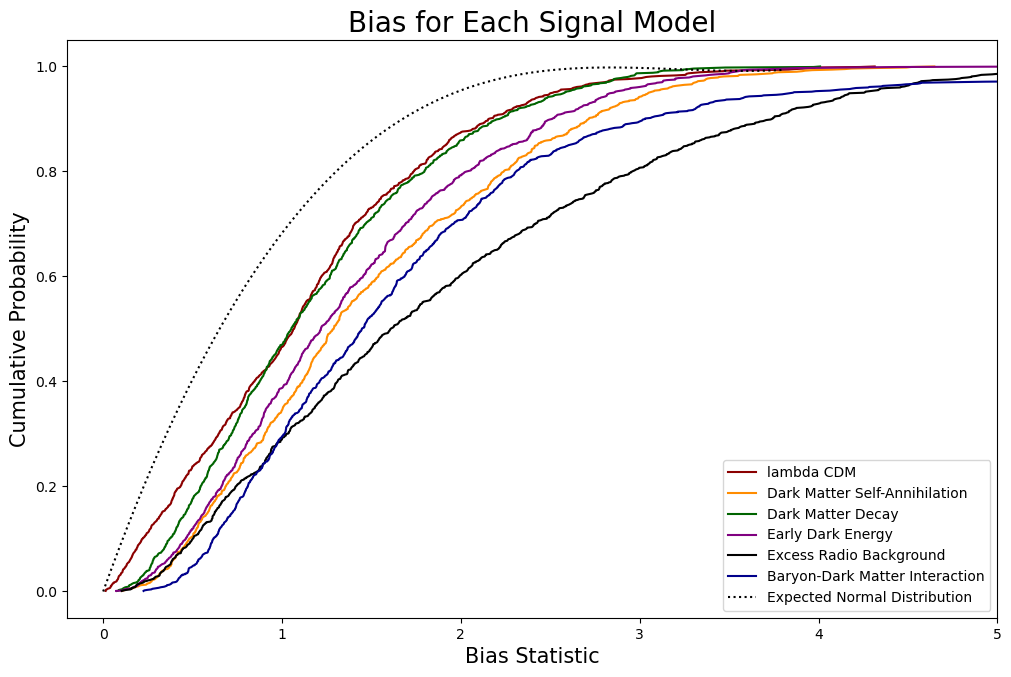

In [ ]:
# HDF5 loading of 10 bw foreground training sets (10,000 curves each)
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/bias_scores_5mil_1fg","r")
bias_scores = hdf5["bias_scores"]
# HDF5 loading end

#["lambdaCDM","DMAN","DMD","EDE","ERB","MCDM"]  # order of the bias_score index
plt.figure(figsize=(8*1.5, 5*1.5))

a = 1

# lambda_CDM
CDM_data = bias_scores[0]
data = CDM_data
data.sort()
data_std=data.std()
data_mean=data.mean()
data_range = np.arange(data.min(),data.max(),(data.max()-data.min())/len(data))
data_CDF_values = np.arange(1, len(data) + 1) / len(data)
plt.plot(data, data_CDF_values,label = "lambda CDM", c="darkred",alpha = a)

# DMAN

DMAN_data = bias_scores[1]
data = DMAN_data
data.sort()
data_std=data.std()
data_mean=data.mean()
data_range = np.arange(data.min(),data.max(),(data.max()-data.min())/len(data))
data_CDF_values = np.arange(1, len(data) + 1) / len(data)
plt.plot(data, data_CDF_values,label = "Dark Matter Self-Annihilation", c="darkorange",alpha = a)

# DMD

DMD_data = bias_scores[2]
data = DMD_data
data.sort()
data_std=data.std()
data_mean=data.mean()
data_range = np.arange(data.min(),data.max(),(data.max()-data.min())/len(data))
data_CDF_values = np.arange(1, len(data) + 1) / len(data)
plt.plot(data, data_CDF_values,label = "Dark Matter Decay", c="darkgreen",alpha = a)

# EDE

EDE_data = bias_scores[3]
data = EDE_data
data.sort()
data_std=data.std()
data_mean=data.mean()
data_range = np.arange(data.min(),data.max(),(data.max()-data.min())/len(data))
data_CDF_values = np.arange(1, len(data) + 1) / len(data)
plt.plot(data, data_CDF_values,label = "Early Dark Energy", c="purple",alpha = a)

# ERB

ERB_data = bias_scores[4]
data = ERB_data
data.sort()
data_std=data.std()
data_mean=data.mean()
data_range = np.arange(data.min(),data.max(),(data.max()-data.min())/len(data))
data_CDF_values = np.arange(1, len(data) + 1) / len(data)
plt.plot(data, data_CDF_values,label = "Excess Radio Background", c="black",alpha = a)

# MCDM

MCDM_data = bias_scores[5]
data = MCDM_data
data.sort()
data_std=data.std()
data_mean=data.mean()
data_range = np.arange(data.min(),data.max(),(data.max()-data.min())/len(data))
data_CDF_values = np.arange(1, len(data) + 1) / len(data)
plt.plot(data, data_CDF_values,label = "Baryon-Dark Matter Interaction", c="darkblue",alpha = a)

# Expected CDF
x=range(0,5)
y=scipy.stats.norm.cdf(np.arange(0,5))*2-1
interp=scipy.interpolate.CubicSpline(x,y)
plt.plot(np.arange(0,3.8,0.001),interp(np.arange(0,3.8,0.001)) ,label = "Expected Normal Distribution", c="black", ls=":")

# plt.axhline(0.68,ls="--",c="black",label="68%")
# plt.axhline(0.95,ls=":",c="black",label="95%")
# plt.axhline(0.998,ls="-.",c="black",label="99.8%")
plt.title("Bias for Each Signal Model",fontsize=20)
plt.xlabel("Bias Statistic",fontsize="15")
plt.ylabel("Cumulative Probability",fontsize="15")
plt.xlim(-0.2,5)
# plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
# plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
# plt.plot(frequencies,simulation_test_beam[1],label="input signal",c="black")
plt.legend()
plt.savefig(save_path+"Bias_statistic")



### some useful troubleshooting graphs
# N = 99
# for n in range(10000):
#     plt.plot((curves_100_training_sets[N][n]-curves_100[N])/curves_100[N])

# plt.figure(figsize=(10, 5))
# plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
# plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
# plt.title("Signal Fit",fontsize=20)
# plt.xlabel("Frequency [MHz]",fontsize="15")
# plt.ylabel("Temperature [K]",fontsize="15")
# plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
# plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
# plt.plot(frequencies,sim[1],label="input signal",c="black")
# plt.legend()
# plt.savefig(save_path+"Example_extraction")

# h=60
# for n in range(100):
#     plt.plot((curves_100_training_sets[h][n]-curves_100[1])/curves_100[1])
# plt.plot(sigT(curves_100[h],dnu,dt)/curves_100[h]*10)
# plt.plot(-sigT(curves_100[h],dnu,dt)/curves_100[h]*10)

# K-S test

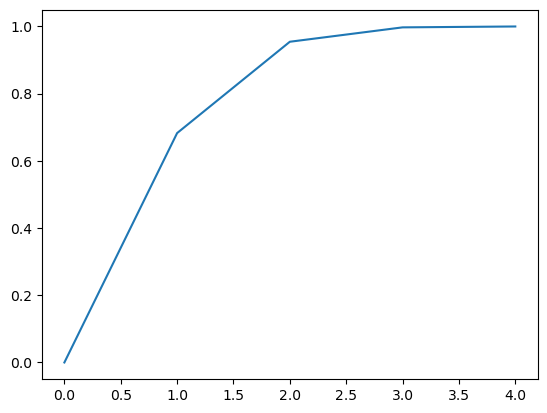

In [136]:
plt.plot(range(0,5),scipy.stats.norm.cdf(np.arange(0,5))*2-1)

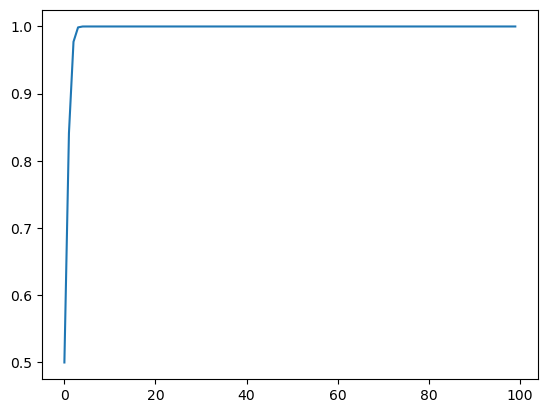

In [ ]:
plt.plot(scipy.stats.norm.cdf(np.arange()))

## SVD Training Set Fit Graph

Minimizing DIC over grid.
number of foreground terms: 1
number of signal terms: 6
Minimizing DIC over grid.
number of foreground terms: 1
number of signal terms: 6
Minimizing DIC over grid.
number of foreground terms: 1
number of signal terms: 6
Minimizing DIC over grid.
number of foreground terms: 1
number of signal terms: 6
Minimizing DIC over grid.
number of foreground terms: 1
number of signal terms: 6


AttributeError: 'Dataset' object has no attribute 'mean'

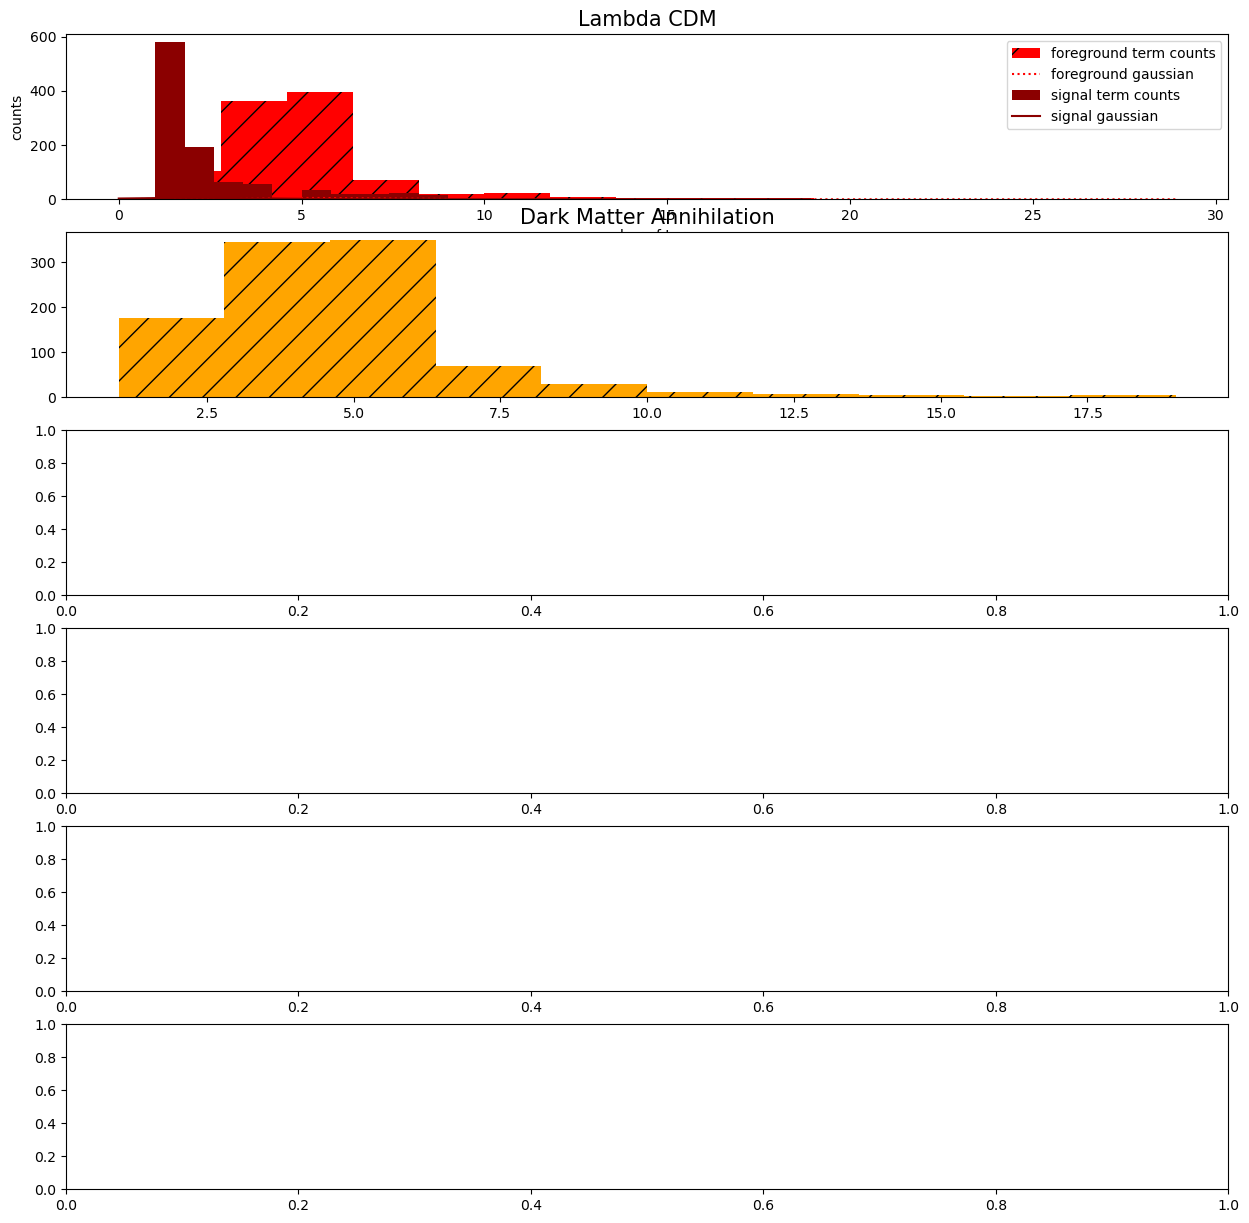

In [155]:
# SVD Training Set Fit Graph
## HDF5 loading of 100 bw foreground training sets (10,000 curves each)
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_10_sims_ts","r")
curves_100_training_sets = hdf5["curves_training_set"]
curves_100_training_sets_parameters = hdf5["curves_training_set_parameters"]

## Loaded in signal training sets

#lambda CDM
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/lambdaCDM","r")
lambdaCDM_training_set = f["signal_training_set"]
lambdaCDM_training_set_params = f["signal_training_set_parameters"]

# Self-Annihilating Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMAN","r")
DMAN_training_set = f["signal_training_set"]
DMAN_training_set_params = f["signal_training_set_parameters"]

# Decaying Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMD","r")
DMD_training_set = f["signal_training_set"]
DMD_training_set_params = f["signal_training_set_parameters"]

# Early Dark Energy
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/EDE","r")
EDE_training_set = f["signal_training_set"]
EDE_training_set_params = f["signal_training_set_parameters"]

# Extra Radio Background
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/ERB","r")
ERB_training_set = f["signal_training_set"]
ERB_training_set_params = f["signal_training_set_parameters"]

# Baryon-Dark Matter Interaction (MCDM)
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/MCDM","r")
MCDM_training_set = f["signal_training_set"]
MCDM_training_set_params = f["signal_training_set_parameters"]

# ## HDF5 loading end
# Ncurves = 1000
# # lambda CDM SVD test:
# CDM_test_sims = np.zeros((Ncurves,len(frequencies)))
# CDM_test_fg = np.zeros((Ncurves,len(frequencies)))
# CDM_test_sig = np.zeros((Ncurves,len(frequencies)))
# CDM_test_noise = np.zeros((Ncurves,len(frequencies)))
# CDM_test_nonoise = np.zeros((Ncurves,len(frequencies)))

# for n in range(Ncurves):
#     random_index1=int(np.random.random()*len(curves_100_training_sets[0]))
#     random_index2=int(np.random.random()*len(lambdaCDM_training_set))
#     CDM_test_sims[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],lambdaCDM_training_set[random_index2],dnu,dt)[0]
#     CDM_test_fg[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],lambdaCDM_training_set[random_index2],dnu,dt)[2]
#     CDM_test_sig[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],lambdaCDM_training_set[random_index2],dnu,dt)[1]
#     CDM_test_noise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],lambdaCDM_training_set[random_index2],dnu,dt)[3]
#     CDM_test_nonoise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],lambdaCDM_training_set[random_index2],dnu,dt)[4]



# CDM_foreground_terms = np.zeros((Ncurves))
# CDM_signal_terms = np.zeros((Ncurves))
# sig_training_set = lambdaCDM_training_set
# sim_curves = CDM_test_sims
# for n in tqdm(range (Ncurves)):
# #### Pylinex Fit #####
#     foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
#     sig_training_set
#     IC = "DIC"
#     sim = simulation_curves_array[n]
#     sim_data = sim_curves[n]
#     noise_level = sigT(sim_data,dnu,dt)
#     foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
#     signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
#     temperatures = sim_data
#     basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
#     quantity = AttributeQuantity(IC)
#     dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
#     # priors = {"Signal_prior" : signal_basis.gaussian_prior}
#     meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
#     fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
#     CDM_foreground_terms[n] = fitter2.sizes['Foreground']
#     CDM_signal_terms[n] = fitter2.sizes['Signal']
# ### End PYLINEX fit

# # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/CDM_SVD_test_data","w")
# hdf5.create_dataset("data",data=CDM_test_sims)
# hdf5.create_dataset("foreground",data=CDM_test_fg)
# hdf5.create_dataset("signal",data=CDM_test_sig)
# hdf5.create_dataset("noise",data=CDM_test_noise)
# hdf5.create_dataset("data_no_noise",data=CDM_test_nonoise)
# hdf5.create_dataset("foreground_terms",data=CDM_foreground_terms)
# hdf5.create_dataset("signal_terms",data=CDM_signal_terms)
# hdf5.close()
# ## End of HDF5 data saving

# # DMAN SVD test:
# DMAN_test_sims = np.zeros((Ncurves,len(frequencies)))
# DMAN_test_fg = np.zeros((Ncurves,len(frequencies)))
# DMAN_test_sig = np.zeros((Ncurves,len(frequencies)))
# DMAN_test_noise = np.zeros((Ncurves,len(frequencies)))
# DMAN_test_nonoise = np.zeros((Ncurves,len(frequencies)))

# for n in range(Ncurves):
#     random_index1=int(np.random.random()*len(curves_100_training_sets[0]))
#     random_index2=int(np.random.random()*len(DMAN_training_set))
#     DMAN_test_sims[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMAN_training_set[random_index2],dnu,dt)[0]
#     DMAN_test_fg[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMAN_training_set[random_index2],dnu,dt)[2]
#     DMAN_test_sig[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMAN_training_set[random_index2],dnu,dt)[1]
#     DMAN_test_noise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMAN_training_set[random_index2],dnu,dt)[3]
#     DMAN_test_nonoise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMAN_training_set[random_index2],dnu,dt)[4]




# DMAN_foreground_terms = np.zeros((Ncurves))
# DMAN_signal_terms = np.zeros((Ncurves))
# sig_training_set = DMAN_training_set
# sim_curves = DMAN_test_sims
# for n in tqdm(range (Ncurves)):
# #### Pylinex Fit #####
#     foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
#     sig_training_set
#     IC = "DIC"
#     sim = simulation_curves_array[n]
#     sim_data = sim_curves[n]
#     noise_level = sigT(sim_data,dnu,dt)
#     foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
#     signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
#     temperatures = sim_data
#     basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
#     quantity = AttributeQuantity(IC)
#     dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
#     # priors = {"Signal_prior" : signal_basis.gaussian_prior}
#     meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
#     fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
#     DMAN_foreground_terms[n] = fitter2.sizes['Foreground']
#     DMAN_signal_terms[n] = fitter2.sizes['Signal']
# ### End PYLINEX fit

#     # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMAN_SVD_test_data","w")
# hdf5.create_dataset("data",data=DMAN_test_sims)
# hdf5.create_dataset("foreground",data=DMAN_test_fg)
# hdf5.create_dataset("signal",data=DMAN_test_sig)
# hdf5.create_dataset("noise",data=DMAN_test_noise)
# hdf5.create_dataset("data_no_noise",data=DMAN_test_nonoise)
# hdf5.create_dataset("foreground_terms",data=DMAN_foreground_terms)
# hdf5.create_dataset("signal_terms",data=DMAN_signal_terms)
# hdf5.close()
# ## End of HDF5 data saving

# # DMD SVD test:
# DMD_test_sims = np.zeros((Ncurves,len(frequencies)))
# DMD_test_fg = np.zeros((Ncurves,len(frequencies)))
# DMD_test_sig = np.zeros((Ncurves,len(frequencies)))
# DMD_test_noise = np.zeros((Ncurves,len(frequencies)))
# DMD_test_nonoise = np.zeros((Ncurves,len(frequencies)))

# for n in range(Ncurves):
#     random_index1=int(np.random.random()*len(curves_100_training_sets[0]))
#     random_index2=int(np.random.random()*len(DMD_training_set))
#     DMD_test_sims[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMD_training_set[random_index2],dnu,dt)[0]
#     DMD_test_fg[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMD_training_set[random_index2],dnu,dt)[2]
#     DMD_test_sig[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMD_training_set[random_index2],dnu,dt)[1]
#     DMD_test_noise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMD_training_set[random_index2],dnu,dt)[3]
#     DMD_test_nonoise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMD_training_set[random_index2],dnu,dt)[4]




# DMD_foreground_terms = np.zeros((Ncurves))
# DMD_signal_terms = np.zeros((Ncurves))
# sig_training_set = DMD_training_set
# sim_curves = DMD_test_sims
# for n in tqdm(range (Ncurves)):
# #### Pylinex Fit #####
#     foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
#     sig_training_set
#     IC = "DIC"
#     sim = simulation_curves_array[n]
#     sim_data = sim_curves[n]
#     noise_level = sigT(sim_data,dnu,dt)
#     foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
#     signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
#     temperatures = sim_data
#     basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
#     quantity = AttributeQuantity(IC)
#     dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
#     # priors = {"Signal_prior" : signal_basis.gaussian_prior}
#     meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
#     fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
#     DMD_foreground_terms[n] = fitter2.sizes['Foreground']
#     DMD_signal_terms[n] = fitter2.sizes['Signal']
# ### End PYLINEX fit

#     # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMD_SVD_test_data","w")
# hdf5.create_dataset("data",data=DMD_test_sims)
# hdf5.create_dataset("foreground",data=DMD_test_fg)
# hdf5.create_dataset("signal",data=DMD_test_sig)
# hdf5.create_dataset("noise",data=DMD_test_noise)
# hdf5.create_dataset("data_no_noise",data=DMD_test_nonoise)
# hdf5.create_dataset("foreground_terms",data=DMD_foreground_terms)
# hdf5.create_dataset("signal_terms",data=DMD_signal_terms)
# hdf5.close()
# ## End of HDF5 data saving

# # MCDM SVD test:
# MCDM_test_sims = np.zeros((Ncurves,len(frequencies)))
# MCDM_test_fg = np.zeros((Ncurves,len(frequencies)))
# MCDM_test_sig = np.zeros((Ncurves,len(frequencies)))
# MCDM_test_noise = np.zeros((Ncurves,len(frequencies)))
# MCDM_test_nonoise = np.zeros((Ncurves,len(frequencies)))

# for n in range(Ncurves):
#     random_index1=int(np.random.random()*len(curves_100_training_sets[0]))
#     random_index2=int(np.random.random()*len(MCDM_training_set))
#     MCDM_test_sims[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],MCDM_training_set[random_index2],dnu,dt)[0]
#     MCDM_test_fg[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],MCDM_training_set[random_index2],dnu,dt)[2]
#     MCDM_test_sig[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],MCDM_training_set[random_index2],dnu,dt)[1]
#     MCDM_test_noise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],MCDM_training_set[random_index2],dnu,dt)[3]
#     MCDM_test_nonoise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],MCDM_training_set[random_index2],dnu,dt)[4]




# MCDM_foreground_terms = np.zeros((Ncurves))
# MCDM_signal_terms = np.zeros((Ncurves))
# sig_training_set = MCDM_training_set
# sim_curves = MCDM_test_sims
# for n in tqdm(range (Ncurves)):
# #### Pylinex Fit #####
#     foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
#     sig_training_set
#     IC = "DIC"
#     sim = simulation_curves_array[n]
#     sim_data = sim_curves[n]
#     noise_level = sigT(sim_data,dnu,dt)
#     foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
#     signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
#     temperatures = sim_data
#     basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
#     quantity = AttributeQuantity(IC)
#     dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
#     # priors = {"Signal_prior" : signal_basis.gaussian_prior}
#     meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
#     fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
#     MCDM_foreground_terms[n] = fitter2.sizes['Foreground']
#     MCDM_signal_terms[n] = fitter2.sizes['Signal']
# ### End PYLINEX fit

#     # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/MCDM_SVD_test_data","w")
# hdf5.create_dataset("data",data=MCDM_test_sims)
# hdf5.create_dataset("foreground",data=MCDM_test_fg)
# hdf5.create_dataset("signal",data=MCDM_test_sig)
# hdf5.create_dataset("noise",data=MCDM_test_noise)
# hdf5.create_dataset("data_no_noise",data=MCDM_test_nonoise)
# hdf5.create_dataset("foreground_terms",data=MCDM_foreground_terms)
# hdf5.create_dataset("signal_terms",data=MCDM_signal_terms)
# hdf5.close()
# ## End of HDF5 data saving

# # EDE SVD test:
# EDE_test_sims = np.zeros((Ncurves,len(frequencies)))
# EDE_test_fg = np.zeros((Ncurves,len(frequencies)))
# EDE_test_sig = np.zeros((Ncurves,len(frequencies)))
# EDE_test_noise = np.zeros((Ncurves,len(frequencies)))
# EDE_test_nonoise = np.zeros((Ncurves,len(frequencies)))

# for n in (range(Ncurves)):
#     random_index1=int(np.random.random()*len(curves_100_training_sets[0]))
#     random_index2=int(np.random.random()*len(EDE_training_set))
#     EDE_test_sims[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],EDE_training_set[random_index2],dnu,dt)[0]
#     EDE_test_fg[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],EDE_training_set[random_index2],dnu,dt)[2]
#     EDE_test_sig[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],EDE_training_set[random_index2],dnu,dt)[1]
#     EDE_test_noise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],EDE_training_set[random_index2],dnu,dt)[3]
#     EDE_test_nonoise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],EDE_training_set[random_index2],dnu,dt)[4]




# EDE_foreground_terms = np.zeros((Ncurves))
# EDE_signal_terms = np.zeros((Ncurves))
# sig_training_set = EDE_training_set
# sim_curves = EDE_test_sims
# for n in tqdm(range (Ncurves)):
# #### Pylinex Fit #####
#     foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
#     sig_training_set
#     IC = "DIC"
#     sim = simulation_curves_array[n]
#     sim_data = sim_curves[n]
#     noise_level = sigT(sim_data,dnu,dt)
#     foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
#     signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
#     temperatures = sim_data
#     basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
#     quantity = AttributeQuantity(IC)
#     dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
#     # priors = {"Signal_prior" : signal_basis.gaussian_prior}
#     meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
#     fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
#     EDE_foreground_terms[n] = fitter2.sizes['Foreground']
#     EDE_signal_terms[n] = fitter2.sizes['Signal']
# ### End PYLINEX fit

#     # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/EDE_SVD_test_data","w")
# hdf5.create_dataset("data",data=EDE_test_sims)
# hdf5.create_dataset("foreground",data=EDE_test_fg)
# hdf5.create_dataset("signal",data=EDE_test_sig)
# hdf5.create_dataset("noise",data=EDE_test_noise)
# hdf5.create_dataset("data_no_noise",data=EDE_test_nonoise)
# hdf5.create_dataset("foreground_terms",data=EDE_foreground_terms)
# hdf5.create_dataset("signal_terms",data=EDE_signal_terms)
# hdf5.close()
# ## End of HDF5 data saving

# # ERB SVD test:
# ERB_test_sims = np.zeros((Ncurves,len(frequencies)))
# ERB_test_fg = np.zeros((Ncurves,len(frequencies)))
# ERB_test_sig = np.zeros((Ncurves,len(frequencies)))
# ERB_test_noise = np.zeros((Ncurves,len(frequencies)))
# ERB_test_nonoise = np.zeros((Ncurves,len(frequencies)))

# for n in (range(Ncurves)):
#     random_index1=int(np.random.random()*len(curves_100_training_sets[0]))
#     random_index2=int(np.random.random()*len(ERB_training_set))
#     ERB_test_sims[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],ERB_training_set[random_index2],dnu,dt)[0]
#     ERB_test_fg[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],ERB_training_set[random_index2],dnu,dt)[2]
#     ERB_test_sig[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],ERB_training_set[random_index2],dnu,dt)[1]
#     ERB_test_noise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],ERB_training_set[random_index2],dnu,dt)[3]
#     ERB_test_nonoise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],ERB_training_set[random_index2],dnu,dt)[4]




# ERB_foreground_terms = np.zeros((Ncurves))
# ERB_signal_terms = np.zeros((Ncurves))
# sig_training_set = ERB_training_set
# sim_curves = ERB_test_sims
# for n in tqdm(range (Ncurves)):
#     #### Pylinex Fit #####
#     foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
#     sig_training_set
#     IC = "DIC"
#     sim = simulation_curves_array[n]
#     sim_data = sim_curves[n]
#     noise_level = sigT(sim_data,dnu,dt)
#     foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
#     signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
#     temperatures = sim_data
#     basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
#     quantity = AttributeQuantity(IC)
#     dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
#     # priors = {"Signal_prior" : signal_basis.gaussian_prior}
#     meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
#     fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
#     ERB_foreground_terms[n] = fitter2.sizes['Foreground']
#     ERB_signal_terms[n] = fitter2.sizes['Signal']
#     ### End PYLINEX fit

#     # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/ERB_SVD_test_data","w")
# hdf5.create_dataset("data",data=ERB_test_sims)
# hdf5.create_dataset("foreground",data=ERB_test_fg)
# hdf5.create_dataset("signal",data=ERB_test_sig)
# hdf5.create_dataset("noise",data=ERB_test_noise)
# hdf5.create_dataset("data_no_noise",data=ERB_test_nonoise)
# hdf5.create_dataset("foreground_terms",data=ERB_foreground_terms)
# hdf5.create_dataset("signal_terms",data=ERB_signal_terms)
# hdf5.close()
# # End of HDF5 data saving

## HDF5 loading block
# lambda CDM
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/CDM_SVD_test_data","r")
CDM_data=np.array(hdf5["data"])
CDM_signal=np.array(hdf5["signal"])
CDM_foreground=np.array(hdf5["foreground"])
CDM_noise=np.array(hdf5["noise"])
CDM_data_no_noise=np.array(hdf5["data_no_noise"])
CDM_foreground_terms=np.array(hdf5["foreground_terms"])
CDM_signal_terms=np.array(hdf5["signal_terms"])

# DMAN
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMAN_SVD_test_data","r")
DMAN_data=np.array(hdf5["data"])
DMAN_signal=np.array(hdf5["signal"])
DMAN_foreground=np.array(hdf5["foreground"])
DMAN_noise=np.array(hdf5["noise"])
DMAN_data_no_noise=np.array(hdf5["data_no_noise"])
DMAN_foreground_terms=hdf5["foreground_terms"]
DMAN_signal_terms=np.array(hdf5["signal_terms"])

# DMD
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMD_SVD_test_data","r")
DMD_data=np.array(hdf5["data"])
DMD_signal=np.array(hdf5["signal"])
DMD_foreground=np.array(hdf5["foreground"])
DMD_noise=np.array(hdf5["noise"])
DMD_data_no_noise=np.array(hdf5["data_no_noise"])
DMDforeground_terms=np.array(hdf5["foreground_terms"])
DMD_signal_terms=np.array(hdf5["signal_terms"])

# MCDM
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/MCDM_SVD_test_data","r")
MCDM_data=np.array(hdf5["data"])
MCDM_signal=np.array(hdf5["signal"])
MCDM_foreground=np.array(hdf5["foreground"])
MCDM_noise=np.array(hdf5["noise"])
MCDM_data_no_noise=np.array(hdf5["data_no_noise"])
MCDM_foreground_terms=np.array(hdf5["foreground_terms"])
MCDM_signal_terms=np.array(hdf5["signal_terms"])

# EDE
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/EDE_SVD_test_data","r")
EDE_data=np.array(hdf5["data"])
EDE_signal=np.array(hdf5["signal"])
EDE_foreground=np.array(hdf5["foreground"])
EDE_noise=np.array(hdf5["noise"])
EDE_data_no_noise=np.array(hdf5["data_no_noise"])
EDE_foreground_terms=np.array(hdf5["foreground_terms"])
EDE_signal_terms=np.array(hdf5["signal_terms"])

# ERB
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/ERB_SVD_test_data","r")
ERB_data=np.array(hdf5["data"])
ERB_signal=np.array(hdf5["signal"])
ERB_foreground=np.array(hdf5["foreground"])
ERB_noise=np.array(hdf5["noise"])
ERB_data_no_noise=np.array(hdf5["data_no_noise"])
ERB_foreground_terms=np.array(hdf5["foreground_terms"])
ERB_signal_terms=np.array(hdf5["signal_terms"])


# Use this for the examples of bad stuff
#signal_training_set =   # Fill this out with the correct (or incorrect) signal training set
#sim_curves =  # 
sig_training_set = lambdaCDM_training_set
foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = DMAN_data[0]
noise_level = sigT(sim_data,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_DMAN = fitter2.sizes['Foreground']
num_signal_terms_DMAN = fitter2.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms}")
print(f"number of signal terms: {num_signal_terms}")

foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = DMD_data[0]
noise_level = sigT(sim_data,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_DMD = fitter2.sizes['Foreground']
num_signal_terms_DMD = fitter2.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms}")
print(f"number of signal terms: {num_signal_terms}")

foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = MCDM_data[0]
noise_level = sigT(sim_data,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_MCDM = fitter2.sizes['Foreground']
num_signal_terms_MCDM = fitter2.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms}")
print(f"number of signal terms: {num_signal_terms}")

foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = EDE_data[0]
noise_level = sigT(sim_data,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_EDE = fitter2.sizes['Foreground']
num_signal_terms_EDE = fitter2.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms}")
print(f"number of signal terms: {num_signal_terms}")

foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = ERB_data[0]
noise_level = sigT(sim_data,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_ERB = fitter2.sizes['Foreground']
num_signal_terms_ERB = fitter2.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms}")
print(f"number of signal terms: {num_signal_terms}")


fig, (ax1, ax2, ax3, ax4, ax5, ax6,) = plt.subplots(6,1,figsize=(15, 15))

plt.subplot(6,1,1)
plt.title("Lambda CDM",fontsize=15)
plt.hist(CDM_foreground_terms,bins=10, label="foreground term counts",color="red",hatch="/")
mean= CDM_foreground_terms.mean()
std= CDM_foreground_terms.std()
ranger = np.arange(0,int(CDM_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="red",ls=":",label="foreground gaussian")
plt.hist(CDM_signal_terms,bins=10, label="signal term counts",color="darkred")
mean= CDM_signal_terms.mean()
std= CDM_signal_terms.std()
ranger = np.arange(0,int(CDM_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkred",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()


plt.subplot(6,1,2)
plt.title("Dark Matter Annihilation",fontsize=15)
plt.hist(DMAN_foreground_terms,bins=10, label="foreground term counts",color="orange",hatch="/")
mean= DMAN_foreground_terms.mean()
std= DMAN_foreground_terms.std()
ranger = np.arange(0,int(DMAN_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="orange",ls=":",label="foreground gaussian")
plt.hist(DMAN_signal_terms,bins=10, label="signal term counts",color="darkorange")
mean= DMAN_signal_terms.mean()
std= DMAN_signal_terms.std()
ranger = np.arange(0,int(DMAN_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkorange",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,3)
plt.title("Dark Matter Decay",fontsize=15)
plt.hist(DMD_foreground_terms,bins=10, label="foreground term counts",color="green",hatch="/")
mean= DMD_foreground_terms.mean()
std= DMD_foreground_terms.std()
ranger = np.arange(0,int(DMD_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="green",ls=":",label="foreground gaussian")
plt.hist(DMD_signal_terms,bins=10, label="signal term counts",color="darkgreen")
mean= DMD_signal_terms.mean()
std= DMD_signal_terms.std()
ranger = np.arange(0,int(DMD_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkgreen",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,4)
plt.title("Dark Matter - Baryon Interaction",fontsize=15)
plt.hist(MCDM_foreground_terms,bins=10, label="foreground term counts",color="blue",hatch="/")
mean= MCDM_foreground_terms.mean()
std= MCDM_foreground_terms.std()
ranger = np.arange(0,int(MCDM_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="blue",ls=":",label="foreground gaussian")
plt.hist(MCDM_signal_terms,bins=10, label="signal term counts",color="darkblue")
mean= MCDM_signal_terms.mean()
std= MCDM_signal_terms.std()
ranger = np.arange(0,int(MCDM_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkblue",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,5)
plt.title("Early Dark Energy",fontsize=15)
plt.hist(EDE_foreground_terms,bins=10, label="foreground term counts",color="magenta",hatch="/")
mean= EDE_foreground_terms.mean()
std= EDE_foreground_terms.std()
ranger = np.arange(0,int(EDE_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="magenta",ls=":",label="foreground gaussian")
plt.hist(EDE_signal_terms,bins=10, label="signal term counts",color="purple")
mean= EDE_signal_terms.mean()
std= EDE_signal_terms.std()
ranger = np.arange(0,int(EDE_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="purple",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,6)
plt.title("Excess Radio Background",fontsize=15)
plt.hist(ERB_foreground_terms,bins=10, label="foreground term counts",color="gray",hatch="/")
mean= ERB_foreground_terms.mean()
std= ERB_foreground_terms.std()
ranger = np.arange(0,int(ERB_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="gray",ls=":",label="foreground gaussian")
plt.hist(ERB_signal_terms,bins=10, label="signal term counts",color="black")
mean= ERB_signal_terms.mean()
std= ERB_signal_terms.std()
ranger = np.arange(0,int(ERB_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="black",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.6)

# plt.savefig(save_path+"SVD_trainingset_test")




In [151]:
noise_level.shape

(1000, 176)

NameError: name 'CDM_foreground_terms' is not defined

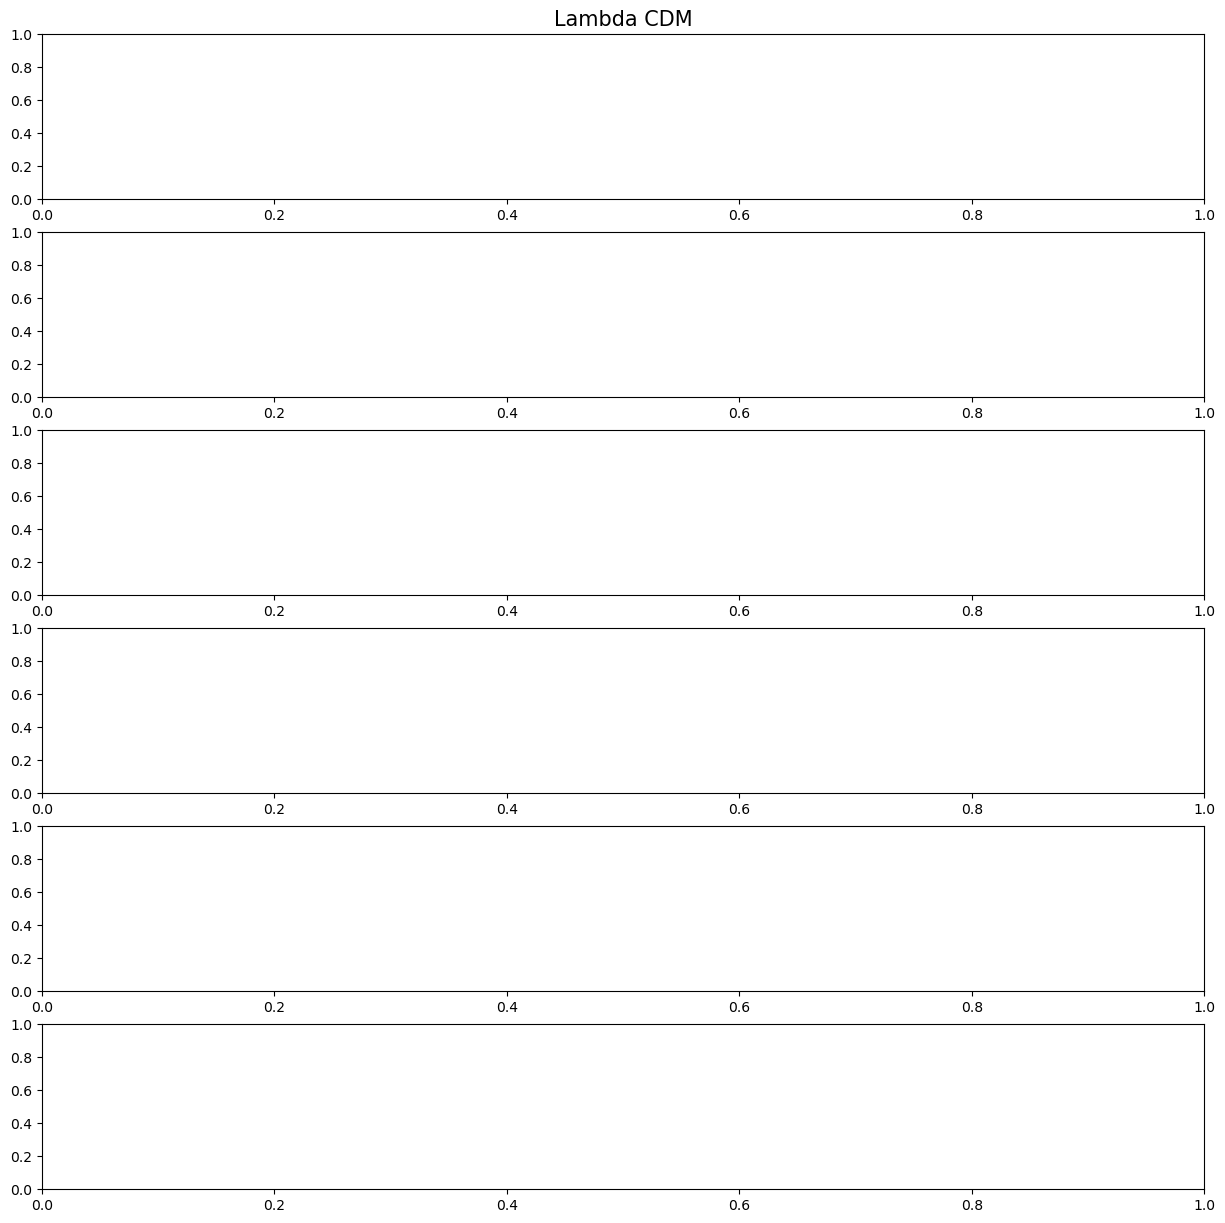

In [143]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6,) = plt.subplots(6,1,figsize=(15, 15))

plt.subplot(6,1,1)
plt.title("Lambda CDM",fontsize=15)
plt.hist(CDM_foreground_terms,bins=10, label="foreground term counts",color="red",hatch="/")
mean= CDM_foreground_terms.mean()
std= CDM_foreground_terms.std()
ranger = np.arange(0,int(CDM_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="red",ls=":")
plt.hist(CDM_signal_terms,bins=10, label="signal term counts",color="darkred")
mean= CDM_signal_terms.mean()
std= CDM_signal_terms.std()
ranger = np.arange(0,int(CDM_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkred")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()


plt.subplot(6,1,2)
plt.title("Dark Matter Annihilation",fontsize=15)
plt.hist(DMAN_foreground_terms,bins=10, label="foreground term counts",color="orange",hatch="/")
mean= DMAN_foreground_terms.mean()
std= DMAN_foreground_terms.std()
ranger = np.arange(0,int(DMAN_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="orange",ls=":")
plt.hist(DMAN_signal_terms,bins=10, label="signal term counts",color="darkorange")
mean= DMAN_signal_terms.mean()
std= DMAN_signal_terms.std()
ranger = np.arange(0,int(DMAN_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkorange")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,3)
plt.title("Dark Matter Decay",fontsize=15)
plt.hist(DMD_foreground_terms,bins=10, label="foreground term counts",color="green",hatch="/")
mean= DMD_foreground_terms.mean()
std= DMD_foreground_terms.std()
ranger = np.arange(0,int(DMD_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="green",ls=":")
plt.hist(DMD_signal_terms,bins=10, label="signal term counts",color="darkgreen")
mean= DMD_signal_terms.mean()
std= DMD_signal_terms.std()
ranger = np.arange(0,int(DMD_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkgreen")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,4)
plt.title("Dark Matter - Baryon Interaction",fontsize=15)
plt.hist(MCDM_foreground_terms,bins=10, label="foreground term counts",color="blue",hatch="/")
mean= MCDM_foreground_terms.mean()
std= MCDM_foreground_terms.std()
ranger = np.arange(0,int(MCDM_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="blue",ls=":")
plt.hist(MCDM_signal_terms,bins=10, label="signal term counts",color="darkblue")
mean= MCDM_signal_terms.mean()
std= MCDM_signal_terms.std()
ranger = np.arange(0,int(MCDM_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkblue")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,5)
plt.title("Early Dark Energy",fontsize=15)
plt.hist(EDE_foreground_terms,bins=10, label="foreground term counts",color="magenta",hatch="/")
mean= EDE_foreground_terms.mean()
std= EDE_foreground_terms.std()
ranger = np.arange(0,int(EDE_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="magenta",ls=":")
plt.hist(EDE_signal_terms,bins=10, label="signal term counts",color="purple")
mean= EDE_signal_terms.mean()
std= EDE_signal_terms.std()
ranger = np.arange(0,int(EDE_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="purple")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,6)
plt.title("Excess Radio Background",fontsize=15)
plt.hist(ERB_foreground_terms,bins=10, label="foreground term counts",color="gray",hatch="/")
mean= ERB_foreground_terms.mean()
std= ERB_foreground_terms.std()
ranger = np.arange(0,int(ERB_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="gray",ls=":")
plt.hist(ERB_signal_terms,bins=10, label="signal term counts",color="black")
mean= ERB_signal_terms.mean()
std= ERB_signal_terms.std()
ranger = np.arange(0,int(ERB_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="black")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.6)

plt.savefig(save_path+"SVD_trainingset_test")

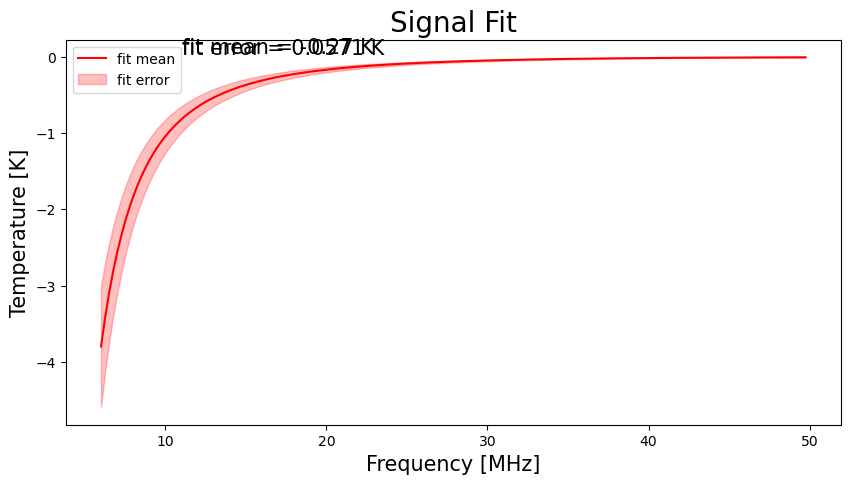

In [19]:
# Not really a necessary plot, but might be nice to see how bad or good fits are visually
plt.figure(figsize=(10, 5))
plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
plt.title("Signal Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
# plt.plot(frequencies,sim_curves,label="input signal",c="black")
plt.legend()

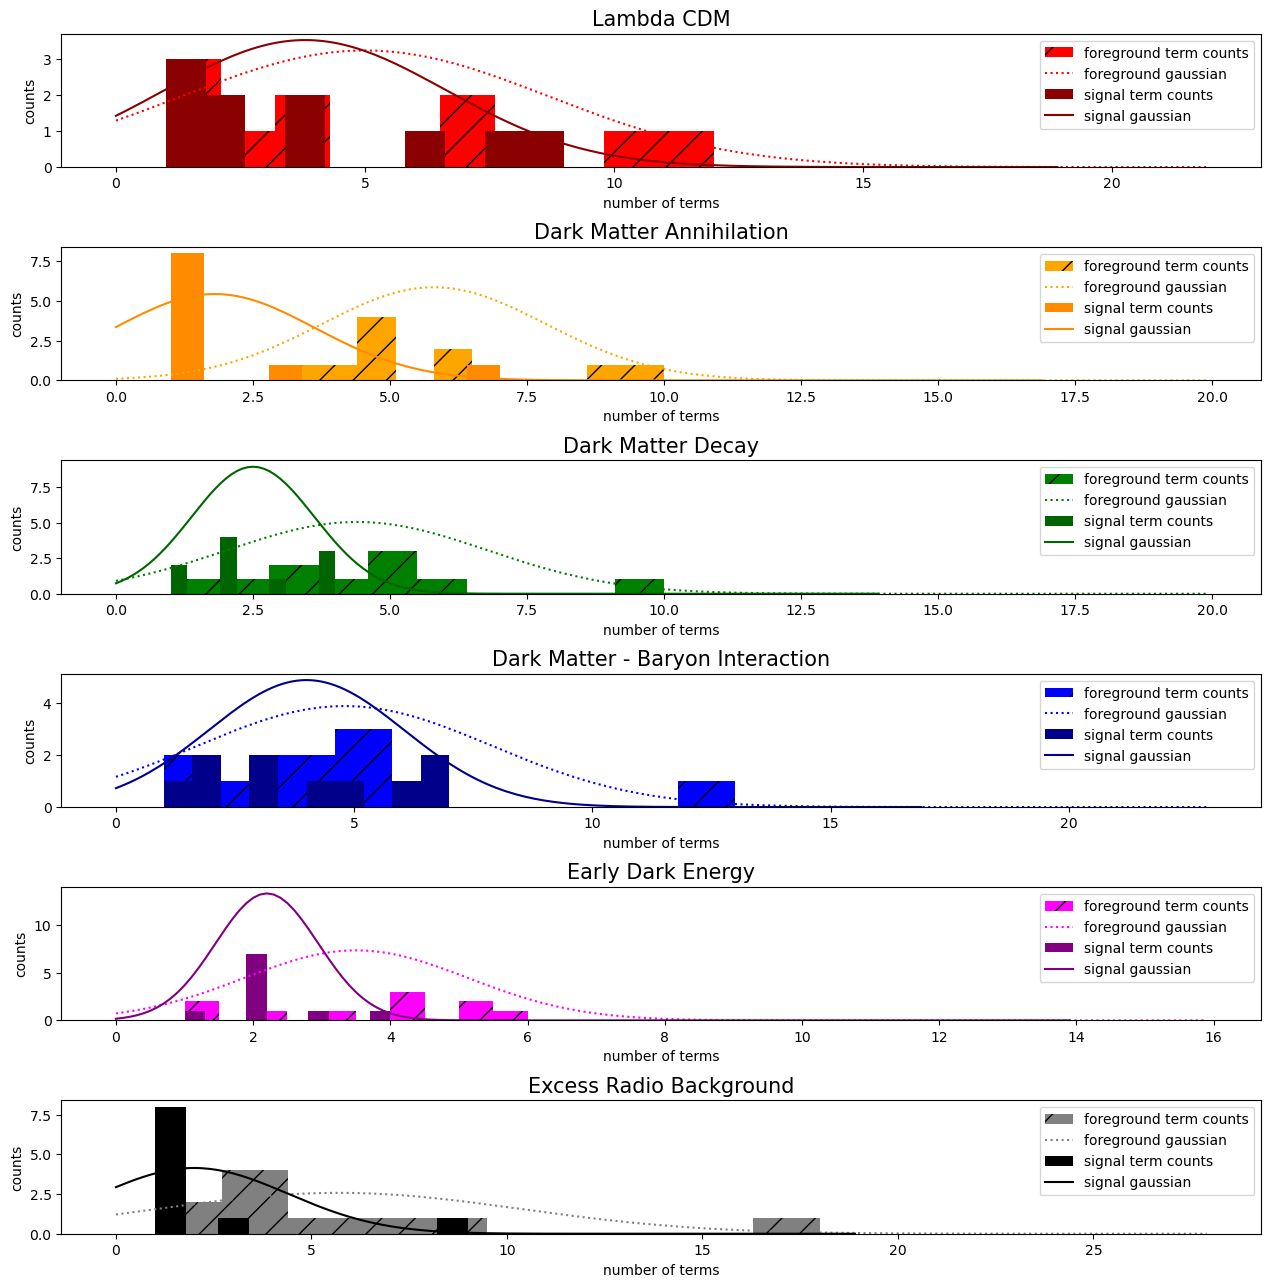

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6,) = plt.subplots(6,1,figsize=(15, 15))

plt.subplot(6,1,1)
plt.title("Lambda CDM",fontsize=15)
plt.hist(CDM_foreground_terms,bins=10, label="foreground term counts",color="red",hatch="/")
mean= CDM_foreground_terms.mean()
std= CDM_foreground_terms.std()
ranger = np.arange(0,int(CDM_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="red",ls=":",label="foreground gaussian")
plt.hist(CDM_signal_terms,bins=10, label="signal term counts",color="darkred")
mean= CDM_signal_terms.mean()
std= CDM_signal_terms.std()
ranger = np.arange(0,int(CDM_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkred",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()


plt.subplot(6,1,2)
plt.title("Dark Matter Annihilation",fontsize=15)
plt.hist(DMAN_foreground_terms,bins=10, label="foreground term counts",color="orange",hatch="/")
mean= DMAN_foreground_terms.mean()
std= DMAN_foreground_terms.std()
ranger = np.arange(0,int(DMAN_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="orange",ls=":",label="foreground gaussian")
plt.hist(DMAN_signal_terms,bins=10, label="signal term counts",color="darkorange")
mean= DMAN_signal_terms.mean()
std= DMAN_signal_terms.std()
ranger = np.arange(0,int(DMAN_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkorange",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,3)
plt.title("Dark Matter Decay",fontsize=15)
plt.hist(DMD_foreground_terms,bins=10, label="foreground term counts",color="green",hatch="/")
mean= DMD_foreground_terms.mean()
std= DMD_foreground_terms.std()
ranger = np.arange(0,int(DMD_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="green",ls=":",label="foreground gaussian")
plt.hist(DMD_signal_terms,bins=10, label="signal term counts",color="darkgreen")
mean= DMD_signal_terms.mean()
std= DMD_signal_terms.std()
ranger = np.arange(0,int(DMD_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkgreen",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,4)
plt.title("Dark Matter - Baryon Interaction",fontsize=15)
plt.hist(MCDM_foreground_terms,bins=10, label="foreground term counts",color="blue",hatch="/")
mean= MCDM_foreground_terms.mean()
std= MCDM_foreground_terms.std()
ranger = np.arange(0,int(MCDM_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="blue",ls=":",label="foreground gaussian")
plt.hist(MCDM_signal_terms,bins=10, label="signal term counts",color="darkblue")
mean= MCDM_signal_terms.mean()
std= MCDM_signal_terms.std()
ranger = np.arange(0,int(MCDM_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkblue",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,5)
plt.title("Early Dark Energy",fontsize=15)
plt.hist(EDE_foreground_terms,bins=10, label="foreground term counts",color="magenta",hatch="/")
mean= EDE_foreground_terms.mean()
std= EDE_foreground_terms.std()
ranger = np.arange(0,int(EDE_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="magenta",ls=":",label="foreground gaussian")
plt.hist(EDE_signal_terms,bins=10, label="signal term counts",color="purple")
mean= EDE_signal_terms.mean()
std= EDE_signal_terms.std()
ranger = np.arange(0,int(EDE_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="purple",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,6)
plt.title("Excess Radio Background",fontsize=15)
plt.hist(ERB_foreground_terms,bins=10, label="foreground term counts",color="gray",hatch="/")
mean= ERB_foreground_terms.mean()
std= ERB_foreground_terms.std()
ranger = np.arange(0,int(ERB_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="gray",ls=":",label="foreground gaussian")
plt.hist(ERB_signal_terms,bins=10, label="signal term counts",color="black")
mean= ERB_signal_terms.mean()
std= ERB_signal_terms.std()
ranger = np.arange(0,int(ERB_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="black",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.6)

plt.savefig(save_path+"SVD_trainingset_test")



In [205]:
std

3.687817782917155